In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

/Users/edgar/opt/anaconda3/envs/GeoDS_3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
image_size = 28

# NB: background=True selects the train set, background=False selects the test set
# It's the nomenclature from the original paper, we just have to deal with it

train_set = Omniglot(
    root="./data",
    background=True,
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
test_set = Omniglot(
    root="./data",
    background=False,
    transform=transforms.Compose(
        [
            # Omniglot images have 1 channel, but our model will expect 3-channel images
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)

100%|██████████| 9464212/9464212 [00:06<00:00, 1541936.72it/s]


Extracting ./data/omniglot-py/images_background.zip to ./data/omniglot-py


100%|██████████| 6462886/6462886 [00:02<00:00, 2971534.74it/s]


Extracting ./data/omniglot-py/images_evaluation.zip to ./data/omniglot-py


In [9]:
device = torch.device('mps')

In [35]:
import numpy as np

In [38]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        print('support', z_support)
        z_query = self.backbone.forward(query_images)
        print('query', z_query)
        # Infer the number of different classes from the labels of the support set
        #n_way = len(torch.unique(support_labels))
        n_way = len(np.unique(np.array(support_labels.to(torch.device('cpu')))))
        print('n_way', n_way)
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )
        print('proto', z_proto)
        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)
        #dists = torch.tensor(z_query, z_proto)
        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores


convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
print(convolutional_network)

model = PrototypicalNetworks(convolutional_network).to(device)

/Users/edgar/opt/anaconda3/envs/GeoDS_3.8/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/edgar/opt/anaconda3/envs/GeoDS_3.8/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
N_WAY = 5  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!
test_set.get_labels = lambda: [
    instance[1] for instance in test_set._flat_character_images
]
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

In [15]:
test_loader

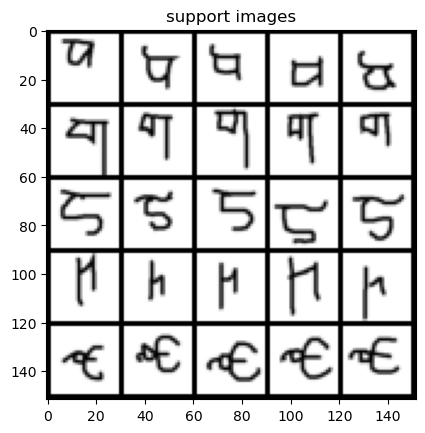

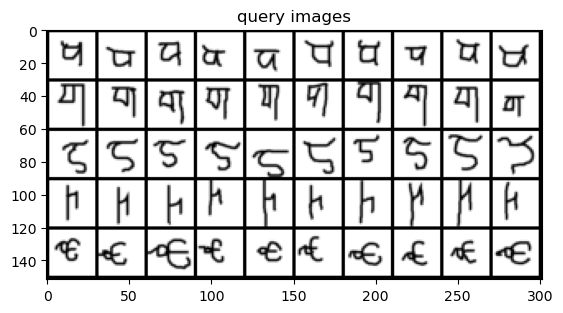

In [23]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [25]:
PYTORCH_ENABLE_MPS_FALLBACK=1

In [39]:
model.eval()
example_scores = model(
    example_support_images.to(device),
    example_support_labels.to(device),
    example_query_images.to(device),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{test_set._characters[example_class_ids[example_query_labels[i]]]} / {test_set._characters[example_class_ids[example_predicted_labels[i]]]}"
    )

support tensor([[1.0910, 0.9576, 0.6986,  ..., 0.0000, 0.7702, 0.0000],
        [0.9119, 0.5259, 0.5975,  ..., 0.0000, 0.0910, 0.0000],
        [0.9197, 0.3947, 0.7446,  ..., 0.0000, 0.1648, 0.0000],
        ...,
        [0.6895, 0.0000, 0.3383,  ..., 0.0000, 0.2691, 0.0000],
        [1.0301, 0.0000, 0.4268,  ..., 0.0000, 0.4101, 0.0000],
        [0.9840, 0.2163, 0.6384,  ..., 0.0000, 0.6167, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[1.3331, 0.7419, 0.5144,  ..., 0.0064, 0.0000, 0.0000],
        [0.8605, 0.7002, 0.9294,  ..., 0.0000, 0.2081, 0.0000],
        [1.2178, 1.2358, 0.8197,  ..., 0.0000, 0.0569, 0.0000],
        ...,
        [1.2711, 0.0000, 0.4529,  ..., 0.0000, 0.6217, 0.0000],
        [1.1461, 0.0000, 0.3692,  ..., 0.0000, 0.7434, 0.0000],
        [0.7688, 0.3089, 0.6007,  ..., 0.0000, 0.2737, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.9404, 0.8588, 0.8285,  ..., 0.0060, 0.0261, 0.0000],


In [41]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.to(device), support_labels.to(device), query_images.to(device))
            .detach()
            .data,
            1,
        )[1]
        == query_labels.to(device)
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(test_loader)

  0%|          | 0/100 [00:00<?, ?it/s]

support tensor([[0.7771, 0.1643, 0.5169,  ..., 0.0000, 0.8653, 0.0000],
        [0.8990, 0.0614, 0.4372,  ..., 0.0000, 1.0564, 0.0000],
        [1.0255, 0.0000, 0.4449,  ..., 0.0000, 0.8296, 0.0000],
        ...,
        [0.0000, 0.0616, 0.8896,  ..., 0.0000, 0.9087, 0.0000],
        [0.1053, 0.7509, 0.7683,  ..., 0.0000, 0.7827, 0.0000],
        [0.3763, 0.6121, 0.8018,  ..., 0.0000, 0.8025, 0.0000]],
       device='mps:0')
query tensor([[0.7388, 0.0000, 0.4750,  ..., 0.0000, 0.5960, 0.0000],
        [1.0494, 0.1772, 0.4384,  ..., 0.0000, 0.9694, 0.0000],
        [1.0670, 0.6322, 0.9809,  ..., 0.0000, 0.9423, 0.0000],
        ...,
        [0.1213, 1.5593, 1.8951,  ..., 0.0000, 0.4760, 0.0000],
        [0.2692, 0.0000, 0.5356,  ..., 0.0000, 0.7381, 0.0000],
        [0.0000, 0.9365, 1.0434,  ..., 0.0000, 0.3479, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[1.0283, 0.1664, 0.7041,  ..., 0.0000, 0.9555, 0.0000],
        [1.2416, 0.1262, 0.6468,  ..., 0.0000, 0.7871, 0.0000],
  

  2%|▏         | 2/100 [00:00<00:26,  3.74it/s]

support tensor([[1.0494, 0.0000, 0.5507,  ..., 0.0000, 0.7137, 0.0000],
        [0.8635, 0.0000, 0.3947,  ..., 0.0000, 0.7214, 0.0000],
        [0.7656, 0.0000, 0.2982,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.1598, 0.0000, 0.4262,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3366,  ..., 0.0000, 0.0000, 0.0000],
        [1.0833, 0.0000, 0.2880,  ..., 0.0000, 0.7435, 0.0000]],
       device='mps:0')
query tensor([[0.6943, 0.0000, 0.5644,  ..., 0.0000, 0.4821, 0.0000],
        [0.8174, 0.0000, 0.4038,  ..., 0.0000, 0.7514, 0.0000],
        [0.9188, 0.0000, 0.0362,  ..., 0.0000, 0.5076, 0.0000],
        ...,
        [1.1260, 0.0000, 0.4516,  ..., 0.0000, 0.2416, 0.0000],
        [0.0000, 0.0000, 0.4652,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5577,  ..., 0.0701, 0.0000, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[0.7993, 0.0000, 0.5137,  ..., 0.0000, 0.5314, 0.0000],
        [1.0637, 0.4477, 0.9977,  ..., 0.0000, 0.3568, 0.0000],
  

  4%|▍         | 4/100 [00:00<00:18,  5.32it/s]

tensor([[1.3864, 0.0000, 0.7483,  ..., 0.0000, 0.9651, 0.0000],
        [1.3478, 0.0000, 0.7021,  ..., 0.0000, 1.0037, 0.0000],
        [1.3901, 0.0000, 0.2665,  ..., 0.0000, 1.0945, 0.0000],
        ...,
        [0.3227, 0.0000, 0.3948,  ..., 0.0000, 0.0755, 0.0000],
        [0.9150, 0.0000, 0.3548,  ..., 0.0000, 0.7983, 0.0000],
        [0.0593, 0.0000, 0.4228,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[0.7254, 0.0000, 1.7332,  ..., 0.0000, 0.0284, 0.0000],
        [1.2637, 0.0000, 0.4065,  ..., 0.0000, 0.9881, 0.0000],
        [1.2479, 0.0733, 0.5916,  ..., 0.0000, 0.8443, 0.0000],
        [1.2260, 0.0061, 0.7101,  ..., 0.0000, 0.8883, 0.0000],
        [0.3133, 0.0000, 0.4127,  ..., 0.0000, 0.3580, 0.0000]],
       device='mps:0')
support tensor([[0.8877, 0.2026, 0.6197,  ..., 0.0000, 0.9509, 0.0000],
        [1.5376, 0.2062, 0.3095,  ..., 0.0000, 0.6534, 0.0000],
        [1.1154, 0.2399, 0.5277,  ..., 0.0000, 0.6240, 0.0000],
        ...,
        

  5%|▌         | 5/100 [00:01<00:16,  5.65it/s]

support tensor([[0.3943, 2.3939, 0.7896,  ..., 0.0000, 0.3177, 0.0000],
        [0.0000, 1.4389, 0.6636,  ..., 0.0000, 0.3534, 0.0000],
        [0.5262, 2.2966, 0.9237,  ..., 0.0000, 0.3981, 0.0000],
        ...,
        [0.9985, 0.0000, 0.5209,  ..., 0.0000, 0.0126, 0.0000],
        [0.8995, 0.0000, 0.4663,  ..., 0.0000, 0.2040, 0.0000],
        [1.0287, 0.0000, 0.5803,  ..., 0.0000, 0.0985, 0.0000]],
       device='mps:0')
query tensor([[0.0000, 1.8001, 0.7890,  ..., 0.0000, 0.2708, 0.0000],
        [0.2395, 1.5728, 0.8083,  ..., 0.0000, 0.2990, 0.0000],
        [0.4221, 1.8158, 0.6939,  ..., 0.0000, 0.1685, 0.0000],
        ...,
        [1.0585, 0.0000, 0.7408,  ..., 0.0000, 0.1687, 0.0000],
        [0.7907, 0.0000, 0.6365,  ..., 0.0000, 0.0184, 0.0000],
        [0.6324, 0.1723, 0.8565,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[0.2753, 1.7679, 0.7978,  ..., 0.0000, 0.3913, 0.0000],
        [1.0699, 0.0432, 0.6007,  ..., 0.0000, 0.1679, 0.0000],
  

  7%|▋         | 7/100 [00:01<00:13,  6.81it/s]

tensor([[1.0305, 0.0696, 0.7574,  ..., 0.0000, 1.0223, 0.0000],
        [0.4837, 0.1626, 0.9735,  ..., 0.0000, 0.2767, 0.0000],
        [0.8119, 0.0713, 0.9292,  ..., 0.0029, 0.0905, 0.0000],
        [0.6960, 0.4754, 0.2116,  ..., 0.0000, 0.0818, 0.0000],
        [1.1338, 0.9659, 1.0394,  ..., 0.0000, 0.1863, 0.0000]],
       device='mps:0')
support tensor([[1.0121, 2.2923, 1.7938,  ..., 0.0000, 0.1944, 0.0000],
        [0.8479, 1.9356, 2.0535,  ..., 0.0000, 0.0000, 0.0000],
        [0.9307, 1.7685, 1.0106,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [1.3222, 0.0000, 0.3372,  ..., 0.0000, 0.6986, 0.0000],
        [1.5204, 0.5122, 0.2952,  ..., 0.0000, 0.4371, 0.0000],
        [1.2661, 0.0000, 0.6203,  ..., 0.0000, 0.4994, 0.0000]],
       device='mps:0')
query tensor([[1.1267, 1.4937, 0.5533,  ..., 0.0000, 0.0848, 0.0000],
        [0.8576, 1.8472, 1.1710,  ..., 0.0000, 0.0000, 0.0000],
        [0.9752, 3.0134, 2.3846,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [1.0528,

  9%|▉         | 9/100 [00:01<00:11,  7.73it/s]

tensor([[1.3990, 0.4059, 0.6739,  ..., 0.0000, 0.3626, 0.0000],
        [1.1078, 0.6362, 0.3391,  ..., 0.0000, 0.1510, 0.0000],
        [1.0056, 1.3111, 0.3456,  ..., 0.3797, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.4550,  ..., 0.0000, 0.1735, 0.0000],
        [0.0955, 0.0000, 0.6170,  ..., 0.0000, 0.1631, 0.0000],
        [0.0000, 0.0000, 0.5127,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[0.8192, 0.6278, 0.6228,  ..., 0.0000, 0.0000, 0.0000],
        [0.6120, 0.0000, 0.5620,  ..., 0.0000, 0.1263, 0.0000],
        [1.3277, 0.4143, 0.5116,  ..., 0.0000, 0.2503, 0.0000],
        [1.1700, 0.2623, 0.8099,  ..., 0.0000, 0.3955, 0.0000],
        [1.0975, 0.0000, 0.7917,  ..., 0.0000, 0.8051, 0.0000]],
       device='mps:0')
support tensor([[0.0000, 2.1508, 4.1469,  ..., 0.0000, 0.2161, 0.0000],
        [0.4089, 2.6465, 3.1304,  ..., 0.0000, 0.1687, 0.0000],
        [0.1328, 0.8834, 2.2003,  ..., 0.0000, 0.0843, 0.0000],
        ...,
        

 11%|█         | 11/100 [00:01<00:11,  8.03it/s]

query tensor([[0.7801, 0.0000, 0.7837,  ..., 0.0000, 0.9493, 0.0000],
        [1.1934, 0.0000, 0.8149,  ..., 0.0000, 0.9282, 0.0000],
        [0.8613, 0.0000, 0.6142,  ..., 0.0000, 0.7902, 0.0000],
        ...,
        [0.7049, 0.0000, 0.4115,  ..., 0.0276, 0.1788, 0.0000],
        [0.9353, 0.1004, 0.4554,  ..., 0.0420, 0.5791, 0.0000],
        [0.8148, 0.0000, 0.3073,  ..., 0.0000, 0.4196, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[1.0113, 0.0890, 0.5205,  ..., 0.0000, 0.9948, 0.0000],
        [1.0566, 0.0516, 0.5192,  ..., 0.0000, 0.9352, 0.0000],
        [0.3894, 1.1721, 0.8971,  ..., 0.0000, 0.6681, 0.0000],
        [0.6196, 0.0800, 0.5202,  ..., 0.0128, 0.8513, 0.0000],
        [0.8736, 0.0876, 0.2386,  ..., 0.1564, 0.3434, 0.0000]],
       device='mps:0')
support tensor([[1.4338, 0.2111, 0.5555,  ..., 0.0000, 1.1502, 0.0000],
        [1.8274, 0.0032, 0.2351,  ..., 0.0783, 0.6118, 0.0000],
        [1.5531, 0.0000, 0.4391,  ..., 0.0000, 1.1138, 0.0000],
        ...,
  

 12%|█▏        | 12/100 [00:01<00:11,  7.57it/s]

support tensor([[0.2601, 0.0000, 0.7026,  ..., 0.0000, 0.1375, 0.0000],
        [1.6162, 0.0000, 0.2622,  ..., 0.0850, 0.7261, 0.0000],
        [0.9251, 0.0000, 0.5919,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.2943, 0.0000, 0.6429,  ..., 0.0000, 0.7436, 0.0000],
        [0.9723, 0.0000, 0.5669,  ..., 0.0000, 0.9744, 0.0000],
        [0.2644, 0.0000, 0.7406,  ..., 0.0000, 0.7585, 0.0000]],
       device='mps:0')
query tensor([[0.9376, 0.0000, 0.4605,  ..., 0.0000, 0.7044, 0.0000],
        [0.8270, 0.0000, 0.5726,  ..., 0.0000, 0.3868, 0.0000],
        [0.7571, 0.0000, 0.6152,  ..., 0.0000, 0.3256, 0.0000],
        ...,
        [0.2974, 0.0000, 0.5080,  ..., 0.0000, 0.5328, 0.0000],
        [0.9114, 0.0000, 0.5546,  ..., 0.0000, 0.9159, 0.0000],
        [1.8150, 0.0000, 0.3422,  ..., 0.0510, 0.9909, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[0.6295, 0.0000, 0.6386,  ..., 0.0000, 0.9021, 0.0000],
        [1.3031, 0.2025, 0.5615,  ..., 0.0000, 0.6153, 0.0000],
  

 14%|█▍        | 14/100 [00:02<00:11,  7.30it/s]

tensor([[0.6360, 0.0000, 2.2069,  ..., 0.0000, 0.1311, 0.0000],
        [1.1375, 0.4729, 0.8836,  ..., 0.0000, 0.4491, 0.0000],
        [0.7573, 0.0000, 0.3766,  ..., 0.0000, 0.1425, 0.0000],
        ...,
        [1.1248, 1.0448, 1.7029,  ..., 0.0000, 0.2330, 0.0000],
        [0.9454, 1.3755, 1.1896,  ..., 0.0000, 0.0000, 0.0000],
        [0.9210, 1.2555, 1.5332,  ..., 0.0000, 0.0342, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[1.1669, 0.7666, 0.7639,  ..., 0.0000, 0.5845, 0.0000],
        [1.0436, 0.1143, 0.7141,  ..., 0.0000, 0.4476, 0.0000],
        [1.1424, 0.7398, 0.6709,  ..., 0.0000, 0.0722, 0.0000],
        [0.7270, 0.2788, 1.8828,  ..., 0.0000, 0.3063, 0.0000],
        [0.8338, 0.5553, 1.3828,  ..., 0.2868, 0.0000, 0.0000]],
       device='mps:0')
support tensor([[1.0358, 0.0000, 0.5694,  ..., 0.0000, 0.4296, 0.0000],
        [0.2979, 0.0000, 0.5667,  ..., 0.0000, 0.0000, 0.0000],
        [0.7629, 0.0000, 0.4688,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        

 16%|█▌        | 16/100 [00:02<00:10,  8.02it/s]

support tensor([[1.1707, 0.3928, 0.6336,  ..., 0.0000, 0.1151, 0.0000],
        [0.9053, 0.0000, 0.4291,  ..., 0.0000, 0.2554, 0.0000],
        [1.1864, 0.0000, 0.0419,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [1.0313, 0.0000, 0.5967,  ..., 0.0000, 0.3768, 0.0000],
        [0.5110, 0.0000, 0.6443,  ..., 0.0000, 0.1568, 0.0000],
        [1.3124, 0.0000, 0.4247,  ..., 0.0000, 0.6485, 0.0000]],
       device='mps:0')
query tensor([[0.8398, 0.0000, 0.1707,  ..., 0.0000, 0.0000, 0.0000],
        [0.5844, 0.0000, 0.3795,  ..., 0.0000, 0.0000, 0.0000],
        [0.8763, 0.0000, 0.1159,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.9929, 0.0000, 0.4817,  ..., 0.0000, 0.3683, 0.0000],
        [1.4727, 0.0000, 0.2804,  ..., 0.0000, 0.3183, 0.0000],
        [0.9399, 0.0000, 0.7359,  ..., 0.0000, 0.3949, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[1.1131, 0.0044, 0.4579,  ..., 0.0000, 0.4285, 0.0000],
        [0.8501, 0.0786, 0.3699,  ..., 0.0000, 0.0741, 0.0000],
  

 18%|█▊        | 18/100 [00:02<00:10,  8.11it/s]

support tensor([[0.3799, 0.0000, 0.2963,  ..., 0.0000, 0.0000, 0.0000],
        [1.1419, 0.0000, 0.1680,  ..., 0.0000, 0.0000, 0.0000],
        [0.3901, 0.2311, 1.0393,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.8046, 0.0000, 0.6760,  ..., 0.0000, 0.1059, 0.0000],
        [0.4094, 0.2260, 0.8535,  ..., 0.0000, 0.4636, 0.0000],
        [0.4039, 0.1139, 0.6750,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
query tensor([[0.7671, 0.0000, 0.6639,  ..., 0.0000, 0.0000, 0.0000],
        [0.9906, 0.0000, 0.3306,  ..., 0.0000, 0.1280, 0.0000],
        [0.6616, 0.0000, 0.2427,  ..., 0.0000, 0.2075, 0.0000],
        ...,
        [0.5933, 0.0978, 0.5894,  ..., 0.0000, 0.4899, 0.0000],
        [0.2708, 0.0000, 0.2047,  ..., 0.0000, 0.0000, 0.0000],
        [0.4021, 0.0000, 0.8200,  ..., 0.0000, 0.4038, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[0.4870, 0.0000, 0.7581,  ..., 0.0000, 0.3142, 0.0000],
        [1.0675, 0.0000, 0.5454,  ..., 0.0000, 0.8880, 0.0000],
  

 20%|██        | 20/100 [00:02<00:09,  8.62it/s]

support tensor([[1.2190, 0.0000, 0.7089,  ..., 0.0000, 0.8588, 0.0000],
        [1.2521, 0.0000, 0.4678,  ..., 0.0710, 0.2702, 0.0000],
        [1.0972, 0.0000, 0.5431,  ..., 0.0000, 0.8397, 0.0000],
        ...,
        [0.2946, 0.4706, 1.6423,  ..., 0.0000, 0.0000, 0.0000],
        [0.0630, 1.8062, 2.1362,  ..., 0.0000, 0.3549, 0.0000],
        [0.5191, 0.3437, 2.4087,  ..., 0.0000, 0.4867, 0.0000]],
       device='mps:0')
query tensor([[0.9677, 0.0000, 0.6319,  ..., 0.0000, 0.6174, 0.0000],
        [1.3964, 0.7013, 0.5451,  ..., 0.0716, 0.3424, 0.0000],
        [0.9473, 0.0000, 0.7941,  ..., 0.0000, 1.1512, 0.0000],
        ...,
        [0.5434, 0.9569, 1.4502,  ..., 0.0000, 0.0000, 0.0000],
        [0.3794, 0.3096, 1.6610,  ..., 0.0000, 0.0000, 0.0000],
        [0.1005, 0.6410, 2.4454,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[1.2246, 0.0120, 0.6442,  ..., 0.0142, 0.7590, 0.0000],
        [0.3377, 0.7160, 1.9003,  ..., 0.0000, 0.2402, 0.0000],
  

 22%|██▏       | 22/100 [00:03<00:08,  8.72it/s]

support tensor([[0.8055, 0.0000, 0.4680,  ..., 0.0000, 0.0000, 0.0000],
        [1.4084, 0.0000, 0.6187,  ..., 0.0000, 0.1126, 0.0000],
        [0.8884, 0.0000, 0.7654,  ..., 0.0000, 0.1807, 0.0000],
        ...,
        [1.1032, 0.0857, 0.5116,  ..., 0.0000, 0.5890, 0.0000],
        [0.8480, 0.2779, 0.2921,  ..., 0.0451, 0.0000, 0.0000],
        [1.0003, 0.7869, 0.7355,  ..., 0.0000, 0.3158, 0.0000]],
       device='mps:0')
query tensor([[0.5742, 0.0000, 0.4960,  ..., 0.0000, 0.0000, 0.0000],
        [0.4347, 0.0000, 0.7738,  ..., 0.0000, 0.0000, 0.0000],
        [1.1731, 0.0000, 0.3211,  ..., 0.0000, 0.0029, 0.0000],
        ...,
        [1.2874, 1.3941, 0.7389,  ..., 0.0000, 0.6800, 0.0000],
        [0.8773, 1.5189, 2.1149,  ..., 0.0000, 0.0000, 0.0000],
        [1.0282, 0.1137, 0.6522,  ..., 0.0000, 0.3579, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[1.0270, 0.4230, 0.6381,  ..., 0.0090, 0.3647, 0.0000],
        [0.2876, 0.4380, 1.2559,  ..., 0.0845, 0.1102, 0.0000],
  

 24%|██▍       | 24/100 [00:03<00:08,  8.55it/s]

support tensor([[0.5910, 0.1613, 0.5223,  ..., 0.0000, 0.2061, 0.0000],
        [0.9501, 0.0000, 0.4492,  ..., 0.0000, 0.7941, 0.0000],
        [0.6393, 0.2406, 0.8932,  ..., 0.0000, 0.1961, 0.0000],
        ...,
        [0.2678, 0.7150, 1.8948,  ..., 0.0000, 0.4256, 0.0000],
        [0.8415, 1.6037, 2.0989,  ..., 0.0000, 0.0517, 0.0000],
        [1.1035, 1.1829, 0.6765,  ..., 0.0000, 0.1816, 0.0000]],
       device='mps:0')
query tensor([[0.7046, 0.0143, 0.7408,  ..., 0.0000, 0.6273, 0.0000],
        [0.9073, 0.0000, 0.5487,  ..., 0.0000, 0.5771, 0.0000],
        [0.5094, 0.0000, 0.6480,  ..., 0.0000, 0.2413, 0.0000],
        ...,
        [1.2518, 0.7178, 0.8880,  ..., 0.0292, 0.0000, 0.0000],
        [1.0727, 1.4227, 2.1335,  ..., 0.0000, 0.0288, 0.0000],
        [0.2840, 0.9814, 0.9780,  ..., 0.0000, 0.1567, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[0.0898, 0.1408, 0.6381,  ..., 0.0000, 0.2202, 0.0000],
        [0.7220, 1.1691, 1.4825,  ..., 0.0000, 0.2473, 0.0000],
  

 25%|██▌       | 25/100 [00:03<00:09,  8.01it/s]

support tensor([[1.0868, 0.0000, 0.2971,  ..., 0.0000, 0.6831, 0.0000],
        [1.2711, 0.0000, 0.4529,  ..., 0.0000, 0.6217, 0.0000],
        [1.3320, 0.1500, 0.4646,  ..., 0.0000, 0.7304, 0.0000],
        ...,
        [0.7189, 0.3477, 0.9460,  ..., 0.0000, 0.5060, 0.0000],
        [0.8585, 0.1276, 0.8930,  ..., 0.0000, 0.9637, 0.0000],
        [1.1128, 0.0000, 0.6710,  ..., 0.0000, 0.7948, 0.0000]],
       device='mps:0')
query tensor([[1.4250, 0.0000, 0.4103,  ..., 0.0000, 0.8526, 0.0000],
        [0.7688, 0.3089, 0.6007,  ..., 0.0000, 0.2737, 0.0000],
        [1.8558, 0.0000, 0.1084,  ..., 0.0000, 0.7846, 0.0000],
        ...,
        [0.8386, 1.0056, 0.8741,  ..., 0.1211, 0.2349, 0.0000],
        [0.4728, 0.0414, 0.6164,  ..., 0.0000, 0.7301, 0.0000],
        [0.4759, 0.8513, 2.0355,  ..., 0.0000, 0.5950, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[1.4798, 0.0518, 0.3165,  ..., 0.0000, 0.7845, 0.0000],
        [0.8934, 0.1949, 0.7214,  ..., 0.0318, 0.5826, 0.0000],
  

 27%|██▋       | 27/100 [00:03<00:08,  8.23it/s]

tensor([[0.7710, 0.1552, 0.6578,  ..., 0.0569, 0.6970, 0.0000],
        [0.7083, 0.8709, 1.0835,  ..., 0.0868, 0.0000, 0.0000],
        [0.7072, 2.0501, 1.3359,  ..., 0.0000, 0.1285, 0.0000],
        [0.7688, 0.0931, 0.5038,  ..., 0.0000, 0.8831, 0.0000],
        [1.2200, 0.0876, 0.4420,  ..., 0.0000, 0.3521, 0.0000]],
       device='mps:0')
support tensor([[0.8014, 0.8537, 1.0846,  ..., 0.0000, 0.8974, 0.0000],
        [1.0424, 0.0000, 0.9318,  ..., 0.0000, 0.7604, 0.0000],
        [1.3582, 0.0000, 0.5880,  ..., 0.0000, 0.6965, 0.0000],
        ...,
        [0.4433, 0.0000, 0.7342,  ..., 0.0000, 0.6232, 0.0000],
        [0.5939, 0.0000, 0.7485,  ..., 0.0000, 0.6208, 0.0000],
        [0.5853, 0.0000, 0.4197,  ..., 0.0000, 0.7062, 0.0000]],
       device='mps:0')
query tensor([[1.2302, 0.3473, 0.8905,  ..., 0.0000, 0.4088, 0.0000],
        [1.0349, 0.1537, 0.9587,  ..., 0.0000, 0.7774, 0.0000],
        [1.2787, 1.6130, 0.6656,  ..., 0.0000, 0.7826, 0.0000],
        ...,
        [0.4067,

 29%|██▉       | 29/100 [00:03<00:08,  8.57it/s]

tensor([[0.0773, 0.0000, 0.8762,  ..., 0.1782, 0.0000, 0.0000],
        [0.9929, 0.0000, 0.5054,  ..., 0.0000, 0.5579, 0.0000],
        [0.1600, 0.0000, 0.8237,  ..., 0.0000, 0.1547, 0.0000],
        ...,
        [1.4292, 1.8752, 0.6949,  ..., 0.0000, 0.4795, 0.0000],
        [1.1452, 0.6559, 1.2444,  ..., 0.0000, 0.9512, 0.0000],
        [0.7699, 1.3569, 0.9117,  ..., 0.0000, 0.8260, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[1.1163, 1.0925, 0.8972,  ..., 0.0000, 0.7038, 0.0000],
        [0.6168, 0.2626, 1.1988,  ..., 0.0000, 0.2576, 0.0000],
        [0.7796, 0.0050, 0.4895,  ..., 0.0000, 0.7746, 0.0000],
        [0.6318, 0.0835, 1.2803,  ..., 0.0000, 0.1890, 0.0000],
        [0.5260, 0.1639, 0.8214,  ..., 0.0000, 0.2554, 0.0000]],
       device='mps:0')
support tensor([[0.8460, 0.1145, 0.9114,  ..., 0.0000, 0.9388, 0.0000],
        [1.1554, 0.0000, 0.5944,  ..., 0.0000, 1.1016, 0.0000],
        [0.4739, 0.0000, 0.4157,  ..., 0.0000, 0.7521, 0.0000],
        ...,
        

 31%|███       | 31/100 [00:04<00:07,  8.68it/s]

query tensor([[0.7631, 1.3521, 0.9152,  ..., 0.0000, 0.3059, 0.0000],
        [0.2569, 0.2666, 1.6074,  ..., 0.0000, 0.0000, 0.0000],
        [1.2400, 1.7283, 1.2381,  ..., 0.0000, 0.2445, 0.0000],
        ...,
        [0.4745, 0.0000, 0.6808,  ..., 0.0000, 0.0000, 0.0000],
        [0.2390, 0.0000, 0.7689,  ..., 0.0000, 0.0481, 0.0000],
        [0.7404, 0.0000, 0.8514,  ..., 0.0000, 0.3814, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[0.3509, 0.0152, 0.7813,  ..., 0.0000, 0.0771, 0.0000],
        [0.7861, 1.1557, 1.3599,  ..., 0.0000, 0.0896, 0.0000],
        [0.4504, 0.0000, 0.6334,  ..., 0.0000, 0.2882, 0.0000],
        [0.3794, 1.5743, 2.9480,  ..., 0.0000, 0.1001, 0.0000],
        [0.7047, 0.0884, 0.6931,  ..., 0.0240, 0.4462, 0.0000]],
       device='mps:0')
support tensor([[1.3500, 0.0000, 0.5783,  ..., 0.0000, 0.8219, 0.0000],
        [1.1435, 0.0000, 0.7436,  ..., 0.0000, 0.9473, 0.0000],
        [0.3728, 0.0000, 0.6576,  ..., 0.0000, 0.6880, 0.0000],
        ...,
  

 33%|███▎      | 33/100 [00:04<00:07,  8.85it/s]

tensor([[0.7528, 0.0000, 0.5796,  ..., 0.0000, 0.0000, 0.0000],
        [0.7038, 0.0000, 0.5889,  ..., 0.0000, 0.0000, 0.0000],
        [0.8000, 0.0000, 0.4882,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [1.4531, 1.1824, 0.8327,  ..., 0.0000, 0.0985, 0.0000],
        [1.4582, 0.0000, 0.6806,  ..., 0.0000, 0.5499, 0.0000],
        [1.3785, 0.0000, 0.5373,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
query tensor([[0.9584, 0.0000, 0.5078,  ..., 0.0000, 0.0089, 0.0000],
        [1.7948, 0.0000, 0.4248,  ..., 0.0000, 0.3570, 0.0000],
        [0.8824, 0.0000, 0.4271,  ..., 0.0000, 0.2156, 0.0000],
        ...,
        [1.4255, 0.7083, 0.6118,  ..., 0.0000, 0.6568, 0.0000],
        [1.3442, 1.3383, 0.9294,  ..., 0.0000, 0.1493, 0.0000],
        [1.3548, 1.2449, 0.7848,  ..., 0.0000, 0.3413, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[1.5530, 0.0000, 0.3350,  ..., 0.0000, 0.7422, 0.0000],
        [0.2238, 0.0000, 0.7032,  ..., 0.0000, 0.1752, 0.0000],
        [0

 34%|███▍      | 34/100 [00:04<00:07,  8.28it/s]

support tensor([[1.1968, 0.6374, 0.4504,  ..., 0.0000, 0.8686, 0.0000],
        [0.6311, 0.5363, 1.3200,  ..., 0.0000, 0.5518, 0.0000],
        [0.7504, 0.6011, 1.0032,  ..., 0.0000, 0.5395, 0.0000],
        ...,
        [0.5310, 0.9721, 0.9330,  ..., 0.0000, 0.2072, 0.0000],
        [0.6613, 1.2560, 1.1161,  ..., 0.0000, 0.1215, 0.0000],
        [1.1011, 1.7885, 1.1877,  ..., 0.0000, 0.3263, 0.0000]],
       device='mps:0')
query tensor([[0.7117, 0.0000, 0.4211,  ..., 0.0000, 0.9286, 0.0000],
        [1.0821, 0.4889, 1.7078,  ..., 0.0000, 0.7402, 0.0000],
        [0.5523, 0.0000, 0.5635,  ..., 0.0000, 0.7024, 0.0000],
        ...,
        [0.8575, 1.0663, 0.8332,  ..., 0.0000, 0.0141, 0.0000],
        [0.4126, 1.2927, 1.2134,  ..., 0.0000, 0.0000, 0.0000],
        [0.1567, 0.4500, 0.8858,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[1.0804, 0.9140, 0.9580,  ..., 0.0044, 0.0000, 0.0000],
        [0.7512, 0.4216, 0.9551,  ..., 0.0000, 0.7567, 0.0000],
  

 36%|███▌      | 36/100 [00:04<00:08,  7.72it/s]

tensor([[1.0749e+00, 1.3535e+00, 9.2067e-01,  ..., 0.0000e+00, 7.4833e-01,
         0.0000e+00],
        [8.0692e-01, 5.9334e-01, 6.8601e-01,  ..., 1.5629e-01, 7.1944e-02,
         0.0000e+00],
        [8.3919e-01, 2.8327e-01, 6.2260e-01,  ..., 1.1076e-03, 6.8390e-01,
         0.0000e+00],
        [1.1691e+00, 0.0000e+00, 3.9195e-01,  ..., 0.0000e+00, 9.1300e-01,
         0.0000e+00],
        [1.2337e+00, 0.0000e+00, 3.9576e-01,  ..., 0.0000e+00, 4.8264e-01,
         0.0000e+00]], device='mps:0')
support tensor([[1.2190, 0.0000, 0.3795,  ..., 0.0879, 0.0000, 0.0000],
        [2.0327, 0.0000, 0.2126,  ..., 0.0000, 0.9108, 0.0000],
        [1.0510, 0.0000, 0.1448,  ..., 0.0000, 0.5868, 0.0000],
        ...,
        [0.6597, 0.4691, 0.7515,  ..., 0.0000, 0.0000, 0.0000],
        [0.7338, 1.5030, 1.8354,  ..., 0.0000, 0.3649, 0.0000],
        [0.6051, 0.9332, 0.9546,  ..., 0.0000, 0.2260, 0.0000]],
       device='mps:0')
query tensor([[0.8618, 0.0000, 0.6820,  ..., 0.0000, 0.8339, 0.0000],

 37%|███▋      | 37/100 [00:04<00:08,  7.53it/s]

support tensor([[0.6909, 0.4336, 2.4461,  ..., 0.0000, 0.0000, 0.0000],
        [0.9324, 1.1972, 2.1292,  ..., 0.0000, 0.0000, 0.0000],
        [0.6770, 1.5515, 1.9723,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.9730, 0.0888, 0.5092,  ..., 0.0000, 0.0516, 0.0000],
        [0.5739, 1.3934, 1.4547,  ..., 0.0000, 0.1262, 0.0000],
        [0.3802, 0.3330, 0.4637,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
query tensor([[1.2596, 1.3192, 1.1580,  ..., 0.0000, 0.0773, 0.0000],
        [0.8645, 1.2927, 3.0817,  ..., 0.0000, 0.0000, 0.0000],
        [1.3664, 1.5570, 1.2272,  ..., 0.0000, 0.2632, 0.0000],
        ...,
        [1.2689, 0.1053, 0.7639,  ..., 0.0000, 0.3525, 0.0000],
        [1.0286, 0.3961, 1.0203,  ..., 0.0000, 0.0000, 0.0000],
        [0.5935, 0.0983, 0.7209,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[0.1526, 0.0000, 0.1926,  ..., 0.0042, 0.0000, 0.0000],
        [0.7415, 0.3630, 0.7064,  ..., 0.0000, 0.1112, 0.0000],
  

 39%|███▉      | 39/100 [00:05<00:08,  7.36it/s]

proto tensor([[4.1839e-01, 7.7816e-01, 2.0393e+00,  ..., 1.4574e-01, 1.2534e-03,
         0.0000e+00],
        [1.1585e+00, 3.3854e-01, 5.6266e-01,  ..., 0.0000e+00, 6.5048e-01,
         0.0000e+00],
        [1.0939e+00, 2.1662e-01, 5.8481e-01,  ..., 0.0000e+00, 9.0206e-01,
         0.0000e+00],
        [1.0699e+00, 2.6563e-02, 6.6940e-01,  ..., 0.0000e+00, 3.9517e-01,
         0.0000e+00],
        [6.4873e-01, 1.6956e-01, 7.0779e-01,  ..., 0.0000e+00, 2.5887e-01,
         0.0000e+00]], device='mps:0')
support tensor([[1.7257, 0.0000, 0.4928,  ..., 0.0000, 0.8198, 0.0000],
        [1.2553, 0.0000, 0.6690,  ..., 0.0000, 0.6646, 0.0000],
        [0.6377, 0.0000, 0.7857,  ..., 0.0000, 0.0931, 0.0000],
        ...,
        [1.1906, 0.0000, 0.5085,  ..., 0.0000, 0.7776, 0.0000],
        [1.3576, 0.0000, 0.2589,  ..., 0.0000, 0.5148, 0.0000],
        [1.7119, 0.0000, 0.0311,  ..., 0.0000, 0.5414, 0.0000]],
       device='mps:0')
query tensor([[1.5804, 0.0000, 0.4629,  ..., 0.0000, 0.7400, 0.

 40%|████      | 40/100 [00:05<00:07,  7.53it/s]

support tensor([[1.2265, 0.0000, 0.5330,  ..., 0.0000, 0.5305, 0.0000],
        [1.2111, 0.3087, 0.3312,  ..., 0.0000, 0.6143, 0.0000],
        [0.9075, 0.2482, 0.5582,  ..., 0.0000, 0.7622, 0.0000],
        ...,
        [1.7463, 0.0000, 0.4499,  ..., 0.0000, 0.6897, 0.0000],
        [1.4892, 0.0000, 0.5827,  ..., 0.0000, 0.3229, 0.0000],
        [1.5580, 0.0000, 0.1936,  ..., 0.0023, 0.2903, 0.0000]],
       device='mps:0')
query tensor([[1.3355, 0.0000, 0.0451,  ..., 0.0000, 0.6682, 0.0000],
        [1.0886, 0.3583, 0.6611,  ..., 0.0000, 0.7991, 0.0000],
        [1.6141, 0.0157, 0.2427,  ..., 0.0000, 0.9018, 0.0000],
        ...,
        [1.6645, 0.0000, 0.4990,  ..., 0.0000, 0.3933, 0.0000],
        [1.4835, 0.0000, 0.5766,  ..., 0.0000, 0.8138, 0.0000],
        [1.1960, 0.0000, 0.9502,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[6.9475e-01, 1.1565e+00, 1.4528e+00,  ..., 0.0000e+00, 3.9581e-01,
         0.0000e+00],
        [1.2711e-01, 2.2427e+00, 

 42%|████▏     | 42/100 [00:05<00:07,  7.70it/s]

tensor([[0.6113, 0.2857, 0.7570,  ..., 0.0000, 0.0633, 0.0000],
        [1.2060, 0.0000, 0.2361,  ..., 0.0000, 0.5884, 0.0000],
        [1.0615, 1.5705, 0.8142,  ..., 0.0000, 0.6603, 0.0000],
        [0.8722, 0.4218, 1.4904,  ..., 0.0000, 0.0782, 0.0000],
        [1.2706, 0.3477, 0.3892,  ..., 0.0000, 0.1575, 0.0000]],
       device='mps:0')
support tensor([[0.3398, 0.0478, 0.9709,  ..., 0.0000, 0.2253, 0.0000],
        [0.3578, 0.5219, 1.0424,  ..., 0.0000, 0.4451, 0.0000],
        [0.0130, 0.1159, 0.9262,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [1.2754, 0.0000, 0.1549,  ..., 0.0000, 0.4907, 0.0000],
        [1.3881, 0.1996, 0.4308,  ..., 0.0000, 0.7359, 0.0000],
        [1.2426, 0.0000, 0.4731,  ..., 0.0000, 1.0653, 0.0000]],
       device='mps:0')
query tensor([[0.0617, 0.9847, 1.4561,  ..., 0.0000, 0.2456, 0.0000],
        [0.0000, 0.1410, 0.6105,  ..., 0.0000, 0.1482, 0.0000],
        [0.5566, 0.0000, 0.7861,  ..., 0.0000, 0.4024, 0.0000],
        ...,
        [1.1261,

 44%|████▍     | 44/100 [00:05<00:06,  8.06it/s]

tensor([[0.0000, 0.0000, 0.5015,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.1786,  ..., 0.0432, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4132,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [1.0190, 1.5564, 1.0880,  ..., 0.0000, 0.2198, 0.0000],
        [0.6064, 1.3537, 2.4037,  ..., 0.0000, 0.0000, 0.0000],
        [0.7945, 0.0000, 0.4519,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[1.0315, 0.4268, 0.4067,  ..., 0.0000, 0.7053, 0.0000],
        [0.9676, 1.1781, 1.0979,  ..., 0.0000, 0.2435, 0.0000],
        [0.2670, 0.0000, 0.7051,  ..., 0.0091, 0.1958, 0.0000],
        [0.0746, 0.0977, 0.6844,  ..., 0.0742, 0.3197, 0.0000],
        [1.2425, 0.0000, 0.5951,  ..., 0.0000, 0.6243, 0.0000]],
       device='mps:0')
support tensor([[1.2190, 0.2701, 0.9911,  ..., 0.0000, 0.6756, 0.0000],
        [1.3768, 0.3322, 0.6382,  ..., 0.0000, 0.5063, 0.0000],
        [0.8556, 0.2711, 0.8261,  ..., 0.0000, 0.5150, 0.0000],
        ...,
        

 46%|████▌     | 46/100 [00:06<00:06,  8.43it/s]

query tensor([[0.0000, 0.0000, 0.8646,  ..., 0.0000, 0.0000, 0.0000],
        [0.3557, 0.0000, 0.4802,  ..., 0.0000, 0.0000, 0.0000],
        [0.5654, 0.0000, 0.5689,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 1.3539, 0.6902,  ..., 0.0000, 0.6353, 0.0000],
        [0.8947, 0.6642, 0.3636,  ..., 0.0000, 0.5955, 0.0000],
        [0.6677, 0.1583, 0.3144,  ..., 0.0000, 0.7337, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[0.0498, 0.0000, 0.5615,  ..., 0.0000, 0.0000, 0.0000],
        [0.4582, 0.4639, 0.5630,  ..., 0.0056, 0.6492, 0.0000],
        [1.3861, 0.5429, 0.5442,  ..., 0.0000, 0.4559, 0.0000],
        [1.1434, 1.6788, 1.0587,  ..., 0.0000, 0.0220, 0.0000],
        [0.8485, 0.2421, 0.6225,  ..., 0.0000, 0.4104, 0.0000]],
       device='mps:0')
support tensor([[0.9398, 0.0000, 0.4786,  ..., 0.0000, 0.0000, 0.0000],
        [1.1557, 0.0000, 0.1817,  ..., 0.0000, 0.0000, 0.0000],
        [1.0434, 0.0000, 0.6203,  ..., 0.0000, 0.0196, 0.0000],
        ...,
  

 48%|████▊     | 48/100 [00:06<00:05,  8.70it/s]

support tensor([[0.2934, 0.0000, 0.3088,  ..., 0.0000, 0.0000, 0.0000],
        [0.4244, 0.2077, 0.3822,  ..., 0.0000, 0.0507, 0.0000],
        [0.7590, 0.0000, 0.5701,  ..., 0.0000, 0.0692, 0.0000],
        ...,
        [1.0086, 0.0000, 0.6200,  ..., 0.0000, 0.7314, 0.0000],
        [1.4015, 0.0000, 0.5790,  ..., 0.0000, 0.2371, 0.0000],
        [0.9451, 0.0000, 0.4352,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
query tensor([[0.9837, 0.5555, 0.2283,  ..., 0.1970, 0.0000, 0.0000],
        [1.0083, 0.1575, 0.6359,  ..., 0.0000, 0.0204, 0.0000],
        [0.6205, 0.8527, 0.6026,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.7512, 0.0000, 1.0756,  ..., 0.0000, 0.4142, 0.0000],
        [1.0079, 0.0000, 0.5970,  ..., 0.0000, 0.5610, 0.0000],
        [1.5323, 0.0000, 0.5263,  ..., 0.0000, 1.1219, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[1.0627, 0.0000, 0.5617,  ..., 0.0000, 0.3849, 0.0000],
        [0.6495, 0.0000, 0.6291,  ..., 0.0000, 0.3512, 0.0000],
  

 50%|█████     | 50/100 [00:06<00:05,  8.52it/s]

support tensor([[0.5660, 0.1583, 0.8222,  ..., 0.0000, 0.4713, 0.0000],
        [0.9564, 0.3738, 0.6848,  ..., 0.0000, 1.0042, 0.0000],
        [0.8312, 0.0000, 1.0526,  ..., 0.0000, 0.8401, 0.0000],
        ...,
        [1.2259, 1.2342, 0.9087,  ..., 0.0000, 0.7319, 0.0000],
        [0.7018, 0.6931, 0.7349,  ..., 0.0881, 0.2035, 0.0000],
        [1.2496, 0.7059, 0.5970,  ..., 0.0000, 1.1806, 0.0000]],
       device='mps:0')
query tensor([[1.1785, 0.0881, 0.5408,  ..., 0.0000, 0.3019, 0.0000],
        [0.9111, 0.0000, 0.2020,  ..., 0.0000, 0.0388, 0.0000],
        [0.7246, 1.3577, 1.4067,  ..., 0.0000, 0.8490, 0.0000],
        ...,
        [1.0276, 0.4417, 0.8470,  ..., 0.0000, 0.7646, 0.0000],
        [0.7078, 0.5743, 0.9637,  ..., 0.0000, 0.4739, 0.0000],
        [0.9044, 0.5411, 0.8805,  ..., 0.0000, 0.7514, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[1.0085, 0.9608, 1.0054,  ..., 0.0176, 0.6930, 0.0000],
        [1.0256, 0.1917, 0.6920,  ..., 0.0137, 0.3205, 0.0000],
  

 51%|█████     | 51/100 [00:06<00:06,  7.88it/s]

support tensor([[0.2369, 0.0000, 0.5350,  ..., 0.0000, 0.0000, 0.0000],
        [0.5573, 0.0000, 0.3456,  ..., 0.0000, 0.0000, 0.0000],
        [0.2550, 0.0000, 0.6798,  ..., 0.0000, 0.2024, 0.0000],
        ...,
        [0.3205, 0.0632, 0.5145,  ..., 0.0000, 0.8223, 0.0000],
        [0.5408, 1.1184, 1.0123,  ..., 0.0000, 0.4720, 0.0000],
        [0.8659, 0.0000, 0.6344,  ..., 0.0000, 1.0223, 0.0000]],
       device='mps:0')
query tensor([[0.1914, 0.0000, 0.3727,  ..., 0.0000, 0.0000, 0.0000],
        [0.2097, 0.0000, 0.4947,  ..., 0.0000, 0.0000, 0.0000],
        [0.3927, 0.0000, 0.3489,  ..., 0.0000, 0.2608, 0.0000],
        ...,
        [0.4446, 0.0000, 0.9396,  ..., 0.0000, 0.8860, 0.0000],
        [0.1866, 0.5788, 0.9407,  ..., 0.0000, 0.6168, 0.0000],
        [0.4998, 0.5010, 1.1605,  ..., 0.0000, 0.7708, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[1.0628, 1.2550, 1.1133,  ..., 0.0000, 0.1150, 0.0000],
        [0.6362, 0.4080, 0.5803,  ..., 0.0000, 0.4597, 0.0000],
  

 53%|█████▎    | 53/100 [00:06<00:06,  7.34it/s]

tensor([[0.9978, 0.9973, 2.0331,  ..., 0.0000, 0.0000, 0.0000],
        [0.0652, 0.8912, 2.7611,  ..., 0.0000, 0.0000, 0.0000],
        [0.2167, 0.9251, 3.2424,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.7776, 0.0000, 0.5998,  ..., 0.0000, 0.9720, 0.0000],
        [0.3852, 0.0000, 0.4463,  ..., 0.0000, 0.7685, 0.0000],
        [0.5681, 0.0000, 0.4293,  ..., 0.0000, 0.5043, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[0.7386, 0.7350, 1.1033,  ..., 0.0137, 0.0095, 0.0000],
        [0.3098, 0.2272, 1.1963,  ..., 0.0280, 0.0438, 0.0000],
        [1.0560, 0.5486, 0.6055,  ..., 0.0182, 0.5005, 0.0000],
        [0.4495, 0.3960, 1.3693,  ..., 0.0000, 0.0864, 0.0000],
        [1.0716, 0.0016, 0.3287,  ..., 0.0000, 0.9116, 0.0000]],
       device='mps:0')
support tensor([[0.5467, 0.5398, 1.2405,  ..., 0.0000, 0.1714, 0.0000],
        [0.7299, 0.4289, 1.7265,  ..., 0.0000, 0.3045, 0.0000],
        [0.0516, 0.0000, 1.5056,  ..., 0.0000, 0.0238, 0.0000],
        ...,
        

 54%|█████▍    | 54/100 [00:07<00:05,  7.76it/s]

support tensor([[0.8462, 0.0000, 0.5038,  ..., 0.0000, 0.2311, 0.0000],
        [0.5572, 0.3441, 1.7438,  ..., 0.0000, 0.2172, 0.0000],
        [0.9694, 0.0000, 0.6580,  ..., 0.0000, 0.6594, 0.0000],
        ...,
        [0.2982, 0.0000, 0.4057,  ..., 0.0000, 0.0000, 0.0000],
        [0.3313, 0.0000, 0.5020,  ..., 0.0000, 0.3861, 0.0000],
        [0.0000, 0.0000, 0.3452,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
query tensor([[0.6523, 0.0000, 0.6579,  ..., 0.0022, 0.0722, 0.0000],
        [0.1716, 0.0000, 0.9916,  ..., 0.0000, 0.6500, 0.0000],
        [0.2533, 0.0000, 0.6221,  ..., 0.0731, 0.1665, 0.0000],
        ...,
        [0.2550, 0.0000, 0.6798,  ..., 0.0000, 0.2024, 0.0000],
        [0.6211, 0.0000, 0.3698,  ..., 0.0000, 0.1732, 0.0000],
        [0.9172, 0.0000, 0.4008,  ..., 0.0000, 0.7650, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[0.6812, 0.9421, 1.4481,  ..., 0.0000, 0.2277, 0.0000],
        [0.2571, 0.0000, 0.3866,  ..., 0.0000, 0.1294, 0.0000],
  

 56%|█████▌    | 56/100 [00:07<00:05,  7.43it/s]

tensor([[1.1742, 0.0044, 0.4201,  ..., 0.0000, 0.7400, 0.0000],
        [0.6546, 0.1655, 0.8720,  ..., 0.0321, 0.4314, 0.0000],
        [1.2980, 0.0338, 0.2986,  ..., 0.0000, 0.7896, 0.0000],
        [0.6470, 0.0000, 0.6612,  ..., 0.0000, 0.2421, 0.0000],
        [1.0000, 0.2624, 0.5457,  ..., 0.0000, 0.6107, 0.0000]],
       device='mps:0')
support tensor([[0.9628, 0.5244, 0.6053,  ..., 0.0000, 1.0675, 0.0000],
        [1.1369, 0.4969, 0.6727,  ..., 0.0000, 1.0682, 0.0000],
        [0.9229, 0.1072, 0.4895,  ..., 0.0000, 0.9405, 0.0000],
        ...,
        [1.3003, 0.8664, 0.6122,  ..., 0.0000, 0.4466, 0.0000],
        [0.9079, 0.0000, 0.8110,  ..., 0.0000, 0.3265, 0.0000],
        [1.2868, 0.9648, 0.7596,  ..., 0.0000, 0.7251, 0.0000]],
       device='mps:0')
query tensor([[0.7208, 0.9836, 0.9670,  ..., 0.0000, 0.9680, 0.0000],
        [0.6201, 0.2877, 0.8867,  ..., 0.0000, 1.1169, 0.0000],
        [1.4966, 0.0000, 0.0000,  ..., 0.0000, 0.6337, 0.0000],
        ...,
        [1.3439,

 58%|█████▊    | 58/100 [00:07<00:05,  8.07it/s]

tensor([[1.4411, 0.0000, 0.2932,  ..., 0.0000, 0.9229, 0.0000],
        [1.0874, 0.0000, 0.3807,  ..., 0.0000, 0.8923, 0.0000],
        [0.9280, 0.1512, 0.7349,  ..., 0.0000, 0.6664, 0.0000],
        ...,
        [1.0750, 2.1901, 2.6033,  ..., 0.0000, 0.5924, 0.0000],
        [0.8141, 1.7057, 1.9280,  ..., 0.0000, 0.1754, 0.0000],
        [0.6037, 0.6390, 1.2913,  ..., 0.0091, 0.0643, 0.0000]],
       device='mps:0')
query tensor([[1.1987, 0.0000, 0.6086,  ..., 0.0000, 1.3020, 0.0000],
        [1.3536, 0.0000, 0.2908,  ..., 0.0000, 0.9263, 0.0000],
        [0.2681, 0.0000, 0.3392,  ..., 0.0000, 0.0739, 0.0000],
        ...,
        [1.0733, 0.0000, 0.6119,  ..., 0.0000, 0.5310, 0.0000],
        [0.9889, 0.1604, 1.1757,  ..., 0.0000, 0.1733, 0.0000],
        [0.7447, 0.0000, 0.8979,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[7.5243e-01, 4.4561e-05, 9.6128e-01,  ..., 0.0000e+00, 7.3388e-01,
         0.0000e+00],
        [1.0953e+00, 3.2398e-02, 7.7009e-

 59%|█████▉    | 59/100 [00:07<00:05,  8.00it/s]

support tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.4645, 0.0000, 0.1906,  ..., 0.0000, 0.0049, 0.0000],
        [0.2296, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [1.3850, 1.8080, 0.6896,  ..., 0.0000, 0.7233, 0.0000],
        [0.3341, 1.7653, 1.5286,  ..., 0.0000, 0.3780, 0.0000],
        [1.4585, 1.6190, 0.6501,  ..., 0.0000, 0.7458, 0.0000]],
       device='mps:0')
query tensor([[0.3116, 0.0000, 0.0739,  ..., 0.0000, 0.0000, 0.0000],
        [0.1860, 0.0000, 0.0095,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1983,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.5013, 1.8600, 1.6661,  ..., 0.0000, 0.5087, 0.0000],
        [1.1800, 1.6292, 0.5648,  ..., 0.0000, 0.5660, 0.0000],
        [1.0114, 1.2567, 0.5292,  ..., 0.0000, 0.3809, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[2.1664e-01, 0.0000e+00, 8.5012e-01,  ..., 1.4782e-02, 9.9303e-02,
         0.0000e+00],
        [1.4811e-01, 0.0000e+00, 

 61%|██████    | 61/100 [00:08<00:05,  7.55it/s]

tensor([[1.4950, 0.6159, 0.4837,  ..., 0.0000, 0.8715, 0.0000],
        [1.7138, 0.1497, 0.4235,  ..., 0.0000, 0.8221, 0.0000],
        [1.7953, 0.0382, 0.3575,  ..., 0.0000, 0.7147, 0.0000],
        ...,
        [0.1819, 0.0000, 0.4025,  ..., 0.0000, 0.0000, 0.0000],
        [1.1359, 0.0000, 0.6136,  ..., 0.0000, 0.5913, 0.0000],
        [1.4588, 0.0000, 0.9606,  ..., 0.0000, 0.6107, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[0.4809, 0.3978, 0.9970,  ..., 0.0000, 0.3293, 0.0000],
        [1.7277, 0.4108, 0.3609,  ..., 0.0000, 0.7746, 0.0000],
        [1.2670, 0.1262, 0.6176,  ..., 0.0000, 0.7404, 0.0000],
        [1.2218, 0.0000, 0.5986,  ..., 0.0000, 0.5424, 0.0000],
        [0.8904, 0.2384, 0.5602,  ..., 0.0000, 0.6874, 0.0000]],
       device='mps:0')
support tensor([[0.6485, 0.0000, 0.8259,  ..., 0.0000, 1.0736, 0.0000],
        [1.4152, 0.0000, 0.3495,  ..., 0.0000, 1.0392, 0.0000],
        [0.9941, 0.0000, 0.6543,  ..., 0.0000, 0.8931, 0.0000],
        ...,
        

 63%|██████▎   | 63/100 [00:08<00:04,  8.19it/s]

tensor([[0.2534, 0.0000, 0.7441,  ..., 0.0000, 0.3931, 0.0000],
        [0.0000, 0.0000, 0.5326,  ..., 0.0000, 0.0000, 0.0000],
        [0.1831, 0.0000, 0.3530,  ..., 0.0000, 0.1109, 0.0000],
        ...,
        [1.5292, 0.0000, 0.7211,  ..., 0.0000, 1.2013, 0.0000],
        [1.1717, 0.0000, 0.5658,  ..., 0.0000, 0.8541, 0.0000],
        [0.3853, 0.0000, 0.7883,  ..., 0.0000, 0.4126, 0.0000]],
       device='mps:0')
query tensor([[0.0199, 0.0000, 0.3472,  ..., 0.0000, 0.1014, 0.0000],
        [0.6700, 0.0000, 0.2582,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5505,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [1.0006, 0.0000, 0.7289,  ..., 0.0000, 0.6849, 0.0000],
        [1.0940, 0.0000, 0.7249,  ..., 0.0000, 0.6748, 0.0000],
        [1.1583, 0.2510, 0.8947,  ..., 0.0000, 0.7495, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[0.4251, 1.7961, 0.9662,  ..., 0.0000, 0.4035, 0.0000],
        [1.1238, 0.0000, 0.6775,  ..., 0.0000, 0.7972, 0.0000],
        [0

 65%|██████▌   | 65/100 [00:08<00:04,  8.46it/s]

support tensor([[1.8855, 0.0000, 0.1187,  ..., 0.0000, 0.5652, 0.0000],
        [1.6183, 0.2730, 0.2034,  ..., 0.0000, 0.7419, 0.0000],
        [1.3743, 0.5640, 0.5211,  ..., 0.0000, 0.5524, 0.0000],
        ...,
        [0.0711, 0.5028, 0.9004,  ..., 0.0000, 0.0000, 0.0000],
        [0.3980, 0.0000, 0.7431,  ..., 0.0000, 0.1904, 0.0000],
        [0.2547, 0.0000, 0.1431,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
query tensor([[1.4699, 0.0000, 0.1013,  ..., 0.0000, 0.1515, 0.0000],
        [1.1717, 0.0000, 0.7166,  ..., 0.0000, 1.1950, 0.0000],
        [1.4976, 0.0000, 0.3264,  ..., 0.0000, 0.7058, 0.0000],
        ...,
        [0.0696, 0.3192, 1.0711,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6546, 0.8482,  ..., 0.0000, 0.0000, 0.0000],
        [0.3143, 0.0000, 0.6723,  ..., 0.0000, 0.1181, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[1.4932, 0.2744, 0.2742,  ..., 0.0000, 0.5266, 0.0000],
        [1.0083, 0.0000, 0.5556,  ..., 0.0000, 0.5272, 0.0000],
  

 66%|██████▌   | 66/100 [00:08<00:04,  8.33it/s]

support tensor([[1.4067, 0.0000, 0.5573,  ..., 0.0000, 1.1257, 0.0000],
        [1.4385, 0.0000, 0.5621,  ..., 0.0000, 1.2320, 0.0000],
        [1.0980, 0.0000, 0.4807,  ..., 0.0000, 0.8320, 0.0000],
        ...,
        [0.4096, 0.0000, 0.9441,  ..., 0.0000, 0.0642, 0.0000],
        [0.7053, 0.2839, 1.0260,  ..., 0.0000, 0.2083, 0.0000],
        [0.1680, 0.0000, 0.8443,  ..., 0.0000, 0.0918, 0.0000]],
       device='mps:0')
query tensor([[1.1075, 0.0000, 0.5613,  ..., 0.0000, 0.9878, 0.0000],
        [1.1003, 0.0175, 0.7860,  ..., 0.0000, 1.2379, 0.0000],
        [1.5377, 0.0000, 0.3847,  ..., 0.0000, 0.8452, 0.0000],
        ...,
        [0.7173, 0.0000, 1.1756,  ..., 0.0000, 0.0950, 0.0000],
        [0.6928, 0.3836, 1.0550,  ..., 0.0000, 0.1837, 0.0000],
        [0.7062, 0.1910, 1.2436,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[5.5854e-01, 0.0000e+00, 8.1661e-01,  ..., 0.0000e+00, 8.3040e-04,
         0.0000e+00],
        [1.3277e+00, 0.0000e+00, 

 68%|██████▊   | 68/100 [00:08<00:04,  7.38it/s]

tensor([[0.7265, 0.2467, 0.9342,  ..., 0.0000, 0.3724, 0.0000],
        [1.1827, 0.0000, 0.4562,  ..., 0.0000, 0.5620, 0.0000],
        [0.6154, 0.1267, 0.7421,  ..., 0.0321, 0.4470, 0.0000],
        [1.2561, 0.1002, 0.7730,  ..., 0.0000, 0.7838, 0.0000],
        [0.3587, 0.5694, 0.8751,  ..., 0.0000, 0.6973, 0.0000]],
       device='mps:0')
support tensor([[1.0078, 0.0000, 0.6650,  ..., 0.0000, 0.8364, 0.0000],
        [1.0953, 0.0000, 0.3462,  ..., 0.0889, 0.5894, 0.0000],
        [1.0814, 0.0000, 1.5852,  ..., 0.0000, 0.3626, 0.0000],
        ...,
        [0.0000, 0.0000, 0.5969,  ..., 0.0000, 0.0877, 0.0000],
        [0.0000, 0.0000, 0.5840,  ..., 0.0000, 0.0000, 0.0000],
        [0.4053, 0.0000, 0.1947,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
query tensor([[0.8028, 0.0000, 0.4506,  ..., 0.0000, 0.2716, 0.0000],
        [0.6494, 0.0000, 0.5286,  ..., 0.0000, 0.5884, 0.0000],
        [0.9734, 0.0000, 0.4620,  ..., 0.0000, 0.4207, 0.0000],
        ...,
        [0.0941,

 69%|██████▉   | 69/100 [00:09<00:04,  7.18it/s]

support tensor([[0.9501, 0.8285, 0.6568,  ..., 0.0000, 0.2412, 0.0000],
        [1.4856, 1.3121, 0.7741,  ..., 0.1057, 0.1262, 0.0000],
        [0.4024, 0.3154, 0.6136,  ..., 0.0000, 0.5678, 0.0000],
        ...,
        [0.2619, 0.0403, 0.7091,  ..., 0.0000, 0.6123, 0.0000],
        [0.8220, 0.8797, 1.0924,  ..., 0.0000, 1.0343, 0.0000],
        [0.9373, 0.0000, 0.1561,  ..., 0.0000, 0.5183, 0.0000]],
       device='mps:0')
query tensor([[0.6857, 0.0000, 0.2550,  ..., 0.0000, 0.4055, 0.0000],
        [0.0341, 0.0000, 0.5834,  ..., 0.0000, 0.1778, 0.0000],
        [0.6357, 0.1158, 0.8940,  ..., 0.0000, 0.4251, 0.0000],
        ...,
        [0.3575, 0.6012, 0.8153,  ..., 0.0000, 0.4814, 0.0000],
        [1.0053, 0.0000, 0.3023,  ..., 0.0000, 0.7965, 0.0000],
        [0.4482, 0.1525, 0.8743,  ..., 0.0000, 0.8156, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[1.2118, 0.0664, 0.3850,  ..., 0.0000, 0.7244, 0.0000],
        [0.7332, 0.5340, 0.6174,  ..., 0.0275, 0.2796, 0.0000],
  

 71%|███████   | 71/100 [00:09<00:03,  7.83it/s]

tensor([[0.1935, 1.1023, 2.3140,  ..., 0.0000, 0.3171, 0.0000],
        [0.9409, 0.0000, 0.5255,  ..., 0.0000, 0.9170, 0.0000],
        [0.9405, 0.2368, 0.6070,  ..., 0.0040, 1.0035, 0.0000],
        [1.0818, 0.8410, 0.5888,  ..., 0.0754, 0.4251, 0.0000],
        [0.7697, 0.7442, 1.5127,  ..., 0.0000, 0.2276, 0.0000]],
       device='mps:0')
support tensor([[1.0348, 0.0000, 0.7081,  ..., 0.0000, 1.1729, 0.0000],
        [0.6861, 0.3379, 1.0244,  ..., 0.0000, 1.1892, 0.0000],
        [1.1269, 0.0000, 0.4654,  ..., 0.0000, 1.0497, 0.0000],
        ...,
        [0.4536, 1.5683, 1.0657,  ..., 0.0000, 0.2035, 0.0000],
        [0.0425, 1.3823, 1.4770,  ..., 0.0000, 0.0293, 0.0000],
        [0.1958, 1.0171, 0.6974,  ..., 0.0000, 0.0110, 0.0000]],
       device='mps:0')
query tensor([[1.3682, 0.0000, 0.2197,  ..., 0.0000, 1.0167, 0.0000],
        [0.3858, 1.1932, 1.1563,  ..., 0.0000, 0.8752, 0.0000],
        [0.7110, 0.3416, 1.1397,  ..., 0.0000, 1.3004, 0.0000],
        ...,
        [0.6737,

 73%|███████▎  | 73/100 [00:09<00:03,  8.31it/s]

tensor([[1.4950, 0.0000, 0.7262,  ..., 0.0000, 0.7711, 0.0000],
        [1.0861, 0.0000, 0.5663,  ..., 0.0000, 0.4608, 0.0000],
        [0.9055, 0.0000, 0.5681,  ..., 0.0585, 0.5465, 0.0000],
        ...,
        [1.0824, 0.8223, 0.7015,  ..., 0.0000, 0.5333, 0.0000],
        [1.5712, 1.8974, 1.1856,  ..., 0.0000, 0.3320, 0.0000],
        [0.8286, 1.0868, 0.6984,  ..., 0.0000, 0.5093, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[0.4978, 0.0620, 0.5574,  ..., 0.0747, 0.0000, 0.0000],
        [1.0072, 1.6131, 1.1300,  ..., 0.0000, 0.5115, 0.0000],
        [0.5679, 0.4669, 1.8799,  ..., 0.0000, 0.3102, 0.0000],
        [1.0625, 0.3415, 0.6306,  ..., 0.0000, 0.3469, 0.0000],
        [1.2218, 0.0000, 0.6949,  ..., 0.0043, 1.0133, 0.0000]],
       device='mps:0')
support tensor([[0.5648, 0.0545, 1.3842,  ..., 0.0000, 0.2576, 0.0000],
        [0.6034, 0.1812, 1.4862,  ..., 0.0000, 0.2528, 0.0000],
        [0.1261, 0.0000, 1.0749,  ..., 0.0000, 0.1097, 0.0000],
        ...,
        

 75%|███████▌  | 75/100 [00:09<00:03,  7.88it/s]

query tensor([[0.6597, 0.0000, 0.7334,  ..., 0.0000, 0.0000, 0.0000],
        [1.1129, 0.0000, 0.7335,  ..., 0.0000, 0.6491, 0.0000],
        [0.9303, 0.0000, 1.0036,  ..., 0.0000, 0.4379, 0.0000],
        ...,
        [0.2863, 0.1349, 0.8075,  ..., 0.0000, 0.2053, 0.0000],
        [0.0000, 0.0000, 1.1245,  ..., 0.0000, 0.5528, 0.0000],
        [0.4087, 0.0708, 1.0804,  ..., 0.0000, 0.6999, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[0.9050, 0.0397, 0.7482,  ..., 0.0000, 0.4905, 0.0000],
        [1.5354, 0.6163, 0.6026,  ..., 0.0000, 0.6151, 0.0000],
        [0.8451, 0.7672, 1.1092,  ..., 0.0000, 0.3709, 0.0000],
        [0.8480, 0.0000, 0.8019,  ..., 0.0000, 0.3937, 0.0000],
        [0.3707, 0.2768, 1.2003,  ..., 0.0000, 0.5230, 0.0000]],
       device='mps:0')
support tensor([[0.3466, 0.4256, 0.7311,  ..., 0.0000, 0.6952, 0.0000],
        [0.6736, 0.5006, 0.6492,  ..., 0.0000, 0.8331, 0.0000],
        [0.5211, 0.0000, 0.4171,  ..., 0.0000, 0.6766, 0.0000],
        ...,
  

 76%|███████▌  | 76/100 [00:09<00:03,  7.36it/s]

support tensor([[0.7268, 0.0000, 0.4213,  ..., 0.0000, 0.3153, 0.0000],
        [0.5600, 0.0000, 1.0077,  ..., 0.0000, 0.4179, 0.0000],
        [0.9257, 0.0000, 0.3597,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.2065, 0.1998, 0.6362,  ..., 0.0000, 0.1287, 0.0000],
        [0.4777, 0.0651, 0.6337,  ..., 0.0000, 0.8732, 0.0000],
        [0.6105, 1.2707, 0.7961,  ..., 0.0000, 0.1197, 0.0000]],
       device='mps:0')
query tensor([[1.0846, 0.0000, 0.7069,  ..., 0.0000, 0.7012, 0.0000],
        [0.6561, 0.0000, 0.6153,  ..., 0.0353, 0.0000, 0.0000],
        [0.1769, 0.0000, 0.9954,  ..., 0.0000, 0.2151, 0.0000],
        ...,
        [0.3670, 0.0000, 0.9476,  ..., 0.0000, 0.2809, 0.0000],
        [0.0000, 1.1189, 1.7909,  ..., 0.0000, 0.2396, 0.0000],
        [0.0814, 0.1099, 0.7755,  ..., 0.0000, 0.0880, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[8.4664e-01, 0.0000e+00, 6.8844e-01,  ..., 0.0000e+00, 3.2445e-01,
         0.0000e+00],
        [1.3229e-01, 2.0849e+00, 

 79%|███████▉  | 79/100 [00:10<00:02,  8.16it/s]

support tensor([[1.5083, 0.6779, 0.8285,  ..., 0.0000, 0.4510, 0.0000],
        [1.5000, 0.1335, 0.7523,  ..., 0.0000, 0.9164, 0.0000],
        [0.2562, 0.0000, 0.4447,  ..., 0.0000, 0.1482, 0.0000],
        ...,
        [0.5723, 0.0000, 0.5150,  ..., 0.0000, 0.0000, 0.0000],
        [0.2951, 0.0000, 0.7925,  ..., 0.0000, 0.0533, 0.0000],
        [0.7322, 0.0000, 0.4881,  ..., 0.0000, 0.2430, 0.0000]],
       device='mps:0')
query tensor([[0.7345, 0.6847, 0.8527,  ..., 0.0000, 0.8863, 0.0000],
        [0.9892, 0.4174, 0.7204,  ..., 0.0000, 0.5458, 0.0000],
        [0.7216, 0.0000, 0.6346,  ..., 0.0000, 0.7473, 0.0000],
        ...,
        [0.7209, 0.0000, 0.4879,  ..., 0.0000, 0.0133, 0.0000],
        [0.2785, 0.0000, 0.4761,  ..., 0.0000, 0.0000, 0.0000],
        [0.4714, 0.0000, 0.2928,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[0.8169, 0.7497, 0.8720,  ..., 0.0000, 0.1988, 0.0000],
        [0.5858, 0.0000, 0.6005,  ..., 0.0000, 0.0713, 0.0000],
  

 81%|████████  | 81/100 [00:10<00:02,  7.91it/s]

support tensor([[0.7208, 0.0000, 0.5566,  ..., 0.0000, 0.5957, 0.0000],
        [0.9692, 0.0000, 0.6499,  ..., 0.0000, 0.8357, 0.0000],
        [1.1249, 0.0000, 0.6581,  ..., 0.0778, 0.2115, 0.0000],
        ...,
        [0.8177, 0.0000, 0.4910,  ..., 0.0000, 0.4258, 0.0000],
        [0.7541, 0.0000, 0.9886,  ..., 0.0000, 1.0853, 0.0000],
        [1.4930, 0.0000, 0.5607,  ..., 0.0000, 0.9017, 0.0000]],
       device='mps:0')
query tensor([[1.2871, 0.0000, 0.2679,  ..., 0.0000, 0.5265, 0.0000],
        [1.2316, 0.0000, 0.6838,  ..., 0.0000, 0.7744, 0.0000],
        [1.0946, 0.0000, 0.5272,  ..., 0.0000, 0.6358, 0.0000],
        ...,
        [0.7649, 0.0000, 0.4673,  ..., 0.0000, 0.8259, 0.0000],
        [1.1388, 0.0000, 0.3619,  ..., 0.0000, 0.5120, 0.0000],
        [0.1913, 0.0000, 0.7504,  ..., 0.0000, 0.2706, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[0.9208, 0.0000, 0.5698,  ..., 0.0156, 0.5736, 0.0000],
        [0.5434, 0.3202, 1.3160,  ..., 0.0000, 0.1270, 0.0000],
  

 83%|████████▎ | 83/100 [00:10<00:02,  8.41it/s]

support tensor([[0.7235, 0.0000, 0.5680,  ..., 0.0000, 0.0886, 0.0000],
        [1.2836, 0.4518, 0.5420,  ..., 0.0000, 0.5962, 0.0000],
        [0.8311, 0.0000, 0.9094,  ..., 0.0000, 0.5113, 0.0000],
        ...,
        [1.1501, 0.6879, 0.3029,  ..., 0.1347, 0.0000, 0.0000],
        [1.1328, 0.1412, 0.5649,  ..., 0.1655, 0.0842, 0.0000],
        [0.5190, 0.0000, 0.5684,  ..., 0.0000, 0.1733, 0.0000]],
       device='mps:0')
query tensor([[1.0025, 0.2114, 0.5008,  ..., 0.0000, 0.0501, 0.0000],
        [1.0049, 0.0000, 1.0554,  ..., 0.0000, 0.4034, 0.0000],
        [1.1070, 0.2413, 0.5011,  ..., 0.0000, 0.1237, 0.0000],
        ...,
        [1.1758, 0.7587, 0.3433,  ..., 0.2559, 0.0000, 0.0000],
        [0.8135, 0.0000, 0.3847,  ..., 0.0574, 0.4273, 0.0000],
        [1.2277, 0.1117, 0.2705,  ..., 0.2618, 0.1760, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[1.0864, 0.3823, 0.6873,  ..., 0.0000, 0.3976, 0.0000],
        [0.8126, 0.1658, 0.5287,  ..., 0.0894, 0.1871, 0.0000],
  

 85%|████████▌ | 85/100 [00:11<00:01,  8.23it/s]

support tensor([[0.9501, 0.0000, 0.4492,  ..., 0.0000, 0.7941, 0.0000],
        [0.5307, 0.1903, 0.7897,  ..., 0.0000, 0.2188, 0.0000],
        [0.7936, 0.0000, 0.2865,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.3118, 0.6109, 0.5291,  ..., 0.0000, 0.6277, 0.0000],
        [0.2831, 0.7542, 0.7966,  ..., 0.0000, 0.7953, 0.0000],
        [0.3887, 1.0544, 0.7803,  ..., 0.0000, 0.8467, 0.0000]],
       device='mps:0')
query tensor([[1.0389, 0.0000, 0.5416,  ..., 0.0000, 0.7618, 0.0000],
        [0.8806, 0.0000, 0.4054,  ..., 0.0000, 0.5710, 0.0000],
        [0.7313, 0.0000, 0.3640,  ..., 0.0000, 0.3093, 0.0000],
        ...,
        [0.1444, 0.6731, 0.7042,  ..., 0.0000, 0.8355, 0.0000],
        [0.5192, 0.0000, 0.4323,  ..., 0.0000, 0.9375, 0.0000],
        [0.2633, 1.5383, 0.8658,  ..., 0.0000, 0.5479, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[0.4352, 0.0000, 0.4593,  ..., 0.0017, 0.0121, 0.0000],
        [1.1151, 0.1433, 0.6601,  ..., 0.0000, 0.4356, 0.0000],
  

 87%|████████▋ | 87/100 [00:11<00:01,  8.41it/s]

support tensor([[0.7791, 0.0000, 0.8590,  ..., 0.0000, 0.4814, 0.0000],
        [0.4722, 0.0000, 0.9481,  ..., 0.0000, 0.2059, 0.0000],
        [0.8536, 0.0000, 0.6020,  ..., 0.0000, 0.4790, 0.0000],
        ...,
        [0.6593, 0.0000, 0.8500,  ..., 0.0000, 0.2228, 0.0000],
        [0.9062, 0.0000, 0.9637,  ..., 0.0000, 0.4379, 0.0000],
        [0.9843, 0.0817, 0.7570,  ..., 0.0000, 0.1877, 0.0000]],
       device='mps:0')
query tensor([[0.7153, 0.0000, 0.4418,  ..., 0.0000, 0.4163, 0.0000],
        [1.2101, 0.5230, 0.7159,  ..., 0.0000, 0.5820, 0.0000],
        [0.8456, 0.0000, 0.5033,  ..., 0.0000, 0.4965, 0.0000],
        ...,
        [0.3973, 0.0000, 0.5853,  ..., 0.0000, 0.3326, 0.0000],
        [0.6178, 0.0000, 0.7214,  ..., 0.0000, 0.1533, 0.0000],
        [0.3861, 0.0117, 0.7881,  ..., 0.0000, 0.1465, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[1.3669, 0.0000, 0.4359,  ..., 0.0000, 0.7653, 0.0000],
        [0.6954, 0.0054, 0.7378,  ..., 0.0000, 0.4651, 0.0000],
  

 89%|████████▉ | 89/100 [00:11<00:01,  8.73it/s]

support tensor([[0.7362, 1.3120, 0.8609,  ..., 0.0000, 0.1506, 0.0000],
        [1.1169, 2.6909, 0.7816,  ..., 0.0000, 0.0225, 0.0000],
        [1.1280, 1.5290, 0.5208,  ..., 0.0000, 0.2365, 0.0000],
        ...,
        [0.9020, 0.5311, 0.9239,  ..., 0.2472, 0.0000, 0.0000],
        [0.3268, 0.0000, 1.4383,  ..., 0.5257, 0.0000, 0.0000],
        [1.0226, 1.2206, 0.4622,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
query tensor([[0.6889, 1.9895, 0.5832,  ..., 0.0000, 0.0985, 0.0000],
        [0.4756, 1.9625, 1.3190,  ..., 0.0000, 0.0815, 0.0000],
        [0.0965, 1.2186, 1.0541,  ..., 0.0000, 0.1126, 0.0000],
        ...,
        [1.0266, 1.2771, 1.6219,  ..., 0.4122, 0.0000, 0.0000],
        [0.6013, 0.4632, 1.7853,  ..., 0.6702, 0.0000, 0.0000],
        [0.8214, 0.0000, 0.5069,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[1.0265, 0.6005, 0.7461,  ..., 0.0157, 0.5348, 0.0000],
        [0.8300, 2.0091, 0.8678,  ..., 0.0000, 0.1785, 0.0000],
  

 91%|█████████ | 91/100 [00:11<00:01,  8.88it/s]

support tensor([[1.1948, 0.0000, 0.7794,  ..., 0.0000, 0.5449, 0.0000],
        [1.6654, 0.0000, 0.6050,  ..., 0.0000, 0.8840, 0.0000],
        [1.3113, 0.0000, 0.5879,  ..., 0.0000, 0.7585, 0.0000],
        ...,
        [0.6675, 0.0311, 0.1057,  ..., 0.2604, 0.0000, 0.0000],
        [0.5178, 0.2472, 0.0719,  ..., 0.0000, 0.0073, 0.0000],
        [0.5579, 0.3028, 0.1324,  ..., 0.2058, 0.0000, 0.0000]],
       device='mps:0')
query tensor([[1.2852, 0.0000, 0.7609,  ..., 0.0000, 0.5946, 0.0000],
        [1.3672, 0.0000, 0.7101,  ..., 0.0000, 1.6911, 0.0000],
        [1.6471, 0.0000, 0.6110,  ..., 0.0858, 0.8627, 0.0000],
        ...,
        [0.8280, 0.0000, 0.0000,  ..., 0.0630, 0.0000, 0.0000],
        [0.4786, 0.0000, 0.1564,  ..., 0.1811, 0.0000, 0.0000],
        [1.0358, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[1.2465, 0.2989, 0.4925,  ..., 0.0000, 0.4585, 0.0000],
        [0.5767, 1.3123, 1.4607,  ..., 0.0085, 0.2780, 0.0000],
  

 93%|█████████▎| 93/100 [00:11<00:00,  8.83it/s]

support tensor([[1.3576, 0.0000, 0.2589,  ..., 0.0000, 0.5148, 0.0000],
        [1.2964, 0.0000, 0.3843,  ..., 0.0000, 0.7206, 0.0000],
        [1.2549, 0.0000, 0.2892,  ..., 0.0000, 0.6293, 0.0000],
        ...,
        [1.4838, 0.0000, 0.2859,  ..., 0.0000, 0.7119, 0.0000],
        [1.7240, 0.0000, 0.3039,  ..., 0.0000, 0.9490, 0.0000],
        [1.1899, 0.0000, 0.5069,  ..., 0.0000, 0.7117, 0.0000]],
       device='mps:0')
query tensor([[1.1906, 0.0000, 0.5085,  ..., 0.0000, 0.7776, 0.0000],
        [1.5696, 0.0000, 0.2297,  ..., 0.0000, 0.8514, 0.0000],
        [1.3612, 0.0000, 0.4308,  ..., 0.0000, 0.9278, 0.0000],
        ...,
        [1.4005, 0.0000, 0.4261,  ..., 0.0000, 0.9289, 0.0000],
        [1.2818, 0.0000, 0.2751,  ..., 0.0000, 0.0737, 0.0000],
        [0.9157, 0.0000, 0.2535,  ..., 0.0000, 0.5471, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[1.2798, 0.0000, 0.3988,  ..., 0.0000, 0.7048, 0.0000],
        [0.5424, 0.0000, 0.6946,  ..., 0.0000, 0.6848, 0.0000],
  

 94%|█████████▍| 94/100 [00:12<00:00,  8.52it/s]

support tensor([[1.7393, 0.0000, 0.2700,  ..., 0.0468, 1.1018, 0.0000],
        [1.3482, 1.2563, 0.8007,  ..., 0.0000, 0.8876, 0.0000],
        [0.9378, 0.0000, 0.3397,  ..., 0.0000, 0.7999, 0.0000],
        ...,
        [0.3486, 0.0482, 1.0787,  ..., 0.0000, 0.4576, 0.0000],
        [0.0000, 0.0000, 0.5542,  ..., 0.0000, 0.0000, 0.0000],
        [0.0947, 0.0000, 0.5308,  ..., 0.0000, 0.8202, 0.0000]],
       device='mps:0')
query tensor([[1.6345, 0.0000, 0.5439,  ..., 0.0000, 1.2156, 0.0000],
        [1.6764, 0.0000, 0.2918,  ..., 0.1648, 0.5827, 0.0000],
        [0.9837, 0.0000, 0.4756,  ..., 0.0000, 1.0043, 0.0000],
        ...,
        [0.7583, 0.0000, 0.7186,  ..., 0.0000, 0.1155, 0.0000],
        [0.1946, 0.0000, 0.7443,  ..., 0.0000, 0.1040, 0.0000],
        [0.2499, 0.0000, 0.8744,  ..., 0.0000, 0.1698, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[1.0748, 0.0000, 0.6685,  ..., 0.0170, 0.8830, 0.0000],
        [0.2371, 0.0783, 0.8304,  ..., 0.0000, 0.4956, 0.0000],
  

 97%|█████████▋| 97/100 [00:12<00:00,  8.30it/s]

support tensor([[0.8147, 0.0000, 0.4380,  ..., 0.0000, 0.2251, 0.0000],
        [0.5499, 0.1724, 0.3639,  ..., 0.0060, 0.2269, 0.0000],
        [1.1112, 0.0000, 0.1849,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [1.3630, 0.0000, 0.7907,  ..., 0.0000, 1.0961, 0.0000],
        [1.2721, 0.0000, 0.5750,  ..., 0.0000, 1.1095, 0.0000],
        [2.0327, 0.0000, 0.2126,  ..., 0.0000, 0.9108, 0.0000]],
       device='mps:0')
query tensor([[1.3117, 0.2746, 0.6301,  ..., 0.0000, 0.8320, 0.0000],
        [1.3559, 0.0000, 0.5056,  ..., 0.0938, 1.1908, 0.0000],
        [0.9865, 0.0000, 0.3056,  ..., 0.0674, 0.3732, 0.0000],
        ...,
        [0.8647, 0.0000, 0.7150,  ..., 0.0000, 0.8297, 0.0000],
        [1.4183, 0.0000, 0.4364,  ..., 0.0000, 0.3422, 0.0000],
        [1.3061, 0.0000, 0.6282,  ..., 0.0000, 1.0070, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[0.8275, 0.0753, 0.2677,  ..., 0.0163, 0.2166, 0.0000],
        [1.3764, 0.0000, 0.6065,  ..., 0.0000, 0.9875, 0.0000],
  

 99%|█████████▉| 99/100 [00:12<00:00,  8.36it/s]

support tensor([[1.4225, 0.0000, 0.7000,  ..., 0.0000, 1.2510, 0.0000],
        [1.5130, 0.0000, 0.4911,  ..., 0.0000, 0.8507, 0.0000],
        [0.7011, 0.0000, 0.5521,  ..., 0.0000, 0.2215, 0.0000],
        ...,
        [0.0962, 0.0000, 0.5916,  ..., 0.0000, 0.0000, 0.0000],
        [0.5143, 0.0000, 0.6858,  ..., 0.0000, 0.0000, 0.0000],
        [0.5447, 0.0000, 0.6049,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
query tensor([[0.5690, 0.0000, 0.8287,  ..., 0.0000, 0.4802, 0.0000],
        [0.9508, 0.0000, 0.8007,  ..., 0.0000, 0.7021, 0.0000],
        [0.8886, 0.0000, 0.7006,  ..., 0.0000, 0.7082, 0.0000],
        ...,
        [0.6277, 0.0000, 0.5876,  ..., 0.0000, 0.0000, 0.0000],
        [0.3665, 0.0000, 0.6750,  ..., 0.0000, 0.0000, 0.0000],
        [0.3563, 0.0000, 0.8696,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[1.1312, 0.0000, 0.7041,  ..., 0.0000, 0.7748, 0.0000],
        [0.7395, 0.0593, 1.2546,  ..., 0.0000, 0.0428, 0.0000],
  

100%|██████████| 100/100 [00:12<00:00,  7.83it/s]

support tensor([[0.7233, 0.2579, 0.5988,  ..., 0.0000, 0.8132, 0.0000],
        [1.3780, 0.4071, 0.4713,  ..., 0.0000, 0.8419, 0.0000],
        [1.3640, 0.0000, 0.3499,  ..., 0.0191, 0.9470, 0.0000],
        ...,
        [0.6025, 0.0000, 0.6129,  ..., 0.0000, 0.1673, 0.0000],
        [0.8954, 0.0000, 0.6920,  ..., 0.0000, 0.7543, 0.0000],
        [1.2883, 0.0000, 0.4104,  ..., 0.0000, 0.9021, 0.0000]],
       device='mps:0')
query tensor([[1.1937, 0.0000, 0.1646,  ..., 0.0000, 0.9810, 0.0000],
        [1.3692, 0.0526, 0.6369,  ..., 0.0000, 1.0422, 0.0000],
        [0.9187, 0.3062, 0.6694,  ..., 0.0000, 0.8095, 0.0000],
        ...,
        [0.6025, 0.0000, 0.6840,  ..., 0.0000, 0.4359, 0.0000],
        [1.5408, 0.0000, 0.4403,  ..., 0.0000, 0.8094, 0.0000],
        [1.4551, 0.0000, 0.3533,  ..., 0.0000, 0.9823, 0.0000]],
       device='mps:0')
n_way 5
proto tensor([[1.1490, 0.1398, 0.5543,  ..., 0.0038, 0.8687, 0.0000],
        [0.9067, 0.2095, 0.7702,  ..., 0.0000, 0.4332, 0.0000],
  

In [43]:
N_TRAINING_EPISODES = 40000
N_VALIDATION_TASKS = 100

train_set.get_labels = lambda: [instance[1] for instance in train_set._flat_character_images]
train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.to(device), support_labels.to(device), query_images.to(device)
    )

    loss = criterion(classification_scores, query_labels.to(device))
    loss.backward()
    optimizer.step()

    return loss.item()

In [45]:
# Train the model yourself with this cell

log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

  0%|          | 0/40000 [00:00<?, ?it/s]

support tensor([[1.6141, 5.8127, 1.9324,  ..., 1.6494, 0.0000, 1.0156],
        [0.4816, 0.0000, 0.0000,  ..., 0.5680, 2.2315, 1.2827],
        [0.0000, 1.9440, 0.0000,  ..., 4.3315, 0.7909, 0.0000],
        ...,
        [0.5933, 0.3181, 0.5655,  ..., 1.9427, 0.7283, 0.8772],
        [0.0000, 1.1265, 2.7449,  ..., 1.7313, 0.0000, 1.3489],
        [0.6769, 0.0000, 0.0399,  ..., 0.0965, 0.6155, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[1.5369, 2.4515, 0.3560,  ..., 0.4591, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6475,  ..., 0.0000, 0.0000, 0.0000],
        [0.5745, 0.1651, 1.5566,  ..., 0.0000, 0.6090, 1.9466],
        ...,
        [0.6812, 0.0000, 0.0000,  ..., 0.6585, 0.9175, 0.0188],
        [1.7265, 0.0000, 0.0000,  ..., 1.6677, 1.5156, 0.0000],
        [1.6835, 0.3137, 0.0000,  ..., 1.1574, 1.2512, 1.3600]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6017, 0.2469, 1.3341,  ..., 0.9508, 1.8244, 0.9523],


  0%|          | 1/40000 [00:07<79:21:20,  7.14s/it, loss=1.49]

support tensor([[0.0000, 0.0000, 0.0000,  ..., 2.3846, 1.2339, 1.1147],
        [1.4120, 2.2707, 0.0000,  ..., 2.9921, 0.0000, 0.0000],
        [0.0000, 0.9219, 0.2517,  ..., 0.0659, 0.4613, 0.0000],
        ...,
        [0.4090, 0.0000, 0.4713,  ..., 1.6885, 1.5001, 1.2957],
        [0.5708, 0.0000, 0.2194,  ..., 0.3818, 0.2662, 0.8873],
        [3.3812, 2.2235, 0.9308,  ..., 0.0000, 1.2941, 4.9994]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3394, 0.8074, 0.5744,  ..., 1.6619, 2.4127, 0.5099],
        [1.3089, 5.0796, 0.7979,  ..., 2.6096, 0.1210, 0.0000],
        [0.0000, 0.0000, 1.4882,  ..., 0.0000, 1.2025, 0.0000],
        ...,
        [0.5921, 0.6523, 0.6696,  ..., 0.4662, 1.8337, 0.6434],
        [0.0000, 0.0000, 0.0000,  ..., 2.4667, 2.9582, 0.0000],
        [0.0000, 1.5963, 0.9612,  ..., 1.2602, 2.9113, 0.7055]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.2824, 0.8158, 0.2823,  ..., 1.1480, 0.5544, 0.2552],


  0%|          | 2/40000 [00:07<36:06:00,  3.25s/it, loss=1.49]

support tensor([[0.0000, 0.0000, 1.0255,  ..., 0.3921, 0.7435, 0.2711],
        [3.0734, 0.4540, 0.0000,  ..., 0.0000, 1.4761, 2.6040],
        [1.5376, 1.0195, 1.2524,  ..., 3.0406, 0.0000, 0.0280],
        ...,
        [0.0000, 0.4170, 0.0000,  ..., 0.0000, 1.1809, 0.0000],
        [0.0000, 2.4842, 3.0568,  ..., 0.0000, 1.6138, 0.0000],
        [0.1036, 4.6325, 0.0000,  ..., 2.8914, 0.5117, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.0000, 0.0000, 0.6730,  ..., 0.3507, 0.0000, 0.0000],
        [1.7095, 0.6352, 1.2517,  ..., 2.2043, 2.0288, 0.5428],
        [0.7608, 1.0981, 1.1477,  ..., 1.1917, 0.5197, 0.9621],
        ...,
        [0.0000, 0.0000, 0.0445,  ..., 0.2522, 0.7960, 0.0000],
        [1.0538, 0.0000, 2.0927,  ..., 0.2262, 0.0000, 0.0000],
        [0.0000, 1.3482, 0.0841,  ..., 0.1812, 1.8055, 2.4758]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[1.3708, 0.4159, 0.4556,  ..., 0.6866, 0.5912, 0.7421],


  0%|          | 3/40000 [00:07<21:12:41,  1.91s/it, loss=1.49]

support tensor([[0.0000, 1.3856, 0.3132,  ..., 0.9022, 0.0000, 4.9630],
        [0.0000, 1.5374, 0.0000,  ..., 1.0112, 1.2023, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [3.0888, 0.0000, 0.0000,  ..., 0.0000, 2.2997, 0.0000],
        [1.4249, 1.3872, 2.3584,  ..., 0.5302, 0.5063, 2.1812],
        [0.0000, 3.1754, 0.5720,  ..., 1.2266, 2.0081, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[1.3385, 0.2232, 0.6529,  ..., 0.2358, 1.1413, 0.8865],
        [0.0000, 1.1713, 0.0000,  ..., 0.0810, 0.0000, 0.0000],
        [0.0000, 0.5757, 0.1792,  ..., 0.7702, 1.2685, 0.4812],
        ...,
        [0.0000, 0.0000, 2.4788,  ..., 0.0000, 0.0000, 0.0745],
        [3.5266, 0.0000, 1.4863,  ..., 0.8475, 0.5586, 0.0000],
        [0.2178, 0.0861, 1.5855,  ..., 0.8478, 1.4891, 1.4660]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[1.4246, 1.3517, 0.5861,  ..., 0.4739, 1.4828, 1.2647],


  0%|          | 5/40000 [00:08<9:58:40,  1.11it/s, loss=1.49] 

support tensor([[2.2915, 0.7127, 2.8777,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 1.8762, 0.0000,  ..., 0.3189, 1.4706, 0.9736],
        [0.0000, 0.0000, 0.6181,  ..., 0.0000, 2.3285, 1.1939],
        ...,
        [1.9561, 0.0000, 6.0566,  ..., 0.0000, 0.0000, 1.0975],
        [1.2955, 1.8700, 0.0000,  ..., 0.6169, 0.0000, 0.0000],
        [0.0000, 1.1195, 0.0000,  ..., 0.0000, 0.0000, 0.0244]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.0000, 1.7619, 2.6833,  ..., 0.0000, 2.4609, 0.0000],
        [1.9189, 0.0886, 0.0000,  ..., 0.8775, 1.5996, 2.5352],
        [0.5699, 0.9222, 0.2785,  ..., 0.6894, 1.5711, 1.0319],
        ...,
        [0.0000, 0.5654, 0.0000,  ..., 0.0000, 4.8463, 0.0000],
        [2.5958, 0.0898, 2.4722,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1959,  ..., 3.9180, 0.0000, 0.4994]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[1.4935, 1.9072, 1.3369,  ..., 2.0523, 1.6160, 1.4776],


  0%|          | 7/40000 [00:09<6:04:50,  1.83it/s, loss=1.49]

support tensor([[0.0000, 0.0000, 0.0863,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [5.2180, 2.3071, 1.1761,  ..., 0.0000, 0.0401, 0.0000],
        ...,
        [0.0445, 0.0232, 1.2456,  ..., 2.5830, 2.9416, 0.0000],
        [0.4115, 0.0000, 2.3834,  ..., 0.0000, 0.0000, 0.0000],
        [0.9149, 1.1206, 0.8533,  ..., 2.5139, 0.0000, 0.4768]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.8688, 0.0000],
        [0.0000, 3.2657, 0.0000,  ..., 0.4102, 2.4977, 0.0000],
        [0.2543, 0.0000, 0.0000,  ..., 2.4057, 5.6431, 3.3537],
        ...,
        [0.0000, 0.0000, 0.2872,  ..., 2.8949, 2.5150, 2.6394],
        [0.9818, 1.4875, 1.2647,  ..., 0.9480, 1.1922, 1.0969],
        [0.0000, 0.0000, 1.6833,  ..., 1.6116, 0.0000, 0.6395]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.8526, 0.6859, 2.1129,  ..., 2.2888, 0.5883, 0.0954],


  0%|          | 8/40000 [00:09<5:02:36,  2.20it/s, loss=1.49]

support tensor([[0.0000, 1.0952, 4.7050,  ..., 0.0000, 1.3055, 1.8963],
        [2.6808, 0.4508, 0.0000,  ..., 1.1679, 2.2403, 0.8620],
        [2.9737, 2.6833, 0.0000,  ..., 0.0000, 0.0444, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.3724, 1.4902, 3.9171],
        [0.9265, 0.4404, 2.1981,  ..., 0.2032, 0.9766, 0.9542],
        [0.3860, 0.0000, 0.0000,  ..., 2.1733, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[1.3624, 0.8330, 0.5294,  ..., 0.3640, 1.2353, 0.4905],
        [5.5107, 4.1413, 0.0000,  ..., 5.2063, 1.5169, 0.6085],
        [0.0000, 2.6398, 1.3425,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [1.5991, 1.1089, 1.3605,  ..., 0.2965, 0.0000, 1.7851],
        [0.0000, 0.0000, 0.0000,  ..., 1.7252, 0.0000, 0.0000],
        [0.0000, 0.2897, 0.0000,  ..., 0.0000, 2.1338, 2.0959]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[1.5252, 1.4361, 1.3283,  ..., 0.2648, 0.9720, 1.0014],


  0%|          | 10/40000 [00:09<3:54:05,  2.85it/s, loss=1.49]

support tensor([[0.0000, 0.0000, 2.2884,  ..., 0.7269, 0.0000, 0.0000],
        [3.1131, 0.0000, 2.3161,  ..., 4.0310, 0.0000, 0.0000],
        [3.0896, 1.9572, 2.8106,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [4.8356, 1.5768, 0.0000,  ..., 1.2759, 0.0000, 0.0000],
        [1.8756, 1.6987, 1.9028,  ..., 0.0000, 0.0000, 0.6808],
        [1.0292, 0.9356, 0.8056,  ..., 0.6314, 2.2276, 0.9125]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[5.7361, 0.0000, 0.1392,  ..., 4.2997, 0.0000, 0.0000],
        [0.5891, 0.0000, 0.4622,  ..., 0.0000, 0.0000, 0.8740],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 1.5020, 0.0000,  ..., 0.3578, 0.2295, 0.0000],
        [1.3611, 3.2787, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7027, 0.0000,  ..., 0.4861, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6237, 1.7208, 0.5490,  ..., 0.5502, 1.3065, 0.6061],


  0%|          | 11/40000 [00:10<3:34:16,  3.11it/s, loss=1.69]

support tensor([[0.0000, 0.8236, 0.7184,  ..., 2.4629, 1.0274, 0.6363],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 4.8973, 1.6942],
        [0.0000, 0.0000, 0.6956,  ..., 0.0000, 2.9504, 4.9470],
        ...,
        [1.9425, 1.5636, 0.0000,  ..., 0.0656, 0.5874, 1.8182],
        [0.0000, 2.9702, 0.0000,  ..., 0.6950, 0.0000, 0.7359],
        [0.0000, 1.3121, 1.7932,  ..., 0.2217, 1.4181, 1.4863]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5592, 1.1751, 0.4290,  ..., 0.1785, 2.2136, 0.4501],
        [1.1543, 0.9411, 0.0000,  ..., 3.4398, 0.0514, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 3.7658, 0.1894, 0.6549],
        ...,
        [0.2203, 1.0131, 1.1912,  ..., 0.0000, 2.0754, 1.8452],
        [0.0000, 0.0000, 1.4436,  ..., 0.0000, 5.2593, 2.3004],
        [1.5980, 1.7343, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[1.2012, 1.2284, 0.1814,  ..., 0.9190, 0.9950, 0.3589],


  0%|          | 12/40000 [00:10<3:19:08,  3.35it/s, loss=1.69]

support tensor([[0.2525, 0.0000, 4.4203,  ..., 2.9308, 0.9863, 1.2846],
        [2.6771, 0.6060, 0.0000,  ..., 0.0000, 1.9324, 3.2610],
        [1.6546, 2.3081, 3.3808,  ..., 0.0000, 0.0000, 3.0254],
        ...,
        [1.1422, 1.6845, 0.3590,  ..., 0.3441, 0.0223, 1.2755],
        [1.0421, 2.0966, 0.1430,  ..., 0.0000, 1.9069, 1.1297],
        [0.0000, 0.0000, 1.3716,  ..., 1.0151, 0.0000, 1.5520]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[6.2003, 1.6369, 0.0000,  ..., 1.7771, 0.0000, 2.5418],
        [1.8816, 0.0000, 0.0000,  ..., 0.0000, 2.0362, 1.7442],
        [2.6044, 1.6853, 0.3758,  ..., 0.3445, 1.6161, 2.1958],
        ...,
        [1.2465, 0.0000, 0.0000,  ..., 0.0000, 3.7243, 1.3837],
        [4.4759, 0.0000, 0.0000,  ..., 0.0000, 2.0993, 0.0000],
        [0.3180, 0.0000, 0.0000,  ..., 0.0000, 1.6675, 0.5185]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.0210, 0.4469, 0.1125,  ..., 0.0000, 1.2133, 0.8482],


  0%|          | 13/40000 [00:10<3:10:26,  3.50it/s, loss=1.69]

support tensor([[0.0000, 0.5212, 0.0000,  ..., 0.0000, 0.1523, 0.5869],
        [3.4675, 4.5649, 0.4014,  ..., 3.3309, 0.0000, 1.0160],
        [0.0000, 1.1669, 0.0000,  ..., 0.0000, 0.0000, 1.2762],
        ...,
        [0.0000, 0.0000, 0.2930,  ..., 0.4639, 2.0136, 0.4361],
        [0.0000, 0.0000, 6.3297,  ..., 2.5247, 0.1500, 2.2377],
        [1.7218, 0.0000, 0.7494,  ..., 1.5932, 0.2890, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[1.2478, 0.2145, 0.0000,  ..., 0.0000, 0.3227, 2.0474],
        [0.0000, 1.3109, 0.0000,  ..., 0.0000, 0.0000, 4.2345],
        [0.2138, 1.6721, 0.0000,  ..., 0.7282, 1.1833, 0.0949],
        ...,
        [0.0000, 0.0000, 1.3657,  ..., 2.4095, 4.0207, 0.0000],
        [0.9491, 1.6078, 0.0000,  ..., 1.0910, 2.0139, 1.4610],
        [2.1700, 0.5826, 0.0258,  ..., 1.4263, 0.9612, 1.5327]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[1.0589, 1.2453, 1.3570,  ..., 0.1573, 0.5030, 2.5664],


  0%|          | 14/40000 [00:10<3:02:21,  3.65it/s, loss=1.69]

support tensor([[2.0290, 0.4651, 0.0000,  ..., 0.0000, 0.9412, 0.0000],
        [0.4838, 0.4581, 1.5737,  ..., 0.3957, 0.0000, 0.8337],
        [0.3647, 0.0000, 0.5547,  ..., 0.0000, 1.7144, 0.1095],
        ...,
        [1.2857, 0.6540, 0.4027,  ..., 0.0000, 0.0000, 0.0000],
        [2.4390, 2.1195, 0.0000,  ..., 1.2449, 0.0034, 0.0000],
        [0.2832, 1.1220, 0.3154,  ..., 0.0000, 0.5703, 1.7248]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.2454, 2.0551, 0.0000,  ..., 1.4248, 1.1690, 2.3807],
        [1.2299, 2.2615, 2.1899,  ..., 0.0000, 2.2159, 2.0650],
        [0.0000, 0.6984, 0.3503,  ..., 0.5071, 0.0000, 2.6983],
        ...,
        [0.1998, 1.6104, 1.7987,  ..., 0.4052, 0.3719, 1.0442],
        [0.0000, 1.0575, 4.8646,  ..., 2.3918, 0.0000, 0.0000],
        [0.0000, 0.2260, 0.2918,  ..., 0.0000, 0.0000, 0.7828]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.8080, 0.7288, 0.6111,  ..., 0.6485, 1.0876, 0.7856],


  0%|          | 15/40000 [00:11<2:56:22,  3.78it/s, loss=1.69]

support tensor([[3.2190, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0683, 0.0000, 0.0000,  ..., 0.0000, 0.4774, 1.7768],
        [0.0000, 2.4086, 0.3307,  ..., 1.3735, 1.2780, 1.6646],
        ...,
        [2.9742, 4.9391, 4.3713,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 2.0551,  ..., 0.0000, 2.5784, 2.7112],
        [1.3540, 0.1725, 0.0000,  ..., 5.2989, 0.0000, 1.2032]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[1.4837, 3.2817, 2.4252,  ..., 0.0000, 0.9049, 0.9648],
        [1.3368, 3.0912, 0.7419,  ..., 0.0000, 0.9571, 0.0000],
        [0.0000, 0.0000, 0.5415,  ..., 5.5012, 0.0567, 0.9148],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 2.6336, 2.1410, 1.6668],
        [1.7430, 0.7898, 1.0831,  ..., 0.5169, 2.3353, 0.6866],
        [0.0000, 0.2678, 1.4054,  ..., 0.0000, 4.3627, 2.1734]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6575, 1.3658, 0.0866,  ..., 0.3851, 0.6729, 1.2306],


  0%|          | 16/40000 [00:11<2:53:39,  3.84it/s, loss=1.69]

support tensor([[0.3085, 0.0000, 0.0000,  ..., 0.0000, 1.4066, 0.0000],
        [0.0000, 0.8883, 0.0000,  ..., 0.1003, 0.0000, 1.3989],
        [0.0000, 0.0000, 3.8322,  ..., 1.4968, 0.0000, 1.9956],
        ...,
        [0.4380, 2.3691, 1.2705,  ..., 0.9075, 0.0000, 0.1835],
        [0.3900, 2.2173, 0.0670,  ..., 0.3562, 0.3924, 0.4808],
        [1.7607, 0.8592, 0.5874,  ..., 0.7911, 0.0000, 0.6508]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.0000, 0.0000, 0.0000,  ..., 0.9514, 0.0000, 1.7835],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 1.7071, 0.8106, 0.0000],
        ...,
        [1.6821, 0.9300, 2.5016,  ..., 0.0000, 1.2356, 0.2577],
        [0.0000, 0.0000, 0.0000,  ..., 0.4435, 5.7643, 0.0000],
        [0.0000, 0.0000, 0.1627,  ..., 0.0000, 1.2374, 0.7963]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[1.7128, 1.2475, 0.3110,  ..., 1.0449, 0.3898, 0.5439],


  0%|          | 17/40000 [00:11<2:49:34,  3.93it/s, loss=1.69]

support tensor([[1.2495e+00, 2.6685e+00, 1.6582e+00,  ..., 1.5834e+00, 0.0000e+00,
         2.0822e+00],
        [3.1900e+00, 3.6216e+00, 3.0236e+00,  ..., 6.5970e+00, 0.0000e+00,
         0.0000e+00],
        [3.6800e+00, 4.3285e+00, 5.6551e-03,  ..., 5.3915e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.7076e-01, 0.0000e+00,
         1.0652e+00],
        [1.8336e+00, 2.3921e+00, 0.0000e+00,  ..., 0.0000e+00, 1.4482e-01,
         3.5034e-02],
        [6.6636e-01, 5.7174e-01, 0.0000e+00,  ..., 0.0000e+00, 4.0869e-01,
         8.1557e-01]], device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[5.6913, 6.2317, 0.6348,  ..., 4.0561, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.5702, 0.0000],
        [0.7996, 0.9963, 1.2912,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.3304, 0.5437, 3.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.6713, 1.9630],
        

  0%|          | 18/40000 [00:11<2:48:01,  3.97it/s, loss=1.69]

support tensor([[0.3547, 0.0000, 0.0000,  ..., 0.0000, 0.6523, 2.0257],
        [2.3850, 3.5669, 0.0000,  ..., 0.0000, 0.0000, 1.9890],
        [0.9315, 1.2971, 0.8569,  ..., 0.7957, 0.6081, 1.0266],
        ...,
        [0.0000, 2.7820, 6.3626,  ..., 0.3053, 0.0000, 0.4428],
        [0.0000, 0.0000, 3.2316,  ..., 2.2596, 0.4033, 1.1845],
        [0.0000, 0.7712, 0.0142,  ..., 0.0000, 0.0000, 2.7612]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[2.1368, 3.5963, 1.2030,  ..., 0.0000, 0.0000, 1.5226],
        [3.7604, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.8829, 1.0681, 0.3491,  ..., 0.1623, 0.1355, 0.7513],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 1.2376, 0.0000,  ..., 0.0000, 0.7449, 0.4850],
        [0.0000, 0.0000, 0.0000,  ..., 0.4455, 0.0000, 1.8672]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[1.4759, 1.0729, 0.0000,  ..., 1.7106, 1.0341, 0.3161],


  0%|          | 19/40000 [00:12<2:47:47,  3.97it/s, loss=1.69]

support tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.7952, 2.2584],
        [1.3522, 0.0000, 0.0190,  ..., 0.0000, 1.3399, 1.4957],
        [0.5522, 0.8448, 2.1972,  ..., 0.9083, 2.9366, 1.8360],
        ...,
        [0.8115, 1.0893, 0.0710,  ..., 6.6738, 0.2459, 0.0000],
        [0.0000, 0.2856, 0.2208,  ..., 3.7040, 2.1601, 0.5510],
        [0.0000, 0.0000, 0.0000,  ..., 1.5320, 2.0629, 0.4896]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[1.5466, 0.4813, 1.3047,  ..., 0.0000, 0.4398, 1.0542],
        [0.7273, 3.7248, 0.0000,  ..., 1.1874, 0.0000, 0.0000],
        [0.9340, 3.4371, 1.0996,  ..., 0.0000, 0.0000, 0.8488],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.3209, 3.6083, 1.1917],
        [0.0539, 2.3470, 0.0000,  ..., 2.3106, 0.8679, 0.0589],
        [0.0000, 1.6074, 0.0000,  ..., 1.4788, 0.7299, 1.3387]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3541, 0.4049, 0.7172,  ..., 2.7273, 1.4476, 1.1094],


  0%|          | 20/40000 [00:12<2:45:42,  4.02it/s, loss=1.69]

support tensor([[0.0000, 0.0000, 0.6527,  ..., 0.0000, 0.0000, 0.0000],
        [0.8948, 1.8758, 1.9365,  ..., 0.0000, 0.0000, 0.0000],
        [3.0702, 2.1715, 0.1429,  ..., 0.3786, 1.1175, 0.9063],
        ...,
        [0.0000, 1.9872, 0.5509,  ..., 2.2220, 1.0076, 0.0000],
        [1.8853, 0.2522, 3.4227,  ..., 0.3159, 2.0210, 0.8908],
        [0.0000, 1.3252, 3.0018,  ..., 2.8628, 2.0988, 2.9894]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.6826, 0.0948, 0.0000,  ..., 0.0000, 0.6643, 0.1031],
        [0.0000, 1.3438, 1.2539,  ..., 0.0000, 0.0000, 0.0000],
        [5.4241, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.6782, 0.6712, 1.5193,  ..., 0.5276, 0.2710, 0.3885],
        [0.0000, 1.5822, 0.0000,  ..., 0.8431, 1.0250, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 4.6536, 0.5396, 0.4999]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[1.4522, 1.3982, 0.5464,  ..., 0.4506, 0.5578, 0.3327],


  0%|          | 21/40000 [00:12<2:44:40,  4.05it/s, loss=1.57]

support tensor([[0.2936, 1.3628, 3.8915,  ..., 0.1576, 1.4557, 2.4511],
        [0.6510, 0.1261, 0.0000,  ..., 0.0000, 1.0118, 0.0000],
        [0.0000, 0.8753, 0.0000,  ..., 1.3965, 0.9082, 6.0556],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.4025, 0.9030, 1.1018],
        [1.5478, 0.7498, 0.0000,  ..., 0.0000, 0.0884, 0.0000],
        [1.6301, 1.7822, 0.8185,  ..., 1.4566, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[2.4550, 0.0881, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.6638, 1.4230],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [1.2351, 1.3310, 1.3070,  ..., 0.0000, 0.0000, 1.4224],
        [0.0000, 0.0000, 0.0000,  ..., 1.4193, 2.8851, 1.7552],
        [1.7981, 1.1943, 1.3303,  ..., 0.2667, 0.5828, 1.4190]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[1.7256, 1.1999, 2.0977,  ..., 0.8651, 0.3745, 0.3435],


  0%|          | 22/40000 [00:12<2:45:04,  4.04it/s, loss=1.57]

support tensor([[0.0000, 2.8801, 1.6364,  ..., 1.5335, 0.5460, 0.0000],
        [1.6763, 1.7239, 0.0000,  ..., 0.0000, 1.5511, 1.0183],
        [0.0000, 0.9776, 0.0000,  ..., 0.0000, 1.2407, 1.4665],
        ...,
        [0.0000, 0.0000, 0.5032,  ..., 1.1057, 0.8212, 1.2029],
        [2.1702, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.6923,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[1.2728, 1.9399, 0.9082,  ..., 1.0443, 0.7964, 0.0000],
        [1.8451, 0.9275, 0.0000,  ..., 1.6614, 0.2635, 0.9811],
        [2.4060, 0.6953, 0.0135,  ..., 0.0000, 0.0000, 1.0583],
        ...,
        [0.0000, 1.9870, 0.0000,  ..., 0.0000, 0.1151, 2.3507],
        [0.0000, 0.0000, 0.5725,  ..., 0.1815, 0.0000, 1.5967],
        [0.0000, 0.0000, 0.7534,  ..., 2.1487, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6475, 0.0000, 0.9438,  ..., 0.2211, 0.1642, 0.2406],


  0%|          | 23/40000 [00:13<2:45:02,  4.04it/s, loss=1.57]

support tensor([[0.0000, 1.3656, 0.0000,  ..., 3.8029, 1.8668, 0.0000],
        [0.0531, 0.8167, 0.1846,  ..., 0.0000, 2.4186, 0.5268],
        [0.3914, 0.0000, 1.2028,  ..., 0.5630, 1.0350, 1.9403],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.8069, 0.0000, 0.0000],
        [0.8942, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [2.1420, 2.1969, 0.5409,  ..., 0.0766, 1.7391, 1.1066]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.4014, 0.0000, 0.4916,  ..., 5.5740, 1.1202, 2.9103],
        [0.0000, 1.1014, 0.3336,  ..., 3.4850, 3.0341, 0.3558],
        ...,
        [0.0000, 2.0070, 8.5403,  ..., 0.0000, 0.0000, 1.8758],
        [0.8762, 0.6054, 0.0807,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.5573,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5162, 0.9648, 0.5322,  ..., 1.5601, 0.8092, 1.4628],


  0%|          | 24/40000 [00:13<2:44:26,  4.05it/s, loss=1.57]

support tensor([[0.5756, 2.5098, 0.3115,  ..., 0.0000, 1.9529, 0.1841],
        [0.0000, 1.7938, 0.0000,  ..., 0.0000, 0.5258, 0.0000],
        [0.4986, 1.4533, 0.0000,  ..., 2.1101, 0.9113, 0.0000],
        ...,
        [0.0000, 0.6760, 2.0838,  ..., 2.0323, 1.2364, 2.7745],
        [0.9398, 1.8018, 1.0542,  ..., 1.4376, 1.0562, 2.8790],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.6706, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.0000, 3.4428, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0572, 1.0915, 0.0000,  ..., 1.4656, 0.6824, 0.0000],
        [0.0000, 0.9002, 0.0000,  ..., 0.0000, 1.2665, 0.0000],
        ...,
        [0.3014, 0.0000, 2.7807,  ..., 0.0000, 0.0000, 0.2374],
        [0.0000, 0.0000, 0.0000,  ..., 2.8814, 0.0000, 2.1840],
        [0.0000, 1.7355, 0.0000,  ..., 0.0000, 1.5388, 1.8041]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6845, 0.8219, 0.9601,  ..., 1.4617, 1.4600, 2.0239],


  0%|          | 25/40000 [00:13<2:55:34,  3.79it/s, loss=1.57]

support tensor([[3.3728, 0.0000, 0.3211,  ..., 0.0000, 0.0000, 0.0000],
        [2.0912, 0.0151, 0.0000,  ..., 0.0000, 0.0502, 0.0000],
        [1.8182, 0.0000, 2.8621,  ..., 2.3696, 0.2544, 3.3011],
        ...,
        [0.0000, 0.3264, 0.8202,  ..., 2.6287, 0.0000, 1.8432],
        [0.0000, 1.8293, 4.3475,  ..., 1.8443, 1.7639, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.4941, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[1.2764, 0.3613, 1.0795,  ..., 1.1644, 0.9454, 1.5144],
        [0.1982, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [2.3199, 0.0711, 0.0000,  ..., 0.3276, 0.0000, 1.1740],
        ...,
        [0.5185, 2.6930, 1.8687,  ..., 1.5094, 2.5106, 0.8206],
        [1.1467, 0.8442, 1.3399,  ..., 0.2202, 1.4030, 0.0000],
        [0.0000, 0.0000, 2.7909,  ..., 1.8988, 1.5513, 1.2066]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4210, 0.6923, 1.6852,  ..., 1.4812, 1.0518, 0.9412],


  0%|          | 26/40000 [00:13<2:57:41,  3.75it/s, loss=1.57]

support tensor([[0.0000, 0.5274, 4.7964,  ..., 1.0115, 1.6814, 0.0000],
        [0.4907, 1.4622, 2.1025,  ..., 2.0493, 1.0224, 0.8819],
        [2.6506, 0.0000, 1.8415,  ..., 2.5765, 0.0000, 0.2450],
        ...,
        [0.2954, 0.0000, 0.0000,  ..., 0.3308, 0.0193, 0.6810],
        [0.0304, 0.5981, 0.0000,  ..., 0.0000, 0.0487, 0.6841],
        [1.4307, 0.0000, 0.0000,  ..., 1.2378, 0.0560, 0.3456]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[1.6010, 0.0088, 2.2348,  ..., 0.0000, 0.6365, 1.4754],
        [0.2367, 1.2950, 0.0182,  ..., 0.3141, 0.1168, 2.0825],
        [1.1492, 0.7717, 3.8363,  ..., 0.6777, 1.4256, 0.9563],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.8225, 0.0000, 1.2129,  ..., 0.0000, 0.0000, 0.0000],
        [0.7359, 2.0321, 0.0100,  ..., 0.0000, 1.1901, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4196, 1.4243, 1.0369,  ..., 1.8987, 2.0095, 1.1430],


  0%|          | 27/40000 [00:14<3:34:58,  3.10it/s, loss=1.57]

support tensor([[0.9618, 3.6804, 3.0567,  ..., 0.0000, 1.0521, 2.4831],
        [0.0000, 0.9771, 0.0000,  ..., 0.0000, 1.4539, 2.0449],
        [0.0000, 2.1367, 0.0000,  ..., 1.3172, 1.4660, 1.5599],
        ...,
        [2.9786, 1.5018, 0.3799,  ..., 1.6385, 1.8360, 0.0000],
        [0.2015, 0.0000, 1.9982,  ..., 1.3867, 0.0000, 3.3641],
        [0.0000, 1.5685, 4.5567,  ..., 2.1179, 2.0716, 0.8570]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.0000, 0.0000, 5.1904,  ..., 0.0000, 2.2140, 0.1951],
        [0.6834, 3.7008, 1.5857,  ..., 0.0000, 0.0000, 0.1099],
        [0.5095, 0.6969, 0.0000,  ..., 0.0000, 0.8961, 0.0000],
        ...,
        [0.5022, 1.8127, 1.4933,  ..., 2.0049, 1.5508, 0.9873],
        [0.0359, 2.1826, 2.8325,  ..., 1.3997, 2.1187, 2.3022],
        [0.5093, 2.1481, 1.6260,  ..., 0.8020, 3.2320, 2.5530]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[1.2026, 1.1499, 0.9461,  ..., 1.4924, 1.0763, 1.0001],


  0%|          | 28/40000 [00:14<3:36:04,  3.08it/s, loss=1.57]

support tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.2809],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.2662],
        [0.0000, 0.0000, 0.0000,  ..., 1.6375, 0.0000, 3.0758],
        ...,
        [0.2480, 1.5431, 0.2690,  ..., 1.9165, 2.8606, 2.3211],
        [1.6554, 0.9485, 0.5279,  ..., 1.4820, 0.7850, 0.7715],
        [0.0000, 2.2038, 1.4537,  ..., 2.3720, 0.0000, 1.1582]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.0000, 1.2653, 0.0000,  ..., 0.5648, 1.6602, 3.4481],
        [0.0000, 0.0000, 0.0000,  ..., 0.5111, 0.6951, 0.3408],
        [1.4524, 1.5473, 0.0000,  ..., 1.5138, 2.7924, 0.0000],
        ...,
        [0.3064, 1.1898, 0.0000,  ..., 0.4226, 1.2798, 0.4974],
        [1.2114, 1.5219, 0.0000,  ..., 0.3061, 1.3812, 0.0000],
        [1.5791, 0.3293, 0.0000,  ..., 0.7915, 1.7406, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3506, 0.0000, 0.1665,  ..., 0.6892, 0.6249, 1.2994],


  0%|          | 29/40000 [00:15<4:22:22,  2.54it/s, loss=1.57]

support tensor([[2.6085, 1.2529, 1.4406,  ..., 1.1578, 0.6956, 0.2076],
        [0.0000, 0.6261, 0.0000,  ..., 0.0000, 0.0000, 0.8435],
        [0.0000, 0.8002, 3.7918,  ..., 2.6667, 1.5122, 1.1567],
        ...,
        [0.2343, 1.2475, 0.0000,  ..., 0.0440, 1.2355, 0.0000],
        [0.0000, 0.5087, 4.4023,  ..., 1.1470, 2.4516, 0.0000],
        [0.3570, 1.1908, 0.0000,  ..., 0.8642, 1.0823, 2.9041]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.0000, 1.4944, 0.0000,  ..., 0.0000, 0.6895, 2.1213],
        [0.6613, 1.3211, 2.6189,  ..., 1.5275, 1.5625, 1.6660],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 2.1028, 3.5532],
        ...,
        [0.2855, 1.1800, 0.0000,  ..., 1.3472, 1.1815, 2.0538],
        [0.9724, 0.2446, 0.0882,  ..., 0.8738, 0.0000, 0.0000],
        [1.0182, 1.7899, 0.0000,  ..., 0.6495, 1.3374, 0.7782]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6172, 1.4339, 2.2695,  ..., 1.0583, 1.2888, 1.2889],


  0%|          | 30/40000 [00:15<4:18:28,  2.58it/s, loss=1.57]

support tensor([[1.2562, 1.4322, 0.0000,  ..., 0.4143, 0.3278, 0.6364],
        [0.0000, 0.2051, 0.0000,  ..., 0.0000, 0.0000, 0.8929],
        [0.0000, 0.0000, 0.2523,  ..., 0.0000, 0.0000, 3.5327],
        ...,
        [0.6096, 1.7445, 1.9229,  ..., 0.2123, 2.6948, 0.0000],
        [1.1459, 2.2286, 5.3497,  ..., 2.2062, 2.3565, 0.0000],
        [0.9635, 1.9337, 4.7714,  ..., 2.1875, 2.5624, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.0000, 2.5364, 5.5444,  ..., 3.2335, 0.7551, 1.2544],
        [0.8603, 1.7757, 0.0000,  ..., 0.0000, 2.3328, 0.6873],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.2538, 0.3967, 1.1713,  ..., 0.4246, 2.4777, 0.0000],
        [0.1207, 2.0474, 4.0073,  ..., 2.8266, 2.2148, 0.5354],
        [0.8187, 3.7322, 3.0328,  ..., 0.4253, 0.8390, 1.5849]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[1.1316, 0.9026, 1.0888,  ..., 0.7327, 0.9544, 0.9406],


  0%|          | 31/40000 [00:15<4:09:22,  2.67it/s, loss=1.4] 

support tensor([[0.9888, 1.5193, 0.0000,  ..., 0.7860, 1.5449, 0.0000],
        [0.5861, 1.8257, 0.0000,  ..., 0.0000, 1.7699, 1.6069],
        [0.9272, 1.3075, 0.0000,  ..., 1.4901, 1.3140, 0.0000],
        ...,
        [2.0140, 1.7212, 0.1372,  ..., 0.0000, 0.9975, 0.0000],
        [0.0000, 1.3029, 0.3776,  ..., 4.1239, 1.8295, 3.1447],
        [1.0181, 1.9212, 3.1699,  ..., 1.2358, 0.3319, 3.1622]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.1918, 0.2588, 2.0062,  ..., 0.0000, 0.0000, 0.0000],
        [0.7433, 2.2730, 0.0000,  ..., 0.0000, 1.9383, 0.1075],
        [0.2921, 1.5860, 0.0000,  ..., 2.5943, 0.2651, 0.0000],
        ...,
        [1.2330, 0.4247, 2.0923,  ..., 3.8903, 0.9025, 2.7722],
        [0.3949, 0.6705, 3.1614,  ..., 4.1826, 0.0000, 0.0000],
        [0.0000, 1.7313, 1.0765,  ..., 2.3448, 2.3419, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[1.1035, 0.9891, 1.3388,  ..., 2.7667, 0.9308, 1.6486],


  0%|          | 32/40000 [00:16<3:57:47,  2.80it/s, loss=1.4]

support tensor([[2.1224, 0.0187, 0.0000,  ..., 0.3282, 0.9596, 1.1024],
        [0.9902, 0.0000, 0.2193,  ..., 1.3089, 0.5518, 2.2745],
        [2.0326, 0.6199, 1.4319,  ..., 1.9613, 1.8511, 0.0000],
        ...,
        [1.2030, 1.1763, 0.0000,  ..., 0.0000, 1.2576, 2.5604],
        [0.0000, 1.1647, 0.0000,  ..., 2.5679, 1.2429, 0.0000],
        [1.1782, 0.8635, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.8803, 0.9132, 0.0000,  ..., 0.5165, 1.1096, 2.1244],
        [1.0848, 0.7900, 0.0000,  ..., 0.4778, 2.0837, 0.9923],
        [1.3006, 0.0000, 0.0000,  ..., 1.3338, 0.5295, 0.0623],
        ...,
        [0.0000, 1.1742, 0.0000,  ..., 2.2020, 0.3581, 0.0000],
        [0.5970, 0.0000, 0.5127,  ..., 0.0000, 0.0000, 0.0000],
        [0.7156, 1.2875, 0.0000,  ..., 0.0000, 1.3553, 2.0768]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[1.4052, 0.3954, 0.3302,  ..., 0.7581, 1.2489, 1.0623],


  0%|          | 33/40000 [00:16<3:38:28,  3.05it/s, loss=1.4]

support tensor([[0.0000, 0.0000, 5.0489,  ..., 0.0000, 0.0000, 0.0000],
        [1.0032, 2.5312, 2.7344,  ..., 0.6830, 2.0598, 0.0000],
        [2.2740, 0.0000, 0.0632,  ..., 0.0000, 0.0000, 1.3145],
        ...,
        [1.4863, 1.0269, 0.0000,  ..., 0.6088, 0.5428, 0.0000],
        [1.2401, 0.0000, 1.1912,  ..., 1.4483, 0.0000, 0.0000],
        [0.8148, 0.3150, 0.0000,  ..., 0.4388, 1.5763, 2.3734]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[1.1103, 0.5656, 2.6563,  ..., 0.9009, 1.4541, 0.0000],
        [0.0000, 0.0000, 2.6636,  ..., 1.7782, 1.5147, 0.2903],
        [0.7469, 0.8149, 1.0634,  ..., 1.6566, 1.2997, 0.0000],
        ...,
        [0.5449, 0.0000, 2.6855,  ..., 0.0000, 0.0000, 0.0000],
        [1.5517, 0.1841, 0.3846,  ..., 1.2476, 0.0000, 0.0000],
        [1.9081, 1.2261, 0.2413,  ..., 0.3628, 0.7286, 1.6933]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.8313, 1.2992, 1.0690,  ..., 1.0381, 0.8411, 0.8007],


  0%|          | 35/40000 [00:16<3:11:57,  3.47it/s, loss=1.4]

support tensor([[0.7832, 0.3668, 0.7821,  ..., 2.3609, 1.0261, 0.7229],
        [1.7076, 1.8894, 0.0000,  ..., 0.0000, 1.9150, 0.7828],
        [1.2876, 1.5394, 0.9568,  ..., 0.6973, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 4.0659,  ..., 2.2100, 0.0000, 0.0000],
        [0.9858, 1.6894, 1.7656,  ..., 1.7287, 1.4775, 0.9581],
        [1.7770, 1.1213, 0.0000,  ..., 0.0755, 1.9422, 0.5798]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5600, 0.8620, 1.0989,  ..., 0.0137, 0.0000, 0.0000],
        [0.8118, 0.0000, 2.1264,  ..., 0.0000, 0.0000, 0.0000],
        [1.3856, 1.6084, 0.9822,  ..., 1.2591, 0.0860, 0.2297],
        ...,
        [0.7385, 0.0000, 0.0000,  ..., 1.9541, 0.3918, 0.3265],
        [0.2729, 0.0000, 0.6584,  ..., 0.4113, 0.0000, 1.2379],
        [1.4775, 1.2153, 1.7631,  ..., 0.7790, 1.4260, 0.2855]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[1.0324, 1.1892, 0.5540,  ..., 0.7557, 0.6662, 0.8037],


  0%|          | 37/40000 [00:17<3:01:58,  3.66it/s, loss=1.4]

support tensor([[0.9719, 1.9748, 3.6376,  ..., 1.3405, 1.2878, 0.8966],
        [0.3452, 0.4974, 1.1598,  ..., 1.4929, 0.5157, 0.4489],
        [0.8874, 1.7497, 2.8275,  ..., 1.2702, 1.8836, 0.7080],
        ...,
        [0.8558, 1.2543, 0.0000,  ..., 1.6809, 1.7051, 1.1609],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.7542, 0.0000],
        [0.0000, 0.3047, 0.0000,  ..., 3.8222, 2.6719, 3.0892]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.8620, 0.4586, 2.3248,  ..., 0.9283, 1.1781, 0.1864],
        [0.7010, 1.1402, 1.5351,  ..., 0.8553, 0.7078, 0.0000],
        [1.3882, 1.6199, 1.6843,  ..., 1.0182, 0.6313, 1.2897],
        ...,
        [0.1234, 0.3143, 1.9103,  ..., 1.2584, 0.0000, 0.0000],
        [1.5707, 1.1755, 1.5610,  ..., 0.5499, 1.2043, 0.0000],
        [0.0000, 1.9141, 0.6479,  ..., 2.7062, 0.6147, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.8259, 0.8592, 0.2564,  ..., 0.4034, 1.1167, 0.9545],


  0%|          | 38/40000 [00:17<3:00:49,  3.68it/s, loss=1.4]

support tensor([[0.6424, 1.9974, 3.2085,  ..., 0.9779, 1.3572, 0.2413],
        [0.2454, 0.3145, 0.2163,  ..., 1.4176, 0.6920, 0.0000],
        [0.7553, 1.6831, 1.4736,  ..., 1.1201, 0.2571, 2.5708],
        ...,
        [1.0601, 0.8323, 0.2932,  ..., 0.4584, 1.1595, 0.9552],
        [1.1954, 1.4536, 0.0000,  ..., 0.0000, 1.4862, 3.1423],
        [0.7337, 0.8684, 0.0000,  ..., 0.0000, 0.8031, 1.4879]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3790, 0.8331, 2.2823,  ..., 0.9933, 0.9132, 0.2343],
        [0.6302, 1.0165, 1.8495,  ..., 1.2210, 0.9610, 0.7320],
        [0.1965, 1.4769, 1.5625,  ..., 1.4131, 0.7853, 0.0000],
        ...,
        [0.7754, 1.1888, 0.0000,  ..., 0.0000, 1.1285, 2.0972],
        [0.9964, 0.6969, 0.9822,  ..., 0.3604, 0.4529, 1.0142],
        [0.7439, 0.8589, 0.0000,  ..., 0.0000, 1.1808, 0.4556]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4963, 1.3134, 2.3673,  ..., 1.0371, 1.0113, 0.9863],


  0%|          | 39/40000 [00:18<2:58:04,  3.74it/s, loss=1.4]

support tensor([[1.5403, 1.5532, 0.0000,  ..., 1.1304, 1.1844, 0.4785],
        [0.9504, 0.9566, 0.2020,  ..., 0.0000, 0.0000, 1.6262],
        [0.0000, 0.0000, 1.0168,  ..., 1.0936, 0.0000, 0.0000],
        ...,
        [0.9322, 1.2319, 0.0000,  ..., 1.6925, 0.3369, 4.7392],
        [1.5315, 1.0143, 0.2779,  ..., 0.1636, 1.7609, 0.9742],
        [2.0291, 1.4870, 0.0000,  ..., 0.3248, 1.0768, 0.6147]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[1.2327, 0.4740, 0.0000,  ..., 0.0849, 0.8494, 0.7319],
        [1.0030, 1.0996, 0.5422,  ..., 0.8792, 0.5856, 1.3534],
        [1.1712, 1.3841, 0.0000,  ..., 0.5396, 1.4118, 4.7206],
        ...,
        [0.9276, 0.9344, 0.0651,  ..., 0.3133, 0.7936, 1.0432],
        [0.8494, 0.7143, 0.0000,  ..., 0.0000, 0.9640, 1.8138],
        [1.4999, 1.0689, 0.7819,  ..., 1.0042, 0.8572, 1.0557]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[1.1596, 1.0512, 0.0556,  ..., 0.6393, 1.6660, 1.2656],


  0%|          | 40/40000 [00:18<2:57:16,  3.76it/s, loss=1.4]

support tensor([[1.1676, 0.8558, 0.0000,  ..., 0.0000, 0.7885, 1.2952],
        [1.6666, 0.4844, 0.0000,  ..., 0.6385, 1.6455, 0.3883],
        [1.1782, 1.0042, 0.4575,  ..., 1.1567, 1.5065, 0.0000],
        ...,
        [1.8316, 1.5368, 0.8705,  ..., 1.9997, 1.4785, 1.6572],
        [1.1697, 0.9924, 0.0000,  ..., 1.1421, 1.7352, 1.7260],
        [0.0000, 1.3787, 6.8785,  ..., 0.8385, 2.1574, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.9577, 1.4523, 0.0000,  ..., 0.0000, 1.1178, 1.5362],
        [0.6723, 1.1466, 2.8468,  ..., 0.7310, 1.6523, 0.5803],
        [0.6114, 1.0406, 2.2521,  ..., 1.4494, 1.4576, 0.3485],
        ...,
        [1.0634, 0.9124, 0.0000,  ..., 1.0380, 0.7971, 0.9906],
        [1.1128, 0.5799, 0.0000,  ..., 1.7421, 1.1672, 0.0000],
        [0.7769, 1.1106, 0.0000,  ..., 0.0000, 0.9315, 1.7994]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3921, 0.4672, 1.0159,  ..., 0.6550, 0.5256, 0.4265],


  0%|          | 41/40000 [00:18<2:56:49,  3.77it/s, loss=1.26]

support tensor([[0.0000, 0.8862, 0.0000,  ..., 1.8781, 1.1943, 2.9571],
        [0.8270, 0.5383, 0.0000,  ..., 1.4849, 0.7395, 0.9577],
        [1.0934, 1.8624, 0.8787,  ..., 1.6000, 0.5263, 1.2494],
        ...,
        [0.0000, 0.0000, 1.3162,  ..., 0.0000, 0.0000, 0.0000],
        [0.0097, 0.0118, 1.8132,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6166, 0.0000,  ..., 0.0000, 1.0272, 3.0598]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[1.1511, 1.3075, 0.0000,  ..., 0.0000, 0.0000, 0.0132],
        [0.8644, 1.0528, 0.0000,  ..., 0.3619, 0.4430, 0.7213],
        [1.4209, 1.6504, 0.0000,  ..., 1.0329, 1.7604, 3.8369],
        ...,
        [1.2900, 0.5605, 2.8507,  ..., 0.5225, 0.0000, 0.1213],
        [0.4658, 1.4265, 0.0000,  ..., 0.0000, 1.5695, 1.4709],
        [0.7606, 1.5483, 0.0000,  ..., 0.0000, 1.1869, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.1585, 0.4941, 0.8851,  ..., 0.7952, 0.6802, 1.1095],


  0%|          | 42/40000 [00:18<2:55:42,  3.79it/s, loss=1.26]

support tensor([[0.4060, 0.1075, 0.0000,  ..., 1.6650, 0.7353, 0.1807],
        [0.5122, 0.6073, 0.2519,  ..., 0.9190, 0.3618, 0.0000],
        [0.5697, 1.2356, 0.0000,  ..., 0.0000, 0.9880, 0.0057],
        ...,
        [0.9771, 0.5851, 0.5271,  ..., 0.5436, 0.6574, 0.9999],
        [0.5996, 0.7437, 0.0000,  ..., 1.0193, 0.3663, 2.3725],
        [0.0000, 0.6819, 0.1624,  ..., 0.0000, 0.2160, 0.3354]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.0000, 1.5903, 1.3164,  ..., 0.1943, 0.0243, 0.0000],
        [0.6995, 1.0724, 0.0000,  ..., 1.0539, 1.4259, 0.9181],
        [0.8156, 1.1001, 0.0000,  ..., 0.7421, 1.2546, 2.1382],
        ...,
        [0.7238, 0.1224, 0.0000,  ..., 0.3908, 0.0000, 2.1963],
        [1.0908, 0.6482, 0.0000,  ..., 2.6733, 2.1023, 1.8317],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6105, 0.5853, 0.4576,  ..., 1.0959, 1.0705, 1.2248],


  0%|          | 43/40000 [00:19<3:01:42,  3.66it/s, loss=1.26]

support tensor([[0.7724, 1.0426, 0.0000,  ..., 1.3520, 1.8782, 0.4199],
        [1.0883, 1.4611, 0.0000,  ..., 0.4427, 1.4483, 2.3866],
        [0.7186, 1.0718, 0.0000,  ..., 0.7111, 1.9081, 0.1168],
        ...,
        [0.8223, 2.0801, 1.2437,  ..., 2.2383, 1.5131, 0.9389],
        [0.4407, 1.3932, 2.3196,  ..., 1.5062, 1.2801, 0.9060],
        [0.8332, 0.7211, 0.0000,  ..., 0.0000, 0.8184, 1.5440]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[1.0584, 1.2568, 1.5829,  ..., 1.3532, 1.6143, 1.0026],
        [1.1395, 0.7243, 0.0000,  ..., 0.5489, 1.6158, 1.0156],
        [0.5123, 0.1689, 0.0000,  ..., 0.6418, 0.0000, 0.0000],
        ...,
        [1.4253, 1.6452, 0.1422,  ..., 1.2886, 0.7739, 0.9441],
        [0.9776, 1.6687, 0.9470,  ..., 1.1541, 1.0421, 1.3700],
        [0.7588, 1.3527, 1.2637,  ..., 0.6907, 0.8808, 0.3661]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.7330, 0.4099, 1.4930,  ..., 1.2689, 1.0279, 0.6836],


  0%|          | 44/40000 [00:19<3:07:10,  3.56it/s, loss=1.26]

support tensor([[1.3550, 0.9302, 1.2554,  ..., 0.4245, 0.8896, 0.3954],
        [0.5127, 1.2875, 0.0000,  ..., 0.5654, 0.9906, 1.3548],
        [0.4450, 0.5751, 0.4736,  ..., 1.5899, 0.7370, 0.5181],
        ...,
        [1.2262, 1.0132, 0.0000,  ..., 0.5153, 1.1341, 0.6314],
        [0.8703, 0.3391, 0.0000,  ..., 1.1348, 2.3635, 1.0408],
        [0.9120, 1.1384, 0.6958,  ..., 0.2529, 1.1695, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.8855, 0.9167, 0.7433,  ..., 0.7418, 0.7970, 1.8430],
        [0.8974, 0.8718, 0.0000,  ..., 1.2279, 0.6753, 1.1944],
        [0.5222, 1.0826, 1.2378,  ..., 0.7747, 1.2450, 0.7443],
        ...,
        [1.0076, 0.4198, 1.6146,  ..., 0.6388, 0.7102, 0.0000],
        [0.9266, 0.4726, 0.0000,  ..., 1.9818, 0.7052, 1.1544],
        [1.3182, 0.8909, 0.1667,  ..., 0.7455, 1.4852, 0.1894]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[1.0669, 0.9438, 0.1392,  ..., 0.5893, 1.1215, 1.1231],


  0%|          | 45/40000 [00:19<3:13:13,  3.45it/s, loss=1.26]

support tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.5767, 0.0000, 2.3890,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 4.6878,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.2668, 0.3236, 0.3283,  ..., 1.1778, 1.2612, 0.0000],
        [0.3863, 1.3041, 0.0000,  ..., 1.5552, 1.2716, 2.0817],
        [1.3174, 1.3725, 1.9614,  ..., 1.0358, 1.2926, 0.8495]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.8034, 0.5709, 0.0313,  ..., 0.4923, 0.8742, 0.0000],
        [0.6121, 0.6043, 0.0000,  ..., 0.3411, 0.7700, 1.6667],
        [1.1882, 0.8150, 0.0000,  ..., 0.2697, 0.7010, 0.9900],
        ...,
        [0.0000, 1.2539, 6.0941,  ..., 3.4123, 1.0556, 0.2487],
        [0.0000, 0.0000, 5.9157,  ..., 2.9356, 0.3228, 0.0000],
        [0.8570, 0.7901, 0.0000,  ..., 0.0000, 0.6706, 1.7227]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4568, 0.9569, 1.2731,  ..., 1.6394, 1.0052, 0.8643],


  0%|          | 46/40000 [00:19<3:06:49,  3.56it/s, loss=1.26]

support tensor([[0.2164, 0.0000, 0.3817,  ..., 1.5580, 1.9965, 0.0000],
        [1.4417, 0.5605, 0.0000,  ..., 0.0000, 0.0627, 2.1397],
        [1.4321, 0.9613, 0.0000,  ..., 0.7090, 0.7796, 0.7038],
        ...,
        [0.7014, 2.1559, 3.5921,  ..., 0.0000, 0.3160, 0.1485],
        [0.0000, 0.0000, 0.0000,  ..., 2.1511, 0.6004, 0.0000],
        [0.0000, 2.5656, 6.5221,  ..., 2.0768, 0.8567, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.6591],
        [0.0000, 0.1075, 0.0000,  ..., 0.1557, 0.4491, 0.5295],
        [1.5335, 0.8267, 0.0000,  ..., 0.5727, 0.9295, 0.9440],
        ...,
        [0.0000, 2.0391, 4.7012,  ..., 0.5409, 1.3729, 0.0000],
        [0.2323, 0.1022, 0.0000,  ..., 1.5506, 0.3765, 1.3684],
        [0.0000, 1.3683, 0.6236,  ..., 1.4890, 0.8631, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[1.2287, 0.5844, 0.1999,  ..., 0.7431, 0.9081, 1.5797],


  0%|          | 47/40000 [00:20<3:07:10,  3.56it/s, loss=1.26]

support tensor([[0.0000, 0.0000, 0.1121,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.6405, 0.0000],
        [0.9747, 1.2063, 1.8074,  ..., 1.4362, 0.8131, 0.8827],
        ...,
        [1.4772, 1.1489, 0.0779,  ..., 1.3247, 0.5966, 1.4452],
        [1.2759, 0.4251, 0.0000,  ..., 1.8044, 1.3430, 2.8835],
        [0.8242, 0.3457, 0.0000,  ..., 1.3866, 1.5494, 0.6105]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3247, 0.0000, 0.0000,  ..., 1.3133, 0.6888, 0.0000],
        [0.0000, 1.8659, 7.2759,  ..., 0.8446, 1.4106, 0.0921],
        [0.2078, 0.7401, 3.0119,  ..., 3.0524, 0.9203, 1.4482],
        ...,
        [0.8084, 1.5759, 2.4804,  ..., 0.9198, 1.0683, 0.7978],
        [0.9488, 0.7253, 1.0872,  ..., 0.5131, 1.4113, 0.0000],
        [0.8866, 0.6733, 0.4891,  ..., 1.4409, 0.9920, 1.5783]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.8035, 1.2169, 1.8307,  ..., 0.8700, 0.8680, 0.6856],


  0%|          | 49/40000 [00:20<3:00:31,  3.69it/s, loss=1.26]

support tensor([[0.0000, 0.0000, 0.0000,  ..., 3.1371, 2.3743, 0.0000],
        [1.6626, 2.6015, 2.3023,  ..., 1.4963, 1.6245, 0.1032],
        [1.2443, 1.5880, 1.6126,  ..., 1.0630, 0.8192, 1.9254],
        ...,
        [1.0495, 1.3551, 0.0000,  ..., 1.5770, 1.3812, 0.0000],
        [1.3791, 0.1221, 0.5536,  ..., 1.0226, 0.0000, 0.4100],
        [0.2937, 0.7039, 0.0148,  ..., 0.0000, 0.4640, 4.0595]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[1.2237, 3.1731, 6.1469,  ..., 0.0000, 0.0000, 0.0540],
        [0.4003, 1.2776, 0.2898,  ..., 0.8100, 1.1045, 0.0000],
        [0.8532, 0.9189, 0.0000,  ..., 0.3278, 0.7568, 0.7548],
        ...,
        [0.4139, 0.8564, 0.0000,  ..., 0.4313, 0.8739, 0.4335],
        [0.1804, 0.7049, 0.0000,  ..., 0.8176, 0.5957, 1.0828],
        [0.7160, 0.6754, 0.0000,  ..., 0.6189, 0.8825, 1.0696]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3803, 0.1419, 2.5600,  ..., 0.3080, 0.5191, 0.7187],


  0%|          | 50/40000 [00:21<2:57:23,  3.75it/s, loss=1.26]

support tensor([[0.0000, 0.6966, 0.2950,  ..., 1.3483, 0.5352, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 1.2052, 5.5622,  ..., 1.8310, 1.5722, 1.5304],
        ...,
        [0.2978, 1.1999, 0.5140,  ..., 0.8592, 0.9863, 0.9180],
        [1.1212, 0.9358, 1.6671,  ..., 0.5848, 0.8991, 0.5138],
        [1.2171, 1.2745, 2.1921,  ..., 1.0402, 0.5809, 0.5542]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.7996, 1.1983, 0.0000,  ..., 0.6850, 1.3593, 2.0413],
        [0.6110, 1.0095, 0.0000,  ..., 0.5388, 0.6341, 0.7292],
        [0.0000, 0.0000, 5.3034,  ..., 2.5222, 0.0000, 0.0000],
        ...,
        [0.0000, 0.8615, 2.6155,  ..., 0.9730, 0.7111, 0.8176],
        [0.6267, 0.8136, 0.3099,  ..., 0.8006, 1.1114, 0.0000],
        [0.0730, 0.0000, 0.0000,  ..., 1.5183, 0.9982, 0.6946]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3949, 0.9258, 1.2306,  ..., 0.8783, 0.9276, 0.6395],


  0%|          | 52/40000 [00:21<2:51:11,  3.89it/s, loss=1.42]

support tensor([[0.1879, 1.5211, 1.0549,  ..., 1.8607, 0.8894, 0.6193],
        [0.3078, 1.0757, 1.8721,  ..., 1.9491, 2.1073, 0.8882],
        [0.6185, 0.5924, 0.0000,  ..., 0.4434, 0.0000, 1.4054],
        ...,
        [1.1922, 1.4216, 0.0000,  ..., 0.4092, 0.9710, 0.9926],
        [0.6632, 0.7235, 0.0000,  ..., 0.1250, 0.0000, 0.9990],
        [0.9700, 0.6549, 0.6872,  ..., 0.9129, 0.3642, 1.1015]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.0000, 0.0000, 2.0783,  ..., 1.8430, 0.0000, 0.5069],
        [0.4272, 0.6511, 0.0000,  ..., 0.9704, 1.7137, 0.9060],
        [0.0000, 0.0000, 2.3959,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [1.2028, 0.9487, 0.0000,  ..., 0.6770, 1.0401, 1.1454],
        [1.6819, 1.7028, 0.0000,  ..., 0.0000, 0.9139, 0.8111],
        [0.8389, 0.8769, 0.0000,  ..., 0.5874, 0.9736, 0.5074]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3735, 0.9060, 1.0161,  ..., 1.3405, 0.9007, 0.9526],


  0%|          | 53/40000 [00:21<2:47:32,  3.97it/s, loss=1.42]

support tensor([[0.1270, 0.1278, 0.0289,  ..., 2.0148, 0.2443, 0.0000],
        [1.1322, 0.7580, 0.0000,  ..., 0.9270, 1.1322, 1.8846],
        [1.1881, 0.4778, 0.0000,  ..., 0.0000, 0.3374, 1.1417],
        ...,
        [0.6622, 1.4575, 0.0000,  ..., 0.2504, 0.9332, 2.0219],
        [0.9494, 1.0184, 1.8434,  ..., 0.0000, 0.0000, 0.5515],
        [1.1442, 0.9290, 0.0000,  ..., 0.8487, 1.7367, 0.1114]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[1.1701, 1.0491, 0.6007,  ..., 0.7769, 0.8757, 1.1206],
        [1.0133, 0.9013, 0.0000,  ..., 0.4602, 0.1891, 1.4779],
        [0.0000, 0.0000, 0.6802,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.8685, 0.5364, 0.0000,  ..., 0.1629, 0.3947, 1.4141],
        [0.5061, 0.3937, 0.0000,  ..., 0.4992, 0.9117, 1.1435],
        [0.6573, 0.7355, 0.5025,  ..., 0.7722, 0.4798, 1.2673]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3397, 0.4342, 0.7878,  ..., 0.8495, 0.5885, 0.3151],


  0%|          | 54/40000 [00:22<2:57:29,  3.75it/s, loss=1.42]

support tensor([[0.7569, 0.2641, 0.0000,  ..., 0.6585, 0.0000, 2.1311],
        [0.0000, 0.0000, 4.1999,  ..., 0.0000, 0.0000, 0.0000],
        [0.2625, 0.8966, 0.0000,  ..., 1.4653, 0.8602, 1.7180],
        ...,
        [0.8112, 1.0372, 2.9760,  ..., 1.2691, 0.3110, 0.4579],
        [0.6692, 1.2296, 0.0000,  ..., 0.1644, 0.9350, 0.1432],
        [1.0111, 1.2482, 3.0165,  ..., 1.0209, 0.8180, 1.2515]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.8624, 0.4810, 3.2176,  ..., 1.5065, 1.3252, 0.0000],
        [0.0000, 0.8470, 4.8165,  ..., 2.4403, 2.3774, 0.9730],
        [0.0000, 0.0000, 2.3700,  ..., 0.1601, 0.0000, 0.0000],
        ...,
        [0.3171, 0.4230, 0.1879,  ..., 0.8526, 1.2737, 0.5263],
        [1.3057, 1.0663, 1.2616,  ..., 0.8260, 0.5151, 1.5398],
        [1.0153, 1.1547, 1.9261,  ..., 0.7273, 0.4843, 1.4798]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.8875, 1.2385, 1.9383,  ..., 0.8946, 1.0536, 0.6338],


  0%|          | 55/40000 [00:22<2:56:00,  3.78it/s, loss=1.42]

support tensor([[0.6498, 0.6604, 0.0000,  ..., 0.6428, 1.5290, 0.7919],
        [0.6456, 1.1867, 2.1443,  ..., 0.8077, 1.0867, 0.6283],
        [0.0193, 1.2329, 4.6679,  ..., 1.0540, 1.5289, 0.8011],
        ...,
        [0.2033, 0.7257, 2.2344,  ..., 0.8141, 0.9668, 2.1997],
        [0.7561, 1.0943, 0.4091,  ..., 0.8588, 1.0088, 1.0070],
        [1.3505, 0.0000, 1.4631,  ..., 1.2588, 0.0000, 1.0995]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5389, 0.6548, 0.1456,  ..., 0.5076, 0.7116, 0.6926],
        [0.2703, 0.3272, 0.0000,  ..., 0.4698, 0.8305, 2.0282],
        [0.0000, 0.0000, 0.0000,  ..., 1.9561, 0.0000, 0.0000],
        ...,
        [0.6831, 1.2247, 0.0000,  ..., 0.6682, 0.5092, 0.7371],
        [0.7349, 0.8978, 0.0000,  ..., 0.4893, 0.5696, 0.1686],
        [0.6047, 0.5358, 0.0000,  ..., 0.4638, 0.5008, 1.3307]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5239, 0.7233, 0.2563,  ..., 0.9370, 0.9057, 0.5237],


  0%|          | 56/40000 [00:23<5:04:31,  2.19it/s, loss=1.42]

support tensor([[0.0000, 0.0000, 4.4251,  ..., 0.0000, 0.0000, 0.0000],
        [0.7097, 0.9215, 0.4541,  ..., 0.7155, 0.8523, 1.3531],
        [0.4294, 1.1304, 0.0000,  ..., 0.8079, 0.3822, 0.2618],
        ...,
        [0.8400, 0.7030, 0.0000,  ..., 0.1269, 0.7597, 0.7853],
        [0.4677, 0.9998, 0.0689,  ..., 0.3918, 0.9172, 0.5326],
        [0.6767, 0.9930, 0.0000,  ..., 0.5070, 0.9995, 0.8655]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.0018, 0.1476, 0.0000,  ..., 0.9151, 0.6337, 0.0000],
        [0.5057, 1.0603, 0.4246,  ..., 0.5086, 0.9089, 0.1810],
        [0.1905, 0.7748, 0.1121,  ..., 1.0983, 0.6256, 0.8821],
        ...,
        [0.8101, 0.6960, 0.0000,  ..., 0.3099, 0.2456, 1.2814],
        [0.5966, 0.8318, 0.6485,  ..., 0.5153, 0.7850, 0.5851],
        [0.1780, 0.3723, 0.0000,  ..., 0.6389, 0.7029, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5762, 0.7352, 0.4836,  ..., 0.7387, 1.0090, 0.4132],


  0%|          | 57/40000 [00:23<5:02:48,  2.20it/s, loss=1.42]

support tensor([[0.5719, 0.7392, 1.7824,  ..., 1.6119, 0.8349, 0.7746],
        [0.6231, 1.1151, 2.2776,  ..., 0.8384, 1.3084, 0.5494],
        [0.3372, 0.4969, 1.1466,  ..., 0.7040, 0.6808, 0.3254],
        ...,
        [0.4346, 0.5798, 0.0000,  ..., 0.6268, 0.9196, 0.2101],
        [0.8734, 0.8181, 0.0000,  ..., 0.6843, 0.6506, 0.5014],
        [0.6541, 0.9534, 0.0000,  ..., 0.3414, 0.7199, 1.0421]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[1.0609, 0.2180, 0.7766,  ..., 1.2725, 0.8716, 0.0000],
        [0.0000, 0.0000, 5.3099,  ..., 0.0000, 0.0000, 0.0000],
        [0.2018, 0.0102, 0.6552,  ..., 1.3150, 1.6734, 0.4153],
        ...,
        [0.5150, 2.4074, 0.6535,  ..., 1.1756, 0.8396, 0.2448],
        [0.5151, 0.7128, 0.0000,  ..., 0.8477, 0.5934, 0.8678],
        [0.5496, 0.0000, 0.0000,  ..., 2.1182, 1.3236, 0.2824]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6913, 0.7216, 0.1632,  ..., 0.7681, 0.7733, 0.8042],


  0%|          | 59/40000 [00:24<3:57:14,  2.81it/s, loss=1.42]

support tensor([[0.4937, 0.9903, 0.0000,  ..., 0.8166, 1.2105, 0.0000],
        [0.5597, 1.3491, 0.9875,  ..., 0.7532, 0.5367, 0.1734],
        [0.5618, 0.6750, 0.0000,  ..., 0.6376, 0.6914, 0.0000],
        ...,
        [0.8152, 0.5597, 0.3629,  ..., 0.9500, 1.1842, 1.7480],
        [0.4715, 0.4714, 0.0000,  ..., 0.3877, 0.2452, 0.4623],
        [0.5498, 0.4558, 0.0000,  ..., 0.8662, 0.0000, 1.0968]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[1.1010, 0.8984, 0.0000,  ..., 0.3746, 0.8332, 0.9374],
        [0.1792, 1.0173, 0.0000,  ..., 0.9390, 0.8523, 0.0000],
        [0.7088, 0.4153, 0.0000,  ..., 1.0450, 0.9183, 0.8132],
        ...,
        [0.8305, 0.8446, 0.5099,  ..., 1.4019, 0.5095, 1.4634],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2161, 0.1902],
        [0.7393, 0.9723, 0.0000,  ..., 0.9197, 1.0779, 0.7680]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3089, 0.7454, 0.5379,  ..., 0.5891, 1.1659, 0.3301],


  0%|          | 60/40000 [00:24<3:35:36,  3.09it/s, loss=1.42]

support tensor([[0.1436, 0.7830, 0.0000,  ..., 0.3699, 1.0079, 1.5887],
        [0.4029, 0.6232, 0.0000,  ..., 0.2936, 0.4464, 2.1962],
        [0.5943, 0.9407, 0.0000,  ..., 0.3877, 0.5693, 0.5076],
        ...,
        [0.4961, 0.6775, 0.0625,  ..., 0.9803, 0.8012, 0.7209],
        [0.6737, 0.6521, 0.0000,  ..., 0.9114, 0.7917, 1.3036],
        [1.0658, 1.7434, 0.7974,  ..., 0.8385, 0.6616, 0.8617]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[1.0584, 0.7615, 0.0000,  ..., 0.9906, 0.8994, 0.9908],
        [0.6202, 1.0665, 0.0000,  ..., 1.0216, 1.1845, 1.7471],
        [0.7053, 1.1116, 0.0000,  ..., 0.7377, 1.2684, 1.1017],
        ...,
        [0.7301, 1.0654, 0.3433,  ..., 0.9980, 0.9790, 0.7995],
        [0.3618, 0.0000, 4.1514,  ..., 0.0000, 0.3383, 1.0275],
        [0.5567, 0.6595, 0.0000,  ..., 1.0806, 1.1256, 0.8905]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.7107, 0.8324, 0.2100,  ..., 0.6035, 1.1117, 0.6112],


  0%|          | 61/40000 [00:24<3:20:36,  3.32it/s, loss=1.41]

support tensor([[0.4957, 0.3133, 0.6438,  ..., 0.8841, 0.7801, 0.1215],
        [0.8629, 1.5748, 1.5610,  ..., 0.8208, 0.6396, 0.6411],
        [0.4606, 0.8107, 0.0809,  ..., 0.7420, 0.6675, 0.3791],
        ...,
        [0.7593, 1.0286, 2.6100,  ..., 1.6866, 1.2959, 0.1871],
        [0.0000, 0.0000, 6.9939,  ..., 0.0000, 0.0000, 0.0000],
        [0.5211, 1.4623, 2.0033,  ..., 0.5814, 1.5077, 0.2028]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.1970, 0.5312, 0.0000,  ..., 0.6700, 0.6996, 0.0000],
        [0.9467, 1.6504, 1.2106,  ..., 0.7413, 0.7043, 0.8105],
        [0.7083, 0.8484, 0.0957,  ..., 0.8511, 0.9390, 0.5682],
        ...,
        [0.3748, 1.3711, 1.0993,  ..., 0.2549, 0.4310, 0.0000],
        [0.5141, 0.8913, 0.0000,  ..., 0.7321, 0.9433, 1.0230],
        [0.5692, 0.5146, 0.0031,  ..., 0.7745, 0.9308, 0.4202]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5665, 0.8983, 0.7311,  ..., 0.8174, 0.7110, 0.3985],


  0%|          | 62/40000 [00:25<3:21:16,  3.31it/s, loss=1.41]

support tensor([[0.8866, 2.4759, 1.1058,  ..., 1.0802, 0.8641, 0.8574],
        [1.0149, 2.1915, 0.0000,  ..., 1.2220, 0.8118, 0.0754],
        [0.0000, 0.0000, 4.0971,  ..., 2.6942, 0.0784, 0.0000],
        ...,
        [0.1817, 0.5336, 0.1365,  ..., 0.6756, 0.1773, 0.0000],
        [0.6130, 0.8496, 0.0000,  ..., 0.7703, 0.8190, 0.6486],
        [1.3067, 0.5356, 0.7073,  ..., 0.7888, 0.8511, 2.3803]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5372, 1.4382, 1.1662,  ..., 1.8941, 0.8944, 0.0665],
        [0.8900, 2.3660, 2.1804,  ..., 0.8912, 0.6465, 0.4040],
        [0.5771, 1.3249, 0.1603,  ..., 0.8260, 1.0943, 0.0000],
        ...,
        [0.3491, 0.3462, 0.8712,  ..., 1.8681, 1.7516, 2.3822],
        [1.0578, 1.1365, 0.0686,  ..., 1.2833, 1.1050, 2.2107],
        [0.0000, 0.0000, 7.7254,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5980, 0.4967, 1.1725,  ..., 0.5345, 0.5272, 1.4056],


  0%|          | 63/40000 [00:25<3:22:21,  3.29it/s, loss=1.41]

support tensor([[1.3420, 0.9498, 0.0287,  ..., 0.7249, 1.2568, 2.6477],
        [0.1252, 0.3358, 0.4393,  ..., 0.8865, 0.2952, 0.0000],
        [0.9719, 1.0995, 0.0000,  ..., 0.9667, 1.0819, 1.1093],
        ...,
        [0.8727, 0.0000, 0.0000,  ..., 0.0000, 2.0794, 0.0000],
        [0.7036, 0.0376, 0.0000,  ..., 1.0108, 0.5755, 0.0913],
        [0.1937, 1.2614, 2.4329,  ..., 0.9526, 3.0096, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[1.2980, 0.1889, 0.2835,  ..., 0.3220, 0.2771, 0.8232],
        [0.4068, 0.8453, 0.0000,  ..., 0.7761, 1.2002, 1.4581],
        [0.7495, 1.0231, 0.0000,  ..., 0.6283, 0.9801, 1.8309],
        ...,
        [0.8801, 0.7799, 0.0982,  ..., 0.7226, 0.9611, 0.7557],
        [0.1805, 0.6872, 0.0000,  ..., 0.7450, 0.5545, 0.0000],
        [0.5327, 1.0838, 0.7926,  ..., 0.8137, 2.0646, 0.1768]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6079, 0.7417, 0.7141,  ..., 0.5895, 1.6507, 0.1651],


  0%|          | 64/40000 [00:25<3:25:01,  3.25it/s, loss=1.41]

support tensor([[0.3460, 1.0138, 0.0000,  ..., 0.3615, 1.3051, 1.4817],
        [0.6870, 1.0098, 0.0000,  ..., 0.8159, 0.6589, 0.0000],
        [0.8466, 1.1539, 0.0000,  ..., 0.9645, 0.0000, 0.9438],
        ...,
        [0.8028, 0.5657, 0.0000,  ..., 1.2342, 1.4195, 0.8079],
        [0.5610, 0.3271, 0.0000,  ..., 0.4771, 0.0078, 0.8842],
        [0.8858, 0.8491, 0.0000,  ..., 0.8812, 0.7661, 0.8075]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4153, 0.8789, 0.0583,  ..., 0.4516, 0.4617, 0.8159],
        [0.4234, 0.7688, 0.0000,  ..., 0.5334, 0.8816, 1.4382],
        [0.4814, 0.9299, 0.0000,  ..., 0.5985, 0.0000, 2.4368],
        ...,
        [0.3342, 0.5472, 0.0000,  ..., 1.4497, 0.5093, 0.0000],
        [0.1303, 0.6279, 0.0000,  ..., 0.8906, 0.8434, 0.0000],
        [0.6454, 0.4405, 0.0000,  ..., 0.6077, 0.8859, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6176, 0.9696, 0.5994,  ..., 0.8256, 1.7928, 0.8644],


  0%|          | 65/40000 [00:25<3:15:52,  3.40it/s, loss=1.41]

support tensor([[0.5519, 0.9315, 1.0574,  ..., 1.0384, 2.1239, 0.0000],
        [0.3662, 1.5227, 1.1762,  ..., 0.4996, 1.6204, 1.5359],
        [0.8186, 0.8372, 0.0000,  ..., 1.3001, 1.3600, 0.5794],
        ...,
        [0.8008, 0.7144, 0.0000,  ..., 1.0165, 0.4406, 0.9645],
        [0.5391, 0.7730, 0.9341,  ..., 0.4648, 1.0444, 0.4342],
        [1.2139, 0.5306, 0.0069,  ..., 1.0305, 0.8311, 1.2026]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.6481, 1.2042, 0.5642,  ..., 0.9159, 1.2209, 0.1095],
        [0.5383, 1.6930, 0.9309,  ..., 0.6221, 1.3168, 0.2589],
        [0.6745, 1.3159, 2.0718,  ..., 0.6617, 0.8777, 0.0000],
        ...,
        [0.3343, 0.5864, 0.0000,  ..., 0.6529, 1.1131, 0.0000],
        [0.0000, 0.9833, 0.0000,  ..., 0.5199, 0.0000, 1.8444],
        [1.2249, 0.6926, 0.0000,  ..., 0.6537, 1.1745, 0.5086]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5261, 0.6794, 1.2800,  ..., 0.7809, 0.8396, 0.9541],


  0%|          | 66/40000 [00:26<3:14:29,  3.42it/s, loss=1.41]

support tensor([[0.5861, 0.3715, 0.9546,  ..., 0.4148, 0.1522, 1.1633],
        [0.6166, 0.1036, 0.0000,  ..., 0.9312, 0.0686, 3.6787],
        [0.0405, 0.6051, 0.0000,  ..., 0.3942, 0.0000, 0.7628],
        ...,
        [1.1719, 0.6166, 0.0000,  ..., 1.4074, 2.3947, 4.0685],
        [0.9332, 1.4901, 0.0000,  ..., 1.4440, 2.2597, 1.4945],
        [0.9926, 1.2899, 0.0000,  ..., 0.9660, 1.4719, 1.6190]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4553, 0.9114, 0.0432,  ..., 0.5974, 1.5820, 1.1455],
        [0.7904, 0.7391, 0.0000,  ..., 0.6296, 0.4784, 2.5449],
        [0.6348, 0.8386, 0.0000,  ..., 0.9151, 0.7689, 1.3491],
        ...,
        [1.2366, 0.6360, 0.0000,  ..., 0.9324, 1.3860, 1.0047],
        [0.8006, 0.7040, 0.0000,  ..., 0.7026, 1.2143, 1.5910],
        [0.8478, 0.8136, 0.0000,  ..., 0.7442, 0.4386, 1.5360]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.9051, 0.9420, 0.1090,  ..., 0.7635, 1.2253, 1.9224],


  0%|          | 67/40000 [00:26<3:15:27,  3.41it/s, loss=1.41]

support tensor([[0.4344, 0.9329, 0.0000,  ..., 0.8520, 1.2325, 0.5828],
        [0.0000, 0.0000, 8.0230,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 4.3301,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [1.1493, 0.8938, 0.0000,  ..., 1.2419, 0.5417, 1.7546],
        [1.6181, 1.0650, 0.0000,  ..., 0.9908, 1.2953, 1.3122],
        [0.8578, 1.1808, 0.2670,  ..., 1.0515, 1.0830, 1.3475]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.0000, 0.0000, 7.5227,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 5.4967,  ..., 0.3865, 0.0000, 0.0000],
        [0.6186, 0.9677, 0.5388,  ..., 0.5387, 0.7125, 0.2454],
        ...,
        [1.3206, 0.7391, 0.0000,  ..., 0.8982, 1.4852, 0.1867],
        [0.3378, 0.8789, 0.0000,  ..., 0.6731, 1.2137, 2.1294],
        [0.7896, 0.8495, 0.0000,  ..., 0.3862, 0.2740, 1.8273]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6365, 1.1464, 0.3701,  ..., 0.9313, 1.3511, 1.1333],


  0%|          | 68/40000 [00:26<3:10:48,  3.49it/s, loss=1.41]

support tensor([[1.1241, 0.7288, 0.0000,  ..., 0.6901, 0.8987, 0.0000],
        [0.3199, 0.2760, 0.9925,  ..., 0.7723, 0.7497, 4.9678],
        [0.9312, 0.6528, 0.0000,  ..., 0.8870, 1.1885, 0.3180],
        ...,
        [0.1817, 0.4434, 1.7683,  ..., 0.6121, 0.0983, 0.0000],
        [0.7995, 0.5682, 0.0279,  ..., 0.7687, 0.6458, 0.9245],
        [1.0010, 0.9457, 0.8652,  ..., 0.6606, 0.2280, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[1.1100, 0.9335, 0.3994,  ..., 0.6119, 0.4343, 1.1179],
        [0.8159, 1.3095, 1.6963,  ..., 0.8446, 0.9202, 0.6683],
        [0.9203, 0.3970, 0.0000,  ..., 0.3930, 1.6123, 1.2118],
        ...,
        [0.6243, 0.6517, 0.6021,  ..., 0.8289, 1.2575, 0.0000],
        [0.7578, 0.7700, 0.0000,  ..., 0.9626, 1.4011, 1.7789],
        [0.5840, 0.6279, 0.6260,  ..., 0.8408, 0.3910, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.7380, 0.6321, 0.6104,  ..., 0.7052, 0.5988, 0.3554],


  0%|          | 70/40000 [00:27<2:59:59,  3.70it/s, loss=1.41]

support tensor([[0.7567, 0.9882, 1.1506,  ..., 1.2883, 1.4676, 0.2656],
        [0.7853, 1.3829, 1.8577,  ..., 1.5196, 1.4197, 0.0000],
        [0.7790, 1.4890, 1.6739,  ..., 1.2577, 1.4434, 1.1902],
        ...,
        [0.8450, 0.4913, 0.0000,  ..., 1.1302, 0.6333, 2.2928],
        [0.9100, 1.1378, 0.0000,  ..., 0.9796, 1.8053, 1.2063],
        [0.7125, 1.2383, 0.6221,  ..., 0.3191, 1.3993, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.7409, 0.7632, 1.2599,  ..., 0.9774, 1.1497, 0.0000],
        [0.9542, 1.7047, 2.1771,  ..., 0.7851, 0.4557, 0.0000],
        [0.7664, 0.8450, 0.7669,  ..., 0.9443, 0.8970, 0.0000],
        ...,
        [0.0000, 0.0000, 5.0712,  ..., 0.0000, 0.0000, 0.0000],
        [0.5795, 0.8150, 0.0000,  ..., 0.7116, 1.5695, 1.4258],
        [0.5111, 1.1649, 0.0000,  ..., 0.4211, 1.9908, 1.4110]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[1.0525, 0.9510, 0.1244,  ..., 1.0111, 1.3620, 0.9722],


  0%|          | 71/40000 [00:27<2:58:22,  3.73it/s, loss=1.3] 

support tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0473],
        [1.1354, 0.0000, 0.0000,  ..., 1.1596, 0.0435, 0.0000],
        [2.4666, 2.2422, 3.1641,  ..., 0.0423, 0.0000, 0.5427],
        ...,
        [0.5025, 1.4604, 1.8474,  ..., 1.0052, 2.4394, 0.0000],
        [1.4154, 0.3377, 0.0000,  ..., 1.5052, 2.0052, 0.5521],
        [0.0522, 1.3786, 0.6629,  ..., 2.1226, 0.9363, 2.9122]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.0934, 0.0000, 1.1450,  ..., 0.3377, 0.7579, 0.0000],
        [0.3137, 0.5849, 1.8329,  ..., 0.5914, 0.8899, 0.0000],
        [0.4300, 0.2495, 0.0000,  ..., 1.0209, 0.6666, 0.0000],
        ...,
        [0.9185, 0.8397, 0.0000,  ..., 0.4604, 1.3862, 0.8669],
        [0.7051, 0.6233, 0.4663,  ..., 0.6693, 0.3077, 0.0000],
        [0.7016, 1.7867, 2.4270,  ..., 0.6216, 0.9255, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5449, 1.4319, 1.5048,  ..., 1.1309, 1.5585, 0.9581],


  0%|          | 72/40000 [00:27<3:04:54,  3.60it/s, loss=1.3]

support tensor([[0.8015, 1.7725, 0.0000,  ..., 0.2015, 2.0373, 1.5041],
        [0.0000, 0.0000, 6.0961,  ..., 0.0000, 0.0000, 0.0000],
        [0.7297, 1.9425, 1.5616,  ..., 1.6445, 2.7751, 1.0193],
        ...,
        [1.1448, 1.2124, 1.8423,  ..., 2.0163, 0.0000, 0.0072],
        [0.5448, 0.0000, 0.5725,  ..., 0.3262, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.7923, 1.4391, 3.6483,  ..., 0.4724, 0.6673, 0.0000],
        [0.8162, 1.3520, 2.8942,  ..., 0.6424, 0.9116, 0.0000],
        [0.8667, 0.5783, 2.4700,  ..., 2.0593, 2.2680, 0.6956],
        ...,
        [1.1559, 0.7320, 0.0000,  ..., 1.0056, 0.1549, 1.5081],
        [0.8319, 1.0811, 1.5578,  ..., 1.0206, 0.7821, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.8085]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5093, 0.3518, 0.5234,  ..., 0.5747, 0.2095, 0.3233],


  0%|          | 73/40000 [00:28<3:05:13,  3.59it/s, loss=1.3]

support tensor([[0.9386, 0.6483, 0.0000,  ..., 0.7461, 0.9040, 0.5737],
        [0.7545, 0.4902, 0.8943,  ..., 0.8231, 0.6560, 0.0000],
        [0.7671, 0.6146, 0.5942,  ..., 0.8806, 1.5637, 0.6015],
        ...,
        [0.5470, 1.3181, 3.3094,  ..., 0.9296, 1.0775, 0.0759],
        [0.3759, 1.6459, 3.2973,  ..., 0.5570, 0.6857, 0.0000],
        [0.6668, 1.8962, 2.9057,  ..., 1.5495, 1.1190, 0.2985]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[1.1929, 0.0000, 0.1143,  ..., 1.1290, 1.1020, 0.4678],
        [0.7694, 0.7465, 0.0000,  ..., 1.0658, 1.9386, 0.0298],
        [0.8933, 1.2907, 0.0000,  ..., 0.5355, 1.0024, 2.7492],
        ...,
        [0.7495, 1.3859, 1.8164,  ..., 0.6978, 0.9803, 0.0000],
        [0.7207, 1.8181, 2.3716,  ..., 0.7001, 0.9552, 0.0000],
        [0.5154, 1.8632, 2.8560,  ..., 1.0205, 1.2599, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6054, 0.5324, 0.5060,  ..., 0.7190, 0.5997, 0.0993],


  0%|          | 74/40000 [00:28<3:05:49,  3.58it/s, loss=1.3]

support tensor([[1.0909, 0.8385, 1.3780,  ..., 0.4322, 0.5766, 1.4960],
        [0.6692, 1.1031, 1.2602,  ..., 1.0498, 0.8809, 0.6755],
        [1.7819, 1.2296, 0.0000,  ..., 1.1574, 1.3585, 1.1186],
        ...,
        [0.3674, 1.1436, 1.6750,  ..., 1.0518, 0.9707, 0.8458],
        [0.4810, 1.4663, 2.6535,  ..., 1.0687, 1.0813, 0.0000],
        [0.6911, 0.8040, 0.8848,  ..., 0.9746, 1.0375, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4912, 1.3864, 4.3211,  ..., 0.9930, 1.3503, 0.0243],
        [0.8696, 0.8597, 2.2702,  ..., 1.3738, 2.3289, 0.0000],
        [0.7126, 0.3995, 1.5318,  ..., 0.8634, 1.1682, 0.0203],
        ...,
        [0.7001, 0.4844, 0.6196,  ..., 0.8891, 1.0734, 0.0000],
        [0.6147, 0.6822, 0.0000,  ..., 0.7451, 0.9852, 0.5401],
        [0.3341, 1.0998, 0.8303,  ..., 1.0625, 1.0042, 1.1851]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.9394, 0.8691, 1.8961,  ..., 0.8934, 1.0136, 0.6580],


  0%|          | 75/40000 [00:28<3:08:26,  3.53it/s, loss=1.3]

support tensor([[0.7033, 1.3206, 1.8886,  ..., 0.7007, 0.4362, 0.0000],
        [0.3759, 0.5155, 0.0000,  ..., 0.6747, 0.6122, 0.0000],
        [0.2012, 1.4600, 2.0848,  ..., 0.7121, 0.7327, 0.0000],
        ...,
        [0.5636, 0.3707, 0.0000,  ..., 0.4356, 0.8430, 0.2433],
        [1.1615, 1.3740, 0.0000,  ..., 0.6988, 0.5715, 1.8596],
        [0.5711, 0.6409, 0.0000,  ..., 0.6444, 1.0421, 0.8453]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3507, 1.3589, 2.6237,  ..., 0.9738, 1.0997, 0.0000],
        [0.8393, 1.5033, 2.6568,  ..., 0.8379, 0.7764, 0.0000],
        [0.8241, 1.4772, 2.0412,  ..., 0.8598, 0.8403, 0.1619],
        ...,
        [0.6015, 0.7531, 0.5918,  ..., 0.5285, 0.1877, 2.6245],
        [0.6596, 0.2656, 0.6770,  ..., 0.9186, 0.7370, 0.0000],
        [0.5700, 0.7324, 0.7244,  ..., 0.6730, 1.1605, 0.5293]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5386, 0.7894, 2.4310,  ..., 1.2052, 1.3188, 0.0286],


  0%|          | 76/40000 [00:29<3:13:05,  3.45it/s, loss=1.3]

support tensor([[0.7325, 1.3960, 1.2465,  ..., 0.9112, 0.6765, 1.3844],
        [0.9118, 0.8231, 0.7254,  ..., 0.9473, 1.1215, 0.5820],
        [0.6435, 1.0846, 2.1120,  ..., 0.9278, 1.1772, 0.0000],
        ...,
        [0.4355, 0.1161, 0.5062,  ..., 0.8061, 0.9518, 0.0000],
        [0.7410, 1.6785, 2.8897,  ..., 0.8900, 0.9886, 0.2110],
        [0.6183, 1.7596, 1.9766,  ..., 0.7923, 1.3140, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.8798, 0.5891, 0.0000,  ..., 0.7966, 1.0973, 2.2156],
        [0.4897, 0.7979, 1.7643,  ..., 0.6557, 0.7841, 0.0000],
        [0.5918, 0.6291, 0.3213,  ..., 0.6329, 0.5976, 0.8364],
        ...,
        [0.7338, 1.5630, 2.5505,  ..., 0.9017, 1.0187, 0.2261],
        [0.6852, 0.9658, 1.5614,  ..., 1.0353, 0.9014, 0.0000],
        [0.7661, 1.6608, 2.8584,  ..., 0.8335, 0.6585, 0.3105]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6120, 0.5716, 0.1328,  ..., 0.8328, 0.9756, 0.8873],


  0%|          | 77/40000 [00:29<3:10:55,  3.49it/s, loss=1.3]

support tensor([[0.7347, 0.2288, 0.0000,  ..., 0.9358, 0.0000, 3.8755],
        [0.7256, 1.5053, 0.8148,  ..., 1.5022, 1.8718, 0.1304],
        [0.8643, 0.9211, 1.4933,  ..., 2.0702, 1.1348, 0.6346],
        ...,
        [1.1506, 1.0340, 0.0104,  ..., 0.7573, 1.3711, 0.3164],
        [0.8893, 0.8642, 0.1859,  ..., 0.7063, 0.2674, 2.9188],
        [1.3725, 0.5232, 0.5110,  ..., 0.6417, 1.3140, 1.0537]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.6438, 0.7963, 0.0000,  ..., 0.7582, 1.5567, 1.0275],
        [0.3577, 0.5903, 0.0000,  ..., 0.2814, 0.5619, 2.0520],
        [0.3983, 0.1468, 0.0770,  ..., 0.8552, 1.2882, 0.0000],
        ...,
        [0.3575, 1.1262, 0.0000,  ..., 0.4983, 0.0498, 3.0216],
        [0.8242, 0.8419, 0.4412,  ..., 0.9739, 1.2083, 1.5243],
        [0.8223, 0.8536, 0.0210,  ..., 0.6941, 0.8546, 0.6346]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.7476, 1.0184, 1.0380,  ..., 1.3220, 1.2101, 0.9281],


  0%|          | 78/40000 [00:29<3:11:05,  3.48it/s, loss=1.3]

support tensor([[0.5429, 1.3613, 3.4720,  ..., 0.6955, 0.8191, 0.2423],
        [0.4570, 1.0469, 3.5991,  ..., 0.7597, 1.6197, 0.4032],
        [0.5626, 0.7640, 1.5435,  ..., 0.5486, 0.5652, 0.1185],
        ...,
        [0.7862, 0.5254, 0.3266,  ..., 0.4921, 0.5610, 0.0000],
        [0.0000, 0.0000, 0.5802,  ..., 0.2653, 0.0000, 0.0000],
        [0.4999, 1.2654, 2.0218,  ..., 1.3392, 0.9209, 0.4902]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.0000, 0.0000, 0.5162,  ..., 0.2755, 0.0000, 0.0000],
        [0.6863, 1.0033, 1.4714,  ..., 0.9724, 1.2805, 0.5364],
        [0.7138, 1.7679, 1.5338,  ..., 0.7661, 1.0091, 0.2547],
        ...,
        [0.5248, 1.1028, 2.4738,  ..., 0.6011, 0.7366, 0.0000],
        [0.4103, 0.7997, 1.6423,  ..., 0.6188, 0.9162, 0.0000],
        [0.8371, 0.5297, 0.2429,  ..., 0.3788, 1.3073, 0.6096]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4338, 0.9552, 2.0436,  ..., 0.5657, 0.7757, 0.2576],


  0%|          | 79/40000 [00:29<3:12:46,  3.45it/s, loss=1.3]

support tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.0178, 1.4365, 0.0000,  ..., 0.7402, 0.2514, 2.8178],
        [1.2080, 0.5766, 0.4244,  ..., 0.6655, 0.9542, 0.9204],
        ...,
        [0.7560, 1.4485, 0.5404,  ..., 0.9036, 1.4570, 1.1651],
        [0.0000, 0.2617, 0.0000,  ..., 0.2810, 0.0000, 1.8254],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.6002, 0.8192, 0.8026,  ..., 0.6746, 0.9213, 0.7924],
        [0.5874, 0.8197, 0.0000,  ..., 0.5875, 0.8913, 0.7525],
        [0.6987, 0.8649, 0.1574,  ..., 0.8293, 1.2421, 0.9673],
        ...,
        [0.4254, 0.3629, 0.0000,  ..., 0.5731, 0.5246, 1.0018],
        [0.0888, 0.5503, 0.0000,  ..., 0.8508, 0.0000, 2.4693],
        [0.6413, 1.4233, 0.5871,  ..., 0.8702, 0.8543, 0.7852]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5788, 0.7811, 0.6536,  ..., 0.6612, 0.8749, 1.0846],


  0%|          | 80/40000 [00:30<3:12:51,  3.45it/s, loss=1.3]

support tensor([[0.7324, 0.7216, 1.0854,  ..., 1.4329, 1.3488, 0.0198],
        [0.7582, 1.0775, 0.9899,  ..., 1.4754, 0.6774, 1.3336],
        [0.0459, 1.2747, 2.9994,  ..., 0.4946, 1.2733, 0.4993],
        ...,
        [0.0824, 0.0000, 0.0000,  ..., 0.3671, 0.0753, 1.1461],
        [0.7650, 1.1029, 2.2661,  ..., 0.7622, 0.6084, 0.4020],
        [0.7727, 1.2093, 2.7974,  ..., 0.7940, 0.8442, 0.0449]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.8351, 1.4777, 1.2125,  ..., 1.1716, 1.5233, 0.4647],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.2900, 0.6391, 2.0518,  ..., 1.2984, 2.6903, 0.0000],
        ...,
        [0.7809, 1.2593, 2.9612,  ..., 0.6869, 0.9680, 0.0000],
        [0.9771, 1.0571, 0.3841,  ..., 0.9665, 1.4713, 1.5265],
        [0.6148, 0.0000, 0.0000,  ..., 0.3395, 0.8869, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4894, 1.0040, 1.0149,  ..., 0.8055, 1.2625, 0.9272],


  0%|          | 81/40000 [00:30<3:12:38,  3.45it/s, loss=1.36]

support tensor([[0.9621, 0.5133, 0.0000,  ..., 0.6534, 0.5414, 2.1362],
        [0.5416, 1.2175, 0.0000,  ..., 1.1153, 0.9103, 1.3449],
        [0.6551, 1.1711, 0.3202,  ..., 0.9097, 0.6817, 1.3343],
        ...,
        [0.7861, 1.3098, 0.0000,  ..., 0.6099, 1.4733, 1.7952],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.6053, 1.0377, 0.7329,  ..., 1.1697, 0.9656, 0.9929]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.8530, 0.9094, 0.7297,  ..., 0.6263, 0.6153, 1.8665],
        [0.9137, 0.8810, 0.5081,  ..., 0.8642, 1.1560, 0.8517],
        [0.7189, 0.7323, 0.5303,  ..., 0.9668, 0.7714, 0.8847],
        ...,
        [0.5617, 0.6753, 0.3553,  ..., 0.7015, 0.9470, 1.0537],
        [0.3109, 0.6509, 1.9038,  ..., 0.4492, 0.3306, 0.0000],
        [0.5165, 0.8791, 0.0000,  ..., 0.4461, 1.2285, 1.6028]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6433, 1.3628, 2.5641,  ..., 0.8356, 0.8965, 0.2829],


  0%|          | 82/40000 [00:30<3:13:59,  3.43it/s, loss=1.36]

support tensor([[0.6287, 1.1633, 2.8474,  ..., 0.7979, 0.8706, 0.3660],
        [0.4950, 1.2341, 3.8786,  ..., 0.8749, 1.0117, 0.1645],
        [0.3458, 0.4576, 0.0000,  ..., 0.5492, 0.8009, 0.0000],
        ...,
        [0.6036, 0.6446, 0.4962,  ..., 0.6490, 0.4244, 0.6260],
        [0.4682, 0.1846, 0.0362,  ..., 0.8217, 1.1315, 0.0000],
        [0.5597, 0.3179, 0.0000,  ..., 0.7083, 0.5663, 0.9999]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.6262, 1.3120, 1.3659,  ..., 0.7508, 0.8374, 0.3214],
        [0.4969, 1.5591, 4.1542,  ..., 0.6959, 1.1239, 0.0295],
        [0.3879, 1.3485, 3.3939,  ..., 0.5780, 0.6743, 0.0000],
        ...,
        [0.6147, 0.3653, 0.0000,  ..., 0.9888, 1.0232, 0.8404],
        [0.7580, 0.6508, 0.0000,  ..., 0.7471, 1.2851, 1.8209],
        [0.5850, 0.5347, 0.2627,  ..., 0.7372, 1.3181, 0.4516]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6630, 0.6569, 0.0316,  ..., 0.6027, 0.9465, 0.9376],


  0%|          | 83/40000 [00:31<3:22:12,  3.29it/s, loss=1.36]

support tensor([[0.2697, 0.0000, 0.5738,  ..., 0.5604, 0.1480, 0.0000],
        [0.2363, 0.2539, 1.4427,  ..., 0.5589, 0.0309, 0.0000],
        [0.4764, 0.0000, 0.0000,  ..., 0.5805, 0.7756, 0.0000],
        ...,
        [0.5316, 1.6066, 4.0546,  ..., 0.4680, 0.4781, 0.1153],
        [0.6072, 1.3698, 1.6220,  ..., 0.3607, 0.8680, 0.7469],
        [0.6768, 1.9044, 3.2809,  ..., 0.8063, 0.8102, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3724, 1.0626, 1.2080,  ..., 0.8495, 0.6262, 0.1412],
        [0.0000, 0.0000, 1.5550,  ..., 0.4909, 0.0000, 0.0000],
        [0.6435, 0.5635, 0.0000,  ..., 0.6216, 0.3915, 0.6076],
        ...,
        [0.6866, 1.6735, 2.6353,  ..., 0.8152, 0.8054, 0.0000],
        [0.6997, 1.5744, 2.9565,  ..., 0.9508, 0.9114, 0.2108],
        [0.5070, 2.1184, 2.5382,  ..., 0.6847, 1.4165, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6038, 0.5652, 0.3273,  ..., 0.9170, 1.1238, 0.8719],


  0%|          | 84/40000 [00:31<3:18:25,  3.35it/s, loss=1.36]

support tensor([[0.5726, 0.7489, 0.2877,  ..., 0.9068, 0.7412, 0.6058],
        [0.5769, 0.1312, 1.3581,  ..., 0.8190, 1.0649, 0.0000],
        [0.2962, 1.1071, 2.5977,  ..., 0.7557, 0.6828, 0.0000],
        ...,
        [0.6330, 0.6690, 0.1419,  ..., 0.5693, 0.2865, 0.6772],
        [0.9628, 0.7444, 0.0717,  ..., 0.8495, 0.8233, 0.3622],
        [0.2359, 0.6452, 0.8066,  ..., 0.8468, 0.3340, 0.5054]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3788, 0.4550, 0.0000,  ..., 0.6942, 0.5337, 1.3183],
        [0.3658, 0.9242, 0.0000,  ..., 0.4399, 0.1878, 1.6075],
        [0.4513, 0.9159, 1.6793,  ..., 0.7901, 0.4268, 0.9427],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.5467, 0.2816, 0.0000,  ..., 0.5243, 0.1662, 0.7654],
        [0.8938, 0.9702, 0.3030,  ..., 0.7461, 0.5576, 0.7467]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.8152, 0.8745, 0.1787,  ..., 0.8795, 0.7731, 1.2488],


  0%|          | 85/40000 [00:31<3:15:10,  3.41it/s, loss=1.36]

support tensor([[0.8662, 0.8524, 0.7254,  ..., 0.7227, 0.9250, 0.5006],
        [0.5621, 0.4675, 0.0000,  ..., 0.7160, 1.6651, 0.4494],
        [0.6343, 0.6132, 0.6485,  ..., 0.6069, 1.0401, 0.6080],
        ...,
        [0.3118, 0.7224, 0.9493,  ..., 0.5629, 0.4379, 0.0441],
        [0.3329, 1.5925, 1.2989,  ..., 0.7996, 0.7220, 0.3867],
        [0.1951, 0.8290, 3.1690,  ..., 0.6825, 1.1494, 0.1866]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.6168, 0.5407, 0.9930,  ..., 0.3153, 0.9458, 0.9677],
        [0.4106, 0.0000, 0.0000,  ..., 0.0401, 0.3658, 0.0000],
        [0.0000, 0.0000, 2.5777,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.3670, 2.1085, 4.9759,  ..., 0.7338, 0.5000, 0.0000],
        [0.1431, 0.7178, 2.6640,  ..., 0.7553, 0.4767, 0.0000],
        [0.6554, 2.0439, 3.8905,  ..., 0.7319, 0.7529, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5579, 0.6194, 0.2952,  ..., 0.5217, 0.4619, 0.8903],


  0%|          | 86/40000 [00:31<3:13:28,  3.44it/s, loss=1.36]

support tensor([[0.4199, 0.4789, 0.0000,  ..., 0.6797, 0.0991, 2.6688],
        [0.4632, 0.7151, 0.0000,  ..., 0.6285, 1.0619, 1.2660],
        [0.5486, 1.3148, 0.0000,  ..., 0.4286, 0.8347, 1.9325],
        ...,
        [0.4629, 1.0305, 2.6678,  ..., 0.3812, 0.8080, 0.0000],
        [0.6639, 1.8313, 2.7100,  ..., 0.6650, 0.1378, 0.7703],
        [0.6845, 1.1404, 1.3928,  ..., 0.7139, 0.7840, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[1.0084, 1.5226, 0.0000,  ..., 0.6086, 0.9983, 1.8910],
        [0.7348, 1.5944, 0.0000,  ..., 0.6920, 1.5770, 2.2138],
        [0.9271, 1.5503, 0.0000,  ..., 0.8682, 0.9357, 1.3392],
        ...,
        [0.8743, 2.3966, 0.3899,  ..., 0.9485, 0.0000, 0.9961],
        [0.8367, 2.4038, 2.1834,  ..., 1.2780, 0.5248, 0.9118],
        [0.0000, 0.0000, 2.7925,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.7414, 0.3850, 0.1806,  ..., 0.7829, 0.9716, 0.8601],


  0%|          | 88/40000 [00:32<3:02:42,  3.64it/s, loss=1.36]

support tensor([[0.6718, 1.6397, 0.0000,  ..., 0.8229, 1.3705, 1.6660],
        [0.4135, 0.2324, 0.0000,  ..., 0.6457, 1.7672, 0.4923],
        [0.7262, 1.8018, 0.0000,  ..., 0.8965, 1.5920, 0.9046],
        ...,
        [0.6954, 0.9621, 0.6372,  ..., 0.7780, 0.7669, 0.0000],
        [1.2891, 0.0000, 0.8565,  ..., 0.7094, 0.8601, 1.2423],
        [0.9646, 0.4656, 0.0000,  ..., 0.7958, 1.1302, 0.6166]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[1.0197, 1.2945, 0.0000,  ..., 1.0410, 1.2610, 1.5370],
        [0.0189, 0.0000, 0.8983,  ..., 0.4390, 0.0000, 0.0000],
        [0.9938, 1.5553, 0.0000,  ..., 1.0519, 1.3734, 1.3108],
        ...,
        [0.4254, 0.3640, 0.2869,  ..., 0.7159, 1.3765, 0.0000],
        [1.0775, 0.1104, 0.0000,  ..., 0.6476, 0.5157, 0.3525],
        [0.8560, 0.5097, 0.0000,  ..., 0.5373, 0.0687, 0.2322]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4944, 0.3282, 0.3430,  ..., 0.5799, 0.3532, 1.0951],


  0%|          | 89/40000 [00:32<2:57:10,  3.75it/s, loss=1.36]

support tensor([[0.9022, 1.7593, 0.0000,  ..., 0.9049, 1.4018, 1.2568],
        [0.7955, 2.3440, 3.4425,  ..., 0.8280, 0.7245, 0.4670],
        [0.7640, 0.4622, 0.1733,  ..., 0.8204, 0.3812, 1.0018],
        ...,
        [0.6722, 3.7260, 6.0662,  ..., 0.5737, 0.3337, 0.0000],
        [0.5632, 0.3582, 0.7425,  ..., 0.7688, 0.9376, 0.0000],
        [1.5356, 0.5600, 0.0000,  ..., 0.8990, 0.0000, 1.4144]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.7737, 0.3487, 2.5494,  ..., 0.7752, 1.7374, 0.0000],
        [0.5643, 0.9654, 2.7440,  ..., 0.3535, 0.6405, 0.0627],
        [1.0334, 0.9118, 0.0395,  ..., 0.7518, 0.7897, 1.5071],
        ...,
        [0.8879, 0.5188, 0.0000,  ..., 0.5227, 0.2100, 1.3983],
        [0.3544, 0.3361, 2.9425,  ..., 0.7122, 0.2385, 0.0000],
        [0.3587, 0.9798, 0.0000,  ..., 0.6228, 0.4343, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4144, 0.8523, 2.1860,  ..., 0.5615, 0.8966, 0.6687],


  0%|          | 90/40000 [00:32<2:52:50,  3.85it/s, loss=1.36]

support tensor([[0.9582, 1.6695, 0.7706,  ..., 1.0575, 1.6693, 0.5955],
        [0.9555, 0.8924, 0.0000,  ..., 0.7960, 1.3785, 1.2955],
        [0.5601, 0.0000, 0.0000,  ..., 0.4646, 1.3728, 0.0000],
        ...,
        [0.6437, 2.1556, 1.4819,  ..., 0.7773, 1.2719, 0.1506],
        [1.1789, 3.5421, 3.5748,  ..., 0.9089, 0.0000, 0.0000],
        [0.8483, 2.1745, 2.6973,  ..., 1.0804, 0.6628, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.0000, 0.0000, 4.8163,  ..., 0.0000, 0.0000, 0.0000],
        [0.1313, 0.0000, 0.0000,  ..., 0.2921, 0.0000, 0.0000],
        [0.5386, 0.3312, 0.0000,  ..., 0.8234, 0.7016, 0.4230],
        ...,
        [0.3013, 0.3394, 0.0000,  ..., 0.5679, 0.1101, 0.8177],
        [0.2493, 0.0000, 0.5153,  ..., 0.5866, 0.1821, 0.0000],
        [0.6261, 2.0305, 1.4119,  ..., 0.7248, 0.5550, 0.4785]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.7983, 0.8200, 0.1541,  ..., 0.8804, 1.3546, 0.4374],


  0%|          | 91/40000 [00:33<2:49:43,  3.92it/s, loss=1.2] 

support tensor([[0.4298, 0.4086, 0.0000,  ..., 0.1578, 0.1896, 0.1296],
        [0.3250, 1.7512, 4.0472,  ..., 0.4621, 0.8149, 0.0000],
        [1.0187, 0.6157, 0.6530,  ..., 0.7300, 0.5241, 0.8419],
        ...,
        [0.0546, 0.0000, 0.0000,  ..., 0.8713, 1.1453, 0.0000],
        [0.0243, 1.0555, 0.0000,  ..., 0.2550, 2.1172, 1.4125],
        [0.5472, 0.6929, 0.0000,  ..., 0.5203, 1.0395, 0.5275]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.9687, 0.6190, 0.0255,  ..., 0.6160, 0.5912, 0.7646],
        [0.8098, 0.5905, 0.0451,  ..., 0.6996, 0.2620, 0.6968],
        [0.7154, 0.6570, 0.0000,  ..., 0.6052, 0.7345, 0.8057],
        ...,
        [0.7756, 1.0688, 0.0000,  ..., 0.5903, 0.8619, 0.9023],
        [0.1610, 0.0000, 1.8832,  ..., 0.5599, 0.6255, 0.0000],
        [0.4412, 1.1288, 0.0000,  ..., 1.5122, 0.9643, 1.4402]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5055, 1.6952, 2.5689,  ..., 0.7287, 0.9344, 0.2393],


  0%|          | 92/40000 [00:33<2:48:08,  3.96it/s, loss=1.2]

support tensor([[0.5556, 1.2938, 2.1399,  ..., 1.0561, 1.0368, 0.3425],
        [0.3518, 0.6929, 0.8047,  ..., 0.7287, 1.5046, 0.2593],
        [0.5705, 1.6422, 2.4020,  ..., 0.8902, 1.5487, 0.4556],
        ...,
        [0.3074, 0.4811, 0.0000,  ..., 0.2931, 0.3090, 1.6360],
        [0.5588, 0.8328, 2.8502,  ..., 0.6038, 0.0000, 0.3833],
        [0.8438, 0.9407, 2.2066,  ..., 0.3885, 1.1600, 0.7974]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.0169, 0.0000, 1.2401,  ..., 0.1205, 0.1412, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1998, 1.5493, 0.3773,  ..., 1.0493, 1.1849, 0.5666],
        ...,
        [1.3022, 0.9982, 0.0000,  ..., 1.2033, 2.7348, 1.7154],
        [0.0000, 0.0000, 0.9434,  ..., 0.0468, 0.0000, 0.0000],
        [0.8727, 1.1679, 1.6995,  ..., 0.9014, 1.0044, 1.5230]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.8637, 0.6204, 0.8825,  ..., 0.9470, 1.2016, 1.4485],


  0%|          | 93/40000 [00:33<2:47:58,  3.96it/s, loss=1.2]

support tensor([[0.8250, 1.0045, 0.0000,  ..., 0.6180, 1.4045, 1.2849],
        [0.5438, 0.3323, 0.0000,  ..., 0.8259, 0.2123, 2.7662],
        [0.8200, 0.9996, 0.0000,  ..., 0.6238, 1.0239, 1.0020],
        ...,
        [0.4651, 2.5896, 3.3281,  ..., 0.5355, 0.0000, 0.0000],
        [0.7231, 0.3820, 0.6050,  ..., 0.5175, 0.3920, 0.0000],
        [0.5343, 0.5495, 0.8259,  ..., 0.7649, 0.6457, 0.0524]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[1.0321, 1.0654, 0.6444,  ..., 0.4389, 0.3977, 1.1927],
        [0.8500, 0.9460, 0.0000,  ..., 0.6374, 1.5004, 1.6094],
        [0.4293, 0.7123, 0.0000,  ..., 0.1380, 2.1433, 2.3875],
        ...,
        [0.4218, 2.6672, 4.5550,  ..., 0.5675, 0.1775, 0.0000],
        [0.4045, 1.3667, 1.5755,  ..., 1.1643, 1.0518, 0.7498],
        [0.6179, 2.4198, 4.5262,  ..., 0.5252, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5853, 0.6639, 0.3391,  ..., 0.5959, 0.6153, 1.0532],


  0%|          | 94/40000 [00:33<2:47:57,  3.96it/s, loss=1.2]

support tensor([[0.0773, 0.7082, 0.6735,  ..., 1.4789, 1.8743, 1.3070],
        [0.8708, 0.2224, 0.0000,  ..., 0.1510, 1.7901, 0.0000],
        [0.7856, 0.3141, 0.0000,  ..., 1.2519, 0.5895, 3.3283],
        ...,
        [0.6800, 0.3746, 1.0435,  ..., 1.4341, 0.0000, 3.3952],
        [0.9681, 2.6793, 5.7918,  ..., 0.0000, 0.0000, 0.0000],
        [1.6330, 2.1501, 1.5958,  ..., 0.3223, 0.0000, 0.4766]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.6797, 0.5245, 0.0000,  ..., 0.8524, 3.3059, 1.5492],
        [0.5295, 0.7295, 0.2925,  ..., 0.7084, 0.2854, 1.2875],
        ...,
        [0.4447, 1.2621, 3.8099,  ..., 0.5528, 0.1182, 0.0000],
        [0.9528, 1.0620, 1.0542,  ..., 0.7304, 0.9064, 0.7797],
        [0.7756, 0.9671, 0.4976,  ..., 0.8928, 0.5951, 0.9519]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[1.2491, 0.6501, 0.0000,  ..., 0.6067, 0.6309, 0.4725],


  0%|          | 95/40000 [00:34<2:51:50,  3.87it/s, loss=1.2]

support tensor([[0.6407, 0.4800, 1.2067,  ..., 0.3149, 0.0000, 1.1668],
        [0.7813, 0.5574, 0.5542,  ..., 0.9832, 1.0999, 0.4393],
        [1.1795, 0.7105, 1.0819,  ..., 0.5400, 0.1542, 1.3210],
        ...,
        [0.0745, 1.0747, 3.0358,  ..., 0.9272, 2.6268, 0.0000],
        [1.0529, 1.0231, 0.0000,  ..., 0.4565, 2.2675, 2.5045],
        [0.9606, 0.9116, 0.2282,  ..., 0.7363, 0.5295, 1.1187]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[1.1885e+00, 4.9048e-01, 9.0058e-01,  ..., 7.4716e-01, 4.4190e-01,
         1.4274e+00],
        [4.9184e-01, 9.8650e-01, 1.1830e+00,  ..., 7.2342e-01, 0.0000e+00,
         2.2291e+00],
        [6.8519e-01, 9.4510e-01, 7.1249e-05,  ..., 7.7350e-01, 0.0000e+00,
         9.9817e-01],
        ...,
        [0.0000e+00, 9.1896e-01, 0.0000e+00,  ..., 0.0000e+00, 1.8108e+00,
         2.6200e+00],
        [1.0183e+00, 3.8572e-01, 0.0000e+00,  ..., 3.2478e-01, 4.7030e-01,
         1.0861e+00],
        [1.2412e+00, 1.1492e+00, 3

  0%|          | 97/40000 [00:34<2:52:38,  3.85it/s, loss=1.2]

support tensor([[0.2241, 1.3513, 2.1666,  ..., 0.8595, 1.6099, 0.5958],
        [0.6494, 0.6923, 2.7520,  ..., 1.0231, 0.7171, 0.1711],
        [0.4730, 1.1397, 1.9471,  ..., 0.9921, 0.1658, 0.4155],
        ...,
        [0.5181, 0.6885, 1.0957,  ..., 0.7444, 0.5665, 0.0000],
        [0.7508, 1.0160, 0.0185,  ..., 0.3400, 0.5878, 1.8923],
        [0.8906, 0.3766, 0.0000,  ..., 0.8677, 1.4909, 0.5170]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.6287, 0.9308, 2.6308,  ..., 0.7190, 1.3745, 0.0000],
        [0.7511, 1.4670, 1.6507,  ..., 1.2372, 1.0886, 0.1966],
        [0.8837, 0.9718, 0.8695,  ..., 1.1104, 1.1821, 1.3445],
        ...,
        [0.8364, 1.1970, 0.4080,  ..., 0.9134, 0.5598, 1.2316],
        [0.8114, 0.4528, 0.0000,  ..., 1.2621, 0.9384, 0.1551],
        [0.9021, 0.9998, 0.0000,  ..., 0.5410, 0.0000, 0.7630]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.2708, 0.4318, 0.0713,  ..., 0.4951, 0.7869, 0.7423],


  0%|          | 98/40000 [00:35<3:01:52,  3.66it/s, loss=1.2]

support tensor([[0.9745, 0.7989, 0.5116,  ..., 1.2380, 0.1090, 1.2479],
        [0.0595, 0.1063, 0.0000,  ..., 1.5286, 1.3167, 0.8107],
        [0.0000, 0.0000, 0.3013,  ..., 0.3159, 0.0000, 0.0000],
        ...,
        [1.1833, 1.0944, 0.5580,  ..., 0.9459, 0.2654, 1.2445],
        [1.2026, 1.3442, 0.4718,  ..., 1.1517, 1.9279, 1.5501],
        [0.9346, 0.7884, 0.6184,  ..., 0.7051, 1.2959, 0.7835]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4596, 0.3073, 0.2075,  ..., 0.6382, 0.0000, 1.5911],
        [0.6534, 0.6164, 1.4518,  ..., 0.5914, 0.0000, 0.8575],
        [0.1372, 0.0000, 0.0000,  ..., 0.5616, 0.4358, 1.8902],
        ...,
        [0.9559, 0.6388, 0.4350,  ..., 0.7720, 0.7638, 0.8485],
        [0.7502, 0.9017, 1.0957,  ..., 0.9490, 0.8006, 0.8944],
        [0.8312, 1.0965, 0.0000,  ..., 0.4777, 0.6796, 1.3550]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.9749, 0.8758, 0.8107,  ..., 0.8088, 0.5490, 0.9150],


  0%|          | 100/40000 [00:35<2:57:30,  3.75it/s, loss=1.2]

support tensor([[0.7972, 1.0155, 1.4417,  ..., 0.7868, 0.3119, 0.4412],
        [0.8253, 1.7105, 0.0000,  ..., 0.2956, 3.3169, 2.6741],
        [0.8887, 0.5716, 0.6148,  ..., 0.5066, 0.0068, 1.3511],
        ...,
        [0.1423, 0.5217, 0.0000,  ..., 0.2197, 1.6759, 0.6279],
        [1.0446, 1.4599, 0.0000,  ..., 0.2637, 0.7373, 2.1915],
        [0.8276, 0.7453, 0.1941,  ..., 1.0701, 0.5550, 0.4105]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4990, 0.4735, 0.0000,  ..., 0.6295, 2.3619, 2.0036],
        [0.7752, 0.6713, 0.6656,  ..., 1.0734, 1.0849, 0.9368],
        [0.4087, 2.3281, 4.7155,  ..., 0.6705, 0.0445, 0.1396],
        ...,
        [0.5641, 1.0533, 1.7125,  ..., 0.7373, 0.0000, 0.6985],
        [0.0000, 0.0000, 0.0000,  ..., 0.0620, 1.1870, 0.4085],
        [0.6139, 0.9455, 0.9860,  ..., 0.9934, 1.4340, 0.3224]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.8671, 1.0289, 0.6732,  ..., 0.7104, 1.0794, 0.9978],


  0%|          | 101/40000 [00:35<2:57:02,  3.76it/s, loss=1.21]

support tensor([[1.1631, 0.7989, 0.2869,  ..., 0.7400, 1.6558, 1.3702],
        [0.7143, 0.3349, 0.2343,  ..., 1.5622, 0.3729, 1.6261],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.7931, 0.9506, 0.2211,  ..., 1.3573, 1.3955, 0.0063],
        [1.1548, 1.2609, 0.0000,  ..., 0.8415, 1.9541, 1.8252],
        [1.1686, 0.8334, 0.0000,  ..., 0.9911, 1.9468, 1.8116]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.9971, 0.9496, 0.0000,  ..., 1.0298, 3.3716, 1.2746],
        [0.7202, 0.6048, 0.0000,  ..., 0.3313, 0.3826, 1.0231],
        [0.8377, 0.5631, 0.0000,  ..., 0.4920, 0.0000, 0.6125],
        ...,
        [0.4124, 1.0464, 0.0000,  ..., 0.2903, 0.9915, 1.2037],
        [0.4395, 0.5847, 0.4967,  ..., 0.9142, 1.4695, 0.6926],
        [0.6320, 0.7721, 0.7590,  ..., 0.6801, 0.6939, 0.4055]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5866, 0.7829, 0.7699,  ..., 0.8903, 0.3729, 0.6559],


  0%|          | 102/40000 [00:36<2:57:35,  3.74it/s, loss=1.21]

support tensor([[0.9783, 0.7374, 0.3832,  ..., 0.4992, 0.7983, 0.7879],
        [0.8096, 0.0000, 0.0549,  ..., 0.4427, 0.0000, 0.3585],
        [0.7301, 1.0272, 0.6206,  ..., 0.6697, 0.0000, 1.3698],
        ...,
        [0.4554, 0.5577, 0.7773,  ..., 0.7317, 0.4058, 0.6383],
        [0.6479, 1.0412, 0.1978,  ..., 0.6474, 2.3106, 1.1120],
        [0.3669, 1.2404, 0.0000,  ..., 1.2536, 3.9546, 1.4808]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[1.0708, 0.7569, 0.3930,  ..., 0.5312, 0.0000, 0.7630],
        [0.9980, 0.3633, 0.5055,  ..., 0.6051, 0.0000, 0.7508],
        [1.1107, 0.3084, 0.5970,  ..., 0.6507, 0.0000, 0.9202],
        ...,
        [0.0000, 0.5543, 0.2777,  ..., 0.5085, 0.0000, 0.0000],
        [0.8666, 0.6245, 0.0000,  ..., 0.6908, 1.9550, 0.9471],
        [0.8299, 0.8762, 0.0000,  ..., 0.7328, 1.9040, 0.8268]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.9126, 0.5702, 0.3914,  ..., 0.5992, 0.3402, 0.7953],


  0%|          | 103/40000 [00:36<2:56:43,  3.76it/s, loss=1.21]

support tensor([[0.8114, 0.7764, 0.0999,  ..., 0.8494, 0.0000, 0.7961],
        [0.8901, 1.2697, 0.0000,  ..., 0.1885, 1.6895, 0.7066],
        [0.7065, 0.7188, 0.4531,  ..., 0.9722, 1.6059, 1.0544],
        ...,
        [0.6896, 1.3451, 2.0436,  ..., 0.7939, 0.0000, 0.1450],
        [0.7616, 0.2581, 1.9316,  ..., 0.8312, 1.8586, 0.7646],
        [0.9953, 0.5602, 0.7165,  ..., 0.7162, 0.8063, 0.7919]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.0000, 0.4912, 4.7297,  ..., 0.5029, 1.8529, 0.0000],
        [0.6698, 0.3937, 0.6075,  ..., 1.1180, 0.0000, 1.2867],
        [0.0000, 1.0819, 1.4105,  ..., 1.0041, 1.4556, 0.0000],
        ...,
        [0.4497, 1.3146, 1.5853,  ..., 0.6569, 0.0000, 0.0000],
        [0.6757, 0.9719, 2.4229,  ..., 0.4918, 0.0000, 0.4343],
        [0.7480, 0.4718, 0.2935,  ..., 0.6033, 0.5506, 0.2867]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.8071, 0.9003, 1.4311,  ..., 0.7899, 0.6163, 0.5659],


  0%|          | 104/40000 [00:36<2:59:18,  3.71it/s, loss=1.21]

support tensor([[1.1004, 0.9127, 0.0000,  ..., 0.4844, 3.0451, 1.1863],
        [0.5147, 0.8340, 0.0000,  ..., 0.7719, 0.0000, 1.3305],
        [0.2786, 0.4449, 0.0000,  ..., 1.1678, 1.7972, 1.2829],
        ...,
        [0.6866, 2.3028, 3.3028,  ..., 0.8827, 0.2507, 0.2299],
        [0.5068, 2.2364, 3.3912,  ..., 0.6711, 0.8781, 0.1533],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.6381, 0.9881, 0.6457,  ..., 0.5446, 0.1765, 1.1860],
        [0.7986, 0.7911, 0.0000,  ..., 0.2225, 0.3027, 1.1797],
        [0.4928, 0.4582, 0.0000,  ..., 0.8724, 1.1224, 1.1908],
        ...,
        [0.3945, 1.3214, 0.7681,  ..., 0.8025, 0.0000, 0.2090],
        [0.2511, 1.3671, 0.0000,  ..., 0.8056, 3.7892, 1.2863],
        [0.5023, 0.2371, 0.0000,  ..., 1.1590, 2.0702, 0.1974]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3574, 1.1255, 1.3690,  ..., 0.6184, 0.5686, 0.1271],


  0%|          | 105/40000 [00:36<3:00:54,  3.68it/s, loss=1.21]

support tensor([[0.2431, 2.1632, 3.4298,  ..., 0.8906, 0.9834, 0.3826],
        [1.2003, 0.0630, 0.0000,  ..., 0.7734, 0.0000, 1.4970],
        [0.7577, 0.5191, 0.3040,  ..., 0.3809, 1.2572, 0.4673],
        ...,
        [1.0319, 0.6988, 0.2435,  ..., 1.1710, 1.1126, 1.4941],
        [0.5447, 0.0000, 0.8036,  ..., 1.9462, 1.7342, 0.3071],
        [0.0000, 1.1402, 2.1295,  ..., 0.6290, 0.4385, 1.4801]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5651, 0.6108, 0.6523,  ..., 0.6701, 1.3042, 0.5861],
        [0.8641, 0.6801, 0.7998,  ..., 0.6494, 0.0000, 0.7601],
        [0.6389, 0.4949, 0.2972,  ..., 0.5684, 0.2894, 0.9961],
        ...,
        [0.6592, 0.5880, 1.1432,  ..., 0.3944, 0.0000, 0.6346],
        [0.5941, 1.1613, 1.1270,  ..., 0.5233, 0.1958, 0.3943],
        [0.5851, 0.7155, 1.7368,  ..., 0.5305, 0.3452, 0.5851]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5892, 1.4075, 2.4453,  ..., 0.6484, 0.9196, 0.5605],


  0%|          | 107/40000 [00:37<3:00:31,  3.68it/s, loss=1.21]

support tensor([[1.1651, 0.7271, 0.0000,  ..., 0.7278, 1.7833, 0.7645],
        [0.7087, 0.2839, 2.1868,  ..., 0.0472, 0.0000, 0.4679],
        [0.7015, 1.2681, 0.0000,  ..., 0.0512, 0.2593, 2.4414],
        ...,
        [0.0000, 0.6376, 0.7317,  ..., 0.8345, 2.2180, 0.1906],
        [0.3648, 1.3000, 1.9214,  ..., 1.3552, 1.1424, 0.0201],
        [0.3752, 0.0000, 0.5034,  ..., 2.0640, 1.5086, 1.3298]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5307, 0.9388, 0.0000,  ..., 1.2176, 2.0892, 1.1837],
        [0.9721, 0.3924, 0.1185,  ..., 0.2147, 0.0000, 1.0874],
        [0.9211, 0.4772, 0.0000,  ..., 0.4352, 0.0000, 1.3753],
        ...,
        [0.8204, 0.6385, 0.0000,  ..., 0.1102, 2.8564, 1.4095],
        [0.6074, 0.0000, 0.0000,  ..., 1.6050, 2.3361, 0.7261],
        [0.6564, 0.7858, 0.8041,  ..., 0.7130, 1.1344, 0.7638]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.2495, 0.9394, 1.2955,  ..., 1.3345, 1.4232, 0.4155],


  0%|          | 108/40000 [00:37<3:06:04,  3.57it/s, loss=1.21]

support tensor([[0.7360, 0.6169, 1.2154,  ..., 0.5992, 1.0047, 0.9324],
        [0.5392, 1.4274, 0.8743,  ..., 0.7135, 0.5591, 0.8495],
        [0.8507, 0.5882, 0.0000,  ..., 0.3759, 2.6706, 1.1882],
        ...,
        [0.0000, 0.0000, 1.0706,  ..., 1.6302, 0.0000, 0.3526],
        [0.5436, 0.8485, 0.0000,  ..., 0.3721, 1.3078, 0.4883],
        [0.6136, 1.4091, 2.6207,  ..., 0.5583, 0.3314, 0.4906]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[1.1291, 0.4044, 0.0000,  ..., 0.6304, 1.7143, 0.5548],
        [0.7748, 1.4503, 0.0000,  ..., 0.4355, 1.8780, 1.3597],
        [0.7175, 0.7352, 0.2308,  ..., 1.4638, 1.2748, 1.2899],
        ...,
        [0.7890, 1.9233, 2.1039,  ..., 0.6445, 0.1514, 0.3624],
        [0.4774, 3.0794, 3.5615,  ..., 0.7164, 0.0000, 0.2411],
        [0.0000, 0.0000, 8.0859,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.7585, 0.5587, 0.1816,  ..., 0.7891, 0.9778, 0.7321],


  0%|          | 110/40000 [00:38<3:02:16,  3.65it/s, loss=1.21]

support tensor([[0.7130, 1.2929, 1.1713,  ..., 0.9209, 0.5320, 0.8448],
        [0.7510, 1.3229, 1.1438,  ..., 0.8831, 0.3988, 0.3112],
        [0.8765, 0.3701, 0.1574,  ..., 1.0946, 3.0693, 0.8114],
        ...,
        [0.4168, 2.7842, 4.6257,  ..., 0.3089, 0.0000, 0.7685],
        [0.4739, 0.3521, 0.0000,  ..., 1.7813, 0.0000, 0.9083],
        [0.6279, 0.4567, 0.9403,  ..., 0.6231, 1.1287, 0.4564]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.6278, 0.9592, 1.4166,  ..., 0.8133, 0.0585, 0.2681],
        [0.4278, 0.6181, 2.4647,  ..., 1.1640, 0.8881, 0.3248],
        [0.5419, 0.9435, 0.0000,  ..., 0.5755, 0.4493, 0.9810],
        ...,
        [0.3331, 2.1560, 3.5155,  ..., 0.6317, 0.1393, 0.3441],
        [0.0000, 0.6575, 2.1041,  ..., 0.0000, 0.5703, 0.0000],
        [0.7478, 0.9311, 1.4602,  ..., 0.6726, 1.1867, 0.5960]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.9129, 0.6467, 1.0422,  ..., 0.8542, 1.1931, 0.7078],


  0%|          | 111/40000 [00:38<2:58:36,  3.72it/s, loss=1.21]

support tensor([[0.7680, 0.8298, 1.7719,  ..., 0.3930, 1.1158, 0.8567],
        [0.8508, 1.8930, 2.5960,  ..., 0.3461, 0.0000, 0.6651],
        [1.4729, 1.2823, 0.3211,  ..., 1.0448, 1.5888, 1.4042],
        ...,
        [0.9684, 2.0801, 2.8492,  ..., 0.8087, 0.0000, 0.7051],
        [0.9346, 2.2211, 3.9442,  ..., 0.6537, 0.0000, 0.6365],
        [0.5676, 0.4290, 0.1459,  ..., 0.7378, 1.0663, 0.1898]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.8763, 0.7234, 0.2802,  ..., 0.6093, 0.7403, 1.3511],
        [0.8670, 0.6273, 0.4884,  ..., 0.6171, 1.1277, 1.0829],
        [0.7294, 0.8868, 1.0451,  ..., 0.6666, 1.4643, 0.9908],
        ...,
        [0.5892, 2.2697, 4.2015,  ..., 0.5932, 0.0000, 0.3193],
        [0.4892, 0.8801, 1.9497,  ..., 0.6830, 0.6121, 0.1938],
        [0.5513, 1.0409, 1.2563,  ..., 0.8181, 0.7292, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.9153, 1.0315, 0.9378,  ..., 0.6634, 0.7446, 0.9124],


  0%|          | 112/40000 [00:38<2:57:05,  3.75it/s, loss=1.21]

support tensor([[0.5915, 1.6704, 0.7433,  ..., 1.0044, 0.0000, 0.5706],
        [0.9200, 0.5487, 0.6321,  ..., 0.8818, 0.9170, 0.2317],
        [0.1763, 0.0000, 0.4645,  ..., 1.6274, 1.7805, 0.4511],
        ...,
        [1.0110, 0.0000, 1.1957,  ..., 0.6406, 0.0000, 0.9768],
        [0.7180, 0.5151, 0.0000,  ..., 0.6440, 0.0000, 1.1647],
        [0.3613, 0.3885, 0.0000,  ..., 0.0000, 0.8494, 0.4925]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.0099, 0.2687, 0.0000,  ..., 0.5161, 0.4699, 0.5571],
        [0.4155, 0.3943, 0.0000,  ..., 0.7335, 1.1602, 0.3693],
        [0.6208, 0.4860, 0.0000,  ..., 0.7487, 0.6843, 0.5076],
        ...,
        [0.4643, 0.7087, 2.4608,  ..., 0.5291, 0.6378, 0.4582],
        [0.6644, 0.5923, 0.8114,  ..., 0.3983, 0.6308, 0.6530],
        [0.4982, 0.4554, 0.0000,  ..., 0.5157, 0.1737, 0.6778]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.2941, 1.0538, 1.7024,  ..., 0.8604, 1.0058, 0.5647],


  0%|          | 113/40000 [00:39<3:03:50,  3.62it/s, loss=1.21]

support tensor([[0.4698, 2.3393, 2.8900,  ..., 0.9481, 0.8088, 0.1793],
        [0.4372, 0.8658, 1.7961,  ..., 1.5195, 0.7271, 1.2448],
        [0.5196, 2.6945, 4.4222,  ..., 0.3627, 0.0000, 0.5214],
        ...,
        [0.4319, 0.4535, 1.5903,  ..., 1.1258, 1.0135, 0.3024],
        [0.7124, 1.3062, 2.8829,  ..., 0.8159, 0.5449, 0.8470],
        [0.6238, 0.0000, 0.0000,  ..., 0.2742, 1.0444, 0.7444]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5869, 0.2118, 0.3594,  ..., 0.7315, 0.9219, 0.3517],
        [0.5545, 0.9526, 1.1375,  ..., 0.9001, 0.4724, 0.3012],
        [0.4824, 1.2608, 2.7330,  ..., 0.9603, 0.9716, 0.5150],
        ...,
        [0.6595, 0.7589, 0.3308,  ..., 0.6558, 0.5513, 0.5487],
        [0.7326, 0.4165, 1.3200,  ..., 0.4796, 0.0547, 0.7328],
        [0.5742, 0.2709, 0.3756,  ..., 0.5791, 2.5138, 0.6198]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5899, 0.6081, 0.3782,  ..., 0.6531, 0.7998, 0.7467],


  0%|          | 114/40000 [00:39<3:16:36,  3.38it/s, loss=1.21]

support tensor([[1.0747, 0.0000, 2.9803,  ..., 0.5811, 0.0000, 1.0030],
        [0.2532, 0.0000, 0.0000,  ..., 1.1046, 1.2032, 0.0000],
        [0.7425, 0.0000, 0.0000,  ..., 0.2856, 1.3494, 0.2794],
        ...,
        [0.9848, 0.3266, 0.0000,  ..., 0.2597, 0.7999, 1.0515],
        [0.4542, 0.8908, 0.0000,  ..., 0.8096, 0.6042, 0.5379],
        [0.7696, 1.0951, 0.0000,  ..., 0.6759, 0.8496, 1.1626]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5577, 0.0000, 0.1987,  ..., 0.7283, 0.0000, 0.8951],
        [0.5738, 0.0000, 1.3520,  ..., 0.4756, 0.4773, 0.8099],
        [0.7711, 1.8067, 1.1837,  ..., 0.7952, 0.9334, 0.3416],
        ...,
        [0.6426, 1.0039, 0.0000,  ..., 0.6562, 0.7622, 0.9717],
        [0.4210, 0.4033, 0.2155,  ..., 0.8020, 0.5527, 0.5636],
        [0.4820, 0.3869, 0.0000,  ..., 0.6912, 1.7613, 0.6889]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4176, 1.2187, 1.9486,  ..., 1.2050, 0.7307, 0.4527],


  0%|          | 115/40000 [00:39<3:13:26,  3.44it/s, loss=1.21]

support tensor([[0.5799, 0.0000, 0.0000,  ..., 0.9481, 1.0244, 1.4002],
        [1.1685, 1.7179, 0.0000,  ..., 0.3549, 0.1716, 1.4541],
        [0.0581, 0.2205, 0.0000,  ..., 0.0815, 0.7531, 0.0000],
        ...,
        [0.7887, 1.9675, 2.7625,  ..., 0.8769, 0.9003, 0.4723],
        [0.8667, 0.5581, 0.0000,  ..., 0.5863, 0.5903, 0.6256],
        [0.6525, 0.4167, 0.0000,  ..., 1.7453, 2.5105, 1.0449]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.6730, 0.0000, 1.4469,  ..., 0.6131, 0.1302, 0.9840],
        [0.3101, 0.3209, 0.0000,  ..., 0.6078, 0.7983, 0.9123],
        [0.5468, 0.3102, 0.0000,  ..., 0.7073, 0.9750, 0.4251],
        ...,
        [0.2768, 0.4626, 0.1360,  ..., 1.0385, 2.1257, 0.5211],
        [0.3760, 0.4436, 0.0000,  ..., 0.8692, 0.9471, 0.1973],
        [0.5892, 1.0166, 1.3508,  ..., 0.6555, 0.4752, 0.5370]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3613, 0.3877, 0.4334,  ..., 0.2769, 0.3898, 0.5709],


  0%|          | 117/40000 [00:40<3:01:12,  3.67it/s, loss=1.21]

support tensor([[0.4354, 1.0326, 0.0398,  ..., 0.5900, 0.9303, 1.0405],
        [0.4569, 1.4226, 0.1865,  ..., 1.2116, 1.0334, 1.0067],
        [0.6622, 0.9693, 0.4840,  ..., 0.5898, 0.6847, 0.8126],
        ...,
        [0.7895, 0.7750, 0.0000,  ..., 0.3725, 0.8459, 0.6496],
        [0.7450, 0.0000, 0.7247,  ..., 0.7643, 0.9590, 0.7553],
        [0.7240, 0.0178, 0.6090,  ..., 0.7043, 1.6875, 0.3772]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4741, 0.9390, 0.5506,  ..., 0.6599, 0.6911, 0.4855],
        [0.5297, 0.9396, 0.2059,  ..., 0.5514, 0.4604, 0.9279],
        [0.5929, 2.3224, 1.1270,  ..., 0.6990, 0.5986, 0.7373],
        ...,
        [0.5329, 0.0926, 0.1811,  ..., 0.5998, 1.1579, 0.2476],
        [0.5882, 0.0000, 0.0000,  ..., 0.4942, 1.3914, 0.7620],
        [0.6979, 0.6402, 0.0000,  ..., 0.6132, 1.0217, 0.3970]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4607, 0.5455, 1.9678,  ..., 0.4943, 0.8891, 0.4128],


  0%|          | 118/40000 [00:40<2:55:45,  3.78it/s, loss=1.21]

support tensor([[0.3925, 0.4157, 0.0000,  ..., 0.9250, 0.0858, 0.5982],
        [0.6629, 1.5936, 0.0000,  ..., 0.9987, 1.0926, 1.0922],
        [0.6875, 1.6075, 0.0000,  ..., 0.5385, 1.3941, 1.7019],
        ...,
        [0.5956, 0.0000, 0.0000,  ..., 1.2153, 1.1923, 0.8548],
        [0.3557, 1.7628, 0.8520,  ..., 1.2402, 0.7590, 1.0990],
        [0.6261, 1.4756, 0.0000,  ..., 0.3364, 1.2164, 1.3189]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5463, 1.1971, 0.0000,  ..., 0.4674, 1.3981, 1.0153],
        [0.2987, 0.2033, 0.0000,  ..., 1.2434, 1.9006, 0.6032],
        [0.6579, 0.6169, 0.0000,  ..., 0.6816, 1.5369, 0.8200],
        ...,
        [0.7177, 1.4658, 0.0000,  ..., 0.7955, 0.5837, 0.7346],
        [0.2620, 0.0000, 0.0000,  ..., 0.4719, 0.4297, 1.0545],
        [0.5362, 0.8375, 0.0000,  ..., 1.0611, 0.4000, 0.6338]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.8185, 0.5464, 0.0318,  ..., 0.6935, 0.9081, 0.6191],


  0%|          | 119/40000 [00:40<2:52:29,  3.85it/s, loss=1.21]

support tensor([[0.2557, 0.0000, 0.0000,  ..., 0.3505, 0.0000, 1.4197],
        [0.8027, 1.2948, 0.0000,  ..., 0.6968, 0.4420, 1.3364],
        [0.7258, 0.5748, 0.0447,  ..., 0.6968, 0.0375, 0.2075],
        ...,
        [0.6882, 1.1864, 0.2256,  ..., 0.9310, 0.7932, 0.5592],
        [0.8378, 1.8574, 0.0000,  ..., 0.2808, 1.4516, 0.7430],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.4081, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.2981, 0.0000, 0.0000,  ..., 0.5093, 0.0000, 0.9540],
        [0.4238, 0.3211, 0.0000,  ..., 0.8058, 0.1607, 0.8379],
        [0.4373, 3.9156, 2.2719,  ..., 0.6985, 0.5774, 0.1240],
        ...,
        [0.5268, 1.2551, 0.0000,  ..., 1.0127, 0.4591, 0.4661],
        [0.4397, 0.2927, 0.0000,  ..., 0.6197, 0.2299, 0.8787],
        [0.0645, 0.0000, 1.5924,  ..., 0.9558, 1.4645, 0.7167]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6487, 0.4154, 1.1403,  ..., 0.8021, 1.0299, 0.4242],


  0%|          | 120/40000 [00:41<2:50:35,  3.90it/s, loss=1.21]

support tensor([[0.4971, 2.5096, 0.0000,  ..., 0.0000, 1.2663, 1.8314],
        [0.9978, 0.5533, 0.0000,  ..., 0.3543, 0.8345, 0.7823],
        [0.9076, 0.2767, 0.0000,  ..., 0.4509, 1.1104, 0.4802],
        ...,
        [0.8549, 1.6421, 0.0000,  ..., 1.0279, 1.6245, 1.0850],
        [0.0000, 1.2151, 4.2409,  ..., 0.9969, 0.0000, 0.0000],
        [0.2971, 4.7627, 5.5954,  ..., 0.2740, 0.0000, 0.3121]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5214, 1.2207, 0.0000,  ..., 0.4732, 1.4015, 1.2519],
        [0.7029, 0.6430, 0.0000,  ..., 0.6544, 0.7630, 0.7987],
        [0.0699, 0.0000, 0.0000,  ..., 0.7478, 0.5558, 0.6370],
        ...,
        [0.5155, 1.3313, 0.5905,  ..., 0.8412, 0.6704, 0.2766],
        [0.6623, 1.3229, 0.0000,  ..., 0.3293, 0.4173, 1.0689],
        [0.5098, 1.3491, 0.0000,  ..., 0.4768, 0.5462, 0.4669]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6179, 0.4408, 0.1905,  ..., 0.7437, 0.9092, 0.6044],


  0%|          | 121/40000 [00:41<2:47:46,  3.96it/s, loss=1.18]

support tensor([[0.7869, 2.4937, 0.6785,  ..., 0.8570, 1.5125, 0.5816],
        [0.7148, 0.0836, 0.0000,  ..., 0.4425, 0.7196, 0.3630],
        [0.7792, 1.0962, 1.3610,  ..., 0.7864, 0.9487, 0.5886],
        ...,
        [0.3879, 0.0000, 0.2809,  ..., 0.6654, 0.4464, 0.9558],
        [0.7002, 1.9514, 0.8254,  ..., 0.7395, 0.7316, 0.8939],
        [0.2752, 0.0000, 0.0000,  ..., 0.3786, 0.0000, 1.5284]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.6816, 0.0000, 0.0000,  ..., 0.5056, 0.4798, 0.4480],
        [0.8303, 0.3154, 0.0000,  ..., 0.5060, 0.4500, 0.5349],
        [0.5040, 1.1874, 0.8003,  ..., 1.0588, 0.4912, 1.0292],
        ...,
        [0.6797, 1.3409, 1.7796,  ..., 0.3829, 0.3923, 0.5848],
        [0.5325, 0.0000, 0.0000,  ..., 0.6125, 0.3114, 0.6040],
        [0.7529, 0.0000, 0.9155,  ..., 0.6603, 0.3069, 0.8558]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4646, 1.2064, 0.8731,  ..., 0.5410, 0.3238, 1.0130],


  0%|          | 122/40000 [00:41<2:46:28,  3.99it/s, loss=1.18]

support tensor([[0.0000, 0.0000, 6.6153,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 4.2445,  ..., 0.0000, 0.0000, 0.0000],
        [0.3699, 0.0000, 1.1716,  ..., 1.0738, 1.6583, 0.0000],
        ...,
        [0.4015, 1.1753, 2.6558,  ..., 0.9498, 1.9420, 0.6045],
        [0.4170, 0.0306, 0.0000,  ..., 0.0000, 0.0000, 3.2939],
        [1.6302, 1.6882, 0.8771,  ..., 0.0252, 0.1103, 1.0429]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4354, 1.0553, 1.5657,  ..., 1.0023, 0.7453, 0.2634],
        [0.5093, 1.8208, 3.3525,  ..., 0.8939, 1.3781, 1.2328],
        [0.5812, 1.7564, 2.1603,  ..., 0.6519, 0.8971, 0.5665],
        ...,
        [0.5652, 1.1429, 0.0000,  ..., 0.7499, 1.0757, 0.8877],
        [0.4021, 0.0000, 0.3592,  ..., 0.4636, 0.0000, 1.1849],
        [0.5363, 0.4365, 0.0000,  ..., 0.8829, 1.2750, 1.3091]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.1189, 0.0000, 2.5967,  ..., 0.8830, 1.0369, 0.1316],


  0%|          | 123/40000 [00:41<2:46:28,  3.99it/s, loss=1.18]

support tensor([[0.9444, 0.0000, 0.0000,  ..., 0.9799, 0.6779, 0.3837],
        [0.7009, 0.5980, 0.0000,  ..., 0.2857, 1.0663, 1.6880],
        [0.0000, 0.0000, 4.3890,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.7208, 0.0864, 1.5519,  ..., 1.1630, 1.1901, 1.1331],
        [0.8287, 0.0000, 0.2041,  ..., 0.7489, 1.1681, 0.3765],
        [0.7910, 0.0000, 0.7899,  ..., 0.6232, 1.5239, 0.5599]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.8621, 0.1053, 0.0373,  ..., 0.8399, 0.4650, 0.8023],
        [0.3691, 0.0000, 0.0000,  ..., 0.5377, 0.0000, 0.9640],
        [0.8675, 0.0000, 0.0000,  ..., 0.5311, 1.2017, 0.4010],
        ...,
        [1.2796, 1.3569, 1.9358,  ..., 0.4885, 0.1237, 0.0284],
        [0.1893, 0.0000, 0.0000,  ..., 0.3209, 0.0000, 1.4143],
        [0.6478, 3.6199, 3.4060,  ..., 1.0906, 0.4771, 0.5067]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.7513, 2.0410, 0.0000,  ..., 0.8125, 1.2696, 0.8909],


  0%|          | 124/40000 [00:41<2:45:23,  4.02it/s, loss=1.18]

support tensor([[0.5882, 1.5411, 0.0000,  ..., 0.6236, 0.6161, 1.1275],
        [0.4081, 0.0000, 0.0000,  ..., 0.1905, 0.1754, 1.1978],
        [0.5537, 0.2078, 0.0000,  ..., 0.9980, 1.0414, 0.9070],
        ...,
        [0.7362, 0.0000, 0.0000,  ..., 0.6297, 0.7709, 0.7505],
        [0.4723, 0.0000, 0.0000,  ..., 0.7193, 0.3096, 0.5188],
        [0.4796, 0.0000, 0.0000,  ..., 1.1470, 1.2191, 1.0517]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.6765, 0.0840, 0.4683,  ..., 0.2590, 0.2059, 0.9118],
        [0.5209, 0.0000, 0.0000,  ..., 0.2849, 0.5747, 1.0453],
        [0.5194, 0.5893, 0.0000,  ..., 0.6463, 0.5083, 0.0000],
        ...,
        [0.4864, 0.0000, 0.0000,  ..., 0.8307, 0.8813, 0.4881],
        [0.6139, 0.0035, 0.0000,  ..., 0.7565, 0.8100, 0.7488],
        [0.5265, 0.0000, 0.0000,  ..., 0.8605, 0.6859, 0.3937]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5045, 2.0030, 2.1935,  ..., 0.6618, 0.6592, 0.3911],


  0%|          | 125/40000 [00:42<2:46:17,  4.00it/s, loss=1.18]

support tensor([[0.3479, 2.6958, 4.7470,  ..., 0.8643, 1.1890, 0.5869],
        [0.3896, 3.6487, 4.4451,  ..., 1.3325, 0.6063, 0.5847],
        [0.3345, 0.5547, 2.8512,  ..., 0.9538, 0.9230, 0.6566],
        ...,
        [0.0000, 0.0000, 3.9561,  ..., 0.0000, 0.0000, 0.0000],
        [0.7922, 0.0000, 1.4420,  ..., 0.5506, 0.9635, 0.5453],
        [0.4161, 0.0000, 0.0000,  ..., 0.5676, 0.2625, 1.4084]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3949, 3.0580, 4.3000,  ..., 0.8561, 0.3252, 0.2550],
        [0.8696, 0.0000, 0.7087,  ..., 0.9439, 1.8219, 1.2080],
        [0.4370, 0.8315, 0.5129,  ..., 0.8172, 0.5628, 1.0981],
        ...,
        [0.5173, 0.0000, 1.2880,  ..., 0.8664, 1.7210, 0.2587],
        [0.6367, 2.2147, 0.9671,  ..., 1.0042, 0.3383, 0.9196],
        [0.2861, 0.0000, 0.6421,  ..., 0.8830, 0.0000, 0.8465]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6787, 0.5650, 0.1182,  ..., 0.6063, 1.3647, 0.4648],


  0%|          | 126/40000 [00:42<2:45:24,  4.02it/s, loss=1.18]

support tensor([[0.6379, 1.4058, 0.6301,  ..., 0.4964, 0.7838, 0.9360],
        [0.5083, 0.3640, 0.8844,  ..., 0.8147, 0.7540, 0.9367],
        [0.5607, 1.2444, 1.7197,  ..., 0.5338, 0.7134, 0.5933],
        ...,
        [0.5281, 2.0820, 3.0414,  ..., 0.3644, 0.2956, 0.3915],
        [0.5902, 0.0000, 1.1248,  ..., 0.6342, 0.2789, 0.7141],
        [0.4651, 1.6581, 3.1012,  ..., 0.9282, 0.9639, 0.6952]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3743, 1.0582, 0.8973,  ..., 0.4558, 0.2022, 0.1862],
        [0.8053, 0.0000, 1.5994,  ..., 0.3863, 0.9845, 0.0477],
        [0.8493, 0.0052, 0.7456,  ..., 0.5545, 1.0071, 0.6082],
        ...,
        [0.4821, 0.6158, 0.0236,  ..., 0.3196, 0.3964, 0.8400],
        [0.5574, 0.4987, 0.1715,  ..., 0.3510, 0.4257, 0.7569],
        [0.7146, 1.7206, 0.0000,  ..., 0.6902, 0.1267, 0.9339]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5967, 0.6028, 1.1032,  ..., 0.5912, 0.9084, 0.6383],


  0%|          | 128/40000 [00:43<2:52:08,  3.86it/s, loss=1.18]

support tensor([[0.4784, 1.0907, 1.5010,  ..., 0.8708, 0.2717, 0.5089],
        [0.7542, 1.5293, 0.9384,  ..., 1.0570, 0.4937, 1.2540],
        [0.4932, 0.2444, 0.0000,  ..., 1.1826, 0.0000, 1.0572],
        ...,
        [0.6093, 0.7933, 0.4189,  ..., 1.2756, 1.2007, 0.8314],
        [0.5172, 2.5482, 0.4651,  ..., 0.8320, 0.4436, 0.9669],
        [0.5545, 0.4411, 1.7720,  ..., 0.9881, 0.7789, 1.1294]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5601, 0.9589, 0.3220,  ..., 0.7026, 0.6777, 0.5878],
        [0.5217, 0.7995, 0.0000,  ..., 0.6990, 0.5361, 0.8949],
        [0.5392, 0.5396, 0.0000,  ..., 0.6755, 0.3927, 0.4187],
        ...,
        [0.5802, 0.0000, 0.0000,  ..., 0.4570, 0.9566, 0.4111],
        [0.6275, 0.0000, 0.3313,  ..., 0.3500, 0.0000, 0.5652],
        [0.6065, 0.0085, 0.4637,  ..., 0.6174, 0.8091, 0.8856]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5692, 1.2075, 1.2150,  ..., 0.7190, 0.6100, 0.6792],


  0%|          | 129/40000 [00:43<2:49:15,  3.93it/s, loss=1.18]

support tensor([[0.7146, 0.7388, 0.5705,  ..., 0.9143, 1.4267, 0.6856],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.6142, 0.0000],
        [0.4083, 0.0000, 0.2591,  ..., 1.0618, 0.0000, 0.8204],
        ...,
        [0.3457, 0.9763, 0.1625,  ..., 0.6480, 0.3310, 0.8066],
        [0.5665, 2.3158, 0.0000,  ..., 0.6866, 1.2792, 1.1712],
        [0.3000, 0.2846, 0.0000,  ..., 0.6701, 1.2294, 1.1703]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.8105, 0.0000, 0.6917,  ..., 0.5047, 0.0000, 0.8183],
        [0.2591, 0.0000, 0.0000,  ..., 0.5228, 0.0000, 1.3517],
        [0.5691, 1.1669, 0.0000,  ..., 0.4986, 0.0000, 1.0120],
        ...,
        [0.2171, 0.1174, 0.0000,  ..., 0.6259, 1.4432, 1.0265],
        [0.8296, 1.3399, 0.0000,  ..., 0.9114, 1.3637, 0.8966],
        [0.5857, 0.7214, 0.0000,  ..., 1.0819, 1.1321, 1.2357]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5320, 0.9015, 1.0929,  ..., 0.4284, 0.9088, 0.2344],


  0%|          | 130/40000 [00:43<2:56:56,  3.76it/s, loss=1.18]

support tensor([[0.6623, 0.0814, 0.8166,  ..., 0.6249, 0.9324, 0.6231],
        [0.5134, 0.1152, 0.0000,  ..., 0.5730, 0.3416, 0.7409],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.5815, 1.9245, 0.0000,  ..., 0.7990, 1.1352, 0.7961],
        [0.5904, 1.0619, 0.0000,  ..., 0.6966, 1.0355, 0.6734],
        [0.4239, 1.6274, 0.0000,  ..., 0.6312, 1.5070, 0.4731]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.6639, 0.2205, 0.0000,  ..., 0.9327, 1.1037, 0.6647],
        [0.0000, 0.0000, 1.3730,  ..., 0.3757, 1.1219, 0.4075],
        [0.4780, 1.6519, 2.1692,  ..., 0.8715, 0.6364, 0.4188],
        ...,
        [0.5445, 0.0000, 2.2261,  ..., 0.8443, 2.6149, 0.1201],
        [0.7212, 0.0000, 0.0000,  ..., 0.6990, 0.6011, 0.4873],
        [0.5888, 0.0660, 0.1835,  ..., 0.6395, 2.6074, 0.5129]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5684, 1.1235, 0.5896,  ..., 0.6915, 1.6027, 0.6029],


  0%|          | 132/40000 [00:44<2:55:55,  3.78it/s, loss=1.22]

support tensor([[0.2153, 0.0203, 0.0000,  ..., 0.4611, 0.1074, 1.4513],
        [0.7147, 2.1143, 3.6007,  ..., 0.8272, 0.4001, 0.6013],
        [0.4197, 0.6443, 0.9247,  ..., 1.1476, 0.4109, 1.2137],
        ...,
        [1.1915, 0.1580, 1.7338,  ..., 0.0000, 0.7216, 0.4750],
        [1.0153, 0.0000, 3.3788,  ..., 0.0560, 0.3699, 0.9514],
        [0.8582, 1.7206, 0.0000,  ..., 1.0464, 0.4233, 0.7459]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.8866, 1.0885, 0.0000,  ..., 1.1380, 1.8780, 1.2941],
        [0.6802, 0.7315, 0.4125,  ..., 1.5188, 1.0565, 0.4650],
        [0.7239, 0.4743, 0.0000,  ..., 0.9776, 0.6667, 0.5069],
        ...,
        [0.8715, 0.0000, 2.0657,  ..., 0.4782, 1.6954, 0.5986],
        [0.7592, 1.1601, 2.1981,  ..., 1.1484, 1.6986, 0.8092],
        [0.9027, 1.8524, 1.2100,  ..., 0.9543, 0.7370, 0.9178]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6954, 0.9638, 0.9649,  ..., 1.3059, 0.7231, 0.9274],


  0%|          | 133/40000 [00:44<2:53:32,  3.83it/s, loss=1.22]

support tensor([[0.0000, 0.2129, 2.3781,  ..., 0.2464, 0.0000, 0.0000],
        [0.9405, 0.5622, 0.0000,  ..., 1.2876, 1.6028, 1.1003],
        [0.8458, 1.3141, 0.0000,  ..., 0.7913, 0.6780, 0.8719],
        ...,
        [1.0296, 1.9229, 0.1262,  ..., 0.8425, 1.6105, 1.5812],
        [1.0612, 1.0597, 0.7125,  ..., 1.0502, 2.0239, 0.9809],
        [0.6039, 0.6281, 0.7834,  ..., 0.8450, 0.3935, 0.5337]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.7788, 0.0000, 0.3843,  ..., 0.0000, 0.0000, 0.0344],
        [0.5658, 0.8243, 0.5668,  ..., 0.5982, 0.3446, 1.0289],
        [0.3390, 0.1782, 0.0000,  ..., 0.6486, 0.1416, 0.9868],
        ...,
        [0.8328, 0.6031, 0.0000,  ..., 0.4779, 1.7520, 1.1155],
        [0.5207, 1.9564, 0.0000,  ..., 0.5036, 0.8053, 0.5632],
        [0.5055, 0.9552, 0.3022,  ..., 0.8323, 1.4952, 0.4739]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.7534, 1.0717, 0.4582,  ..., 0.8112, 1.2028, 0.8491],


  0%|          | 134/40000 [00:44<2:50:05,  3.91it/s, loss=1.22]

support tensor([[0.5543, 1.5841, 2.5983,  ..., 1.2173, 0.6625, 0.6690],
        [0.8469, 0.4984, 0.6962,  ..., 0.7093, 0.9076, 0.6595],
        [0.8546, 0.3419, 3.8888,  ..., 0.3819, 1.1071, 0.6541],
        ...,
        [0.8879, 1.1571, 0.0000,  ..., 0.9250, 0.7752, 1.3882],
        [0.5648, 0.7548, 0.0000,  ..., 0.2952, 0.0000, 1.6792],
        [0.8035, 0.8206, 0.7970,  ..., 0.7155, 1.0805, 1.0648]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.6170, 0.7793, 1.1318,  ..., 1.1274, 0.5408, 0.7514],
        [0.6102, 1.0729, 0.9524,  ..., 0.9464, 1.5056, 0.6957],
        [0.9445, 0.8675, 0.3655,  ..., 0.6766, 1.3350, 0.9327],
        ...,
        [0.5083, 0.4391, 0.0000,  ..., 0.4861, 0.0000, 0.9736],
        [0.4710, 0.4167, 0.0351,  ..., 1.0611, 0.0000, 0.9867],
        [0.5991, 0.7266, 0.6406,  ..., 1.4233, 0.1819, 0.8370]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5265, 0.8637, 0.2129,  ..., 0.8581, 0.9327, 0.7141],


  0%|          | 136/40000 [00:45<2:51:24,  3.88it/s, loss=1.22]

support tensor([[0.7986, 0.7756, 0.0060,  ..., 0.5204, 0.5226, 0.8335],
        [0.4151, 1.8479, 0.0000,  ..., 0.3609, 0.8770, 0.8110],
        [0.4755, 0.4509, 0.0000,  ..., 0.7949, 0.0790, 1.0793],
        ...,
        [0.6293, 0.6117, 2.2598,  ..., 0.5706, 1.5467, 0.5845],
        [0.3713, 0.8277, 0.4829,  ..., 0.6017, 0.9394, 0.4199],
        [0.7474, 0.3272, 1.7701,  ..., 0.7048, 1.8581, 0.5452]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.4860, 0.9307, 0.0000,  ..., 0.5503, 0.4309, 0.9513],
        [0.9485, 0.4392, 0.0000,  ..., 0.6324, 1.7481, 0.3935],
        ...,
        [0.6869, 0.0000, 1.4960,  ..., 0.5637, 1.1780, 0.6991],
        [0.6558, 0.5276, 0.6054,  ..., 0.4840, 0.0196, 0.8674],
        [0.6570, 0.0570, 0.0000,  ..., 0.6729, 0.4266, 0.7649]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6040, 0.6906, 0.5609,  ..., 1.0537, 0.6519, 0.6199],


  0%|          | 137/40000 [00:45<2:50:04,  3.91it/s, loss=1.22]

support tensor([[0.2299, 1.6425, 0.0000,  ..., 0.6276, 1.5109, 0.5451],
        [0.6190, 0.4474, 0.0000,  ..., 1.0474, 0.8426, 0.6831],
        [0.6518, 1.4498, 1.9905,  ..., 1.1650, 0.0000, 0.6660],
        ...,
        [0.5872, 0.9556, 5.0128,  ..., 0.6453, 1.5331, 0.4648],
        [0.6899, 0.6829, 2.8375,  ..., 0.8456, 2.0225, 0.5804],
        [0.5512, 1.6923, 2.4792,  ..., 0.8672, 0.3684, 0.5250]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4689, 0.3791, 0.0000,  ..., 0.9167, 0.6450, 0.7938],
        [0.4478, 1.8729, 0.0000,  ..., 0.2937, 0.6109, 0.6025],
        [0.5721, 0.8593, 0.3480,  ..., 0.8519, 0.8104, 0.5661],
        ...,
        [0.6215, 0.5010, 1.4107,  ..., 0.6432, 1.9200, 0.4740],
        [0.6400, 0.7341, 3.5235,  ..., 0.8368, 1.4963, 0.4533],
        [0.5076, 0.5996, 1.4174,  ..., 0.0000, 0.0000, 0.4215]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5415, 1.0204, 3.2706,  ..., 0.9237, 1.5082, 0.5526],


  0%|          | 138/40000 [00:45<2:49:41,  3.92it/s, loss=1.22]

support tensor([[0.6645, 0.5577, 1.4887,  ..., 0.5840, 0.4128, 0.5491],
        [0.6691, 0.6938, 2.6801,  ..., 0.7458, 0.4686, 0.7294],
        [0.3913, 1.3148, 0.0000,  ..., 0.4237, 0.6441, 0.5791],
        ...,
        [0.6951, 0.5563, 0.0000,  ..., 0.6312, 2.4494, 0.4347],
        [0.2024, 1.1220, 0.9464,  ..., 0.8236, 0.1391, 0.4451],
        [0.8176, 1.2191, 0.0000,  ..., 0.5496, 0.9389, 0.8257]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.7949, 0.1834, 2.1520,  ..., 0.9700, 2.3571, 0.4083],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.5367, 1.3157, 0.0000,  ..., 0.2533, 1.1290, 0.5045],
        ...,
        [0.7323, 1.0209, 0.6876,  ..., 1.0307, 0.0803, 0.8748],
        [0.5796, 1.3841, 2.2384,  ..., 0.7513, 0.5287, 0.5528],
        [0.6088, 1.2884, 0.9257,  ..., 0.7642, 0.6408, 0.7408]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5284, 0.8718, 1.8735,  ..., 0.6283, 0.6282, 0.6009],


  0%|          | 139/40000 [00:45<2:50:21,  3.90it/s, loss=1.22]

support tensor([[0.0000, 0.0000, 6.2302,  ..., 0.0000, 0.0000, 0.0000],
        [0.8257, 1.0313, 0.0000,  ..., 0.8335, 0.9132, 0.4335],
        [1.0804, 0.8403, 0.0000,  ..., 1.2161, 0.8382, 1.3798],
        ...,
        [0.5205, 1.6433, 1.2562,  ..., 0.5329, 0.0313, 0.4972],
        [0.7775, 1.1093, 0.9429,  ..., 1.2934, 1.4000, 0.7934],
        [0.8520, 0.7063, 0.0000,  ..., 1.2644, 1.2848, 0.8625]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.0000, 0.0000, 8.1181,  ..., 0.0000, 0.0000, 0.0000],
        [0.4505, 0.6524, 0.0000,  ..., 1.0250, 0.9321, 0.4334],
        [0.3436, 0.5110, 0.0000,  ..., 0.9486, 0.5114, 0.5845],
        ...,
        [0.4256, 1.4207, 2.6289,  ..., 0.9343, 0.5016, 0.4550],
        [0.6148, 0.6301, 0.0000,  ..., 0.7748, 0.9699, 0.3501],
        [0.4865, 1.0667, 1.8512,  ..., 0.9851, 0.6225, 0.5200]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.7246, 0.4881, 0.4209,  ..., 0.8561, 1.3966, 0.7969],


  0%|          | 140/40000 [00:46<2:47:57,  3.96it/s, loss=1.22]

support tensor([[0.7179, 0.5237, 0.9126,  ..., 0.1515, 1.0567, 0.5058],
        [0.7750, 0.6018, 0.0000,  ..., 0.9117, 1.5018, 0.5077],
        [0.7398, 0.6012, 0.0000,  ..., 1.1559, 0.7108, 0.5333],
        ...,
        [0.4654, 0.2965, 0.0000,  ..., 1.0834, 0.3642, 0.4081],
        [0.5130, 0.5255, 1.0805,  ..., 0.8872, 1.0399, 0.4321],
        [0.3775, 0.2831, 0.5907,  ..., 0.5429, 0.1014, 1.0623]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5158, 0.7889, 0.5045,  ..., 0.1076, 0.4458, 0.9099],
        [0.5412, 1.1502, 0.8060,  ..., 0.7325, 0.8004, 0.8384],
        [0.7119, 0.5020, 1.0059,  ..., 0.9179, 1.7707, 0.4536],
        ...,
        [0.8844, 0.4235, 0.1318,  ..., 0.9275, 0.3520, 0.8014],
        [0.7972, 0.2225, 0.4797,  ..., 0.4437, 0.5288, 0.5305],
        [0.6496, 0.7205, 0.0000,  ..., 1.1277, 0.9895, 1.0008]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3290, 0.4276, 1.0778,  ..., 0.6061, 0.7468, 0.5206],


  0%|          | 141/40000 [00:46<2:47:01,  3.98it/s, loss=1.37]

support tensor([[0.9453, 0.1719, 0.2877,  ..., 0.9500, 1.0880, 0.7744],
        [0.0000, 0.0000, 2.5722,  ..., 0.0000, 0.0000, 0.0000],
        [0.4545, 0.0000, 3.0772,  ..., 0.8339, 3.1605, 0.0000],
        ...,
        [0.7829, 0.5812, 0.0000,  ..., 1.2692, 1.2728, 0.7551],
        [0.4306, 0.7914, 0.0000,  ..., 0.7975, 0.5552, 1.1108],
        [0.6700, 0.8277, 0.0000,  ..., 1.1384, 1.2758, 0.5694]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.7964, 0.3036, 0.8350,  ..., 0.7564, 1.2925, 0.6305],
        [0.8187, 0.3381, 0.6824,  ..., 0.4889, 0.8156, 0.6517],
        [0.9020, 0.2508, 0.7470,  ..., 0.3964, 1.3783, 0.5107],
        ...,
        [0.6415, 1.0026, 0.0000,  ..., 0.7415, 0.6116, 0.7214],
        [0.5187, 0.7331, 0.0000,  ..., 0.8642, 0.6683, 0.8385],
        [0.3576, 0.3963, 0.0000,  ..., 0.6169, 0.4991, 0.9237]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.7088, 0.9301, 0.0000,  ..., 0.7576, 0.8797, 0.7530],


  0%|          | 142/40000 [00:46<2:47:43,  3.96it/s, loss=1.37]

support tensor([[0.5768, 0.7779, 2.6792,  ..., 0.6665, 1.9674, 0.7130],
        [0.5195, 1.6594, 2.0126,  ..., 0.7743, 0.5786, 0.6247],
        [0.5938, 1.8062, 2.5576,  ..., 1.0319, 0.4828, 0.7365],
        ...,
        [1.2502, 0.8927, 0.0000,  ..., 0.1958, 1.1213, 0.9420],
        [0.6626, 0.9926, 0.3401,  ..., 0.6996, 0.7408, 0.9972],
        [0.6216, 1.0322, 0.0000,  ..., 0.8465, 1.2817, 1.1921]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3673, 0.5128, 0.0148,  ..., 1.5428, 0.7383, 0.7730],
        [0.5131, 1.0771, 3.3459,  ..., 1.2450, 0.8820, 0.5446],
        [0.3459, 0.6176, 0.6217,  ..., 1.2475, 0.6948, 0.6956],
        ...,
        [0.7675, 0.4622, 0.0000,  ..., 0.0000, 0.8697, 0.5823],
        [0.6339, 0.5042, 0.1376,  ..., 0.2236, 0.6931, 0.5055],
        [0.6151, 0.4973, 0.2651,  ..., 0.1178, 0.6023, 0.7123]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5957, 0.3509, 1.2760,  ..., 0.6463, 1.2330, 0.5231],


  0%|          | 143/40000 [00:46<2:47:01,  3.98it/s, loss=1.37]

support tensor([[0.5932, 1.9018, 3.1439,  ..., 0.7007, 0.3799, 0.4679],
        [0.5600, 0.9892, 0.5320,  ..., 1.0704, 0.6885, 0.5790],
        [0.5102, 1.6164, 3.2131,  ..., 1.2410, 0.9800, 0.2136],
        ...,
        [0.5848, 0.6521, 0.0000,  ..., 0.8043, 1.1288, 1.0058],
        [0.7746, 0.6245, 0.0000,  ..., 0.1921, 1.1908, 0.9829],
        [0.4697, 0.6982, 0.3907,  ..., 0.4622, 1.0130, 0.4814]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4925, 1.5907, 2.9511,  ..., 0.5931, 0.3064, 0.3957],
        [0.4062, 1.6905, 4.3194,  ..., 0.7928, 1.0609, 0.1109],
        [0.3976, 1.6096, 3.2384,  ..., 0.7472, 0.2744, 0.4032],
        ...,
        [0.3566, 0.6641, 0.8020,  ..., 0.6293, 0.6121, 0.2751],
        [0.6465, 0.6875, 0.1116,  ..., 0.5796, 0.9887, 0.7206],
        [0.3244, 0.5226, 1.1324,  ..., 1.0943, 0.6067, 0.6103]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5610, 1.3859, 2.0745,  ..., 0.9949, 0.5775, 0.5485],


  0%|          | 144/40000 [00:47<2:46:13,  4.00it/s, loss=1.37]

support tensor([[0.0000, 0.0000, 5.1488,  ..., 0.0000, 0.0000, 0.0000],
        [0.3178, 1.5305, 0.0000,  ..., 0.7306, 1.1826, 0.7327],
        [0.7376, 0.4674, 0.0000,  ..., 0.9516, 1.1966, 0.7100],
        ...,
        [0.0000, 0.0000, 0.0776,  ..., 0.0000, 0.0000, 0.0000],
        [0.9639, 1.2267, 0.4192,  ..., 0.3933, 1.5288, 1.4456],
        [0.6232, 0.5077, 0.7886,  ..., 0.2919, 0.5726, 0.7252]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.6263, 1.0668, 1.6760,  ..., 0.5419, 0.9174, 0.8015],
        [0.6047, 0.5437, 0.0860,  ..., 1.0211, 0.9388, 0.8525],
        [0.5790, 0.7968, 2.9073,  ..., 1.0010, 0.9634, 0.7346],
        ...,
        [0.6479, 0.7226, 0.1666,  ..., 0.7575, 0.8990, 0.8140],
        [0.5543, 0.8630, 1.6408,  ..., 0.6920, 0.5778, 0.8704],
        [0.4230, 0.8731, 0.2181,  ..., 0.1974, 1.1783, 0.4950]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5125, 0.6036, 1.0298,  ..., 0.7144, 0.9537, 0.5149],


  0%|          | 145/40000 [00:47<2:44:35,  4.04it/s, loss=1.37]

support tensor([[0.0000, 0.0000, 5.9745,  ..., 0.0000, 0.0000, 0.0000],
        [0.4138, 0.3101, 1.8554,  ..., 1.2569, 3.2017, 0.2590],
        [0.8438, 0.4809, 1.4021,  ..., 0.7173, 0.8692, 0.7884],
        ...,
        [0.5327, 1.4560, 1.2991,  ..., 0.8707, 0.1195, 0.2158],
        [0.4853, 1.2727, 0.0000,  ..., 0.9625, 1.0628, 0.7480],
        [0.9581, 1.1450, 0.0000,  ..., 0.5121, 0.7142, 1.1189]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.7251, 0.5059, 0.5905,  ..., 0.7545, 1.2207, 0.4448],
        [0.5916, 0.3421, 0.1285,  ..., 0.6006, 1.3403, 0.2024],
        [0.6115, 0.3807, 2.2781,  ..., 0.6874, 0.8071, 0.4484],
        ...,
        [0.4261, 0.7422, 0.4766,  ..., 0.8713, 0.5455, 0.5442],
        [0.3682, 0.2647, 1.8154,  ..., 0.0862, 1.5374, 0.3087],
        [0.4192, 1.0133, 2.7807,  ..., 0.6446, 0.5369, 0.5201]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6619, 0.8735, 0.0000,  ..., 0.2042, 0.8299, 0.9618],


  0%|          | 146/40000 [00:47<2:45:07,  4.02it/s, loss=1.37]

support tensor([[0.6523, 0.8258, 1.1819,  ..., 0.9057, 1.2853, 0.9314],
        [0.6887, 1.0400, 2.3522,  ..., 0.6090, 0.9246, 0.7223],
        [0.8521, 0.4742, 0.0000,  ..., 0.9561, 1.2347, 0.7567],
        ...,
        [0.8440, 1.5473, 0.0000,  ..., 0.3917, 0.7711, 1.2766],
        [0.4947, 2.0928, 4.3438,  ..., 0.2548, 1.8457, 0.0000],
        [0.7897, 1.5474, 1.8553,  ..., 0.8474, 0.4162, 0.6565]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5568, 0.8159, 0.4822,  ..., 0.8821, 0.9048, 1.2034],
        [0.7468, 0.8317, 0.0000,  ..., 0.8306, 0.8376, 0.8327],
        [0.5627, 0.7595, 0.1326,  ..., 0.7828, 0.6025, 1.0590],
        ...,
        [0.5529, 1.4539, 0.6135,  ..., 1.0114, 0.4840, 0.6901],
        [0.4150, 0.8219, 0.7890,  ..., 1.7225, 0.5115, 0.7628],
        [0.5064, 1.0144, 0.0000,  ..., 1.2470, 0.5603, 0.8014]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.8037, 0.7565, 0.7182,  ..., 0.8456, 1.1183, 0.7280],


  0%|          | 147/40000 [00:47<2:44:57,  4.03it/s, loss=1.37]

support tensor([[0.6123, 1.3803, 0.9875,  ..., 0.8408, 0.6762, 0.6776],
        [0.8676, 0.7512, 0.0000,  ..., 1.3426, 0.9612, 0.7263],
        [0.5726, 1.0804, 0.5275,  ..., 1.4809, 0.6131, 0.7872],
        ...,
        [0.6150, 0.8195, 0.4524,  ..., 0.5349, 1.8164, 0.4449],
        [0.5958, 1.2784, 0.4066,  ..., 0.8908, 0.6367, 0.7168],
        [0.8100, 0.8975, 0.0000,  ..., 0.6682, 1.1243, 0.9236]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.6752, 1.4349, 1.5617,  ..., 0.7367, 0.6146, 0.6858],
        [0.4567, 0.8869, 0.0000,  ..., 0.8551, 0.8592, 0.7380],
        [0.6647, 1.8855, 2.3044,  ..., 1.0135, 0.4061, 0.5487],
        ...,
        [0.5139, 1.1401, 1.1050,  ..., 0.7897, 0.7317, 0.4541],
        [0.7086, 0.5782, 0.0000,  ..., 1.1787, 1.0751, 0.3462],
        [0.5431, 0.7157, 0.0000,  ..., 0.5970, 1.0879, 0.4879]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5240, 0.4507, 1.6409,  ..., 0.3181, 0.5019, 0.6102],


  0%|          | 148/40000 [00:48<2:46:15,  3.99it/s, loss=1.37]

support tensor([[0.6641, 0.8379, 0.0000,  ..., 0.8254, 0.8700, 1.0023],
        [0.7827, 1.2826, 0.9228,  ..., 0.8250, 0.7468, 0.8760],
        [0.6323, 1.3124, 0.0000,  ..., 0.8526, 0.4879, 1.2803],
        ...,
        [0.9916, 0.7780, 2.6920,  ..., 0.7465, 1.1654, 0.8819],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.8809, 0.7500, 0.0943,  ..., 0.8176, 1.3055, 0.7534]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[5.1417e-01, 1.1986e+00, 2.1059e+00,  ..., 4.4555e-01, 7.5581e-01,
         5.8045e-01],
        [4.1704e-01, 1.6609e+00, 2.4925e+00,  ..., 6.9222e-01, 6.9507e-01,
         4.7766e-01],
        [5.6721e-01, 1.0242e+00, 0.0000e+00,  ..., 4.8315e-01, 7.0357e-01,
         7.9865e-01],
        ...,
        [1.2683e-01, 1.5028e-01, 4.4131e+00,  ..., 4.7775e-01, 2.2785e+00,
         4.0201e-03],
        [6.0709e-01, 6.9354e-01, 0.0000e+00,  ..., 5.2281e-01, 6.1528e-01,
         7.2106e-01],
        [4.9453e-01, 5.3626e-01, 2

  0%|          | 149/40000 [00:48<2:45:02,  4.02it/s, loss=1.37]

support tensor([[0.4367, 0.6765, 0.3535,  ..., 0.8741, 0.6649, 0.7286],
        [0.8508, 0.7923, 0.0000,  ..., 0.0805, 0.9201, 0.8737],
        [0.9143, 0.6549, 0.4421,  ..., 0.1119, 0.9567, 1.1633],
        ...,
        [0.0000, 0.0000, 0.6907,  ..., 0.0000, 3.4564, 0.0000],
        [0.0000, 0.0000, 7.9461,  ..., 0.0000, 0.0000, 0.0000],
        [0.7642, 0.2718, 0.0000,  ..., 0.6312, 0.8960, 0.5371]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.7582, 0.7790, 1.9140,  ..., 0.8226, 0.9590, 0.8168],
        [0.7297, 0.7981, 0.1879,  ..., 1.0301, 1.1353, 0.6322],
        [0.8864, 0.3475, 0.0000,  ..., 0.0000, 1.1751, 0.7775],
        ...,
        [0.7067, 1.1044, 1.6390,  ..., 0.4197, 1.6487, 0.5994],
        [0.0000, 0.0000, 4.0127,  ..., 0.0000, 0.0000, 0.0000],
        [0.1652, 0.0000, 0.5725,  ..., 0.2032, 1.7077, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6948, 0.8050, 0.0222,  ..., 0.7811, 0.7270, 0.7692],


  0%|          | 150/40000 [00:48<2:45:28,  4.01it/s, loss=1.37]

support tensor([[0.2116, 0.6514, 0.0000,  ..., 0.9757, 0.7025, 0.8273],
        [0.7797, 1.4667, 0.2918,  ..., 1.6961, 0.3185, 1.0073],
        [0.8118, 1.2200, 0.5267,  ..., 1.3900, 0.4577, 0.9656],
        ...,
        [0.8801, 0.8695, 0.1024,  ..., 0.8383, 0.8666, 0.2940],
        [0.8940, 0.6699, 0.0684,  ..., 0.8460, 0.8043, 1.0504],
        [0.5688, 1.0831, 0.0000,  ..., 0.7633, 1.3806, 0.6820]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3825, 0.8377, 0.2391,  ..., 1.1877, 0.1459, 0.4606],
        [0.4231, 0.8264, 1.2273,  ..., 0.3650, 0.0000, 0.3526],
        [0.5895, 0.8104, 0.3487,  ..., 0.7840, 0.5177, 0.5686],
        ...,
        [0.9540, 0.9108, 0.1231,  ..., 0.1422, 1.0453, 1.0230],
        [0.5123, 0.4028, 0.0000,  ..., 0.2843, 1.5678, 0.0000],
        [0.6532, 0.7386, 0.5395,  ..., 0.7607, 0.9435, 0.8786]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.7775, 0.7474, 0.6395,  ..., 0.5708, 1.0849, 0.6672],


  0%|          | 151/40000 [00:48<2:45:45,  4.01it/s, loss=1.22]

support tensor([[0.0000, 0.0000, 0.0000,  ..., 0.1972, 0.0000, 0.0000],
        [0.0752, 1.1332, 0.0000,  ..., 1.1246, 1.4594, 0.6900],
        [0.0000, 1.1526, 0.0000,  ..., 1.4024, 1.7771, 1.0106],
        ...,
        [0.7026, 0.8377, 0.9222,  ..., 1.1081, 1.9792, 0.7618],
        [0.0400, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.9397, 0.7131, 0.1897,  ..., 0.2193, 0.5955, 1.0421]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[ 0.4510,  0.6596,  0.0411,  ...,  0.8415,  0.6375,  0.6598],
        [ 0.4540,  0.6590,  0.0000,  ...,  0.7292,  0.6298,  0.5786],
        [ 0.4439,  0.6682,  0.0000,  ...,  0.5118,  0.5578,  0.7346],
        ...,
        [ 0.0000,  0.0000, 10.3352,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4961,  0.6242,  1.1204,  ...,  0.5994,  0.9980,  0.6337],
        [ 0.5116,  0.7083,  1.5396,  ...,  0.6267,  0.7102,  0.4424]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3158, 0.7996, 0.0

  0%|          | 152/40000 [00:49<2:45:58,  4.00it/s, loss=1.22]

support tensor([[0.8587, 0.7245, 0.0000,  ..., 0.3732, 0.6658, 0.9143],
        [0.9545, 0.4815, 0.0000,  ..., 0.0000, 0.3682, 1.4256],
        [0.0000, 0.5548, 0.0000,  ..., 0.0717, 2.1184, 0.0218],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.4698, 0.6604, 2.2330,  ..., 0.7068, 1.5042, 0.4519],
        [0.9566, 0.9424, 0.8961,  ..., 1.0426, 1.5027, 0.6646]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.7936, 0.4203, 0.0000,  ..., 0.0000, 0.3901, 0.9674],
        [0.7692, 0.5943, 0.0000,  ..., 0.2059, 0.7450, 0.7109],
        [1.1614, 0.8599, 0.0000,  ..., 0.4550, 0.7379, 1.0363],
        ...,
        [0.0000, 0.0000, 6.4144,  ..., 0.4950, 3.7851, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.4947, 0.0159],
        [0.4612, 0.4931, 1.7026,  ..., 0.4114, 1.5012, 0.2194]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.7911, 1.4817, 0.4655,  ..., 1.0016, 0.4988, 0.9237],


  0%|          | 153/40000 [00:49<2:46:30,  3.99it/s, loss=1.22]

support tensor([[0.2881, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.9187, 0.8385, 0.0000,  ..., 0.4157, 0.9862, 0.5874],
        [0.6810, 1.6775, 1.3147,  ..., 0.7524, 0.8689, 0.7514],
        ...,
        [0.4181, 0.9391, 0.0000,  ..., 0.7983, 0.8800, 1.0775],
        [0.6836, 1.5216, 0.1929,  ..., 0.7483, 0.6322, 1.1086],
        [0.7705, 0.7592, 0.0000,  ..., 1.1900, 0.7611, 0.8380]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.6148, 0.6689, 0.0000,  ..., 0.5792, 0.5946, 0.7134],
        [0.5829, 0.5453, 0.0000,  ..., 0.4019, 0.5392, 0.7045],
        [0.4707, 0.4823, 0.0000,  ..., 0.7689, 0.4903, 0.6570],
        ...,
        [0.5321, 0.8082, 0.1806,  ..., 0.5772, 0.6513, 0.6279],
        [0.4482, 0.7002, 0.0469,  ..., 0.4891, 0.7203, 0.4434],
        [0.5058, 1.3428, 0.0000,  ..., 0.5607, 0.4084, 0.7489]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3860, 0.4230, 0.3801,  ..., 0.4430, 0.6787, 0.4669],


  0%|          | 154/40000 [00:49<2:46:44,  3.98it/s, loss=1.22]

support tensor([[0.6049, 0.6194, 0.4314,  ..., 0.9108, 1.1249, 0.3620],
        [0.4290, 1.0716, 0.0000,  ..., 0.8438, 1.0901, 0.5694],
        [0.6142, 0.6580, 0.0000,  ..., 0.1459, 1.3461, 0.4239],
        ...,
        [0.7791, 0.8271, 0.1930,  ..., 0.5840, 0.6863, 1.0061],
        [0.4694, 0.9196, 0.0298,  ..., 0.7612, 0.7935, 0.6286],
        [0.5355, 0.8690, 0.4901,  ..., 0.6589, 1.3892, 0.6284]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4843, 0.8395, 0.6216,  ..., 0.5453, 0.5384, 0.6828],
        [0.5208, 0.7500, 0.0000,  ..., 0.3973, 0.5736, 0.7388],
        [0.3858, 0.6619, 0.0000,  ..., 0.9219, 0.8843, 0.8220],
        ...,
        [0.5961, 0.8327, 0.5646,  ..., 0.5708, 0.7498, 0.6073],
        [0.6732, 0.4554, 0.0000,  ..., 0.7444, 0.6280, 0.4976],
        [0.6093, 0.3317, 0.3900,  ..., 0.5675, 0.4734, 0.2997]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5354, 0.7456, 0.3504,  ..., 0.6021, 0.8241, 0.5977],


  0%|          | 155/40000 [00:49<2:45:50,  4.00it/s, loss=1.22]

support tensor([[0.0000, 0.0000, 7.2194,  ..., 0.0000, 0.0000, 0.0000],
        [0.7801, 0.7160, 1.0745,  ..., 0.6833, 1.1167, 0.9091],
        [0.4249, 0.3624, 0.2361,  ..., 0.6403, 0.4731, 0.5756],
        ...,
        [0.1298, 1.0283, 0.0000,  ..., 0.5819, 1.5741, 0.2475],
        [0.7739, 0.6463, 0.6351,  ..., 0.5731, 1.3753, 0.7231],
        [0.3962, 0.8256, 0.2776,  ..., 0.9033, 1.4787, 0.5097]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3594, 0.5729, 0.6263,  ..., 0.5473, 2.3513, 0.2027],
        [0.5259, 0.5457, 2.9873,  ..., 0.3838, 1.5753, 0.2667],
        [0.5558, 0.6485, 0.1899,  ..., 0.8594, 0.8916, 0.3890],
        ...,
        [0.4492, 0.3364, 0.0000,  ..., 0.3955, 0.3325, 0.6392],
        [0.0000, 0.0000, 7.6242,  ..., 0.0000, 0.0000, 0.0000],
        [0.4084, 1.2404, 0.0000,  ..., 0.5734, 0.4684, 0.4310]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6231, 1.1031, 0.8164,  ..., 0.5791, 0.7255, 0.5426],


  0%|          | 156/40000 [00:50<2:46:54,  3.98it/s, loss=1.22]

support tensor([[0.7030, 0.8917, 0.3081,  ..., 0.9474, 1.0734, 0.9227],
        [0.6737, 0.6751, 0.0000,  ..., 0.6544, 0.7390, 0.9923],
        [0.4949, 1.3014, 0.0000,  ..., 1.0950, 0.8723, 0.7177],
        ...,
        [0.7266, 0.9983, 2.4640,  ..., 0.4864, 1.5028, 0.3951],
        [0.7921, 0.6952, 0.0000,  ..., 1.0504, 0.5671, 0.7320],
        [0.8705, 0.9160, 0.2210,  ..., 0.6962, 0.7779, 1.0633]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.7128, 0.9957, 0.4835,  ..., 0.5825, 0.8626, 0.7145],
        [0.5437, 0.8571, 0.0000,  ..., 0.7782, 0.7299, 0.6261],
        [0.6035, 0.7541, 0.0285,  ..., 0.5300, 0.8406, 0.5048],
        ...,
        [0.7768, 0.6812, 0.0000,  ..., 0.5135, 0.6128, 0.9314],
        [0.5731, 0.7902, 0.2620,  ..., 0.7190, 0.7668, 0.6159],
        [0.3029, 0.0160, 0.0000,  ..., 0.3067, 0.0000, 0.9580]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6658, 1.0539, 0.0912,  ..., 0.8930, 0.8316, 0.9214],


  0%|          | 157/40000 [00:50<2:47:34,  3.96it/s, loss=1.22]

support tensor([[0.6931, 1.4051, 1.1219,  ..., 1.2622, 0.6019, 0.2416],
        [0.0000, 0.5547, 0.4297,  ..., 0.6710, 0.7975, 0.0507],
        [0.8679, 1.7196, 1.6219,  ..., 1.9256, 0.8861, 1.1011],
        ...,
        [0.4085, 0.8357, 0.0000,  ..., 0.1275, 0.3782, 1.7486],
        [0.8027, 0.6974, 0.0000,  ..., 0.2555, 0.6009, 1.7898],
        [0.8997, 0.4427, 0.0000,  ..., 0.9357, 0.9795, 1.0730]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.6257, 1.5287, 2.1813,  ..., 0.7770, 0.2687, 0.2860],
        [0.3176, 1.3378, 2.4571,  ..., 0.5027, 0.4260, 0.2739],
        [0.6068, 1.5886, 2.0764,  ..., 0.8272, 0.2715, 0.4171],
        ...,
        [0.4050, 0.2664, 0.0000,  ..., 0.0843, 0.3234, 1.0512],
        [0.5567, 0.8665, 0.0000,  ..., 0.1784, 0.6044, 1.0836],
        [0.4908, 0.3964, 0.0000,  ..., 0.6710, 0.5167, 0.5529]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5352, 0.4805, 1.5578,  ..., 0.3562, 0.6970, 0.5304],


  0%|          | 159/40000 [00:50<2:51:35,  3.87it/s, loss=1.22]

support tensor([[0.7043, 1.1802, 1.4260,  ..., 0.7277, 0.7463, 0.9782],
        [0.1091, 0.2383, 1.3363,  ..., 0.0000, 0.0684, 1.2419],
        [0.2978, 0.5113, 0.0000,  ..., 0.0000, 0.0000, 1.3937],
        ...,
        [0.9204, 0.3483, 0.0000,  ..., 0.2552, 0.9073, 0.6330],
        [0.5148, 0.7172, 0.0000,  ..., 1.5756, 0.6047, 1.4351],
        [0.5860, 0.2641, 0.4332,  ..., 0.8496, 1.5316, 1.1886]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.7063, 1.0387, 0.5323,  ..., 0.5386, 0.9056, 0.7871],
        [0.6954, 1.6764, 3.3906,  ..., 0.6662, 0.7055, 0.5423],
        [0.8087, 0.7870, 0.6632,  ..., 0.9389, 1.0512, 0.5920],
        ...,
        [0.7669, 0.7914, 0.0857,  ..., 0.2980, 0.6329, 1.0666],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.6992, 1.2539, 3.8001,  ..., 0.6250, 1.0327, 0.5345]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.7637, 0.6904, 0.0351,  ..., 0.5789, 0.6705, 0.9216],


  0%|          | 160/40000 [00:51<2:50:22,  3.90it/s, loss=1.22]

support tensor([[0.5605, 0.8400, 1.5433,  ..., 0.8693, 1.0778, 1.0865],
        [0.2120, 0.5629, 0.0000,  ..., 0.2235, 0.8466, 0.1587],
        [0.6333, 1.0963, 2.4707,  ..., 1.0789, 0.7882, 0.9899],
        ...,
        [0.6556, 0.5857, 0.1551,  ..., 1.0369, 1.4796, 1.0302],
        [0.2013, 1.1639, 0.0000,  ..., 1.1058, 0.0805, 0.0844],
        [0.4346, 1.7302, 0.0000,  ..., 1.4898, 0.2426, 1.2568]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5952, 1.2173, 2.3375,  ..., 0.8117, 0.7084, 0.7347],
        [0.4603, 1.7644, 4.1586,  ..., 0.7651, 0.7247, 0.3385],
        [0.4019, 0.9183, 0.0000,  ..., 0.4599, 1.0105, 0.7458],
        ...,
        [0.4169, 0.8601, 0.0000,  ..., 1.2359, 0.6665, 1.0497],
        [0.4590, 1.4199, 0.0000,  ..., 1.4082, 0.6302, 1.1928],
        [0.4778, 1.1843, 0.0000,  ..., 1.3351, 0.6395, 1.0788]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5326, 1.1856, 0.4257,  ..., 1.0139, 0.7211, 0.8728],


  0%|          | 161/40000 [00:51<2:48:59,  3.93it/s, loss=1.12]

support tensor([[0.7236, 0.8471, 0.0000,  ..., 0.7472, 0.8298, 1.1525],
        [0.5518, 0.8963, 0.6394,  ..., 0.3014, 1.2880, 1.1441],
        [0.2510, 0.4190, 1.8958,  ..., 0.1013, 1.5069, 0.0000],
        ...,
        [0.7178, 1.3484, 0.8127,  ..., 0.7108, 0.6281, 1.1840],
        [0.5859, 0.5521, 0.0000,  ..., 0.0000, 0.2869, 1.2704],
        [0.8630, 1.9358, 4.8886,  ..., 0.0000, 0.7072, 0.6282]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5807, 0.6185, 0.1734,  ..., 0.7637, 0.6531, 0.6071],
        [0.4330, 0.4430, 0.0000,  ..., 0.3819, 1.1335, 0.0000],
        [0.4375, 0.5970, 1.3858,  ..., 0.1887, 0.8849, 0.5251],
        ...,
        [0.5695, 0.4567, 1.9515,  ..., 0.1028, 0.9953, 0.4531],
        [0.5698, 0.7812, 0.0000,  ..., 0.6560, 0.6881, 0.8064],
        [0.6276, 0.7299, 0.1208,  ..., 0.5129, 0.6456, 1.0611]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5594, 0.2874, 1.6392,  ..., 0.5989, 0.8916, 0.2994],


  0%|          | 162/40000 [00:51<2:48:51,  3.93it/s, loss=1.12]

support tensor([[0.4406, 0.4397, 0.0000,  ..., 0.6133, 0.9229, 1.1965],
        [0.7894, 0.7554, 0.0000,  ..., 0.7914, 0.9020, 0.7572],
        [0.4271, 0.6749, 0.0000,  ..., 0.7128, 0.3898, 1.0912],
        ...,
        [0.6498, 0.7427, 0.4569,  ..., 0.4535, 0.9791, 0.3641],
        [0.8626, 0.6035, 1.2435,  ..., 0.6871, 0.9123, 0.7118],
        [0.7186, 0.8100, 0.4140,  ..., 0.3211, 0.9498, 0.5138]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.6852, 0.7468, 0.0000,  ..., 0.3287, 0.5521, 1.0102],
        [0.2506, 0.7231, 0.2011,  ..., 1.4620, 0.7923, 0.7474],
        [0.7093, 0.8653, 0.0000,  ..., 0.3681, 0.7657, 0.8888],
        ...,
        [0.4636, 0.6832, 0.0000,  ..., 0.5061, 0.6139, 0.4928],
        [0.8364, 0.6881, 0.9193,  ..., 0.6360, 0.8191, 0.5726],
        [0.8045, 0.5632, 1.7774,  ..., 0.2992, 0.7143, 0.5943]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.7400, 0.7567, 0.6672,  ..., 0.5807, 0.9764, 0.6555],


  0%|          | 163/40000 [00:51<2:51:05,  3.88it/s, loss=1.12]

support tensor([[0.7488, 0.7382, 0.9203,  ..., 0.3622, 1.0371, 1.1260],
        [0.5740, 0.4687, 0.0000,  ..., 0.0000, 0.8443, 0.1009],
        [0.9233, 0.8101, 0.5055,  ..., 0.6472, 0.8301, 1.0898],
        ...,
        [0.7601, 0.8399, 0.0122,  ..., 0.9328, 0.7786, 1.0189],
        [0.7309, 0.5072, 0.0000,  ..., 1.0083, 0.6030, 1.3225],
        [0.6930, 0.1417, 0.0000,  ..., 0.2382, 0.3563, 0.9580]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5713, 0.7615, 0.7830,  ..., 0.9005, 1.4221, 1.3142],
        [0.7985, 0.8058, 0.0000,  ..., 0.0488, 1.2141, 0.7995],
        [0.7356, 1.4845, 1.6184,  ..., 0.7677, 0.1482, 0.5491],
        ...,
        [0.9302, 0.4860, 0.0000,  ..., 0.4374, 0.7485, 1.1410],
        [0.7514, 0.6306, 0.0000,  ..., 0.5004, 0.6787, 1.1624],
        [0.6348, 0.9490, 0.0000,  ..., 0.9447, 0.6656, 1.6224]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6765, 0.6082, 0.2852,  ..., 0.5765, 1.1357, 0.5962],


  0%|          | 164/40000 [00:52<2:48:51,  3.93it/s, loss=1.12]

support tensor([[0.7664, 0.9071, 0.0000,  ..., 0.3148, 0.7544, 1.0255],
        [0.8530, 0.8131, 0.0000,  ..., 0.5969, 0.7952, 0.7631],
        [0.5213, 0.7244, 0.0057,  ..., 0.8723, 0.9881, 0.9614],
        ...,
        [0.5449, 0.6708, 3.3466,  ..., 0.4475, 1.2459, 0.3511],
        [0.7865, 0.8755, 1.3976,  ..., 0.8263, 0.8303, 1.0928],
        [0.5714, 0.2376, 0.2972,  ..., 0.2545, 1.4520, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5786, 0.6273, 0.0000,  ..., 0.7135, 0.7026, 0.6329],
        [0.0000, 1.0942, 0.0000,  ..., 0.0000, 0.2263, 0.0000],
        [0.5037, 0.6071, 0.5407,  ..., 0.6918, 0.9117, 0.6710],
        ...,
        [0.0000, 0.0000, 7.3539,  ..., 0.0000, 0.0000, 0.0000],
        [0.3316, 0.6337, 0.4420,  ..., 0.0526, 1.0192, 0.4155],
        [0.5807, 0.6770, 0.0000,  ..., 0.3829, 0.6177, 1.2786]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3177, 0.5608, 0.6178,  ..., 0.6504, 0.3565, 0.6815],


  0%|          | 165/40000 [00:52<2:46:55,  3.98it/s, loss=1.12]

support tensor([[0.8865, 0.8681, 2.5455,  ..., 0.5103, 0.9177, 0.9720],
        [0.6730, 0.5824, 2.4529,  ..., 0.9362, 1.4995, 0.7562],
        [0.0000, 0.0000, 3.2078,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.5867, 0.9477, 0.0000,  ..., 1.1447, 0.7571, 0.9598],
        [0.8969, 0.8578, 0.1919,  ..., 0.8765, 0.7114, 0.8977],
        [0.7254, 0.8988, 0.7982,  ..., 0.7967, 1.1330, 0.7993]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.0000, 0.1811, 4.1404,  ..., 0.2033, 2.6885, 0.4650],
        [0.6140, 0.4708, 5.0325,  ..., 0.2072, 1.1089, 0.4784],
        [0.4991, 0.2930, 1.1446,  ..., 0.7516, 0.6925, 0.5301],
        ...,
        [0.7192, 0.4082, 0.0000,  ..., 0.4694, 0.9198, 0.1594],
        [0.8112, 0.5936, 0.0000,  ..., 0.3711, 0.4748, 1.0723],
        [0.5894, 0.7142, 0.0000,  ..., 0.9949, 0.6378, 0.8314]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6636, 0.7204, 1.4171,  ..., 0.2041, 0.7984, 0.7303],


  0%|          | 166/40000 [00:52<2:45:22,  4.01it/s, loss=1.12]

support tensor([[0.8490, 0.8237, 0.0000,  ..., 1.3141, 1.0571, 0.7438],
        [0.5980, 0.9345, 2.3604,  ..., 0.9805, 1.5582, 0.7496],
        [0.8940, 0.9050, 1.8705,  ..., 0.4947, 1.4289, 0.4345],
        ...,
        [0.0000, 0.6875, 0.0000,  ..., 1.7535, 0.0000, 0.0000],
        [0.7000, 1.3168, 0.0000,  ..., 2.2046, 0.2782, 1.1931],
        [0.8750, 0.5106, 0.0456,  ..., 0.7848, 1.3385, 0.3194]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3095, 1.4819, 6.6008,  ..., 0.1772, 0.9910, 0.1915],
        [0.4828, 0.4251, 0.0000,  ..., 0.2560, 1.2037, 0.0000],
        [0.3907, 0.4707, 1.7086,  ..., 1.2624, 1.9510, 0.4766],
        ...,
        [0.3107, 1.3415, 0.0000,  ..., 1.4886, 0.3835, 0.5088],
        [0.2414, 1.4149, 0.0000,  ..., 0.7573, 0.3634, 0.0429],
        [0.2859, 1.4302, 0.0000,  ..., 0.8031, 0.5067, 0.0496]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4024, 0.7954, 2.6794,  ..., 0.7925, 0.4527, 0.3788],


  0%|          | 167/40000 [00:52<2:46:42,  3.98it/s, loss=1.12]

support tensor([[0.5589, 1.6492, 1.0433,  ..., 1.5208, 0.3159, 0.4008],
        [0.7432, 0.3542, 0.0000,  ..., 1.1367, 0.6571, 0.7831],
        [0.6636, 0.6308, 0.0000,  ..., 0.4782, 1.0323, 0.2069],
        ...,
        [0.7064, 0.5012, 0.0000,  ..., 0.0000, 0.3222, 1.3083],
        [0.2020, 1.4780, 0.0000,  ..., 2.4057, 0.5458, 0.5049],
        [0.4694, 0.4516, 0.0000,  ..., 0.9623, 0.6236, 0.7724]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4328, 1.2843, 1.2684,  ..., 1.8209, 0.3018, 0.3523],
        [0.4022, 1.1738, 1.0905,  ..., 1.0036, 0.6530, 0.4033],
        [0.5695, 0.4947, 0.0000,  ..., 0.0000, 0.8981, 0.5461],
        ...,
        [0.4038, 0.4243, 0.0000,  ..., 0.5076, 0.5934, 0.6000],
        [0.3800, 0.4379, 0.0000,  ..., 0.7060, 0.6397, 0.7232],
        [0.4524, 0.5945, 0.0000,  ..., 1.3565, 0.6632, 0.7237]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4889, 0.9152, 0.4207,  ..., 1.0099, 0.4999, 0.8234],


  0%|          | 168/40000 [00:53<2:45:40,  4.01it/s, loss=1.12]

support tensor([[0.3920, 1.2951, 0.4007,  ..., 1.3026, 0.6984, 0.9390],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.9930, 4.7296,  ..., 1.0238, 0.5859, 0.1835],
        ...,
        [0.8649, 0.8653, 0.8997,  ..., 1.0998, 0.8440, 0.7403],
        [0.6437, 0.6368, 0.2721,  ..., 0.5073, 0.6584, 0.7007],
        [0.6718, 0.9216, 1.8850,  ..., 0.6346, 0.9590, 0.8469]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5314, 2.0371, 3.6325,  ..., 1.8537, 0.1474, 0.3911],
        [0.6084, 0.7042, 0.0434,  ..., 1.1061, 0.7652, 0.4047],
        [0.4121, 1.3769, 2.3602,  ..., 1.4044, 0.5189, 0.3811],
        ...,
        [0.6588, 0.6379, 0.0000,  ..., 0.2685, 0.7358, 0.4133],
        [0.6722, 1.8234, 0.0000,  ..., 0.5796, 0.7183, 0.9795],
        [0.1715, 0.6299, 0.0000,  ..., 1.5952, 0.7690, 0.5393]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.1901, 1.1336, 1.0404,  ..., 0.9452, 0.3102, 0.3636],


  0%|          | 169/40000 [00:53<2:46:17,  3.99it/s, loss=1.12]

support tensor([[0.0000, 0.0000, 2.1916,  ..., 0.0000, 0.0000, 0.0000],
        [0.8868, 0.5412, 0.0000,  ..., 1.0943, 1.2152, 0.4996],
        [0.6547, 0.7765, 0.0000,  ..., 1.7646, 1.0084, 0.9677],
        ...,
        [0.7920, 0.9591, 0.1561,  ..., 0.1392, 0.9049, 1.3078],
        [0.8132, 0.9278, 0.0000,  ..., 0.3836, 0.8572, 1.2396],
        [0.9155, 0.7146, 0.0000,  ..., 0.6091, 0.7371, 0.9369]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5328, 0.6491, 0.0000,  ..., 0.6483, 0.8912, 0.6682],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.4847, 0.6050, 0.5195,  ..., 0.6102, 0.4256, 0.6045],
        ...,
        [0.5299, 0.6071, 0.3900,  ..., 0.2833, 0.5831, 0.7785],
        [0.5267, 0.5131, 0.0000,  ..., 0.2057, 0.4344, 0.7107],
        [0.7217, 0.6538, 0.4773,  ..., 0.7955, 0.7057, 0.4108]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4685, 0.5731, 1.3641,  ..., 0.7034, 0.9328, 0.4858],


  0%|          | 170/40000 [00:53<2:45:51,  4.00it/s, loss=1.12]

support tensor([[1.0340, 1.0233, 0.5365,  ..., 0.8243, 0.4764, 1.3345],
        [0.7485, 0.9865, 1.6404,  ..., 0.9374, 1.3584, 0.6477],
        [0.0000, 0.0000, 0.0061,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.4667, 0.5409, 0.0000,  ..., 0.4328, 0.8078, 0.6190],
        [0.4807, 1.7901, 0.2076,  ..., 1.2401, 0.6033, 0.0372],
        [0.8959, 0.6377, 0.0000,  ..., 1.7515, 0.7707, 0.8626]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.6101, 0.9464, 0.8922,  ..., 0.5484, 0.7559, 0.8644],
        [0.3160, 0.0000, 0.0000,  ..., 0.8534, 0.3698, 0.6617],
        [0.5422, 0.5934, 1.4755,  ..., 1.0721, 0.9434, 0.4655],
        ...,
        [0.6015, 0.4946, 0.0000,  ..., 0.7602, 0.7033, 0.3821],
        [0.6763, 0.7226, 0.5393,  ..., 0.8276, 0.6545, 0.7984],
        [0.6806, 0.5575, 0.0000,  ..., 1.0999, 0.4828, 0.7354]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.7552, 0.7797, 0.9354,  ..., 0.6956, 0.7034, 0.8137],


  0%|          | 171/40000 [00:53<2:44:32,  4.03it/s, loss=1.12]

support tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0535, 1.7177, 0.4002,  ..., 0.3953, 0.5129, 0.0000],
        [0.7231, 0.7690, 0.6351,  ..., 0.8567, 0.9584, 0.4274],
        ...,
        [0.8068, 0.8524, 0.1001,  ..., 1.2851, 0.9188, 0.6458],
        [0.7532, 0.6974, 0.9936,  ..., 0.6550, 0.7158, 0.8434],
        [0.7966, 0.6732, 0.1912,  ..., 0.1240, 0.6234, 0.9282]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5360, 0.6472, 0.0000,  ..., 0.0000, 0.4815, 0.8493],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.4049, 0.6094, 0.7244,  ..., 0.7768, 0.4640, 0.8542],
        ...,
        [0.6971, 0.6472, 0.5255,  ..., 1.2560, 0.8529, 0.3786],
        [0.6397, 0.6173, 0.0000,  ..., 1.1484, 0.7019, 0.6110],
        [0.7405, 0.6076, 0.0989,  ..., 1.2505, 0.6656, 0.5984]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6304, 0.6042, 1.0739,  ..., 0.2958, 0.9274, 0.6087],


  0%|          | 172/40000 [00:54<2:45:20,  4.01it/s, loss=1.12]

support tensor([[0.7400, 0.4965, 0.0000,  ..., 0.5199, 0.3264, 1.0260],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.4935, 0.5993, 0.0177,  ..., 1.5433, 0.4786, 0.8283],
        ...,
        [0.3824, 1.1131, 2.6754,  ..., 1.5486, 0.6103, 0.4842],
        [0.6144, 1.0601, 2.4033,  ..., 0.0000, 0.8705, 0.3021],
        [0.4764, 0.7840, 1.0561,  ..., 0.2181, 0.9059, 0.6074]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.6613, 0.5406, 0.3822,  ..., 0.4163, 0.4667, 0.9380],
        [0.7888, 0.7834, 0.1238,  ..., 1.3867, 0.7269, 0.7437],
        [0.8488, 0.6312, 0.0000,  ..., 1.4937, 0.4809, 1.1173],
        ...,
        [0.3836, 1.4741, 2.4378,  ..., 0.0000, 0.4179, 0.4131],
        [0.5745, 0.7016, 3.0580,  ..., 0.3298, 1.2689, 0.5806],
        [0.5777, 0.8395, 0.8604,  ..., 1.0524, 0.8758, 1.1416]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3865, 0.8869, 0.8765,  ..., 0.5280, 0.4363, 0.6439],


  0%|          | 173/40000 [00:54<2:45:32,  4.01it/s, loss=1.12]

support tensor([[0.6780, 1.2927, 0.0000,  ..., 0.8046, 0.6458, 0.5364],
        [0.9310, 0.7492, 0.6451,  ..., 0.0000, 0.6326, 0.6268],
        [0.6411, 2.1091, 3.0334,  ..., 0.0000, 1.2723, 1.2492],
        ...,
        [1.0470, 0.8456, 2.0688,  ..., 1.2656, 1.1945, 0.9958],
        [0.0000, 0.0000, 3.3473,  ..., 0.0000, 0.0000, 0.0000],
        [0.6634, 0.8324, 0.0000,  ..., 1.2005, 1.0097, 0.4281]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4833, 1.1358, 2.2163,  ..., 0.0000, 0.5186, 0.4908],
        [0.3855, 0.7332, 0.0000,  ..., 0.0000, 0.3110, 0.9251],
        [0.5586, 0.4899, 0.5596,  ..., 0.3198, 0.4483, 0.5254],
        ...,
        [0.4817, 0.6113, 0.0000,  ..., 0.3136, 0.5687, 0.5997],
        [0.4531, 0.5356, 0.0000,  ..., 0.2167, 0.4472, 0.8831],
        [0.2164, 0.5574, 1.8074,  ..., 0.0000, 0.6737, 0.3193]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.8154, 1.5877, 1.1554,  ..., 0.1609, 0.7000, 1.2171],


  0%|          | 174/40000 [00:54<2:43:14,  4.07it/s, loss=1.12]

support tensor([[0.3727, 0.7040, 0.0000,  ..., 0.0000, 0.8573, 0.8061],
        [0.5752, 0.7204, 1.9733,  ..., 0.0000, 0.9593, 0.4039],
        [0.6068, 0.5093, 0.0000,  ..., 0.0195, 0.2631, 0.4973],
        ...,
        [0.2132, 2.1100, 2.2770,  ..., 1.5887, 0.1848, 0.1371],
        [0.6201, 0.1769, 0.0000,  ..., 0.2679, 0.5760, 0.7711],
        [0.4271, 0.5673, 0.1266,  ..., 1.6879, 0.6655, 1.1629]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4472, 0.5891, 0.0000,  ..., 0.0000, 1.1763, 0.6345],
        [0.4066, 0.9149, 2.1173,  ..., 0.0000, 1.0305, 0.1405],
        [0.2528, 1.1603, 3.4319,  ..., 0.0000, 0.5824, 0.1407],
        ...,
        [0.5102, 0.4382, 0.0000,  ..., 0.1888, 0.6256, 1.0171],
        [0.3483, 1.4088, 0.9738,  ..., 1.8730, 0.4607, 0.2434],
        [0.3192, 0.8572, 0.0000,  ..., 0.2420, 0.4282, 0.5150]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5942, 0.8727, 0.9668,  ..., 0.0816, 0.6430, 0.5876],


  0%|          | 175/40000 [00:54<2:42:59,  4.07it/s, loss=1.12]

support tensor([[0.1756, 1.5502, 0.0000,  ..., 0.0497, 0.7998, 0.2553],
        [0.0000, 0.0000, 0.0000,  ..., 6.5703, 0.0000, 0.0000],
        [0.7697, 0.7183, 0.8295,  ..., 0.2012, 0.6880, 0.7931],
        ...,
        [0.8607, 0.5612, 0.0000,  ..., 1.3901, 0.7629, 0.6572],
        [0.7026, 0.8473, 0.0000,  ..., 1.4012, 1.1609, 0.8913],
        [0.5278, 0.6256, 0.0000,  ..., 0.6991, 1.2256, 0.4046]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3535, 1.6092, 3.3647,  ..., 0.0000, 0.5605, 0.7129],
        [0.5612, 0.7477, 0.5210,  ..., 0.7774, 1.3947, 0.4823],
        [0.4026, 1.1540, 0.4013,  ..., 0.8743, 0.3736, 0.4492],
        ...,
        [0.6526, 0.5213, 0.0000,  ..., 0.9277, 0.7922, 0.4745],
        [0.3669, 0.7818, 0.3993,  ..., 1.0525, 0.9482, 0.2748],
        [0.5122, 0.3920, 0.0000,  ..., 0.9841, 0.7812, 0.4466]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3745, 0.7335, 1.9491,  ..., 0.7271, 0.9340, 0.5712],


  0%|          | 176/40000 [00:55<2:45:23,  4.01it/s, loss=1.12]

support tensor([[0.5994, 1.5534, 0.6326,  ..., 0.2626, 0.5947, 0.4561],
        [0.5101, 1.8728, 6.0358,  ..., 0.0000, 0.6370, 0.4917],
        [0.0653, 1.2732, 0.8604,  ..., 1.3683, 0.2401, 0.4889],
        ...,
        [0.4405, 1.3076, 0.2448,  ..., 0.4571, 0.8979, 0.3253],
        [0.5295, 0.7187, 0.0000,  ..., 0.2210, 0.6916, 1.2366],
        [0.3638, 0.3921, 0.0000,  ..., 0.4007, 0.3171, 0.7849]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5478, 1.2455, 2.1468,  ..., 0.0000, 0.5094, 0.6878],
        [0.5534, 0.6323, 2.3303,  ..., 0.0000, 0.9385, 0.9656],
        [0.5600, 0.5855, 0.0000,  ..., 0.0000, 0.8208, 1.0744],
        ...,
        [0.5818, 0.5750, 0.0024,  ..., 0.0000, 0.5801, 0.5986],
        [0.5064, 0.6265, 0.0000,  ..., 0.2135, 0.5244, 0.3335],
        [0.5402, 0.5648, 0.0000,  ..., 0.4411, 0.7998, 0.0990]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5845, 0.6203, 0.1753,  ..., 0.1211, 0.4805, 1.0604],


  0%|          | 177/40000 [00:55<2:45:18,  4.02it/s, loss=1.12]

support tensor([[0.8174, 0.7916, 0.2547,  ..., 0.0000, 0.5855, 0.6479],
        [0.6407, 1.6406, 0.6285,  ..., 0.0000, 0.7275, 0.4371],
        [0.7329, 0.6107, 0.0000,  ..., 0.7433, 1.1393, 0.5842],
        ...,
        [0.5228, 0.6584, 0.0000,  ..., 0.0000, 0.2584, 1.2567],
        [0.4772, 0.3573, 0.0000,  ..., 0.0000, 0.5665, 0.2281],
        [0.3980, 0.6994, 0.2864,  ..., 0.0000, 0.8247, 0.9052]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.9136, 0.8594, 1.0165,  ..., 0.4948, 0.9240, 0.6764],
        [0.6817, 0.4829, 1.5515,  ..., 0.0000, 0.7065, 1.1186],
        [0.7200, 0.5608, 0.4409,  ..., 0.0000, 0.4212, 1.2916],
        ...,
        [0.7512, 0.8938, 0.0000,  ..., 0.6212, 1.0073, 0.5223],
        [0.7433, 0.4428, 0.0000,  ..., 0.0000, 0.3490, 1.1911],
        [0.5340, 0.2042, 0.0000,  ..., 0.0000, 0.2173, 0.4054]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4775, 1.3596, 2.6264,  ..., 0.1388, 0.6592, 0.6793],


  0%|          | 178/40000 [00:55<2:46:56,  3.98it/s, loss=1.12]

support tensor([[0.3709, 0.6418, 0.2242,  ..., 0.5108, 1.2039, 0.7404],
        [0.7121, 1.0125, 1.9660,  ..., 0.0000, 0.8982, 0.9825],
        [0.5396, 0.7300, 0.4540,  ..., 0.3967, 1.1639, 0.3306],
        ...,
        [0.5143, 0.8571, 0.0000,  ..., 0.2872, 0.4154, 1.4542],
        [0.2688, 1.2216, 0.0000,  ..., 0.3000, 0.5266, 0.1352],
        [0.4276, 0.6641, 0.0000,  ..., 0.3010, 0.4322, 1.2725]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.0000, 0.0000, 1.3245,  ..., 2.6458, 0.0000, 0.0000],
        [0.5676, 0.7716, 0.7435,  ..., 0.3424, 1.0960, 0.5915],
        [0.4503, 0.6782, 0.0000,  ..., 0.3241, 1.5529, 1.1671],
        ...,
        [0.4228, 1.4525, 1.1129,  ..., 0.4840, 0.4421, 0.2479],
        [0.3322, 1.5260, 0.3575,  ..., 0.4443, 0.4628, 0.3015],
        [0.2969, 1.6203, 1.3218,  ..., 0.5361, 0.4618, 0.2164]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3914, 1.1271, 0.2867,  ..., 0.2792, 0.4469, 0.6685],


  0%|          | 179/40000 [00:55<2:47:27,  3.96it/s, loss=1.12]

support tensor([[0.3632, 0.5910, 0.0000,  ..., 0.0000, 0.5621, 1.1161],
        [0.5480, 0.3331, 0.0000,  ..., 0.4090, 0.8471, 0.8772],
        [0.0137, 1.8475, 1.7710,  ..., 0.2947, 0.3133, 0.3359],
        ...,
        [0.8162, 0.5327, 2.2346,  ..., 0.0613, 0.9274, 0.5406],
        [0.9656, 0.5985, 1.6214,  ..., 0.2383, 0.8688, 0.6074],
        [0.3801, 1.4051, 1.0493,  ..., 0.2438, 0.6534, 0.5924]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3496, 0.4639, 0.0000,  ..., 0.2089, 0.5313, 0.7831],
        [0.0000, 1.3707, 1.9699,  ..., 0.4422, 0.0361, 0.3115],
        [0.1892, 0.4554, 0.0000,  ..., 0.1586, 0.4193, 0.9724],
        ...,
        [0.5792, 0.6157, 0.0000,  ..., 0.6623, 0.8905, 0.3105],
        [0.6976, 0.5578, 0.0000,  ..., 0.5807, 0.8666, 0.5999],
        [0.4936, 0.5189, 0.0285,  ..., 0.3302, 0.7453, 0.6605]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6276, 0.6884, 0.0332,  ..., 0.1243, 0.6365, 0.7911],


  0%|          | 180/40000 [00:56<2:46:28,  3.99it/s, loss=1.12]

support tensor([[0.8904, 0.9732, 4.2471,  ..., 0.0000, 1.3162, 0.6399],
        [0.8274, 0.5381, 0.9897,  ..., 0.0000, 1.1795, 0.2898],
        [0.9991, 0.4518, 0.9707,  ..., 0.0839, 1.1185, 0.4719],
        ...,
        [0.6110, 0.1600, 0.0000,  ..., 0.4394, 1.9195, 0.2723],
        [0.0000, 0.0000, 0.0000,  ..., 7.9659, 0.0000, 0.0000],
        [0.7033, 1.0770, 0.0000,  ..., 0.4204, 1.1575, 1.1152]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4090, 0.7782, 2.7636,  ..., 0.0000, 1.1455, 0.9400],
        [0.4957, 1.3159, 2.4404,  ..., 0.2592, 0.3815, 0.4647],
        [0.5851, 0.4635, 1.3664,  ..., 0.0000, 1.3022, 0.4570],
        ...,
        [0.6458, 0.6821, 0.0000,  ..., 0.7032, 1.2301, 0.6530],
        [0.5261, 0.3508, 0.0000,  ..., 0.3903, 1.5129, 0.1588],
        [0.0000, 0.0000, 0.0000,  ..., 4.8377, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3845, 1.1594, 1.8032,  ..., 0.3976, 0.6006, 0.6105],


  0%|          | 181/40000 [00:56<2:46:34,  3.98it/s, loss=1.24]

support tensor([[0.4537, 0.8615, 0.2064,  ..., 0.0000, 0.9446, 0.4259],
        [0.1455, 0.3981, 0.1427,  ..., 0.5872, 1.2670, 0.9286],
        [0.6526, 0.4968, 0.0000,  ..., 0.0000, 0.3013, 0.7651],
        ...,
        [1.0011, 0.6395, 0.2161,  ..., 0.3399, 0.8065, 0.5821],
        [0.5873, 0.9341, 0.5519,  ..., 0.6008, 0.7509, 0.8869],
        [0.0000, 0.0000, 0.0000,  ..., 8.5246, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.7529, 0.8671, 0.1493,  ..., 0.0359, 0.9021, 0.6207],
        [0.0000, 0.4435, 0.0000,  ..., 0.9848, 1.0065, 1.0413],
        [0.6177, 1.2059, 0.4229,  ..., 0.0520, 0.9251, 0.5664],
        ...,
        [0.4575, 0.1531, 0.0000,  ..., 0.4271, 2.2522, 0.0154],
        [0.7295, 0.5834, 0.3691,  ..., 0.0000, 0.7741, 0.6150],
        [0.5506, 0.3667, 0.0000,  ..., 0.0000, 0.1673, 0.7234]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4210, 0.6574, 0.1863,  ..., 0.1938, 0.9278, 0.6954],


  0%|          | 182/40000 [00:56<2:45:54,  4.00it/s, loss=1.24]

support tensor([[1.5339, 1.8045, 1.4404,  ..., 0.0000, 0.1821, 2.8027],
        [0.9406, 0.0687, 0.0000,  ..., 0.0000, 0.0526, 0.5204],
        [1.0391, 1.5259, 0.1951,  ..., 0.0000, 0.7690, 2.2989],
        ...,
        [1.2426, 0.4092, 0.0000,  ..., 0.1115, 0.3438, 0.7428],
        [0.0000, 0.0000, 0.0000,  ..., 6.0187, 0.0000, 0.0000],
        [0.8232, 0.6977, 0.0000,  ..., 0.2936, 1.8753, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.6319, 1.5994, 3.3630,  ..., 0.0000, 0.4680, 0.5993],
        [0.7070, 0.8460, 0.7484,  ..., 0.0000, 0.8386, 0.6772],
        [0.6458, 0.8411, 0.5034,  ..., 0.0000, 0.5775, 0.9252],
        ...,
        [0.3631, 0.6450, 0.4154,  ..., 0.7271, 0.9243, 0.6618],
        [0.5707, 0.6261, 0.2442,  ..., 0.5215, 0.8101, 0.4610],
        [0.6000, 1.1162, 0.1047,  ..., 0.0315, 1.1087, 0.4978]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[1.1058, 1.3479, 0.5917,  ..., 0.0000, 0.4902, 1.5683],


  0%|          | 183/40000 [00:56<2:45:17,  4.01it/s, loss=1.24]

support tensor([[0.0000, 0.0000, 1.2286,  ..., 2.5586, 1.5712, 0.0000],
        [0.8757, 1.6334, 0.2591,  ..., 0.2774, 1.4218, 0.6391],
        [0.7684, 1.4478, 0.1003,  ..., 0.4108, 0.9505, 1.1046],
        ...,
        [0.2507, 0.6812, 3.0754,  ..., 0.0000, 1.5934, 0.6363],
        [0.7450, 2.1422, 0.9597,  ..., 0.0000, 0.9934, 0.7011],
        [0.4739, 0.5210, 1.5368,  ..., 0.0000, 2.1336, 0.5804]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[1.0853, 0.6942, 0.6459,  ..., 0.0000, 0.7023, 0.8214],
        [0.8153, 0.8478, 0.0000,  ..., 0.2782, 1.3580, 0.6679],
        [0.9603, 0.6337, 0.0542,  ..., 0.3986, 0.9198, 0.6561],
        ...,
        [0.4835, 0.7502, 3.5741,  ..., 0.0000, 1.1410, 0.1956],
        [0.0000, 1.2556, 3.4532,  ..., 0.0000, 0.4682, 0.4808],
        [0.5393, 0.7573, 2.2104,  ..., 0.0000, 1.2122, 0.3209]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6237, 0.9554, 0.5846,  ..., 0.6494, 1.0670, 0.6138],


  0%|          | 185/40000 [00:57<2:47:17,  3.97it/s, loss=1.24]

support tensor([[1.0631, 1.0851, 2.9146,  ..., 0.0000, 0.5646, 0.5595],
        [0.4571, 0.6315, 0.7847,  ..., 0.0340, 0.6501, 0.5697],
        [0.3330, 0.5088, 0.0091,  ..., 0.2903, 0.8423, 1.0417],
        ...,
        [0.5975, 0.6661, 0.4474,  ..., 0.0000, 0.6390, 0.5193],
        [0.4084, 1.0232, 2.1636,  ..., 0.1879, 0.7755, 0.3548],
        [0.6864, 0.4267, 0.0000,  ..., 0.3182, 1.4337, 0.2003]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[3.8059e-01, 9.2242e-01, 1.1648e-01,  ..., 2.5767e-01, 4.6935e-01,
         1.2888e+00],
        [3.4689e-01, 8.2889e-01, 8.5948e-04,  ..., 1.1479e-02, 4.2716e-01,
         1.6815e-01],
        [4.6614e-01, 1.5088e+00, 1.9461e+00,  ..., 1.1640e-01, 6.6718e-01,
         2.2329e-01],
        ...,
        [7.4581e-01, 5.8599e-01, 3.7229e-01,  ..., 0.0000e+00, 7.0091e-01,
         8.5557e-01],
        [3.6438e-01, 7.3420e-01, 1.4554e-01,  ..., 5.6786e-01, 4.7494e-01,
         1.1262e+00],
        [7.7958e-01, 8.0652e-01, 2

  0%|          | 186/40000 [00:57<2:55:24,  3.78it/s, loss=1.24]

support tensor([[0.5283, 0.7069, 0.0000,  ..., 1.1548, 0.8076, 0.5572],
        [1.1828, 0.0000, 0.0000,  ..., 0.7655, 1.0590, 1.1802],
        [0.6587, 0.5917, 0.9394,  ..., 0.0533, 0.8664, 0.6728],
        ...,
        [0.9359, 1.1453, 3.2048,  ..., 0.0000, 0.8533, 0.6056],
        [0.3869, 0.4423, 1.4676,  ..., 0.0000, 1.6092, 0.3965],
        [0.4863, 0.8337, 2.1353,  ..., 0.0000, 1.0216, 0.7865]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[1.1531, 0.9486, 0.0000,  ..., 0.1120, 0.5773, 0.8928],
        [0.9663, 0.6625, 0.5409,  ..., 0.0237, 0.6187, 0.8702],
        [0.6956, 0.3881, 0.0000,  ..., 0.4001, 0.8792, 0.9224],
        ...,
        [0.8492, 0.8847, 2.6143,  ..., 0.0000, 1.0429, 0.9195],
        [0.5550, 1.1068, 3.1529,  ..., 0.0000, 1.1270, 0.4688],
        [0.5270, 0.9539, 2.1140,  ..., 0.0000, 0.8538, 0.1556]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5211, 0.7328, 0.4482,  ..., 0.0556, 0.8297, 0.5966],


  0%|          | 187/40000 [00:57<2:52:21,  3.85it/s, loss=1.24]

support tensor([[0.7508, 0.8606, 0.0259,  ..., 0.0000, 0.7719, 1.4244],
        [0.6312, 0.8712, 0.6175,  ..., 0.0000, 0.6125, 1.3609],
        [0.7588, 1.5391, 1.1043,  ..., 0.0000, 0.4006, 1.0963],
        ...,
        [0.9391, 1.0287, 0.0000,  ..., 0.4053, 1.1231, 0.6208],
        [0.1140, 0.7188, 1.7027,  ..., 0.2662, 0.7961, 0.3160],
        [1.0044, 1.3750, 1.0406,  ..., 0.0000, 0.1073, 1.2581]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.0000, 0.5489, 1.6747,  ..., 0.1761, 0.5676, 0.5131],
        [0.9674, 0.9951, 0.5859,  ..., 0.0000, 0.7787, 0.8986],
        [0.2264, 0.7565, 0.3416,  ..., 0.4618, 0.4309, 0.5942],
        ...,
        [0.1424, 0.8503, 0.3048,  ..., 0.0000, 0.6739, 0.7366],
        [0.8870, 1.0316, 0.3366,  ..., 0.0000, 0.4318, 1.4565],
        [0.8735, 1.7260, 3.2211,  ..., 0.0000, 0.0477, 0.8548]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.7130, 1.0013, 0.7708,  ..., 0.2057, 0.8159, 0.8552],


  0%|          | 188/40000 [00:58<2:50:40,  3.89it/s, loss=1.24]

support tensor([[0.2734, 0.3728, 0.2267,  ..., 0.6478, 0.5201, 0.6879],
        [0.3349, 0.6834, 0.5600,  ..., 0.3082, 0.8648, 0.8461],
        [0.5060, 0.8234, 0.6320,  ..., 0.2504, 0.7631, 0.4039],
        ...,
        [0.3436, 1.7836, 2.9237,  ..., 0.0000, 0.5134, 0.2756],
        [0.7158, 0.7421, 0.5788,  ..., 0.0000, 1.2333, 0.8580],
        [0.5737, 0.9966, 0.7677,  ..., 0.0000, 1.0884, 0.9118]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4549, 1.1159, 2.0507,  ..., 0.0000, 0.4886, 0.8553],
        [0.2852, 0.1405, 0.5627,  ..., 0.6701, 1.0864, 0.6780],
        [0.4161, 1.3444, 0.0901,  ..., 0.0000, 0.6150, 0.8488],
        ...,
        [0.5820, 0.1946, 0.5874,  ..., 0.1711, 1.1408, 0.0000],
        [0.4212, 0.3596, 0.6556,  ..., 0.0000, 1.5093, 0.2269],
        [0.6363, 0.8779, 1.2230,  ..., 0.0000, 0.9258, 0.8023]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6321, 1.1794, 0.8676,  ..., 0.0000, 0.6975, 0.7701],


  0%|          | 189/40000 [00:58<2:49:29,  3.91it/s, loss=1.24]

support tensor([[0.0000, 0.1053, 0.0000,  ..., 1.1999, 0.4448, 0.6943],
        [0.7720, 1.5115, 0.8852,  ..., 0.0317, 0.9756, 0.3377],
        [0.6028, 0.7511, 2.4009,  ..., 0.0000, 0.7995, 0.8496],
        ...,
        [0.5637, 0.7039, 0.0000,  ..., 0.0000, 0.3201, 1.1116],
        [0.8259, 0.6007, 1.6347,  ..., 0.0000, 0.3616, 0.2603],
        [0.6132, 0.7099, 0.3831,  ..., 0.0000, 0.4217, 0.4704]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.1482, 0.7712, 0.0000,  ..., 0.2594, 0.2464, 0.9647],
        [0.3173, 1.1960, 1.4874,  ..., 0.4189, 0.6352, 0.7176],
        [0.5408, 0.4343, 0.2295,  ..., 0.1259, 1.2417, 0.3168],
        ...,
        [0.5726, 0.6487, 0.4549,  ..., 0.0000, 0.4426, 0.7858],
        [0.5567, 0.5494, 0.1455,  ..., 0.0000, 0.3993, 0.9138],
        [0.5345, 0.6897, 0.2294,  ..., 0.0000, 0.2064, 0.8176]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5519, 0.9964, 1.0927,  ..., 0.3212, 0.6821, 0.5358],


  0%|          | 190/40000 [00:58<2:48:53,  3.93it/s, loss=1.24]

support tensor([[0.6789, 0.4502, 0.0000,  ..., 0.1132, 0.8195, 0.6466],
        [0.3069, 0.8843, 0.8124,  ..., 0.4379, 0.7630, 1.0434],
        [0.4823, 0.6361, 0.0000,  ..., 0.0992, 0.6633, 0.5544],
        ...,
        [0.3923, 1.0576, 0.3227,  ..., 0.1670, 0.4562, 1.1151],
        [0.4059, 0.6846, 0.8129,  ..., 0.2802, 0.7466, 0.9379],
        [0.4574, 0.5478, 0.1617,  ..., 0.0000, 0.7770, 0.7003]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.6009, 0.5939, 0.0000,  ..., 0.3633, 1.0774, 0.5453],
        [0.6629, 0.1397, 0.0000,  ..., 0.3150, 1.6279, 0.8691],
        [1.1824, 0.6228, 0.0000,  ..., 0.0233, 1.1059, 1.1344],
        ...,
        [0.5215, 0.9845, 0.2967,  ..., 0.0000, 0.4918, 1.1100],
        [0.3556, 0.5367, 0.7433,  ..., 0.4142, 0.7964, 0.6669],
        [0.0000, 0.0000, 0.0000,  ..., 1.1246, 0.3656, 0.5563]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4588, 0.7644, 0.2946,  ..., 1.9432, 0.8088, 0.6343],


  0%|          | 191/40000 [00:58<2:51:04,  3.88it/s, loss=1.21]

support tensor([[0.2831, 1.0201, 0.3611,  ..., 0.6711, 0.8868, 1.0691],
        [0.4476, 0.4060, 0.0000,  ..., 0.5879, 1.0455, 0.2153],
        [0.9182, 1.4130, 0.0000,  ..., 0.2710, 0.7946, 1.1600],
        ...,
        [0.5967, 0.9601, 0.3645,  ..., 0.0000, 1.1926, 0.5053],
        [0.0858, 0.4846, 0.2424,  ..., 0.7038, 0.6628, 0.6054],
        [0.6632, 0.6985, 0.9462,  ..., 0.0000, 0.3460, 0.9236]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.2844, 0.9822, 0.0000,  ..., 0.2377, 0.4691, 1.0387],
        [0.2665, 0.6464, 0.0000,  ..., 0.2258, 0.8238, 0.2932],
        [0.2365, 0.6113, 0.3162,  ..., 0.0000, 0.5835, 0.8879],
        ...,
        [0.5754, 0.8024, 0.2900,  ..., 0.0000, 0.0760, 0.9426],
        [0.2744, 1.1592, 2.9324,  ..., 0.0000, 0.4692, 0.0976],
        [0.3743, 2.2071, 1.0131,  ..., 0.0231, 0.5399, 0.4770]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6214, 0.8329, 0.2290,  ..., 0.3338, 0.9266, 0.8474],


  0%|          | 192/40000 [00:59<2:50:32,  3.89it/s, loss=1.21]

support tensor([[0.9418, 0.5982, 0.1209,  ..., 0.3688, 1.9347, 0.6461],
        [0.6464, 1.2812, 0.0000,  ..., 0.4414, 1.0638, 0.7540],
        [0.5800, 0.8673, 0.2169,  ..., 0.0000, 0.6550, 1.1755],
        ...,
        [1.0207, 0.4829, 0.0000,  ..., 0.0000, 0.6184, 0.9017],
        [0.3861, 0.9224, 0.0000,  ..., 0.0000, 0.3853, 1.2468],
        [0.0000, 0.0000, 0.0000,  ..., 8.4482, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5209, 0.4588, 0.5586,  ..., 0.5071, 0.9336, 0.3682],
        [0.0517, 0.5890, 0.0000,  ..., 0.6688, 0.5876, 0.6647],
        [0.0577, 0.3588, 0.1079,  ..., 0.7864, 0.3598, 0.2472],
        ...,
        [0.6800, 0.7352, 0.1612,  ..., 0.0000, 0.2108, 1.1729],
        [0.6490, 1.4496, 0.7609,  ..., 0.0000, 1.0088, 0.5840],
        [0.5701, 0.7740, 0.5560,  ..., 0.0566, 0.5818, 1.1420]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[5.0797e-01, 7.9176e-01, 8.4638e-02,  ..., 3.2511e-01, 9

  0%|          | 193/40000 [00:59<2:48:42,  3.93it/s, loss=1.21]

support tensor([[0.3188, 0.7058, 2.1180,  ..., 0.4249, 0.8598, 0.6545],
        [0.4828, 0.5950, 1.1121,  ..., 0.1982, 0.6761, 0.7426],
        [0.0000, 0.3839, 1.2510,  ..., 1.4186, 0.4036, 1.4059],
        ...,
        [0.0000, 0.8757, 0.0000,  ..., 0.6137, 0.1997, 0.0531],
        [0.7330, 0.7960, 0.0000,  ..., 0.0438, 1.3938, 0.3050],
        [0.3221, 0.5032, 0.1467,  ..., 0.0105, 0.5616, 0.1670]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.2608, 0.6297, 3.3577,  ..., 0.0000, 0.8152, 0.2881],
        [0.4727, 0.4070, 0.5996,  ..., 1.1436, 0.6837, 0.5185],
        [0.5394, 0.4177, 3.2439,  ..., 0.0000, 0.8690, 0.4835],
        ...,
        [0.1621, 1.8990, 2.6236,  ..., 0.0000, 0.2093, 0.2426],
        [0.5056, 1.0978, 0.2715,  ..., 0.0385, 1.0289, 0.3694],
        [0.0819, 0.4622, 0.0000,  ..., 0.0682, 0.5106, 0.2140]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3536, 0.8881, 0.2799,  ..., 0.1565, 0.7102, 0.3002],


  0%|          | 194/40000 [00:59<2:47:10,  3.97it/s, loss=1.21]

support tensor([[0.2710, 0.2499, 0.6454,  ..., 0.0000, 1.0410, 0.0000],
        [0.3326, 1.6258, 0.9374,  ..., 0.4450, 0.0000, 0.1647],
        [0.4720, 0.6655, 0.0000,  ..., 0.1096, 1.2548, 0.4696],
        ...,
        [0.0000, 0.5768, 0.0000,  ..., 0.9832, 0.4178, 0.0000],
        [0.5231, 0.4548, 0.7135,  ..., 0.1776, 1.0150, 0.8511],
        [0.0000, 0.0000, 0.0000,  ..., 8.2545, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3905, 0.7933, 2.7747,  ..., 0.2022, 0.9006, 0.3042],
        [0.2622, 1.2728, 3.2252,  ..., 0.0000, 0.5064, 0.2556],
        [0.1467, 1.6408, 3.8160,  ..., 0.0000, 0.5085, 0.3026],
        ...,
        [0.3547, 0.3482, 0.0000,  ..., 0.7308, 1.1766, 0.0000],
        [0.0797, 0.9371, 0.4961,  ..., 0.4792, 0.5591, 1.1892],
        [0.0000, 0.7239, 0.0000,  ..., 0.5661, 0.2444, 1.0713]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.7589, 0.8335, 0.5495,  ..., 0.0000, 0.5194, 0.9069],


  0%|          | 195/40000 [00:59<2:46:04,  3.99it/s, loss=1.21]

support tensor([[0.4355, 0.4972, 1.0892,  ..., 0.0000, 0.9309, 0.1459],
        [0.5507, 0.9891, 0.7093,  ..., 0.1874, 0.9498, 0.4037],
        [0.3692, 0.9543, 0.0888,  ..., 0.0000, 0.0000, 0.9363],
        ...,
        [0.6697, 0.7758, 0.1533,  ..., 0.0000, 0.3598, 1.0310],
        [0.3163, 0.5994, 0.0000,  ..., 0.5010, 0.9504, 0.6117],
        [0.6572, 0.2522, 0.2244,  ..., 0.2164, 2.5730, 0.2358]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.7564, 0.7205, 0.0000,  ..., 0.7106, 0.9262, 1.0192],
        [0.4479, 0.2866, 0.2060,  ..., 0.0000, 1.9429, 0.9641],
        [0.7521, 0.3096, 0.0000,  ..., 0.8636, 0.9361, 0.3769],
        ...,
        [0.5970, 0.3002, 0.8365,  ..., 0.0000, 0.8069, 0.4665],
        [0.6981, 0.7482, 0.3017,  ..., 0.0000, 0.2981, 0.9116],
        [0.4589, 0.9026, 0.2630,  ..., 0.0000, 0.7672, 0.6790]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5650, 0.5578, 0.1220,  ..., 0.1435, 1.0466, 0.6031],


  0%|          | 196/40000 [01:00<2:45:31,  4.01it/s, loss=1.21]

support tensor([[0.0000, 0.3506, 0.7288,  ..., 1.3768, 0.8381, 0.5260],
        [0.3454, 0.8721, 0.6141,  ..., 0.8842, 0.7772, 0.7895],
        [0.7570, 0.8451, 0.5734,  ..., 0.2736, 0.2510, 1.1647],
        ...,
        [0.5192, 0.2959, 0.2339,  ..., 0.2715, 2.1547, 0.4884],
        [0.5095, 0.2542, 1.9253,  ..., 0.0000, 1.4566, 0.4263],
        [0.6524, 0.5915, 0.8011,  ..., 0.0000, 0.8924, 0.4492]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.1598, 0.6901, 3.5158,  ..., 0.0000, 0.9150, 0.6673],
        [0.4679, 0.3623, 2.5595,  ..., 0.0000, 1.6402, 0.5773],
        [0.5419, 0.3790, 0.3090,  ..., 0.2327, 0.7316, 0.4804],
        ...,
        [0.8164, 0.7551, 0.0000,  ..., 0.0000, 0.0900, 1.1111],
        [1.0427, 0.8867, 0.6946,  ..., 0.0000, 0.8341, 0.5091],
        [0.7318, 0.9367, 0.0860,  ..., 0.0435, 0.6061, 1.1529]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5840, 0.4765, 0.0823,  ..., 1.8765, 1.0245, 0.6079],


  0%|          | 197/40000 [01:00<2:43:52,  4.05it/s, loss=1.21]

support tensor([[0.9324, 0.9307, 0.9683,  ..., 0.0000, 1.1310, 0.7270],
        [0.0000, 0.0000, 0.0000,  ..., 1.6354, 0.0000, 0.0000],
        [1.2416, 1.2709, 0.0000,  ..., 0.0000, 0.0000, 1.6520],
        ...,
        [0.0869, 0.6177, 0.0000,  ..., 1.6679, 1.1861, 0.9662],
        [1.5643, 1.5079, 0.0000,  ..., 0.0000, 1.0983, 0.6306],
        [0.0000, 0.0000, 1.1098,  ..., 2.1470, 0.7508, 0.4114]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[1.1093e+00, 9.3943e-01, 3.9363e-01,  ..., 0.0000e+00, 6.1212e-01,
         1.3574e+00],
        [9.6854e-02, 1.6695e-01, 0.0000e+00,  ..., 9.7415e-03, 8.0232e-01,
         5.2631e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 9.9932e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [1.0489e+00, 1.1811e+00, 3.2626e-01,  ..., 5.3539e-02, 1.1200e+00,
         5.7112e-01],
        [2.8441e-01, 7.9851e-01, 2.7259e-01,  ..., 0.0000e+00, 9.1457e-01,
         1.4555e-01],
        [1.7196e-01, 3.7556e-01, 0

  0%|          | 198/40000 [01:00<2:44:30,  4.03it/s, loss=1.21]

support tensor([[0.4578, 0.8753, 0.0740,  ..., 0.0000, 1.4146, 0.4006],
        [0.0000, 0.0000, 0.0000,  ..., 5.2588, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 6.3489, 0.0000, 0.0000],
        ...,
        [0.9948, 1.6557, 1.2578,  ..., 0.0000, 0.9863, 0.4649],
        [0.7600, 2.2373, 2.9172,  ..., 0.0000, 0.5690, 0.4982],
        [0.3148, 1.4147, 1.8185,  ..., 0.3326, 0.9540, 0.7900]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.7189, 0.5220, 0.0000,  ..., 0.0000, 0.1816, 1.0580],
        [0.5626, 0.7018, 0.0000,  ..., 0.0000, 0.4290, 1.0088],
        [0.9480, 0.8133, 0.2148,  ..., 0.0000, 1.2017, 1.1004],
        ...,
        [0.6873, 0.7077, 0.0000,  ..., 0.0000, 1.1650, 0.2977],
        [0.4243, 0.2668, 0.0000,  ..., 0.5855, 1.2550, 0.1842],
        [0.0000, 0.0000, 0.0000,  ..., 5.6214, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.8845, 1.0351, 0.3927,  ..., 0.0770, 0.7901, 1.2982],


  0%|          | 199/40000 [01:00<2:46:42,  3.98it/s, loss=1.21]

support tensor([[0.8495, 1.3824, 1.4917,  ..., 0.0000, 0.6942, 1.2832],
        [0.4503, 1.9343, 4.3518,  ..., 0.0000, 0.5098, 0.3136],
        [0.6101, 1.6977, 3.7542,  ..., 0.0000, 0.0676, 0.3261],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 8.1639, 0.0000, 0.0000],
        [0.2359, 0.7423, 1.5661,  ..., 0.0000, 1.7722, 1.3068],
        [0.6797, 0.3402, 0.2455,  ..., 0.2361, 2.6293, 0.3627]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3219, 1.5956, 2.4774,  ..., 0.0000, 0.1969, 0.1720],
        [0.4288, 0.4106, 1.1362,  ..., 0.0000, 0.6069, 0.3176],
        [0.2055, 0.8407, 2.2827,  ..., 0.6843, 0.7466, 0.2754],
        ...,
        [0.6753, 0.4984, 0.6740,  ..., 0.0199, 1.1074, 0.5646],
        [0.5627, 0.5537, 0.0000,  ..., 0.3012, 2.7667, 0.6864],
        [0.5959, 0.5807, 1.6241,  ..., 0.0000, 1.0820, 0.7165]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5965, 1.5813, 2.9055,  ..., 0.0000, 0.6622, 0.5334],


  0%|          | 200/40000 [01:01<2:45:08,  4.02it/s, loss=1.21]

support tensor([[5.1192e-01, 1.5964e+00, 1.2874e+00,  ..., 0.0000e+00, 3.0472e-03,
         7.3811e-01],
        [2.9737e-01, 9.4241e-01, 0.0000e+00,  ..., 2.6605e-01, 2.2656e-02,
         4.8090e-01],
        [1.3051e-01, 1.2761e+00, 2.5203e-01,  ..., 3.4201e-02, 2.4168e-01,
         3.8077e-02],
        ...,
        [5.0612e-01, 7.9079e-01, 3.4545e+00,  ..., 0.0000e+00, 1.2320e+00,
         6.6538e-01],
        [5.7654e-01, 8.1340e-01, 1.9668e+00,  ..., 0.0000e+00, 1.0841e+00,
         7.1857e-01],
        [5.7800e-01, 6.6853e-01, 1.5985e+00,  ..., 0.0000e+00, 9.0247e-01,
         3.6806e-01]], device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.2583, 1.6214, 0.2724,  ..., 0.2148, 0.2279, 0.3920],
        [0.1154, 0.9620, 0.0000,  ..., 0.2687, 0.0000, 0.4154],
        [0.3779, 1.4895, 0.0000,  ..., 0.0000, 0.5153, 0.3624],
        ...,
        [0.2353, 0.7056, 3.3840,  ..., 0.0000, 1.1952, 0.5917],
        [0.3432, 0.6971, 3.5880,  ..., 0.0000, 1.1543, 0.4728],
        

  1%|          | 201/40000 [01:01<2:44:27,  4.03it/s, loss=1.13]

support tensor([[1.3761, 1.0568, 0.2121,  ..., 0.4660, 1.1321, 1.1181],
        [0.8485, 0.5008, 1.4207,  ..., 0.2556, 1.5220, 0.2321],
        [1.2701, 0.8376, 0.0000,  ..., 0.0000, 0.0000, 1.2617],
        ...,
        [0.7908, 2.1204, 1.8229,  ..., 0.2123, 0.7544, 0.3996],
        [0.2285, 0.6917, 0.7704,  ..., 0.6924, 1.4051, 0.8864],
        [0.0000, 0.1678, 0.8658,  ..., 1.5608, 1.0861, 0.2191]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.0000, 0.0000, 0.0000,  ..., 1.7598, 0.0000, 0.0000],
        [0.1803, 0.6785, 0.0000,  ..., 0.3907, 0.0000, 1.1576],
        [0.7592, 0.6311, 0.6383,  ..., 0.2370, 0.6292, 0.2508],
        ...,
        [0.3403, 1.5239, 1.6702,  ..., 0.1803, 0.5353, 0.2677],
        [0.1632, 0.4407, 0.6811,  ..., 1.3305, 0.8309, 0.3965],
        [0.0886, 0.6605, 0.4298,  ..., 0.8899, 0.7397, 0.2649]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.7032, 1.0684, 0.8840,  ..., 0.0000, 0.3623, 0.4629],


  1%|          | 202/40000 [01:01<2:46:24,  3.99it/s, loss=1.13]

support tensor([[0.6741, 0.3758, 0.6868,  ..., 0.0000, 2.3752, 0.7941],
        [1.1913, 1.2089, 0.5101,  ..., 0.0000, 1.6343, 1.0460],
        [0.7468, 0.9584, 0.6949,  ..., 0.0000, 0.5525, 0.7665],
        ...,
        [0.7193, 0.6228, 0.0000,  ..., 0.3256, 1.0741, 1.4026],
        [0.0000, 0.0000, 0.0000,  ..., 5.9265, 0.0000, 0.0000],
        [1.0480, 0.9742, 0.4141,  ..., 0.1005, 1.6485, 1.0990]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4592, 0.7939, 0.3693,  ..., 0.0000, 1.2632, 1.0383],
        [1.0246, 1.0477, 0.0507,  ..., 0.0577, 0.4393, 1.0552],
        [0.9172, 0.6431, 0.2843,  ..., 0.0000, 1.3018, 0.5650],
        ...,
        [1.0847, 0.4981, 0.0000,  ..., 0.6240, 0.5571, 0.8442],
        [0.6082, 0.6301, 0.1308,  ..., 0.1993, 0.1973, 0.8890],
        [1.0065, 0.8887, 0.1628,  ..., 0.0477, 1.0511, 1.1537]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4516, 1.2526, 1.8851,  ..., 0.1197, 0.7559, 0.5412],


  1%|          | 203/40000 [01:01<2:46:48,  3.98it/s, loss=1.13]

support tensor([[6.6691e-01, 9.6077e-01, 0.0000e+00,  ..., 9.4566e-03, 1.6370e-01,
         8.5374e-01],
        [6.7119e-01, 7.5549e-01, 0.0000e+00,  ..., 0.0000e+00, 1.1846e-03,
         1.1433e+00],
        [6.7493e-01, 4.6874e-02, 1.1914e+00,  ..., 0.0000e+00, 1.6677e+00,
         2.2360e-01],
        ...,
        [2.9127e-01, 8.6891e-01, 0.0000e+00,  ..., 3.6576e-01, 2.8765e-01,
         3.9987e-01],
        [3.6115e-01, 1.3655e+00, 8.0043e-01,  ..., 2.9632e-02, 7.5209e-01,
         2.4281e-01],
        [4.4551e-01, 1.4752e+00, 6.7608e-01,  ..., 2.6405e-02, 8.0990e-01,
         2.9554e-01]], device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.9899, 0.7843, 0.3525,  ..., 0.1168, 0.6216, 1.0066],
        [1.0097, 0.8270, 0.3965,  ..., 0.0615, 0.5213, 1.0749],
        [0.6905, 0.6002, 0.2167,  ..., 0.0000, 0.5550, 1.0920],
        ...,
        [0.5957, 1.4066, 0.6735,  ..., 0.0000, 0.9853, 0.5032],
        [0.2889, 0.5609, 1.1112,  ..., 0.3498, 0.6093, 0.4670],
        

  1%|          | 204/40000 [01:02<2:45:01,  4.02it/s, loss=1.13]

support tensor([[0.5833, 0.3675, 1.4402,  ..., 0.1599, 1.0920, 0.7644],
        [0.0962, 0.8192, 0.0000,  ..., 0.0000, 0.6018, 0.6017],
        [0.7451, 1.2753, 0.5714,  ..., 0.0000, 1.0708, 0.4006],
        ...,
        [0.3829, 0.9234, 1.2406,  ..., 0.0000, 0.6978, 0.4099],
        [0.5318, 0.8890, 1.1371,  ..., 0.2954, 0.8106, 0.3815],
        [0.4014, 0.8707, 1.9955,  ..., 0.0000, 0.8861, 0.3507]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5670, 0.5641, 1.9454,  ..., 0.0000, 1.0820, 0.8733],
        [0.2606, 0.5038, 3.4302,  ..., 0.0000, 1.1196, 0.3951],
        [0.5679, 0.7879, 0.9611,  ..., 0.0000, 0.7086, 0.8251],
        ...,
        [0.4755, 1.9059, 0.9876,  ..., 0.0000, 0.5832, 0.2856],
        [0.6874, 1.4643, 0.7396,  ..., 0.0000, 0.8595, 0.3699],
        [0.6048, 0.6121, 1.3030,  ..., 0.0000, 1.0592, 0.4328]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4097, 0.3291, 0.1449,  ..., 1.9884, 0.7162, 0.5494],


  1%|          | 206/40000 [01:02<2:45:38,  4.00it/s, loss=1.13]

support tensor([[0.0000, 0.0000, 0.0000,  ..., 4.2239, 0.0000, 0.0000],
        [0.4316, 0.3770, 1.2657,  ..., 0.7209, 1.4830, 1.0900],
        [0.0000, 0.0000, 0.0000,  ..., 6.6780, 0.0000, 0.0000],
        ...,
        [0.5976, 0.7081, 3.8306,  ..., 0.0000, 1.4699, 0.2852],
        [0.5500, 1.2205, 2.2773,  ..., 0.0000, 0.6136, 0.1472],
        [1.1880, 0.8027, 1.4060,  ..., 0.0000, 1.3244, 1.2061]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.8465, 1.0305, 0.1537,  ..., 0.1102, 0.3678, 0.9593],
        [0.6021, 0.5264, 0.0000,  ..., 0.0000, 0.0000, 0.9858],
        [0.0000, 0.1370, 1.4720,  ..., 1.2553, 0.6522, 0.3889],
        ...,
        [0.3244, 0.7854, 1.8376,  ..., 0.0000, 0.7109, 0.2553],
        [0.3685, 1.0411, 2.5039,  ..., 0.0000, 0.6228, 0.1923],
        [0.3689, 0.6072, 2.5686,  ..., 0.0000, 0.8579, 0.2195]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.7476, 0.7300, 2.0478,  ..., 0.1590, 1.3694, 0.4175],


  1%|          | 207/40000 [01:02<2:46:18,  3.99it/s, loss=1.13]

support tensor([[0.5661, 0.6828, 0.3710,  ..., 0.1075, 0.9760, 0.4127],
        [0.4628, 0.7066, 0.8402,  ..., 0.0000, 0.7684, 0.2909],
        [0.5142, 1.2017, 0.4615,  ..., 0.0000, 0.8763, 0.2087],
        ...,
        [0.8318, 0.7195, 0.3992,  ..., 0.0290, 0.6839, 0.8212],
        [0.0000, 0.0000, 0.0000,  ..., 8.3472, 0.0000, 0.0000],
        [0.7317, 0.3749, 0.1236,  ..., 0.2851, 1.5889, 0.9448]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.2725, 0.4379, 1.4348,  ..., 0.0000, 1.2371, 0.8667],
        [0.2168, 0.7183, 0.9553,  ..., 0.6093, 1.0275, 0.7166],
        [0.8071, 0.4262, 0.0000,  ..., 1.3130, 0.5335, 1.0463],
        ...,
        [0.7735, 0.5758, 0.2074,  ..., 0.1747, 1.0779, 1.0804],
        [0.9370, 0.6325, 0.0000,  ..., 0.1094, 0.8774, 0.8583],
        [0.7812, 0.8618, 0.3027,  ..., 0.0000, 0.7388, 1.1477]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5845, 0.4152, 0.1570,  ..., 1.8594, 0.9972, 0.7387],


  1%|          | 208/40000 [01:03<2:45:20,  4.01it/s, loss=1.13]

support tensor([[0.5755, 1.1520, 0.8895,  ..., 0.0000, 0.8481, 0.3166],
        [0.3629, 0.5301, 0.3068,  ..., 0.3034, 0.4750, 0.5014],
        [0.5557, 1.1409, 0.7023,  ..., 0.0000, 0.7884, 0.1978],
        ...,
        [0.7412, 0.9173, 1.1428,  ..., 0.0000, 1.0608, 1.0358],
        [0.2255, 0.6815, 2.4721,  ..., 0.0000, 1.2047, 0.5688],
        [0.5952, 0.5820, 0.8061,  ..., 0.5751, 0.3923, 0.7532]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5104, 1.3030, 0.3830,  ..., 0.0085, 0.6302, 0.3831],
        [0.7408, 0.7992, 0.6506,  ..., 0.1819, 0.2893, 0.6542],
        [0.5411, 1.2243, 0.4843,  ..., 0.0000, 0.7749, 0.2055],
        ...,
        [0.2360, 0.7222, 3.2528,  ..., 0.2202, 0.8765, 0.3890],
        [0.5830, 0.6639, 2.2637,  ..., 0.0000, 0.9569, 0.8485],
        [0.3054, 0.4618, 1.5013,  ..., 1.0002, 0.7583, 0.6685]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5248, 0.6973, 1.8462,  ..., 0.1268, 0.8791, 0.6791],


  1%|          | 209/40000 [01:03<2:46:03,  3.99it/s, loss=1.13]

support tensor([[0.6836, 0.5842, 0.0000,  ..., 0.0000, 0.0987, 1.5104],
        [0.6273, 0.9834, 1.1125,  ..., 0.0000, 1.2138, 0.2783],
        [0.6458, 0.9281, 0.4375,  ..., 0.0000, 0.9853, 1.1442],
        ...,
        [0.5163, 0.4688, 0.7656,  ..., 0.0000, 0.6299, 0.6457],
        [1.0079, 0.8611, 0.5810,  ..., 0.3243, 0.7514, 0.9022],
        [0.9436, 0.9265, 0.6259,  ..., 0.2114, 0.7449, 1.2075]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4761, 0.8258, 1.6403,  ..., 0.0000, 0.7476, 0.5165],
        [0.3374, 1.0367, 1.0892,  ..., 0.3715, 1.0589, 0.2760],
        [0.5679, 0.5993, 0.6836,  ..., 0.0000, 0.7249, 0.6518],
        ...,
        [0.5201, 0.3937, 0.5630,  ..., 0.0000, 0.6027, 0.4263],
        [0.6054, 0.6725, 1.0267,  ..., 0.4352, 0.7809, 0.6438],
        [0.3684, 0.4662, 1.5251,  ..., 0.4345, 0.9281, 0.5514]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.8780, 0.7440, 0.6649,  ..., 0.2419, 1.0323, 0.9532],


  1%|          | 210/40000 [01:03<2:44:04,  4.04it/s, loss=1.13]

support tensor([[0.5398, 0.6291, 2.6551,  ..., 0.0000, 1.1913, 0.8662],
        [0.1274, 0.7250, 1.0988,  ..., 0.3029, 0.8207, 0.2261],
        [0.8248, 1.0985, 1.5821,  ..., 0.3234, 0.9922, 1.2496],
        ...,
        [0.9037, 1.3222, 1.6024,  ..., 0.0000, 0.5314, 0.6772],
        [0.7648, 0.8142, 0.0000,  ..., 0.0000, 0.5317, 0.7557],
        [0.1874, 1.4472, 0.0000,  ..., 0.0000, 0.5397, 0.7391]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5384, 0.6775, 0.3866,  ..., 0.0000, 0.8555, 0.6192],
        [0.1713, 0.6742, 1.8489,  ..., 0.1599, 1.0858, 0.5699],
        [0.3343, 1.3171, 1.8029,  ..., 0.0000, 0.5904, 0.2032],
        ...,
        [0.4692, 1.1346, 2.1142,  ..., 0.0000, 0.8311, 0.4413],
        [0.1908, 0.8428, 0.0000,  ..., 0.0000, 0.6594, 0.8124],
        [0.1945, 1.1357, 0.1244,  ..., 0.0000, 0.8538, 0.9050]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4674, 1.2963, 0.4645,  ..., 0.2059, 0.6652, 0.8322],


  1%|          | 211/40000 [01:03<2:45:04,  4.02it/s, loss=1.1] 

support tensor([[0.4767, 0.5701, 0.0048,  ..., 0.0000, 0.1698, 1.1504],
        [0.2591, 1.1161, 0.4218,  ..., 0.0000, 0.4323, 0.6076],
        [0.3968, 0.8273, 0.6037,  ..., 0.0000, 0.7602, 0.4347],
        ...,
        [0.2256, 0.6674, 3.5298,  ..., 0.0000, 0.9357, 0.4783],
        [0.4122, 1.2673, 0.0000,  ..., 0.0000, 0.9914, 0.9875],
        [0.6627, 0.7386, 0.7134,  ..., 0.2322, 1.3654, 0.6111]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.8291, 0.1025, 0.0000,  ..., 0.2150, 0.0393, 1.6696],
        [0.5778, 1.2234, 0.8507,  ..., 0.0000, 0.5756, 0.6789],
        [0.3922, 1.1247, 0.0967,  ..., 0.0000, 0.4667, 0.6773],
        ...,
        [0.6409, 0.7995, 0.9756,  ..., 0.1259, 0.8782, 0.5967],
        [0.6510, 1.0033, 0.0183,  ..., 0.0000, 0.6016, 0.9462],
        [0.3055, 1.2477, 0.0123,  ..., 0.1921, 0.7917, 0.8085]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6683, 0.8372, 1.1834,  ..., 0.0844, 0.9698, 0.6306],


  1%|          | 213/40000 [01:04<2:46:25,  3.98it/s, loss=1.1]

support tensor([[0.7580, 0.7974, 1.8448,  ..., 0.0000, 1.3275, 0.3134],
        [0.9444, 1.4522, 0.8595,  ..., 0.0000, 1.2681, 0.6718],
        [0.1838, 0.6999, 1.2207,  ..., 0.0000, 1.1769, 0.0798],
        ...,
        [1.0429, 0.4993, 0.2270,  ..., 0.5065, 2.3479, 0.3115],
        [0.0000, 0.0000, 0.0000,  ..., 4.6071, 0.0000, 0.0000],
        [0.7279, 1.0445, 0.8012,  ..., 0.4278, 1.8636, 1.4226]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5451, 0.7198, 1.4006,  ..., 0.0000, 0.9250, 0.4059],
        [0.4839, 0.7109, 1.4628,  ..., 0.0000, 0.8462, 0.4262],
        [0.2477, 0.2477, 0.7460,  ..., 0.0000, 0.3672, 0.4618],
        ...,
        [0.3902, 1.1134, 0.0254,  ..., 0.0000, 0.5438, 1.2340],
        [1.0488, 0.5739, 0.6169,  ..., 0.4335, 1.5149, 0.6978],
        [0.9159, 0.6891, 0.3335,  ..., 0.2376, 1.1088, 0.7233]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.7666, 0.8885, 0.5437,  ..., 0.0644, 0.4729, 1.2042],


  1%|          | 214/40000 [01:04<2:46:08,  3.99it/s, loss=1.1]

support tensor([[0.6961, 0.6981, 0.3537,  ..., 0.0000, 0.3859, 1.2995],
        [0.5205, 0.9823, 0.3792,  ..., 0.0000, 0.6885, 1.2274],
        [0.5931, 0.3967, 0.5004,  ..., 0.3660, 0.4239, 0.6334],
        ...,
        [0.4733, 0.8773, 0.0000,  ..., 0.0000, 0.2920, 0.2765],
        [0.4951, 0.7984, 0.4485,  ..., 0.0313, 0.4055, 0.8057],
        [0.4431, 0.9772, 0.4719,  ..., 0.0000, 1.0565, 0.5808]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.7872, 0.8275, 0.5373,  ..., 0.0221, 1.0743, 0.8299],
        [0.4636, 0.6013, 0.5028,  ..., 0.0000, 0.3461, 0.3789],
        [0.4490, 0.5085, 1.7793,  ..., 0.6413, 0.9511, 0.4483],
        ...,
        [0.6573, 1.3296, 0.8146,  ..., 0.0000, 0.4180, 0.9046],
        [0.4721, 1.0576, 0.5723,  ..., 0.0000, 0.3712, 0.9260],
        [0.5875, 1.0178, 0.4108,  ..., 0.0000, 0.2121, 1.1212]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3196, 0.7916, 2.9223,  ..., 0.0883, 1.0549, 0.5542],


  1%|          | 215/40000 [01:04<2:44:47,  4.02it/s, loss=1.1]

support tensor([[0.7801, 0.4142, 0.0000,  ..., 0.3822, 0.8260, 0.9452],
        [0.8728, 1.0140, 0.0000,  ..., 0.0000, 1.4198, 0.9012],
        [0.9212, 0.9034, 0.2311,  ..., 0.5306, 0.8993, 0.5771],
        ...,
        [0.4398, 0.7351, 2.7957,  ..., 0.0000, 0.9792, 0.3259],
        [0.5288, 0.7723, 0.8688,  ..., 0.0000, 0.8595, 0.7503],
        [0.1587, 0.6274, 0.0000,  ..., 0.0000, 0.2526, 1.4121]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.7187, 0.2961, 0.0000,  ..., 0.2121, 1.7576, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 4.9066, 0.0000, 0.0000],
        [0.9048, 0.4157, 0.0000,  ..., 1.1197, 1.4229, 2.2568],
        ...,
        [0.9019, 1.1506, 0.8616,  ..., 0.0000, 0.9271, 1.1217],
        [0.8366, 0.8401, 2.2276,  ..., 0.0000, 1.3315, 0.5950],
        [0.9561, 1.1327, 1.5738,  ..., 0.0000, 0.8712, 0.7727]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4714, 0.7266, 0.8186,  ..., 0.4182, 0.7619, 0.8765],


  1%|          | 216/40000 [01:05<2:43:37,  4.05it/s, loss=1.1]

support tensor([[0.0000, 0.0000, 0.0000,  ..., 6.4964, 0.0000, 0.0000],
        [1.0442, 0.7614, 0.2746,  ..., 0.6734, 1.7235, 0.4656],
        [0.0000, 0.0000, 0.0000,  ..., 4.4106, 0.0000, 0.0000],
        ...,
        [0.9370, 0.0000, 0.0000,  ..., 1.3191, 0.5601, 1.5302],
        [0.7439, 0.8073, 0.6670,  ..., 0.0000, 0.9227, 0.6934],
        [0.9252, 0.5648, 0.0000,  ..., 0.0380, 0.6530, 0.7919]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[ 0.5169,  0.7569,  0.0000,  ...,  0.5041,  0.5694,  0.5629],
        [ 0.0000,  0.0000,  0.0000,  ..., 11.4638,  0.0000,  0.0000],
        [ 0.1792,  0.2964,  0.0000,  ...,  0.0000,  0.0000,  0.8292],
        ...,
        [ 0.4153,  0.6494,  0.2356,  ...,  0.2762,  0.5098,  0.4658],
        [ 0.7082,  0.2396,  0.0000,  ...,  0.5961,  1.0775,  1.5781],
        [ 0.0000,  0.9413,  0.0000,  ...,  0.0000,  0.0194,  1.0638]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6290, 1.3163, 0.9

  1%|          | 217/40000 [01:05<2:44:47,  4.02it/s, loss=1.1]

support tensor([[0.8128, 0.6615, 0.0000,  ..., 1.5112, 1.3358, 0.4796],
        [0.2866, 0.7680, 0.0000,  ..., 0.0000, 0.0000, 1.3543],
        [0.0000, 0.0628, 0.0000,  ..., 0.9029, 0.4949, 0.0000],
        ...,
        [0.8275, 1.3571, 0.0000,  ..., 0.0332, 1.0499, 1.1952],
        [0.8048, 1.4864, 0.9797,  ..., 0.0000, 0.7636, 0.4216],
        [0.0000, 0.0000, 0.0000,  ..., 6.9379, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[2.4924e-01, 1.5724e+00, 7.6124e-02,  ..., 1.2822e-03, 5.3942e-01,
         1.2736e-02],
        [4.3394e-01, 6.5827e-01, 8.8094e-01,  ..., 1.2332e+00, 4.0214e-01,
         4.9737e-01],
        [7.6877e-01, 7.2232e-01, 0.0000e+00,  ..., 0.0000e+00, 1.4540e+00,
         1.2839e+00],
        ...,
        [5.0236e-01, 9.7324e-01, 1.0011e+00,  ..., 0.0000e+00, 7.2854e-01,
         3.7052e-01],
        [3.1531e-01, 3.7831e-01, 2.2243e-01,  ..., 0.0000e+00, 3.7493e-01,
         5.0950e-01],
        [3.4193e-01, 6.4828e-01, 0

  1%|          | 218/40000 [01:05<2:45:11,  4.01it/s, loss=1.1]

support tensor([[0.3935, 0.3470, 1.9446,  ..., 0.5500, 1.0500, 0.4604],
        [0.4566, 0.5982, 1.8311,  ..., 0.3679, 0.9039, 0.4054],
        [0.6354, 1.4524, 0.6155,  ..., 0.1173, 0.7225, 0.5697],
        ...,
        [0.6849, 0.6254, 0.4759,  ..., 0.0954, 1.0264, 0.5121],
        [0.5833, 0.8498, 0.3637,  ..., 0.1509, 1.0417, 0.6575],
        [0.5542, 0.4415, 0.2725,  ..., 0.0000, 0.9260, 0.4430]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3679, 0.4921, 1.7519,  ..., 1.0020, 1.3375, 1.1135],
        [0.6486, 0.9744, 2.6654,  ..., 0.0000, 0.8593, 0.7439],
        [0.5504, 0.9563, 1.9390,  ..., 0.0000, 1.0543, 0.6510],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 6.2171, 0.0000, 0.0000],
        [0.7213, 0.3763, 0.0000,  ..., 0.0000, 1.4151, 0.9555],
        [0.6614, 1.1201, 0.2208,  ..., 0.5194, 0.3366, 0.7117]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4739, 0.8111, 1.9208,  ..., 0.2071, 0.8984, 0.5703],


  1%|          | 219/40000 [01:05<2:45:50,  4.00it/s, loss=1.1]

support tensor([[0.4210, 0.2588, 0.0000,  ..., 0.8334, 1.4962, 0.8441],
        [0.8243, 0.1786, 0.3270,  ..., 0.0000, 1.9125, 0.9647],
        [0.0000, 0.0000, 0.0000,  ..., 7.6157, 0.0000, 0.0000],
        ...,
        [0.6738, 0.9940, 2.4332,  ..., 0.0000, 1.0391, 0.2743],
        [0.5144, 1.0843, 2.5609,  ..., 0.0000, 0.9864, 0.3516],
        [0.5658, 1.1360, 3.1356,  ..., 0.0000, 1.0435, 0.3150]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5431, 1.4849, 1.5616,  ..., 0.0000, 0.6865, 0.4203],
        [0.7481, 0.5683, 0.6729,  ..., 0.4950, 1.0087, 0.8101],
        [0.5889, 0.4266, 2.0068,  ..., 0.0000, 1.1374, 0.6980],
        ...,
        [0.6334, 1.2261, 1.3420,  ..., 0.0000, 0.9943, 0.5609],
        [0.6134, 1.2380, 0.9119,  ..., 0.0000, 1.0059, 0.6311],
        [0.3769, 0.6269, 2.9358,  ..., 0.0000, 0.9860, 0.2108]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4287, 1.1092, 0.2464,  ..., 0.5646, 0.5103, 0.8846],


  1%|          | 221/40000 [01:06<2:50:24,  3.89it/s, loss=1.15]

support tensor([[0.5258, 1.1662, 2.1896,  ..., 1.6843, 0.9858, 0.5780],
        [0.5857, 0.7238, 3.4342,  ..., 0.0000, 1.0869, 0.6210],
        [0.6673, 0.9117, 0.6502,  ..., 0.0000, 0.9583, 1.2058],
        ...,
        [0.7292, 1.3113, 1.1513,  ..., 0.0000, 0.9969, 1.7029],
        [0.0000, 0.0000, 0.0000,  ..., 0.9383, 0.2346, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 6.5026, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.7063, 0.5218, 0.5496,  ..., 0.7353, 1.2336, 0.7199],
        [0.7186, 0.8082, 0.9600,  ..., 0.0576, 0.9829, 0.7397],
        [0.9204, 0.4111, 0.0000,  ..., 1.6634, 1.9682, 0.7777],
        ...,
        [0.5580, 0.9247, 0.0000,  ..., 0.0000, 0.5706, 0.6994],
        [0.6596, 0.8438, 0.4904,  ..., 0.2701, 0.9995, 0.5517],
        [0.5821, 0.8214, 1.8523,  ..., 0.0000, 0.9984, 0.4077]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.7195, 1.0718, 1.3861,  ..., 0.1581, 1.0869, 0.4414],


  1%|          | 222/40000 [01:06<2:48:30,  3.93it/s, loss=1.15]

support tensor([[0.8374, 0.9325, 0.7683,  ..., 0.2507, 1.3639, 0.7385],
        [0.7918, 0.8371, 0.7807,  ..., 0.0000, 0.7739, 0.8348],
        [0.6819, 1.3588, 0.8302,  ..., 0.0000, 0.5783, 0.1027],
        ...,
        [0.4768, 1.7974, 0.2180,  ..., 0.1591, 0.3429, 1.1685],
        [0.9780, 0.7944, 0.4109,  ..., 0.9940, 2.0855, 0.4851],
        [0.0000, 0.0000, 0.0000,  ..., 6.2669, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5037, 1.0699, 0.5934,  ..., 0.0000, 0.4599, 0.8983],
        [0.6793, 1.5125, 1.5246,  ..., 0.0000, 0.8960, 0.7484],
        [0.4427, 1.1219, 0.3963,  ..., 0.0000, 0.2756, 0.8344],
        ...,
        [0.7070, 1.4790, 1.5759,  ..., 0.0000, 1.0691, 0.7745],
        [0.6156, 0.0000, 0.0000,  ..., 1.2319, 0.0000, 0.8900],
        [0.7304, 1.1840, 0.8280,  ..., 0.0000, 1.0616, 0.3996]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5812, 0.6482, 0.8511,  ..., 0.9132, 1.2295, 1.0306],


  1%|          | 223/40000 [01:06<2:47:23,  3.96it/s, loss=1.15]

support tensor([[0.5135, 0.7054, 0.7252,  ..., 0.0000, 0.7684, 0.6327],
        [0.6529, 0.4963, 1.5956,  ..., 0.0000, 0.8850, 0.6718],
        [0.0000, 0.0000, 0.0000,  ..., 7.8302, 0.0000, 0.0000],
        ...,
        [0.9133, 0.3653, 0.4328,  ..., 1.3274, 1.5430, 0.7677],
        [0.4949, 1.0052, 1.5798,  ..., 0.0000, 1.0118, 0.1068],
        [0.2828, 1.1905, 0.0000,  ..., 0.5823, 1.2574, 0.9001]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.6837, 1.1260, 0.0247,  ..., 0.6081, 0.5703, 0.7584],
        [0.7086, 0.4816, 0.0000,  ..., 0.3564, 0.0212, 0.4895],
        [0.3152, 1.3069, 0.0000,  ..., 0.0000, 0.5600, 0.8622],
        ...,
        [0.5020, 0.5184, 2.2891,  ..., 0.0000, 1.1246, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 9.3814, 0.0000, 0.0000],
        [0.4963, 0.7036, 1.7747,  ..., 0.0000, 1.0604, 0.6181]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5572, 0.4919, 0.4823,  ..., 1.6205, 0.8760, 0.6925],


  1%|          | 224/40000 [01:07<2:46:50,  3.97it/s, loss=1.15]

support tensor([[0.6558, 0.6555, 0.5314,  ..., 0.8477, 1.0826, 0.9136],
        [0.2195, 0.9485, 0.0000,  ..., 0.0000, 0.8792, 0.4256],
        [0.6250, 0.5803, 0.1255,  ..., 0.5664, 0.4882, 0.7216],
        ...,
        [0.5080, 0.5914, 0.4774,  ..., 1.8697, 0.6170, 0.3663],
        [0.6501, 0.6492, 0.0000,  ..., 2.0236, 0.5101, 0.7080],
        [0.5884, 0.4503, 0.0000,  ..., 1.0234, 1.6875, 1.3453]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4907, 1.0187, 0.3504,  ..., 0.5989, 0.7259, 0.9578],
        [0.7011, 0.5352, 1.1624,  ..., 0.0833, 0.9248, 0.7815],
        [0.6433, 0.8673, 0.0000,  ..., 0.0000, 0.7541, 1.2165],
        ...,
        [0.2660, 0.9519, 0.0000,  ..., 0.0000, 0.0000, 0.8725],
        [0.3684, 0.5713, 0.7360,  ..., 1.1873, 0.8419, 0.2153],
        [0.2301, 0.9686, 0.2077,  ..., 0.0000, 0.7285, 0.4897]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5485, 1.0111, 0.7341,  ..., 0.2781, 0.4707, 0.6441],


  1%|          | 225/40000 [01:07<2:47:32,  3.96it/s, loss=1.15]

support tensor([[0.4663, 0.9498, 2.1456,  ..., 0.0000, 1.0017, 0.1058],
        [0.5276, 1.3435, 2.7408,  ..., 0.0000, 0.8382, 0.3072],
        [0.5365, 1.1127, 3.2976,  ..., 0.0000, 0.9952, 0.2560],
        ...,
        [0.6349, 0.9436, 0.9900,  ..., 0.8911, 0.7231, 1.1095],
        [0.9156, 0.7391, 0.2720,  ..., 1.0232, 0.1645, 0.4675],
        [0.8122, 0.4450, 1.1684,  ..., 0.0000, 0.8879, 1.1289]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[4.1726e-01, 5.0123e-01, 1.4447e+00,  ..., 0.0000e+00, 8.2940e-01,
         0.0000e+00],
        [2.5765e-01, 9.0919e-01, 2.1504e+00,  ..., 0.0000e+00, 6.8491e-01,
         2.1563e-03],
        [3.7989e-01, 1.0864e+00, 2.4120e+00,  ..., 0.0000e+00, 5.5150e-01,
         6.9760e-01],
        ...,
        [3.7528e-01, 5.4388e-01, 4.1774e-01,  ..., 0.0000e+00, 5.4445e-01,
         5.4686e-01],
        [5.7334e-02, 5.1386e-01, 5.5628e-01,  ..., 5.0389e-02, 6.7285e-01,
         1.4992e-01],
        [1.7106e-01, 9.0080e-01, 5

  1%|          | 226/40000 [01:07<2:47:40,  3.95it/s, loss=1.15]

support tensor([[0.2291, 1.0237, 2.2299,  ..., 0.0000, 0.6866, 0.0972],
        [0.3463, 0.6640, 2.5750,  ..., 0.0000, 1.1332, 0.4359],
        [0.5131, 0.9424, 1.4982,  ..., 0.0000, 0.7233, 0.4937],
        ...,
        [0.4811, 1.1955, 2.2790,  ..., 0.0000, 0.6876, 0.3540],
        [0.2694, 0.8473, 1.2811,  ..., 0.9372, 0.4644, 0.4019],
        [0.4257, 0.7705, 0.3412,  ..., 0.0000, 0.5107, 0.8039]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.1827, 1.5735, 3.6796,  ..., 0.4785, 0.5174, 0.3160],
        [0.2453, 1.4925, 2.3557,  ..., 0.5152, 0.2859, 0.3446],
        [0.5201, 0.9394, 1.2469,  ..., 0.0000, 0.8555, 0.5209],
        ...,
        [0.5102, 0.5668, 1.0243,  ..., 0.0000, 0.5231, 0.7455],
        [0.5610, 1.0100, 1.0681,  ..., 0.0000, 0.4264, 0.6179],
        [0.4192, 0.3670, 0.3750,  ..., 0.0000, 0.6322, 0.6126]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4556, 0.8976, 0.3250,  ..., 0.5055, 0.5048, 0.7040],


  1%|          | 227/40000 [01:07<2:46:18,  3.99it/s, loss=1.15]

support tensor([[0.6267, 0.5631, 1.7129,  ..., 0.0000, 1.2354, 0.7531],
        [0.3238, 0.5774, 2.6554,  ..., 0.0000, 0.8779, 0.4890],
        [0.5872, 0.5404, 0.5054,  ..., 1.1631, 1.7420, 0.7351],
        ...,
        [0.8096, 1.3470, 0.3862,  ..., 0.0000, 0.2184, 0.8376],
        [0.4199, 0.7379, 1.0553,  ..., 0.9592, 0.9908, 1.0599],
        [0.7002, 0.7801, 0.4543,  ..., 1.2663, 0.6204, 0.7758]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5244, 0.5487, 0.0000,  ..., 1.4192, 0.8666, 0.2775],
        [0.0159, 0.1066, 0.0000,  ..., 0.0000, 2.5072, 1.2478],
        [0.5620, 0.6195, 1.7161,  ..., 0.0000, 0.7262, 0.5035],
        ...,
        [0.4408, 0.6612, 0.7946,  ..., 0.7565, 0.8459, 1.0251],
        [0.5982, 0.4760, 0.5817,  ..., 0.6672, 0.6298, 0.6805],
        [0.4547, 1.2254, 1.0966,  ..., 0.2096, 0.5986, 0.5198]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.2688, 0.7040, 0.9814,  ..., 1.8568, 0.5760, 0.4819],


  1%|          | 228/40000 [01:08<2:46:19,  3.99it/s, loss=1.15]

support tensor([[7.4962e-01, 1.2726e+00, 1.6276e+00,  ..., 0.0000e+00, 1.0537e+00,
         7.7446e-01],
        [6.9580e-01, 9.1743e-01, 1.2953e+00,  ..., 1.6447e+00, 8.4751e-01,
         6.7888e-01],
        [9.2342e-01, 8.2154e-01, 6.2285e-01,  ..., 0.0000e+00, 9.9300e-01,
         1.1312e+00],
        ...,
        [4.7031e-01, 8.9909e-01, 5.8538e-01,  ..., 0.0000e+00, 6.5038e-01,
         1.1715e-03],
        [2.1157e-01, 1.0107e+00, 7.9797e-01,  ..., 0.0000e+00, 2.8830e-01,
         0.0000e+00],
        [3.5103e-02, 8.9865e-01, 0.0000e+00,  ..., 1.4029e+00, 0.0000e+00,
         9.0209e-01]], device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.9913, 0.7471, 0.8715,  ..., 0.2172, 0.9363, 1.0072],
        [0.2642, 0.9558, 2.1201,  ..., 1.4879, 0.7418, 0.3661],
        [0.7553, 0.6068, 0.7413,  ..., 0.0000, 0.8676, 1.0556],
        ...,
        [0.2515, 0.6951, 0.0000,  ..., 1.2896, 0.2778, 0.5895],
        [0.4400, 0.4428, 0.0000,  ..., 0.1148, 0.0789, 0.6455],
        

  1%|          | 229/40000 [01:08<2:47:57,  3.95it/s, loss=1.15]

support tensor([[0.9006, 0.4764, 0.0000,  ..., 2.7225, 0.5119, 0.5482],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.6882, 0.4182, 0.2054,  ..., 3.8233, 1.4699, 0.7074],
        ...,
        [0.5245, 0.6833, 0.4587,  ..., 3.6088, 0.6496, 0.3336],
        [0.6278, 0.5042, 0.4237,  ..., 1.1770, 1.8179, 0.5820],
        [0.3704, 0.9191, 0.2776,  ..., 0.6980, 0.0799, 1.2605]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.7723, 0.6657, 0.5791,  ..., 1.2017, 0.7236, 0.8435],
        [0.7689, 0.6566, 0.3724,  ..., 2.8444, 0.6466, 0.4959],
        [0.9753, 0.6533, 0.4446,  ..., 2.3947, 0.8482, 0.6430],
        ...,
        [0.5619, 0.8367, 1.9179,  ..., 0.2444, 0.3423, 0.6867],
        [0.6529, 0.0480, 0.0000,  ..., 0.0000, 1.5851, 2.1031],
        [0.7224, 0.7297, 0.4851,  ..., 1.9332, 0.1492, 0.8523]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4246, 0.8811, 1.0865,  ..., 1.0968, 0.7896, 0.4352],


  1%|          | 230/40000 [01:08<2:48:16,  3.94it/s, loss=1.15]

support tensor([[0.0000, 0.6356, 2.2354,  ..., 2.2732, 0.4858, 0.0247],
        [0.5225, 1.6662, 1.8007,  ..., 3.0448, 0.7357, 0.9645],
        [0.2149, 0.8862, 1.2902,  ..., 0.2217, 0.5727, 0.0000],
        ...,
        [0.6950, 1.2442, 0.9860,  ..., 0.0000, 0.8030, 0.6426],
        [0.9571, 0.3388, 0.0653,  ..., 1.8121, 1.7456, 0.5651],
        [0.5227, 1.1395, 0.8314,  ..., 0.9434, 0.6894, 0.8408]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5378, 0.7891, 1.1016,  ..., 0.3130, 0.8518, 0.4597],
        [0.6427, 0.4272, 0.3986,  ..., 3.5138, 0.1689, 0.4066],
        [0.5272, 0.7289, 1.1677,  ..., 0.2282, 0.8271, 0.4540],
        ...,
        [0.6970, 0.3127, 0.0000,  ..., 0.0000, 0.9944, 1.8608],
        [0.1705, 0.6148, 0.2471,  ..., 0.3953, 0.3236, 0.2579],
        [0.4384, 0.5494, 0.2297,  ..., 1.1810, 0.0047, 0.6468]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.7940, 0.7604, 0.4104,  ..., 0.2535, 1.2151, 0.6997],


  1%|          | 231/40000 [01:09<2:44:59,  4.02it/s, loss=1.37]

support tensor([[0.8186, 1.0818, 0.8467,  ..., 0.4522, 1.3379, 0.8758],
        [0.5409, 1.0400, 0.9201,  ..., 0.0000, 1.1410, 1.1033],
        [0.6043, 0.7974, 1.6462,  ..., 2.5688, 1.1187, 1.0679],
        ...,
        [0.6989, 0.7431, 0.5495,  ..., 0.4667, 0.4341, 1.4669],
        [0.6398, 0.8769, 0.6028,  ..., 0.3705, 0.0497, 1.1512],
        [1.2958, 0.6152, 0.0507,  ..., 2.2948, 0.8498, 0.4238]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4201, 0.9275, 1.9691,  ..., 0.0000, 0.7304, 0.2883],
        [0.3578, 0.4838, 1.6645,  ..., 0.9902, 0.7659, 0.2291],
        [0.2718, 0.7430, 2.3957,  ..., 0.3194, 0.7892, 0.2289],
        ...,
        [0.7798, 0.2921, 0.0000,  ..., 1.2289, 0.1376, 0.2788],
        [0.2659, 0.9732, 0.0000,  ..., 0.0000, 0.3507, 0.9455],
        [0.5905, 0.5622, 0.2047,  ..., 2.4711, 0.5960, 0.4174]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4483, 0.5188, 0.7794,  ..., 0.4979, 0.4776, 0.6820],


  1%|          | 232/40000 [01:09<2:44:18,  4.03it/s, loss=1.37]

support tensor([[0.7888, 0.8895, 1.2780,  ..., 0.0058, 1.0760, 1.0359],
        [0.2605, 0.4088, 3.3544,  ..., 0.1595, 1.1853, 0.4849],
        [0.6368, 1.3113, 2.3438,  ..., 0.9983, 0.2474, 0.5639],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.4401, 0.4312, 0.0000],
        [0.4542, 0.6834, 0.0000,  ..., 0.0000, 0.5961, 0.5590],
        [0.2903, 1.3482, 0.0421,  ..., 0.0000, 0.0000, 1.4299]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 2.1382, 0.0000],
        [0.5083, 1.0586, 0.4724,  ..., 0.3648, 0.4867, 1.0108],
        [0.7755, 0.9244, 1.0680,  ..., 0.3014, 0.8698, 0.9297],
        ...,
        [0.3717, 1.3084, 0.0000,  ..., 0.0000, 0.8115, 1.1371],
        [0.2317, 0.8258, 0.0000,  ..., 0.0000, 0.6712, 0.4528],
        [0.7411, 0.9327, 0.6866,  ..., 0.5488, 0.7646, 0.9810]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5856, 0.4250, 0.1710,  ..., 1.0696, 0.7921, 0.4366],


  1%|          | 233/40000 [01:09<2:46:06,  3.99it/s, loss=1.37]

support tensor([[0.2430, 1.3958, 0.1620,  ..., 0.8056, 0.2208, 1.2252],
        [0.5069, 1.0191, 0.7882,  ..., 0.0000, 0.9022, 0.5585],
        [0.5842, 1.3894, 0.8402,  ..., 0.9274, 1.1185, 0.6338],
        ...,
        [0.6724, 0.8072, 0.8213,  ..., 1.1273, 0.3816, 0.8332],
        [0.4013, 0.7895, 2.4196,  ..., 0.0000, 1.0956, 0.6447],
        [0.5137, 0.6883, 2.0284,  ..., 1.5023, 0.6705, 0.3831]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.2326, 1.0480, 0.0000,  ..., 0.7944, 0.3375, 0.8058],
        [0.5030, 0.4888, 0.4338,  ..., 0.1518, 1.9198, 0.6657],
        [0.3801, 0.8049, 1.9844,  ..., 0.5581, 0.6562, 0.3554],
        ...,
        [0.4434, 0.6900, 1.7510,  ..., 0.3388, 0.7733, 0.4675],
        [0.2728, 0.6933, 1.8721,  ..., 0.8853, 0.4553, 0.2425],
        [0.2820, 0.7248, 0.6180,  ..., 1.2324, 0.2829, 0.2589]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3479, 0.6458, 1.4590,  ..., 1.0126, 0.9794, 0.3207],


  1%|          | 234/40000 [01:09<2:46:42,  3.98it/s, loss=1.37]

support tensor([[0.5675, 0.8520, 0.4516,  ..., 0.1540, 0.9462, 0.3975],
        [0.1590, 1.5227, 0.0000,  ..., 1.2054, 0.0000, 1.7463],
        [0.6008, 0.8311, 0.5527,  ..., 0.4885, 0.7742, 0.4916],
        ...,
        [0.6508, 0.9469, 0.3481,  ..., 0.7892, 0.3159, 1.0901],
        [0.0000, 0.4369, 0.2407,  ..., 0.0000, 0.4961, 0.0000],
        [0.7567, 0.8518, 0.4400,  ..., 0.7160, 0.9580, 0.8791]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.7948, 0.5458, 0.0000,  ..., 1.6612, 0.6066, 0.5335],
        [0.4973, 0.9369, 0.3722,  ..., 0.4458, 0.4989, 0.9889],
        [0.6921, 0.6280, 0.7294,  ..., 1.0109, 0.8684, 0.5553],
        ...,
        [0.3872, 0.8844, 0.0020,  ..., 0.0000, 0.8001, 0.6348],
        [0.5145, 1.0608, 0.6347,  ..., 0.7821, 1.2053, 1.0031],
        [0.4957, 0.7397, 0.5705,  ..., 0.7052, 0.5287, 0.5178]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5239, 0.9203, 0.5324,  ..., 0.7599, 0.6139, 0.7560],


  1%|          | 235/40000 [01:10<2:45:53,  3.99it/s, loss=1.37]

support tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.4905, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3795, 1.1556, 0.4825,  ..., 1.1400, 0.2493, 1.0969],
        ...,
        [0.4507, 0.0549, 0.8867,  ..., 0.0000, 3.6147, 0.3656],
        [0.3063, 1.0506, 2.0977,  ..., 0.7359, 0.0873, 0.7707],
        [0.3657, 1.3909, 1.6215,  ..., 0.7749, 0.2838, 0.9405]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4182, 0.9414, 0.2755,  ..., 0.7240, 1.2256, 1.1914],
        [0.0000, 0.8205, 0.2451,  ..., 0.0975, 0.2304, 0.6452],
        [0.5924, 0.9113, 0.9863,  ..., 0.0000, 1.1814, 1.1901],
        ...,
        [0.0429, 0.3882, 0.0000,  ..., 0.5681, 0.0000, 0.1134],
        [0.0413, 0.4208, 2.5772,  ..., 4.5267, 0.6056, 0.0301],
        [0.4358, 0.5693, 1.0211,  ..., 2.6643, 0.8578, 0.3914]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4098, 0.8602, 1.6963,  ..., 1.2880, 1.0995, 0.6613],


  1%|          | 236/40000 [01:10<2:45:28,  4.01it/s, loss=1.37]

support tensor([[0.3874, 0.5555, 0.0000,  ..., 0.0200, 0.0000, 0.3989],
        [0.4553, 2.0184, 1.1840,  ..., 0.6083, 0.6352, 0.8304],
        [0.3472, 0.1471, 0.4298,  ..., 0.4725, 0.1425, 0.2649],
        ...,
        [0.6175, 0.8673, 0.0459,  ..., 1.0480, 0.0000, 0.8461],
        [0.2622, 1.1778, 0.7286,  ..., 1.4915, 0.0198, 0.3857],
        [0.8888, 0.7064, 0.0000,  ..., 1.2402, 0.5604, 0.5007]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5166, 0.0284, 0.3894,  ..., 0.8993, 1.3239, 0.6088],
        [0.2194, 0.7951, 0.8068,  ..., 0.2645, 0.0000, 0.1294],
        [0.5572, 1.0976, 0.5997,  ..., 0.8761, 0.8983, 0.6179],
        ...,
        [0.5492, 0.4348, 0.6666,  ..., 0.5656, 0.5675, 0.4261],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1723, 0.5879, 0.0000,  ..., 1.3621, 0.0000, 0.1515]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.7745, 0.5917, 0.8398,  ..., 1.2660, 1.3868, 0.9386],


  1%|          | 237/40000 [01:10<2:46:04,  3.99it/s, loss=1.37]

support tensor([[0.4732, 0.4685, 0.0000,  ..., 0.0000, 0.5078, 0.0000],
        [0.1952, 1.4124, 0.4513,  ..., 0.6102, 0.4896, 1.8194],
        [0.6719, 1.0670, 0.3810,  ..., 1.1949, 0.0000, 0.3258],
        ...,
        [0.2528, 0.7805, 0.4646,  ..., 0.0000, 0.4009, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.6645, 0.0456, 1.7157,  ..., 0.3653, 2.9551, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.2320, 0.8303, 0.0661,  ..., 0.1479, 0.0883, 0.9564],
        [0.2553, 0.7642, 0.6059,  ..., 0.4231, 1.1365, 0.7612],
        [0.3920, 0.7391, 0.5510,  ..., 0.9582, 0.6967, 0.3246],
        ...,
        [0.2344, 0.3639, 0.2798,  ..., 0.7374, 0.5720, 0.0784],
        [1.2674, 0.7347, 0.0000,  ..., 0.0000, 0.8379, 2.0699],
        [0.4441, 0.6247, 1.1530,  ..., 0.5409, 0.8205, 0.3558]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5978, 0.9720, 0.1072,  ..., 0.7279, 0.3494, 0.8496],


  1%|          | 239/40000 [01:11<2:50:21,  3.89it/s, loss=1.37]

support tensor([[0.0000, 0.0000, 1.5705,  ..., 0.0000, 7.0270, 0.0000],
        [0.0000, 0.1459, 0.0000,  ..., 0.0000, 0.6815, 0.0000],
        [0.5901, 0.4875, 1.5764,  ..., 0.7950, 0.6397, 0.0000],
        ...,
        [1.5279, 1.0136, 0.6843,  ..., 0.6068, 0.0647, 2.5509],
        [1.7099, 0.8874, 0.4973,  ..., 1.0196, 0.4160, 2.9704],
        [0.0000, 0.5785, 3.6735,  ..., 1.3940, 0.0000, 1.4300]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.2963, 0.8776, 0.2097,  ..., 0.5824, 0.4275, 0.8948],
        [0.0000, 0.0000, 0.8521,  ..., 0.0000, 5.3458, 0.7531],
        [0.3468, 0.7743, 0.0000,  ..., 0.0000, 0.8464, 0.0260],
        ...,
        [0.5961, 1.0220, 0.4873,  ..., 0.5473, 0.0000, 0.3916],
        [0.3116, 0.7278, 1.1005,  ..., 1.0497, 0.1349, 1.1491],
        [0.8161, 0.1584, 0.0000,  ..., 0.7050, 0.7944, 1.0598]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[1.2830, 0.8224, 1.1303,  ..., 1.2786, 0.2130, 1.4230],


  1%|          | 240/40000 [01:11<2:51:20,  3.87it/s, loss=1.37]

support tensor([[0.0000, 0.4278, 0.0000,  ..., 0.6930, 0.0000, 0.3530],
        [0.3091, 0.6100, 0.0755,  ..., 0.1555, 0.2866, 0.0000],
        [0.3437, 1.4466, 0.2948,  ..., 0.6406, 0.9017, 1.7548],
        ...,
        [0.7338, 1.0052, 2.5439,  ..., 0.6317, 0.0000, 0.7091],
        [1.0246, 0.8231, 0.8651,  ..., 0.0000, 1.5622, 2.5195],
        [0.6706, 0.0000, 0.0000,  ..., 0.9907, 1.8877, 0.2401]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5895, 0.7540, 0.3975,  ..., 0.8185, 0.9956, 0.7215],
        [0.3405, 0.8248, 0.0000,  ..., 0.2264, 0.4743, 0.4387],
        [0.2470, 1.0864, 0.3813,  ..., 0.6856, 0.9771, 0.9708],
        ...,
        [0.7800, 0.5593, 1.0713,  ..., 1.0035, 0.5690, 0.5997],
        [0.7547, 0.3798, 0.7191,  ..., 0.6809, 3.0331, 0.3562],
        [0.6172, 0.6808, 0.9235,  ..., 0.2937, 0.8563, 0.8733]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.2828, 0.4947, 0.0621,  ..., 0.5060, 0.3157, 0.1500],


  1%|          | 241/40000 [01:11<2:53:34,  3.82it/s, loss=1.51]

support tensor([[1.2189, 0.6454, 0.0000,  ..., 2.1144, 0.3439, 0.6225],
        [0.6639, 0.5057, 1.2558,  ..., 0.8217, 1.0852, 0.5208],
        [1.0325, 0.9218, 0.3227,  ..., 1.1305, 0.9445, 1.0854],
        ...,
        [0.5018, 1.3250, 0.0000,  ..., 0.7330, 0.4096, 0.6255],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3878, 1.2902, 1.8031,  ..., 0.0000, 1.7291, 0.7597]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.2072, 0.6819, 2.0534,  ..., 1.1396, 0.7825, 0.2538],
        [0.5121, 0.3404, 0.6515,  ..., 0.5809, 1.1279, 0.4347],
        [0.4463, 0.6826, 0.2764,  ..., 0.6953, 0.8787, 0.6912],
        ...,
        [0.1779, 1.1419, 3.2262,  ..., 0.1837, 0.6489, 0.2504],
        [0.2588, 0.7939, 1.6119,  ..., 0.4393, 0.6295, 0.2912],
        [0.4234, 0.6562, 0.8186,  ..., 0.4346, 0.8128, 0.5616]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4506, 0.8227, 0.3402,  ..., 0.6563, 0.3390, 0.7772],


  1%|          | 242/40000 [01:11<3:00:29,  3.67it/s, loss=1.51]

support tensor([[0.7653, 0.5759, 0.0234,  ..., 1.3723, 0.5403, 0.5402],
        [0.5070, 0.7514, 3.2579,  ..., 0.8173, 1.4238, 1.0925],
        [0.3914, 0.6184, 2.2397,  ..., 1.5592, 0.3830, 0.4153],
        ...,
        [0.5334, 1.0544, 1.0821,  ..., 2.3127, 0.1740, 0.0985],
        [0.4001, 0.8662, 1.6589,  ..., 0.9681, 0.8009, 0.5257],
        [0.1060, 0.2834, 0.0000,  ..., 1.0951, 0.0000, 0.4124]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.8592, 0.7262, 0.9523,  ..., 1.2702, 0.9232, 1.5207],
        [0.6874, 1.0981, 0.7374,  ..., 0.9152, 1.0543, 0.9589],
        [0.0000, 0.1635, 0.0000,  ..., 0.0000, 0.9248, 0.9159],
        ...,
        [0.2697, 0.9054, 0.0455,  ..., 1.3025, 0.3639, 0.5947],
        [0.0000, 0.8742, 0.2715,  ..., 1.7873, 0.0000, 0.2383],
        [0.7220, 0.6517, 1.2697,  ..., 0.9039, 1.4355, 0.5238]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5715, 0.7249, 0.1754,  ..., 0.5233, 0.9484, 0.7518],


  1%|          | 244/40000 [01:12<2:54:45,  3.79it/s, loss=1.51]

support tensor([[1.0244, 1.0525, 0.6255,  ..., 0.8463, 0.5295, 0.9634],
        [0.8878, 1.0996, 0.8487,  ..., 1.3600, 0.5408, 0.9487],
        [0.8793, 1.3647, 1.0271,  ..., 0.4771, 0.9209, 1.3737],
        ...,
        [0.3488, 0.9845, 0.4451,  ..., 1.1725, 0.5714, 0.8464],
        [0.3675, 1.7676, 0.0000,  ..., 0.4550, 1.0274, 1.5692],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.6606, 0.9667, 0.7712,  ..., 0.7710, 0.9515, 0.8237],
        [0.7418, 2.1275, 3.0985,  ..., 0.7616, 0.7255, 1.1711],
        [0.8076, 1.4191, 1.9126,  ..., 0.0000, 1.5066, 1.0150],
        ...,
        [0.3369, 1.1129, 0.0000,  ..., 0.6378, 0.4275, 1.1997],
        [0.2388, 0.9399, 0.5652,  ..., 0.7783, 0.3582, 0.7305],
        [0.4499, 0.7822, 0.0000,  ..., 1.1715, 0.4791, 0.1984]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.7234, 0.4475, 0.5172,  ..., 1.4992, 1.1171, 0.4933],


  1%|          | 245/40000 [01:12<2:53:00,  3.83it/s, loss=1.51]

support tensor([[0.3630, 0.7521, 0.0472,  ..., 1.0449, 0.0000, 0.6657],
        [0.8313, 0.7069, 0.3218,  ..., 0.9007, 0.8815, 0.6283],
        [0.2883, 0.5878, 0.0000,  ..., 0.6898, 0.3314, 0.4756],
        ...,
        [0.6570, 1.2769, 1.3627,  ..., 1.4332, 0.6428, 1.3974],
        [0.3745, 0.7467, 1.8617,  ..., 1.3810, 0.8718, 0.7703],
        [0.5100, 0.5983, 0.0000,  ..., 0.3515, 1.1009, 0.7730]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3401, 0.6179, 0.6897,  ..., 0.9278, 0.5974, 0.6149],
        [0.7615, 0.6005, 0.7767,  ..., 0.9064, 0.7621, 0.5302],
        [0.3402, 0.4536, 1.5895,  ..., 0.8038, 0.4747, 0.0521],
        ...,
        [0.3083, 0.6197, 0.6963,  ..., 0.8140, 0.1894, 0.5516],
        [0.3534, 1.1719, 1.2361,  ..., 1.8805, 0.1647, 0.3096],
        [0.6156, 0.7730, 0.9684,  ..., 0.8367, 0.8519, 0.7783]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5512, 0.5584, 0.3376,  ..., 0.6897, 0.9491, 0.6737],


  1%|          | 246/40000 [01:12<2:52:20,  3.84it/s, loss=1.51]

support tensor([[0.7724, 0.5265, 0.2586,  ..., 0.5151, 0.7117, 1.2892],
        [0.3434, 0.6849, 0.4768,  ..., 1.7612, 0.2636, 0.1331],
        [0.6249, 0.6900, 0.1720,  ..., 0.7990, 0.0490, 0.7606],
        ...,
        [0.3179, 0.7097, 1.9153,  ..., 0.3299, 0.5008, 0.8568],
        [0.3305, 0.7140, 2.7018,  ..., 0.0000, 1.1809, 0.6201],
        [0.4882, 0.6202, 2.2784,  ..., 0.7763, 0.4563, 0.4509]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5220, 0.5741, 0.6215,  ..., 0.8178, 0.4574, 0.2662],
        [0.3762, 0.6482, 0.3836,  ..., 0.9652, 0.0982, 0.5381],
        [0.6768, 0.6160, 0.8776,  ..., 0.6345, 0.8219, 0.7254],
        ...,
        [0.4227, 0.6626, 1.8006,  ..., 0.0000, 1.0577, 1.0671],
        [0.3975, 0.4338, 2.0472,  ..., 0.2952, 0.9161, 0.5783],
        [0.4072, 0.8366, 0.2886,  ..., 0.6627, 0.5571, 0.8141]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4166, 0.8807, 1.8544,  ..., 0.5241, 0.6894, 0.6632],


  1%|          | 248/40000 [01:13<2:58:36,  3.71it/s, loss=1.51]

support tensor([[0.5853, 0.5307, 0.2381,  ..., 0.9603, 0.3971, 0.5774],
        [0.8072, 0.5615, 0.0933,  ..., 0.9485, 0.5862, 0.6839],
        [0.6582, 0.7805, 0.5683,  ..., 0.6610, 0.6881, 0.8619],
        ...,
        [0.3387, 0.4891, 1.9254,  ..., 0.9024, 1.1572, 0.3666],
        [0.1832, 1.1399, 0.1070,  ..., 1.0512, 0.3674, 0.8909],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.6846, 0.8285, 0.7989,  ..., 0.5972, 0.9794, 1.7221],
        [0.9472, 0.4401, 0.0000,  ..., 0.9793, 0.8334, 0.7671],
        [0.4017, 0.3191, 1.7311,  ..., 0.6350, 2.4651, 0.4803],
        ...,
        [0.2730, 0.7631, 0.3974,  ..., 0.9846, 0.4251, 0.5424],
        [0.4536, 0.7089, 1.8371,  ..., 0.6108, 0.3937, 0.6031],
        [0.3898, 0.9850, 0.9882,  ..., 0.4175, 0.8046, 0.5582]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3280, 0.6300, 0.5532,  ..., 0.6786, 0.5872, 0.5364],


  1%|          | 249/40000 [01:13<2:55:09,  3.78it/s, loss=1.51]

support tensor([[0.3442, 1.2186, 0.0000,  ..., 1.0993, 0.0000, 1.1213],
        [0.8391, 0.8809, 0.5437,  ..., 0.6986, 0.3649, 1.0294],
        [0.5456, 0.7024, 0.8793,  ..., 0.6006, 0.4861, 1.0141],
        ...,
        [0.6268, 0.3508, 0.0000,  ..., 0.7148, 1.4695, 0.4941],
        [0.4422, 1.3438, 0.2159,  ..., 1.1929, 0.6965, 1.0006],
        [0.3654, 0.5067, 2.3838,  ..., 0.7755, 1.0541, 0.5624]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.8066, 0.5069, 0.0000,  ..., 1.3432, 0.7108, 0.5339],
        [0.8927, 0.5039, 0.0000,  ..., 1.3406, 0.6373, 0.5210],
        [0.2642, 1.0312, 0.1202,  ..., 1.1559, 0.0715, 0.4612],
        ...,
        [0.3639, 0.5341, 1.0529,  ..., 0.8404, 2.4642, 0.4412],
        [0.5797, 0.5379, 1.1744,  ..., 1.0724, 0.9065, 0.2941],
        [0.6207, 0.5325, 0.9565,  ..., 0.4568, 0.9255, 0.5109]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4494, 0.6084, 0.7186,  ..., 0.7454, 0.8750, 0.5955],


  1%|          | 250/40000 [01:13<3:01:21,  3.65it/s, loss=1.51]

support tensor([[0.6505, 0.8060, 0.7078,  ..., 0.7471, 0.7812, 0.8369],
        [0.5417, 1.9569, 1.4261,  ..., 0.5256, 0.4363, 0.8800],
        [0.3297, 0.6699, 0.3019,  ..., 1.3704, 0.0000, 0.2862],
        ...,
        [0.4847, 0.6386, 0.3404,  ..., 1.2741, 0.3788, 0.2446],
        [0.4180, 0.2114, 0.0807,  ..., 0.9906, 0.7098, 0.0230],
        [0.7405, 0.5228, 0.2722,  ..., 1.1010, 0.5325, 0.5376]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.2232, 1.0765, 1.9516,  ..., 1.0373, 0.5063, 0.3179],
        [0.8829, 0.3943, 0.0326,  ..., 0.9431, 0.6251, 0.6645],
        [0.5642, 0.6128, 0.6882,  ..., 0.8029, 0.9066, 0.6114],
        ...,
        [0.3268, 0.5775, 0.3947,  ..., 0.7540, 0.7803, 0.5762],
        [0.6233, 0.0000, 0.0000,  ..., 0.0000, 1.3044, 0.0000],
        [0.5183, 0.6852, 0.5955,  ..., 0.5134, 0.5501, 0.5976]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4041, 0.6055, 0.4091,  ..., 0.5750, 0.4713, 0.5926],


  1%|          | 252/40000 [01:14<2:56:49,  3.75it/s, loss=1.45]

support tensor([[0.6582, 0.6396, 0.5376,  ..., 0.6443, 0.8070, 1.0070],
        [0.6979, 0.6241, 0.3600,  ..., 1.1198, 0.5126, 0.3019],
        [0.4822, 0.6952, 0.5693,  ..., 1.1272, 0.3468, 0.4618],
        ...,
        [0.6821, 0.7320, 0.6872,  ..., 0.7364, 0.8093, 0.8179],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.6289, 0.7606, 1.0940,  ..., 0.4085, 0.5225, 0.8823]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.6199, 0.6049, 0.7292,  ..., 1.0071, 0.4591, 0.2133],
        [0.7482, 0.5834, 0.6762,  ..., 1.0828, 0.4178, 0.2822],
        [0.3422, 0.4773, 0.0000,  ..., 0.9060, 0.5438, 0.2059],
        ...,
        [0.4041, 0.6687, 1.0971,  ..., 0.8031, 2.0875, 0.8260],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3608, 0.9495, 1.0493,  ..., 0.3845, 0.4853, 0.4521]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4516, 0.8324, 0.6998,  ..., 0.4871, 0.8206, 0.6373],


  1%|          | 253/40000 [01:14<2:54:30,  3.80it/s, loss=1.45]

support tensor([[0.5512, 0.7369, 1.1732,  ..., 1.0966, 0.4722, 0.2757],
        [0.0742, 0.8549, 1.7147,  ..., 0.0000, 1.8213, 0.0549],
        [0.7571, 1.0096, 0.9562,  ..., 0.4070, 1.1655, 1.5582],
        ...,
        [0.4278, 0.7616, 0.7145,  ..., 0.6919, 1.1649, 0.1101],
        [0.7741, 0.9467, 0.0000,  ..., 0.1818, 1.2170, 1.0397],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4867, 0.6782, 0.7614,  ..., 0.3325, 1.1608, 0.7611],
        [0.2845, 0.9567, 1.3124,  ..., 1.2603, 0.3523, 0.4997],
        [0.2187, 0.6661, 1.0276,  ..., 0.4878, 0.6096, 0.6375],
        ...,
        [0.0000, 1.4837, 0.0000,  ..., 1.0396, 0.0000, 1.1429],
        [0.7246, 0.3976, 0.1635,  ..., 1.0020, 0.3363, 0.7066],
        [0.6304, 0.6587, 0.6420,  ..., 0.7264, 0.9212, 0.6847]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5390, 0.6193, 0.4470,  ..., 0.7275, 0.6628, 0.7327],


  1%|          | 254/40000 [01:15<3:02:13,  3.64it/s, loss=1.45]

support tensor([[0.6424, 1.0166, 2.0189,  ..., 0.0491, 1.5959, 1.0469],
        [0.7692, 1.0887, 1.5921,  ..., 0.6086, 0.7034, 1.1950],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.6219, 1.2288, 0.1698,  ..., 0.8096, 0.9315, 1.0977],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.1347, 0.6691, 0.6243,  ..., 1.7573, 0.8290, 1.2151]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.7993, 0.8756, 0.8497,  ..., 0.9034, 0.9722, 0.9712],
        [0.7757, 0.7761, 0.8333,  ..., 0.8629, 1.0393, 0.8836],
        [0.3914, 0.5866, 2.3301,  ..., 0.9881, 0.5228, 0.3729],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1412],
        [0.8673, 0.6569, 0.2146,  ..., 1.2232, 0.6156, 0.3871],
        [0.3835, 0.6245, 0.3958,  ..., 1.3156, 0.5153, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.8070, 1.1483, 1.6878,  ..., 0.4857, 1.2429, 0.9995],


  1%|          | 255/40000 [01:15<3:10:39,  3.47it/s, loss=1.45]

support tensor([[0.4154, 0.6123, 2.0178,  ..., 1.0687, 0.5004, 0.2926],
        [0.3119, 0.6559, 1.7607,  ..., 0.5483, 1.0273, 0.0249],
        [0.4949, 1.0396, 2.1977,  ..., 0.0000, 1.0419, 0.1121],
        ...,
        [0.5263, 0.6170, 0.8859,  ..., 0.9590, 0.3137, 0.0831],
        [0.7009, 0.5375, 0.5066,  ..., 1.0056, 0.4802, 0.0000],
        [0.2917, 0.8051, 1.8198,  ..., 1.4096, 0.4142, 0.2167]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[4.6006e-01, 7.8212e-01, 2.2052e+00,  ..., 7.9898e-01, 5.6433e-01,
         5.3097e-01],
        [6.2615e-01, 8.3827e-01, 1.3109e+00,  ..., 1.9411e-01, 9.4870e-01,
         2.4223e-01],
        [1.6530e-01, 5.2001e-01, 2.5535e+00,  ..., 5.0472e-01, 7.5051e-01,
         2.0783e-01],
        ...,
        [1.9407e-01, 4.4793e-01, 2.1740e+00,  ..., 6.2289e-01, 1.0231e+00,
         4.6404e-04],
        [7.4914e-01, 4.9416e-01, 4.7975e-01,  ..., 1.2012e+00, 5.8638e-01,
         2.0250e-01],
        [4.9945e-01, 3.5554e-01, 0

  1%|          | 256/40000 [01:15<3:14:10,  3.41it/s, loss=1.45]

support tensor([[0.3451, 0.6831, 0.4456,  ..., 0.0977, 0.5445, 0.7870],
        [0.5692, 0.5044, 0.7112,  ..., 0.6913, 0.7981, 0.4454],
        [0.3292, 0.8839, 0.4054,  ..., 0.4717, 0.4338, 0.9856],
        ...,
        [0.7296, 0.6923, 0.6672,  ..., 1.4289, 1.0816, 0.5193],
        [0.3407, 0.3759, 1.1623,  ..., 1.1574, 0.8436, 0.1944],
        [0.5960, 0.6235, 1.1841,  ..., 1.2409, 0.6455, 0.3602]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.7000, 0.6765, 0.1654,  ..., 0.8161, 0.2067, 1.0691],
        [0.5150, 1.1291, 0.1999,  ..., 0.8250, 0.5812, 1.1472],
        [0.3277, 0.8465, 0.0980,  ..., 0.7457, 0.0000, 0.8836],
        ...,
        [0.4498, 0.6651, 0.9179,  ..., 0.5636, 1.3914, 0.9209],
        [0.3805, 0.0000, 0.0000,  ..., 0.0000, 2.5204, 0.3167],
        [0.5504, 1.1640, 0.7217,  ..., 0.6912, 0.8005, 0.6394]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6821, 0.7932, 0.3701,  ..., 0.8511, 0.6477, 0.9495],


  1%|          | 257/40000 [01:16<3:21:15,  3.29it/s, loss=1.45]

support tensor([[0.7466, 0.7468, 0.3713,  ..., 1.1406, 1.5044, 0.6649],
        [0.5221, 0.7539, 0.4968,  ..., 0.9013, 0.4849, 0.4845],
        [0.4437, 1.0911, 1.4070,  ..., 0.0000, 1.0904, 0.0000],
        ...,
        [0.7341, 0.8048, 0.8314,  ..., 0.7733, 0.8751, 0.7631],
        [0.9974, 0.6993, 0.6078,  ..., 0.8534, 0.5717, 0.9086],
        [0.3312, 0.5231, 0.6563,  ..., 1.0358, 0.3253, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.2548, 0.5034, 2.3374,  ..., 0.0000, 1.0177, 0.0000],
        [0.5236, 0.6347, 0.2396,  ..., 0.8004, 0.1781, 0.7629],
        [0.3944, 1.0571, 0.3141,  ..., 0.7882, 0.6310, 1.2684],
        ...,
        [0.1811, 0.3728, 0.4303,  ..., 0.8129, 0.3846, 0.0000],
        [0.1993, 0.4602, 0.6188,  ..., 0.3653, 0.7422, 0.0348],
        [0.5669, 0.5606, 0.3182,  ..., 0.4045, 0.9280, 0.8036]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6119, 0.5424, 0.5547,  ..., 0.5974, 0.7830, 0.6635],


  1%|          | 258/40000 [01:16<3:24:34,  3.24it/s, loss=1.45]

support tensor([[0.7485, 0.7698, 0.9329,  ..., 0.9815, 0.7406, 0.9030],
        [0.4464, 1.0294, 0.0823,  ..., 0.7688, 0.8547, 1.4475],
        [1.0708, 0.8724, 0.7319,  ..., 0.9619, 0.9057, 1.4461],
        ...,
        [0.6306, 1.4944, 0.9877,  ..., 0.8885, 0.9775, 0.3403],
        [0.6578, 0.7357, 0.2058,  ..., 1.7769, 0.0395, 0.0000],
        [0.8236, 1.2442, 0.7322,  ..., 1.0483, 0.7126, 0.9723]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5889, 0.8653, 0.7112,  ..., 0.6743, 0.9252, 0.7538],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.5942, 0.8332, 0.7211,  ..., 0.7130, 0.8400, 0.7505],
        ...,
        [0.4935, 0.7714, 0.8305,  ..., 0.7397, 0.7462, 0.4495],
        [0.5205, 0.5681, 0.5837,  ..., 0.9031, 0.4170, 0.4622],
        [0.4522, 0.4723, 0.8464,  ..., 0.8822, 0.5831, 0.1108]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.7589, 0.8732, 0.6906,  ..., 0.8012, 0.8640, 1.0608],


  1%|          | 259/40000 [01:16<3:31:03,  3.14it/s, loss=1.45]

support tensor([[0.4234, 0.5454, 1.0083,  ..., 0.3851, 1.4147, 0.0322],
        [0.6068, 0.7703, 0.5804,  ..., 0.6934, 1.2936, 0.5659],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.7431, 0.6869, 0.6773,  ..., 0.9933, 0.5537, 0.6757],
        [0.6408, 1.2310, 0.9150,  ..., 0.6393, 0.8853, 0.8118],
        [0.6797, 0.6761, 0.8609,  ..., 0.7224, 1.0643, 0.7546]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5157, 1.1134, 0.9568,  ..., 0.5128, 0.6296, 0.4839],
        [0.5386, 0.7268, 0.5992,  ..., 0.6388, 0.7984, 0.6042],
        [0.4679, 0.6239, 0.7928,  ..., 0.9184, 0.4262, 0.1803],
        ...,
        [0.4112, 0.2591, 0.6444,  ..., 0.5962, 0.7768, 0.2615],
        [0.4216, 0.3686, 0.5684,  ..., 0.3719, 0.7640, 0.3921],
        [0.5398, 0.6949, 0.4158,  ..., 0.4953, 0.7404, 0.9655]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.7228, 0.7750, 0.5876,  ..., 1.0273, 0.7905, 0.7209],


  1%|          | 261/40000 [01:17<3:22:01,  3.28it/s, loss=1.37]

support tensor([[0.3279, 0.6434, 2.7229,  ..., 0.1186, 1.4075, 0.2641],
        [1.1166, 0.8221, 0.5172,  ..., 0.6112, 1.4244, 1.8056],
        [0.9386, 0.8706, 0.8285,  ..., 0.5223, 1.5149, 1.1904],
        ...,
        [0.7013, 0.8236, 0.7193,  ..., 1.0121, 0.6623, 0.4923],
        [0.7746, 0.7187, 1.3684,  ..., 0.7726, 0.7743, 0.8797],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.1169, 0.7726, 2.0387,  ..., 1.0246, 0.6282, 0.0298],
        [0.2417, 0.4386, 1.2272,  ..., 0.5947, 2.0677, 0.5687],
        [0.7016, 0.5067, 0.4175,  ..., 0.9147, 0.5301, 0.9710],
        ...,
        [0.7215, 0.8438, 1.2274,  ..., 0.0252, 1.1950, 0.5132],
        [0.4636, 0.8483, 1.9733,  ..., 0.0000, 0.9435, 0.1839],
        [0.4057, 0.4336, 0.4340,  ..., 1.1732, 0.0173, 0.5978]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5082, 0.6793, 1.1041,  ..., 0.9075, 1.0625, 0.4129],


  1%|          | 262/40000 [01:17<3:25:19,  3.23it/s, loss=1.37]

support tensor([[0.8547, 0.4010, 0.1251,  ..., 1.4755, 0.2234, 0.9894],
        [0.8039, 0.9333, 0.0000,  ..., 1.5472, 0.0000, 0.2297],
        [0.8666, 0.6486, 0.7219,  ..., 1.2779, 0.7914, 1.1255],
        ...,
        [0.8798, 1.0394, 0.9258,  ..., 0.9663, 1.2277, 1.1230],
        [0.6253, 1.0576, 0.9814,  ..., 0.9879, 1.1138, 0.9482],
        [0.7502, 1.2301, 0.5620,  ..., 0.9443, 0.8976, 1.1693]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4737, 0.4643, 0.1924,  ..., 0.9266, 0.2579, 0.6103],
        [0.5126, 0.5866, 0.6300,  ..., 0.5994, 0.2858, 0.2113],
        [0.4690, 0.4104, 0.1679,  ..., 0.9443, 0.0000, 0.3555],
        ...,
        [0.5727, 0.7445, 0.7036,  ..., 0.5563, 0.8935, 0.6394],
        [0.5420, 1.9053, 1.2158,  ..., 0.4503, 0.8180, 0.5333],
        [0.5780, 0.4578, 0.6494,  ..., 0.4767, 0.8063, 0.6714]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5945, 0.9023, 1.1544,  ..., 0.9313, 0.7840, 0.7245],


  1%|          | 263/40000 [01:17<3:24:39,  3.24it/s, loss=1.37]

support tensor([[0.5917, 0.6607, 1.0134,  ..., 1.2484, 0.5966, 0.5373],
        [0.4535, 0.7672, 0.6517,  ..., 1.1952, 0.7103, 0.3005],
        [0.4876, 0.1181, 1.4483,  ..., 0.2762, 1.2152, 0.2823],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.6642, 1.4466, 0.9003,  ..., 0.5276, 1.1577, 0.7129],
        [0.7267, 1.0261, 0.6154,  ..., 0.9674, 1.1387, 0.9448]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.7718, 0.7466, 0.5570,  ..., 0.7911, 0.8815, 0.7507],
        [0.5973, 0.6766, 0.6246,  ..., 1.3531, 0.4153, 0.5031],
        [0.3471, 0.6196, 1.7250,  ..., 0.6220, 1.9213, 0.5382],
        ...,
        [0.9641, 0.7292, 0.6789,  ..., 0.9145, 0.7124, 0.9066],
        [0.7487, 0.9979, 0.8162,  ..., 0.4779, 0.7509, 0.5240],
        [0.7683, 1.0546, 0.8496,  ..., 0.5569, 0.9976, 1.5360]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5782, 0.7957, 0.8730,  ..., 0.6794, 1.0449, 0.6482],


  1%|          | 264/40000 [01:18<3:34:20,  3.09it/s, loss=1.37]

support tensor([[0.5676, 0.6814, 0.5740,  ..., 0.8673, 1.2287, 0.6775],
        [0.6911, 0.5659, 0.3446,  ..., 0.9059, 0.3443, 0.7755],
        [0.4457, 1.7472, 0.9284,  ..., 0.3752, 0.7140, 0.3794],
        ...,
        [0.4045, 1.0128, 0.6848,  ..., 0.6679, 0.7182, 0.9837],
        [0.7191, 1.0641, 0.7984,  ..., 0.5922, 1.2250, 0.6146],
        [0.2100, 1.0596, 0.2127,  ..., 0.6785, 0.0874, 1.0857]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3211, 1.3475, 0.5698,  ..., 0.4308, 0.7191, 0.4564],
        [0.4897, 0.4074, 0.1654,  ..., 1.0846, 0.1448, 0.3273],
        [0.4867, 0.6367, 0.1802,  ..., 0.6875, 0.3850, 0.3210],
        ...,
        [0.5959, 0.8162, 0.7266,  ..., 0.3776, 0.7322, 1.2093],
        [0.3211, 0.8240, 1.3887,  ..., 0.9346, 0.5084, 0.3593],
        [0.5924, 1.3539, 2.0902,  ..., 0.3221, 0.5325, 0.6230]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5011, 0.7591, 0.4873,  ..., 0.7702, 0.7427, 0.5130],


  1%|          | 265/40000 [01:18<4:09:06,  2.66it/s, loss=1.37]

support tensor([[0.8439, 0.3582, 0.8088,  ..., 0.3943, 1.2765, 0.5341],
        [0.8891, 0.6248, 0.5379,  ..., 0.9119, 0.5949, 0.9918],
        [1.0821, 0.6886, 0.4390,  ..., 0.8104, 1.2405, 1.5951],
        ...,
        [0.5368, 0.6678, 1.5219,  ..., 0.7431, 0.9774, 0.6090],
        [0.8029, 0.9789, 1.2155,  ..., 0.0000, 1.2838, 0.1387],
        [0.8132, 1.2732, 0.6216,  ..., 0.7189, 1.4543, 0.8754]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4285, 0.0000, 0.6974,  ..., 0.5470, 1.4332, 0.6560],
        [0.5307, 0.8179, 0.6524,  ..., 0.4143, 0.5414, 0.3303],
        [0.6261, 0.6431, 1.0823,  ..., 0.5661, 0.5908, 0.8939],
        ...,
        [0.4945, 0.9013, 0.4734,  ..., 0.6075, 0.7786, 0.6341],
        [0.5375, 0.8449, 1.0661,  ..., 0.0000, 1.1049, 0.1406],
        [0.5390, 0.6826, 0.7075,  ..., 0.3582, 0.9451, 0.3512]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4452, 0.6660, 0.6253,  ..., 0.5440, 0.4367, 0.6074],


  1%|          | 266/40000 [01:19<4:07:06,  2.68it/s, loss=1.37]

support tensor([[0.4947, 0.9669, 0.8564,  ..., 1.1742, 0.5173, 0.3337],
        [0.6282, 0.5901, 0.8359,  ..., 0.7769, 0.8851, 0.6982],
        [0.6077, 0.7574, 1.1568,  ..., 0.8402, 0.9221, 0.7686],
        ...,
        [0.3546, 0.6731, 0.6478,  ..., 0.5395, 1.7910, 0.5774],
        [0.4642, 0.6831, 0.1758,  ..., 1.0406, 0.6217, 0.3600],
        [0.7877, 0.7084, 0.4914,  ..., 0.5360, 0.9046, 1.0764]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5839, 0.7928, 0.8978,  ..., 1.0484, 0.8629, 0.5255],
        [0.0000, 0.0000, 0.6567,  ..., 0.0000, 1.6115, 0.0000],
        [0.3988, 0.6290, 1.4256,  ..., 0.7759, 0.9704, 0.6816],
        ...,
        [0.4958, 0.9402, 0.6140,  ..., 0.7801, 0.5094, 0.8850],
        [0.6972, 0.7729, 0.7009,  ..., 0.5551, 1.0163, 0.9753],
        [0.5266, 1.0547, 0.5723,  ..., 0.7399, 0.5434, 1.1412]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3656, 0.6662, 0.9816,  ..., 0.7791, 1.0317, 0.3715],


  1%|          | 267/40000 [01:19<4:04:42,  2.71it/s, loss=1.37]

support tensor([[0.6184, 0.8251, 0.7195,  ..., 1.3057, 1.2615, 0.9279],
        [0.6693, 0.4046, 0.4387,  ..., 1.0635, 0.2856, 0.7846],
        [0.6377, 0.8986, 1.6415,  ..., 1.2098, 0.9462, 0.7752],
        ...,
        [0.6746, 0.9869, 1.5299,  ..., 0.0000, 1.4746, 0.7713],
        [0.5114, 0.6234, 0.5798,  ..., 0.8086, 0.9085, 0.8303],
        [0.2942, 0.9572, 0.5936,  ..., 1.0224, 0.6509, 0.9415]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.6809, 0.6963, 0.5602,  ..., 0.7037, 0.8988, 0.8072],
        [0.6213, 0.6081, 0.5664,  ..., 0.6903, 1.4588, 0.9450],
        [0.5850, 0.3676, 0.5905,  ..., 0.5041, 1.0557, 0.9647],
        ...,
        [0.5801, 0.7375, 1.1696,  ..., 0.3648, 0.9142, 1.0983],
        [0.5952, 0.4347, 1.4305,  ..., 0.6329, 0.7342, 0.6953],
        [0.5013, 1.2098, 1.9698,  ..., 0.0000, 1.0075, 0.1518]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4394, 0.6666, 0.7385,  ..., 0.3797, 0.8855, 0.7216],


  1%|          | 268/40000 [01:19<3:46:09,  2.93it/s, loss=1.37]

support tensor([[0.4827, 0.6785, 0.4111,  ..., 0.6384, 0.6110, 0.7339],
        [0.8088, 0.6034, 0.2534,  ..., 0.9145, 0.9121, 0.9917],
        [0.4583, 0.6299, 0.9265,  ..., 1.6108, 0.2101, 0.5454],
        ...,
        [0.6322, 0.8463, 1.4034,  ..., 1.2705, 1.0743, 0.8317],
        [0.5359, 0.8618, 0.7405,  ..., 0.9955, 0.8951, 0.5771],
        [0.7763, 0.7842, 1.3419,  ..., 0.9238, 0.8203, 1.1534]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.2756, 0.5329, 1.3538,  ..., 1.1218, 0.7455, 0.3980],
        [0.3583, 0.5275, 0.3353,  ..., 0.5382, 0.6594, 0.6362],
        [0.3659, 0.6173, 0.5380,  ..., 0.6206, 0.7720, 0.4014],
        ...,
        [0.4146, 0.6821, 1.1281,  ..., 0.0181, 0.8018, 0.2707],
        [0.4591, 0.6414, 1.0971,  ..., 0.8525, 0.4859, 0.5796],
        [0.4289, 1.9808, 0.8560,  ..., 0.3375, 0.7237, 0.3153]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6115, 0.9126, 0.6808,  ..., 0.4461, 0.8817, 0.7667],


  1%|          | 269/40000 [01:20<3:31:46,  3.13it/s, loss=1.37]

support tensor([[0.5627, 0.0131, 0.5117,  ..., 0.5026, 0.9806, 0.6999],
        [0.5816, 1.1657, 0.8654,  ..., 0.3556, 0.8337, 0.7887],
        [0.5762, 0.5960, 0.5469,  ..., 0.2454, 1.0037, 0.6019],
        ...,
        [0.3265, 0.7213, 0.3487,  ..., 1.5188, 0.2865, 0.2623],
        [0.4642, 0.6577, 0.6982,  ..., 0.7219, 0.6573, 0.7929],
        [0.4430, 0.7698, 0.5386,  ..., 0.3311, 0.7122, 0.4156]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5886, 0.5358, 0.4994,  ..., 0.7393, 1.2495, 0.6059],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.6105, 1.1006, 0.6128,  ..., 0.7280, 0.9617, 0.7953],
        ...,
        [0.6212, 0.8298, 0.4641,  ..., 0.8441, 0.4701, 0.9654],
        [0.6670, 0.9445, 0.8119,  ..., 0.9932, 0.7604, 0.7853],
        [0.3733, 0.8597, 0.7057,  ..., 1.5086, 0.5614, 0.4251]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4737, 0.6857, 0.8822,  ..., 0.4510, 0.8763, 0.7213],


  1%|          | 271/40000 [01:20<3:16:42,  3.37it/s, loss=1.14]

support tensor([[0.2482, 1.0219, 0.2346,  ..., 1.0678, 0.2278, 0.7061],
        [0.6695, 0.7649, 0.1915,  ..., 0.8190, 0.6661, 0.5283],
        [0.4346, 0.9210, 0.4859,  ..., 0.9158, 0.4301, 0.7970],
        ...,
        [0.8029, 0.0000, 0.1264,  ..., 0.6495, 1.7850, 1.2382],
        [0.6806, 0.9601, 0.5274,  ..., 0.7104, 0.9524, 0.9793],
        [0.7655, 0.7901, 0.6432,  ..., 0.9220, 0.7823, 0.8961]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5959, 0.4471, 0.4604,  ..., 0.8966, 0.2993, 0.6030],
        [0.3628, 0.5927, 0.4168,  ..., 1.1178, 0.5065, 0.3490],
        [0.2841, 0.6654, 0.0000,  ..., 1.0137, 0.1789, 0.5424],
        ...,
        [0.6290, 0.8046, 0.5140,  ..., 0.4771, 1.0348, 0.8281],
        [0.7973, 0.6766, 0.1973,  ..., 0.6865, 0.7726, 1.1667],
        [0.7212, 0.1680, 0.6499,  ..., 1.0181, 0.6215, 1.0844]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.8638, 0.8079, 0.7581,  ..., 0.8230, 1.0438, 0.9743],


  1%|          | 272/40000 [01:20<3:12:15,  3.44it/s, loss=1.14]

support tensor([[0.7104, 0.6180, 0.7815,  ..., 0.3466, 1.0023, 0.8188],
        [0.6145, 0.9496, 1.1954,  ..., 1.1666, 0.5868, 0.7261],
        [0.3668, 0.7691, 0.7863,  ..., 1.0309, 1.0491, 0.5801],
        ...,
        [0.9017, 0.5955, 0.6329,  ..., 0.3635, 0.6922, 0.9497],
        [0.7828, 1.2870, 1.9069,  ..., 0.5602, 0.9829, 0.9657],
        [0.3510, 0.8809, 0.0000,  ..., 0.9224, 0.4841, 0.7162]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.9244, 0.6054, 0.4473,  ..., 1.1160, 0.8581, 0.7083],
        [0.7718, 0.7377, 0.9364,  ..., 0.7867, 1.4309, 0.8218],
        [0.7295, 0.9556, 1.2486,  ..., 0.9376, 0.4184, 1.3202],
        ...,
        [0.5096, 1.0393, 0.6186,  ..., 1.4222, 0.5415, 0.4963],
        [0.4063, 0.8785, 0.3389,  ..., 1.6465, 0.4048, 0.3701],
        [0.8970, 0.8141, 0.4676,  ..., 0.9400, 1.0361, 0.5864]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3681, 0.4345, 0.9756,  ..., 0.7966, 0.7838, 0.4612],


  1%|          | 273/40000 [01:21<3:14:03,  3.41it/s, loss=1.14]

support tensor([[0.6013, 0.6416, 0.6827,  ..., 0.9339, 0.3410, 0.8806],
        [0.7425, 0.8404, 1.1183,  ..., 0.2190, 0.9767, 0.9378],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.4682, 0.0089, 0.5705,  ..., 0.4556, 2.0150, 0.7044],
        [0.3816, 1.0523, 0.7495,  ..., 1.0524, 0.5569, 0.3944],
        [0.3610, 0.8633, 0.6779,  ..., 1.2065, 0.8083, 0.3881]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.7441, 0.6258, 0.3061,  ..., 1.5123, 0.3173, 0.4296],
        [0.6921, 0.7012, 0.4790,  ..., 1.0393, 0.8203, 0.7969],
        [0.7328, 0.5672, 0.3579,  ..., 0.9901, 0.8191, 0.7737],
        ...,
        [0.3879, 0.9249, 0.8673,  ..., 0.9476, 0.9958, 0.3299],
        [0.5803, 1.1523, 0.6086,  ..., 1.1351, 0.9014, 0.5124],
        [0.6025, 1.1805, 0.7502,  ..., 0.7228, 0.8091, 0.7728]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5534, 0.5275, 0.4948,  ..., 0.5517, 0.5292, 0.6256],


  1%|          | 274/40000 [01:21<3:11:19,  3.46it/s, loss=1.14]

support tensor([[0.7058, 1.2042, 1.0961,  ..., 0.4162, 0.9217, 0.7361],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.1102, 1.0144, 1.1069,  ..., 1.2307, 1.0561, 1.0520],
        ...,
        [0.7135, 0.5821, 1.2174,  ..., 0.5541, 1.2779, 1.0046],
        [0.8665, 0.5330, 0.9584,  ..., 0.6307, 1.4727, 0.4451],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.8072, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5437, 0.7866, 0.4953,  ..., 1.6517, 0.5522, 0.5908],
        [0.6714, 0.6428, 0.5805,  ..., 0.6090, 0.9682, 0.7752],
        [0.7697, 0.6814, 0.7440,  ..., 0.6170, 0.7400, 0.6595],
        ...,
        [0.4277, 2.1038, 2.0573,  ..., 0.0000, 0.2957, 0.1974],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6919, 0.7925, 0.5602,  ..., 1.6112, 0.4829, 0.7645],


  1%|          | 275/40000 [01:21<3:19:15,  3.32it/s, loss=1.14]

support tensor([[0.5996, 0.4686, 0.2157,  ..., 1.1479, 0.4195, 0.6755],
        [0.6750, 0.3783, 0.2801,  ..., 1.1952, 0.3813, 0.7283],
        [0.2359, 0.7581, 0.2519,  ..., 1.1996, 0.0000, 0.6579],
        ...,
        [0.2529, 1.1260, 0.5970,  ..., 0.9327, 0.5114, 0.9117],
        [0.7256, 0.6629, 0.6522,  ..., 0.4475, 1.0498, 0.5646],
        [0.5797, 0.6071, 0.4511,  ..., 1.0847, 0.4735, 0.5174]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3141, 0.6034, 0.1439,  ..., 1.0029, 0.0461, 0.5315],
        [0.6724, 0.6267, 0.4756,  ..., 1.1801, 0.5950, 0.5242],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0029],
        ...,
        [0.5958, 0.8317, 1.0502,  ..., 0.0387, 0.8613, 0.4099],
        [0.3312, 0.7797, 2.2113,  ..., 0.5417, 0.8709, 0.4949],
        [0.4404, 1.0763, 0.3410,  ..., 0.9726, 0.4778, 0.5256]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3890, 0.5000, 0.5116,  ..., 0.2985, 0.8248, 0.4879],


  1%|          | 276/40000 [01:22<3:28:34,  3.17it/s, loss=1.14]

support tensor([[0.4279, 0.3443, 0.0000,  ..., 0.7123, 0.7549, 0.5381],
        [0.6208, 1.2332, 1.4877,  ..., 0.4306, 0.8196, 0.4223],
        [0.5043, 0.7335, 0.4873,  ..., 1.2310, 1.1938, 0.5763],
        ...,
        [0.8823, 0.6958, 0.4870,  ..., 0.7643, 0.7487, 0.6634],
        [0.6863, 1.0311, 1.0284,  ..., 0.2821, 0.9488, 0.6322],
        [0.3814, 1.3279, 0.5328,  ..., 0.6583, 1.0180, 0.5759]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3375, 0.6227, 0.4197,  ..., 0.8845, 0.4062, 0.3864],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1563, 0.7701, 0.8360,  ..., 1.2870, 0.7518, 0.5278],
        ...,
        [0.5452, 0.7153, 0.5610,  ..., 0.6944, 0.7582, 0.7025],
        [0.5452, 0.7299, 0.5621,  ..., 0.6926, 0.7563, 0.7018],
        [0.5451, 0.8092, 0.4488,  ..., 0.5438, 0.8232, 0.7418]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3689, 0.5802, 1.3629,  ..., 0.2347, 0.9072, 0.5702],


  1%|          | 277/40000 [01:22<3:21:45,  3.28it/s, loss=1.14]

support tensor([[0.4170, 1.3718, 0.8358,  ..., 0.5148, 1.0075, 0.1831],
        [0.5289, 0.4696, 1.4008,  ..., 0.8255, 1.0255, 0.6524],
        [0.6296, 1.4566, 0.9173,  ..., 0.5447, 0.9779, 0.6864],
        ...,
        [0.7816, 0.6516, 0.6001,  ..., 0.9851, 0.7539, 0.8796],
        [0.7444, 1.4445, 0.8611,  ..., 0.8865, 0.8979, 0.9045],
        [0.8520, 0.7576, 0.7857,  ..., 0.5641, 1.2442, 1.3580]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.7064, 1.3919, 0.9180,  ..., 0.8208, 0.8950, 0.8972],
        [0.4470, 1.1147, 0.8420,  ..., 0.8255, 1.0101, 0.2054],
        [0.5351, 0.6815, 0.8826,  ..., 0.0101, 0.4386, 0.5457],
        ...,
        [0.9779, 0.5114, 0.3585,  ..., 0.8551, 0.9874, 1.0051],
        [1.0375, 0.7015, 0.8330,  ..., 0.7353, 0.9642, 1.2176],
        [1.0461, 0.7612, 0.9865,  ..., 0.9257, 1.1001, 0.9747]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5113, 1.0351, 0.8921,  ..., 0.5707, 0.8771, 0.5866],


  1%|          | 279/40000 [01:23<3:18:00,  3.34it/s, loss=1.14]

support tensor([[1.1943, 1.4970, 0.7499,  ..., 1.0987, 1.1580, 1.2255],
        [1.2051, 0.8127, 0.8798,  ..., 0.8333, 0.9621, 1.3408],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [1.1367, 1.2180, 0.8197,  ..., 1.0151, 1.2256, 1.2553],
        [0.9501, 0.0000, 0.6657,  ..., 0.5101, 0.8493, 0.6063],
        [0.8270, 0.1815, 0.4180,  ..., 0.3092, 0.6639, 0.5561]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4508, 1.0758, 0.5095,  ..., 0.8904, 0.2617, 0.4836],
        [0.3897, 1.0229, 0.5139,  ..., 0.8804, 0.4795, 0.8159],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.6077, 0.3862, 0.7000,  ..., 0.2719, 0.8007, 0.7175],
        [0.6209, 0.0435, 0.6778,  ..., 0.2420, 0.9787, 0.8127],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.7524, 0.3233, 0.4695,  ..., 0.5675, 0.7686, 0.5987],


  1%|          | 280/40000 [01:23<3:09:52,  3.49it/s, loss=1.14]

support tensor([[0.0000, 0.5021, 2.8289,  ..., 0.0624, 2.2071, 0.2656],
        [0.7849, 0.5736, 0.9197,  ..., 0.5311, 1.2265, 1.0135],
        [0.7758, 0.7222, 1.1924,  ..., 0.4064, 1.1564, 1.0394],
        ...,
        [0.4737, 0.6870, 0.9024,  ..., 0.7031, 1.1795, 0.5662],
        [0.5640, 1.6536, 0.9343,  ..., 0.5169, 0.7200, 0.5513],
        [0.3380, 0.8242, 0.3755,  ..., 1.7846, 0.5185, 0.3738]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4803, 0.2988, 0.7643,  ..., 0.8688, 1.9556, 0.6887],
        [0.6500, 0.4580, 0.8874,  ..., 0.2897, 0.8371, 0.8447],
        [0.5220, 0.3895, 1.0407,  ..., 0.3941, 1.2332, 0.5927],
        ...,
        [0.4456, 1.2822, 0.8756,  ..., 0.4664, 0.6745, 0.4600],
        [0.3241, 0.6384, 0.8478,  ..., 1.2025, 0.6650, 0.5488],
        [0.5282, 0.5272, 0.6156,  ..., 0.6422, 0.6010, 0.6722]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4554, 0.3364, 0.3807,  ..., 0.1915, 0.5877, 0.3878],


  1%|          | 282/40000 [01:23<2:59:12,  3.69it/s, loss=1.22]

support tensor([[0.6467, 0.5965, 1.0336,  ..., 0.5051, 1.0993, 0.8368],
        [0.4692, 0.6254, 0.3089,  ..., 1.1684, 0.4260, 0.5738],
        [0.6174, 0.3776, 0.6777,  ..., 0.8124, 0.4172, 0.6692],
        ...,
        [0.4304, 1.3816, 1.5319,  ..., 1.1247, 0.8310, 0.4307],
        [0.6140, 0.9180, 0.2671,  ..., 0.5829, 0.8704, 0.8764],
        [0.4622, 0.6926, 0.4954,  ..., 0.8879, 0.5277, 0.6697]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.7102, 0.6497, 0.3223,  ..., 0.9344, 0.8027, 0.8095],
        [0.5384, 0.9318, 1.1304,  ..., 1.2237, 0.9209, 0.6958],
        [0.4732, 0.7036, 1.0254,  ..., 1.4198, 1.3167, 0.7941],
        ...,
        [0.5240, 0.8417, 0.1496,  ..., 0.7480, 0.4395, 0.5767],
        [0.3961, 0.4837, 2.6433,  ..., 0.2797, 2.0949, 0.8450],
        [0.6156, 0.8616, 0.4996,  ..., 0.7512, 0.8166, 0.8276]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6093, 0.6677, 0.5223,  ..., 0.7179, 0.8025, 0.6422],


  1%|          | 283/40000 [01:24<2:54:15,  3.80it/s, loss=1.22]

support tensor([[0.5107, 0.8833, 0.3931,  ..., 0.3342, 0.8876, 0.3774],
        [0.5814, 0.8172, 0.6749,  ..., 1.2948, 0.7981, 0.6011],
        [0.3743, 1.1158, 0.9943,  ..., 0.8729, 1.0892, 0.3748],
        ...,
        [0.6278, 1.0813, 0.8521,  ..., 0.6400, 0.7322, 0.6723],
        [0.7715, 0.7822, 0.3787,  ..., 0.9137, 0.9437, 0.8716],
        [0.7307, 0.7866, 0.5690,  ..., 0.7829, 1.0574, 0.8926]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3257, 0.9454, 0.8043,  ..., 1.2708, 0.4631, 0.3264],
        [0.4310, 0.4188, 0.5880,  ..., 0.2352, 0.6091, 0.7064],
        [0.4279, 1.3249, 0.7908,  ..., 0.3758, 0.3527, 0.4172],
        ...,
        [0.6680, 0.6949, 0.8361,  ..., 0.3842, 1.0514, 1.0661],
        [0.4652, 0.4636, 0.0000,  ..., 1.1018, 0.2050, 0.4753],
        [0.4786, 0.6974, 0.4920,  ..., 0.7183, 0.6974, 0.6980]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.7344, 0.6577, 0.7485,  ..., 0.9052, 0.7701, 0.8790],


  1%|          | 285/40000 [01:24<2:51:28,  3.86it/s, loss=1.22]

support tensor([[0.3446, 2.1766, 0.0000,  ..., 1.2596, 0.4805, 0.8163],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.9790, 0.6629, 0.8383,  ..., 0.7469, 0.8132, 0.9195],
        ...,
        [1.2664, 0.7716, 1.2648,  ..., 1.0957, 1.1229, 0.9827],
        [0.9898, 0.9213, 0.6333,  ..., 1.1463, 0.6017, 1.1560],
        [0.8500, 0.8133, 0.3756,  ..., 1.0835, 0.3344, 1.2296]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4418, 0.5483, 0.1352,  ..., 0.7526, 0.2915, 0.8340],
        [0.2767, 0.4662, 0.0000,  ..., 0.9972, 0.1979, 0.2045],
        [0.1484, 0.6927, 0.3895,  ..., 1.0233, 0.2267, 0.4807],
        ...,
        [0.6291, 0.4152, 0.4823,  ..., 0.7147, 0.6133, 0.6882],
        [0.4230, 0.6174, 0.4214,  ..., 0.9909, 0.7565, 0.4350],
        [0.5989, 0.3586, 0.6411,  ..., 0.5794, 0.8995, 0.7457]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5261, 0.7154, 0.9453,  ..., 0.5445, 1.0849, 0.5415],


  1%|          | 286/40000 [01:24<2:51:48,  3.85it/s, loss=1.22]

support tensor([[0.7656, 0.7540, 1.8769,  ..., 1.1043, 1.1251, 1.2217],
        [0.8081, 0.7883, 0.3255,  ..., 0.0000, 1.1785, 0.3652],
        [0.5595, 1.1369, 1.3609,  ..., 1.5416, 1.1007, 0.6555],
        ...,
        [0.9003, 0.5498, 0.5094,  ..., 1.0798, 0.6207, 0.5216],
        [0.3463, 0.4617, 0.6945,  ..., 1.1369, 0.4407, 1.0617],
        [0.3710, 0.2479, 0.0000,  ..., 1.5308, 0.0000, 0.5789]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.2072, 0.3635, 1.7077,  ..., 0.3005, 0.8248, 0.4544],
        [0.4612, 0.5830, 1.0440,  ..., 0.9042, 0.7091, 0.5990],
        [0.5410, 1.4739, 1.0701,  ..., 0.0000, 0.9191, 0.1122],
        ...,
        [0.4393, 0.5058, 0.2967,  ..., 0.8764, 0.7601, 0.4637],
        [0.0821, 0.3561, 0.1217,  ..., 0.6407, 0.1216, 0.7219],
        [0.3920, 1.0849, 0.4088,  ..., 0.6721, 0.4850, 0.4443]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.8743, 0.9254, 1.1368,  ..., 0.9888, 1.1625, 0.9566],


  1%|          | 287/40000 [01:25<2:58:28,  3.71it/s, loss=1.22]

support tensor([[0.6259, 0.7228, 1.8213,  ..., 0.8931, 0.4158, 0.6310],
        [0.7761, 0.7953, 0.8073,  ..., 0.5784, 1.2766, 1.1483],
        [0.2273, 0.8033, 0.6644,  ..., 0.5898, 0.5089, 1.0331],
        ...,
        [0.2548, 0.5820, 1.9588,  ..., 1.0986, 1.3354, 0.6281],
        [0.2293, 0.7575, 0.4527,  ..., 0.9535, 0.7267, 0.1028],
        [0.3719, 0.9399, 0.5862,  ..., 0.0000, 0.6373, 0.4168]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5263, 0.8020, 0.9316,  ..., 1.1203, 0.8301, 0.7008],
        [0.4315, 0.8326, 0.4726,  ..., 1.2123, 0.4560, 0.5356],
        [0.6517, 0.7890, 0.4104,  ..., 1.0250, 0.3540, 0.6435],
        ...,
        [0.5115, 0.7075, 0.5096,  ..., 1.1980, 0.6113, 0.4778],
        [0.2786, 0.2561, 0.7414,  ..., 0.0000, 0.6029, 0.7236],
        [0.3111, 0.8954, 0.2775,  ..., 0.8832, 0.3587, 0.6680]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5389, 1.1154, 0.6137,  ..., 0.4397, 0.8564, 0.4064],


  1%|          | 288/40000 [01:25<2:58:09,  3.71it/s, loss=1.22]

support tensor([[0.6558, 0.7407, 0.3194,  ..., 1.3343, 0.7452, 0.8435],
        [0.5733, 1.8578, 2.0475,  ..., 1.0375, 0.7929, 0.7572],
        [0.5969, 0.9112, 0.7507,  ..., 1.2081, 0.8661, 0.7188],
        ...,
        [0.9069, 0.5280, 0.8469,  ..., 1.1230, 0.7664, 1.0049],
        [0.3665, 0.7377, 0.4975,  ..., 0.2330, 0.3267, 0.9128],
        [0.5639, 0.0000, 0.0000,  ..., 0.5481, 0.0976, 0.2224]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4376, 0.5510, 0.3992,  ..., 0.8297, 0.4597, 0.5366],
        [0.3715, 0.3896, 0.4041,  ..., 0.6399, 0.4379, 0.4582],
        [0.4335, 0.5412, 0.3737,  ..., 0.6727, 0.5797, 0.5155],
        ...,
        [0.1586, 0.5604, 0.1963,  ..., 0.6458, 0.3539, 0.4382],
        [0.4651, 1.0448, 0.7166,  ..., 0.2661, 0.4461, 0.5242],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5130, 0.8424, 0.6945,  ..., 1.2400, 0.7905, 0.6434],


  1%|          | 289/40000 [01:25<3:00:52,  3.66it/s, loss=1.22]

support tensor([[0.3448, 0.4625, 0.4369,  ..., 0.6996, 0.9287, 0.4030],
        [0.3164, 0.9159, 1.2553,  ..., 1.0193, 0.9305, 0.3988],
        [0.3378, 1.1833, 0.9700,  ..., 0.7039, 0.4228, 0.6149],
        ...,
        [0.4642, 0.5106, 0.1612,  ..., 1.3420, 0.0654, 0.7272],
        [0.7255, 0.6344, 0.8582,  ..., 0.8718, 0.6049, 0.9396],
        [0.6986, 0.7212, 1.0712,  ..., 0.9283, 0.6004, 0.8824]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3187, 0.8337, 0.5012,  ..., 0.5822, 0.6345, 0.3613],
        [0.3784, 0.5919, 0.5796,  ..., 0.9227, 0.7362, 0.3390],
        [0.3207, 0.6323, 0.3477,  ..., 1.2395, 0.2236, 0.2894],
        ...,
        [0.5172, 0.7004, 0.7328,  ..., 0.9984, 0.3656, 0.6319],
        [0.2467, 0.4554, 2.0752,  ..., 0.9744, 1.9475, 0.5697],
        [0.4977, 0.8470, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4672, 0.7819, 0.7057,  ..., 1.0631, 0.7136, 0.7231],


  1%|          | 290/40000 [01:25<3:03:28,  3.61it/s, loss=1.22]

support tensor([[0.4152, 0.9163, 0.0991,  ..., 1.2991, 0.4882, 0.3949],
        [0.0000, 0.7674, 0.0032,  ..., 0.6599, 0.0467, 0.5950],
        [0.5375, 1.5554, 1.0303,  ..., 0.4520, 0.6019, 0.9207],
        ...,
        [0.5947, 0.7666, 1.7430,  ..., 0.4356, 0.8198, 0.8165],
        [0.6954, 0.7274, 0.5520,  ..., 0.9135, 0.5814, 0.5847],
        [0.4754, 0.5503, 1.1935,  ..., 0.8967, 0.6571, 0.7476]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.0997, 0.5364, 0.6938,  ..., 0.5467, 0.4465, 0.6968],
        [0.4248, 0.8868, 0.2609,  ..., 0.9776, 0.5505, 0.4591],
        [0.6074, 0.6599, 0.4463,  ..., 1.0284, 0.5568, 0.7930],
        ...,
        [0.6020, 0.7477, 0.5743,  ..., 0.9643, 0.7266, 0.7172],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.6229, 0.7178, 0.4992,  ..., 1.0764, 0.8053, 0.6320]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4558, 0.8555, 0.8862,  ..., 0.6674, 0.7572, 0.5307],


  1%|          | 291/40000 [01:26<3:03:54,  3.60it/s, loss=1.36]

support tensor([[0.4395, 0.5113, 0.1456,  ..., 0.0000, 0.5953, 0.7848],
        [0.4617, 0.7703, 2.0938,  ..., 0.8093, 1.7103, 0.6580],
        [0.7207, 0.7837, 0.4729,  ..., 1.0762, 0.2496, 0.5454],
        ...,
        [0.5986, 0.7311, 0.5247,  ..., 0.8986, 0.9592, 0.7573],
        [0.5612, 0.6579, 0.4337,  ..., 1.1167, 0.8095, 0.6533],
        [0.6087, 0.5542, 0.3614,  ..., 1.0600, 0.6285, 0.7003]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4712, 1.4282, 0.3516,  ..., 0.0000, 0.9657, 0.0000],
        [0.3516, 0.9657, 0.6671,  ..., 0.0000, 0.6686, 0.4135],
        [0.5129, 0.6616, 0.6797,  ..., 0.6614, 0.7679, 0.5970],
        ...,
        [0.4664, 1.0243, 0.6147,  ..., 0.5195, 0.4576, 0.8019],
        [0.5371, 0.5167, 0.2975,  ..., 0.6558, 0.7516, 0.7912],
        [0.5688, 0.6356, 0.4818,  ..., 0.7822, 0.5862, 0.5312]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5642, 0.5971, 0.3684,  ..., 1.1009, 0.7411, 0.6884],


  1%|          | 292/40000 [01:26<3:01:34,  3.64it/s, loss=1.36]

support tensor([[0.6888, 0.5897, 0.5898,  ..., 1.1409, 0.9026, 0.7992],
        [0.6202, 0.5563, 0.2840,  ..., 0.8355, 0.6567, 0.7700],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.5031, 1.0868, 1.0372,  ..., 0.4735, 0.9576, 0.5848],
        [0.5013, 0.9804, 1.2456,  ..., 0.4800, 1.0057, 0.4762],
        [0.5272, 0.6126, 0.8461,  ..., 1.1599, 0.6764, 0.4040]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.7901, 0.3264, 0.8861,  ..., 0.5489, 0.8437, 0.8267],
        [0.5449, 0.7125, 0.4179,  ..., 1.1659, 0.9028, 0.5173],
        [0.5249, 0.5850, 0.2716,  ..., 1.0120, 0.6381, 0.5717],
        ...,
        [0.4095, 1.1183, 2.4180,  ..., 0.0000, 0.9982, 0.6984],
        [0.1912, 0.5616, 1.6545,  ..., 1.0260, 1.0788, 0.7580],
        [0.4623, 0.9379, 1.5452,  ..., 0.2753, 1.0109, 0.3431]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4663, 0.5778, 0.7364,  ..., 0.6478, 0.8627, 0.7281],


  1%|          | 293/40000 [01:26<3:00:59,  3.66it/s, loss=1.36]

support tensor([[0.1141, 0.5817, 0.1036,  ..., 1.2191, 0.2824, 0.2107],
        [0.2384, 0.7070, 0.4844,  ..., 1.4040, 0.2645, 0.3272],
        [0.3505, 0.7193, 1.3248,  ..., 1.2993, 1.0801, 0.7862],
        ...,
        [0.5088, 0.3647, 0.6007,  ..., 0.9073, 0.9630, 0.6228],
        [0.2833, 0.5201, 0.4371,  ..., 0.0937, 0.4215, 0.7230],
        [0.7393, 1.3462, 0.5951,  ..., 0.3841, 0.8219, 0.5566]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.2533, 0.9746, 0.6430,  ..., 1.4539, 0.5386, 0.5599],
        [0.4816, 1.4551, 0.7792,  ..., 0.7282, 0.9712, 0.2473],
        [0.7568, 0.8709, 0.9273,  ..., 1.0404, 0.7487, 0.9027],
        ...,
        [0.3828, 0.5036, 0.6973,  ..., 0.4953, 0.6935, 0.6023],
        [0.3334, 0.4477, 0.8679,  ..., 0.1837, 0.7239, 0.7075],
        [0.4896, 0.6133, 0.9535,  ..., 0.3624, 0.7212, 0.5877]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3364, 0.6347, 0.3440,  ..., 0.4724, 0.4674, 0.4961],


  1%|          | 294/40000 [01:27<3:14:26,  3.40it/s, loss=1.36]

support tensor([[0.4605, 1.3741, 0.9550,  ..., 0.9481, 0.8317, 0.3873],
        [0.6324, 1.4414, 0.6923,  ..., 0.4353, 0.8893, 0.5879],
        [0.5413, 1.6274, 0.6699,  ..., 0.2383, 0.8004, 0.2651],
        ...,
        [0.5735, 0.6456, 1.0552,  ..., 0.9500, 1.0085, 0.6746],
        [0.7905, 0.6183, 0.9911,  ..., 0.9447, 0.7335, 0.7145],
        [0.6263, 0.8095, 0.2862,  ..., 0.0000, 1.0716, 1.5974]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3551, 1.1040, 0.4119,  ..., 0.5888, 0.8723, 0.2538],
        [0.4351, 1.1964, 1.1092,  ..., 0.9658, 0.7342, 0.4696],
        [0.4838, 0.6234, 0.1196,  ..., 0.0821, 0.6780, 0.4354],
        ...,
        [0.5586, 1.4925, 0.8294,  ..., 0.2569, 0.6488, 0.2982],
        [0.6891, 0.4120, 0.7422,  ..., 0.0363, 1.0664, 0.8042],
        [0.3268, 0.2975, 0.7121,  ..., 0.6489, 1.0318, 0.6555]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6602, 0.6446, 0.7054,  ..., 0.7583, 0.8171, 0.8956],


  1%|          | 295/40000 [01:27<3:46:01,  2.93it/s, loss=1.36]

support tensor([[0.6496, 0.6775, 1.1854,  ..., 0.4836, 0.7730, 0.8991],
        [0.4132, 0.6262, 0.9843,  ..., 1.1966, 0.6904, 0.3917],
        [0.3380, 0.7623, 0.7573,  ..., 1.1518, 0.6539, 0.6669],
        ...,
        [0.3822, 2.0708, 1.5776,  ..., 0.0000, 0.5236, 0.2370],
        [0.4790, 0.7431, 1.7273,  ..., 0.9594, 1.6687, 0.6897],
        [0.4908, 0.5797, 2.1092,  ..., 0.2959, 1.7266, 0.6056]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3816, 1.2204, 0.3625,  ..., 0.4621, 0.7980, 0.5098],
        [0.4511, 0.4413, 0.6223,  ..., 0.9657, 0.6194, 0.3745],
        [0.4813, 0.5034, 0.5532,  ..., 0.9566, 0.5968, 0.5006],
        ...,
        [0.5022, 0.8517, 1.2535,  ..., 0.9205, 0.4780, 0.6356],
        [0.3386, 2.4865, 1.0433,  ..., 0.2880, 0.5021, 0.0744],
        [0.3901, 0.6741, 1.9047,  ..., 0.8166, 1.4881, 0.6369]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6174, 0.5832, 0.5821,  ..., 0.5406, 0.6801, 0.8001],


  1%|          | 296/40000 [01:27<3:33:43,  3.10it/s, loss=1.36]

support tensor([[0.5431, 0.6677, 1.9580,  ..., 0.2544, 0.9782, 0.8809],
        [0.6947, 0.7422, 0.9207,  ..., 0.9702, 0.6486, 0.8058],
        [0.5984, 0.8259, 0.5880,  ..., 0.8817, 0.6779, 0.6582],
        ...,
        [0.1890, 0.7181, 0.4828,  ..., 1.1648, 0.8064, 0.2381],
        [0.6892, 1.6824, 0.9539,  ..., 0.6928, 0.7388, 0.6531],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4245, 0.5967, 1.8476,  ..., 0.5765, 1.1773, 0.6104],
        [0.5777, 0.6404, 1.1567,  ..., 0.4012, 1.0480, 0.6852],
        [0.4059, 0.5413, 0.3691,  ..., 0.5518, 0.5837, 0.5012],
        ...,
        [0.4910, 0.7422, 0.6872,  ..., 1.0231, 0.6801, 0.5113],
        [0.5116, 0.7110, 0.9252,  ..., 1.0440, 0.7764, 0.5150],
        [0.4828, 0.6809, 1.0082,  ..., 1.0693, 0.7607, 0.5149]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4710, 0.9478, 0.4928,  ..., 0.1387, 0.7329, 0.5546],


  1%|          | 297/40000 [01:28<3:41:19,  2.99it/s, loss=1.36]

support tensor([[0.5911, 0.1139, 0.0000,  ..., 0.0000, 0.0618, 0.0723],
        [0.4701, 1.6257, 0.6938,  ..., 0.8123, 0.9330, 0.6432],
        [0.4987, 1.5110, 0.1115,  ..., 0.1590, 0.9052, 0.2580],
        ...,
        [0.5669, 0.6809, 0.3429,  ..., 1.0309, 0.6851, 0.6290],
        [0.6419, 0.5125, 0.1757,  ..., 0.2940, 0.8943, 1.1617],
        [0.6436, 0.6147, 0.2776,  ..., 1.0231, 0.7475, 0.6530]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3301, 0.3301, 1.2261,  ..., 1.4066, 1.2504, 0.6142],
        [0.3964, 2.1846, 0.8648,  ..., 0.5274, 0.6202, 0.3227],
        [0.4547, 1.1647, 0.6191,  ..., 0.6088, 0.7968, 0.5300],
        ...,
        [0.7859, 0.4705, 0.0000,  ..., 0.0000, 0.5389, 0.2880],
        [0.3922, 0.8059, 0.3526,  ..., 0.8941, 0.3931, 0.5089],
        [0.5572, 0.5343, 0.3556,  ..., 0.6465, 0.7313, 0.5868]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5357, 0.5908, 0.3346,  ..., 0.8772, 0.6610, 0.7239],


  1%|          | 298/40000 [01:28<3:34:35,  3.08it/s, loss=1.36]

support tensor([[0.6116, 0.6962, 0.5400,  ..., 0.9609, 0.6580, 0.7592],
        [0.5061, 0.4659, 0.8125,  ..., 1.0852, 0.9998, 0.6773],
        [0.5358, 0.8074, 0.5811,  ..., 1.3767, 0.4863, 0.5460],
        ...,
        [0.5329, 0.0000, 0.7457,  ..., 0.4186, 1.2293, 0.5174],
        [0.6254, 0.4591, 0.4216,  ..., 0.3336, 0.6061, 0.8118],
        [0.4611, 0.4067, 0.5523,  ..., 1.0163, 0.9434, 0.7417]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3287, 0.6457, 0.2607,  ..., 0.8946, 0.9446, 0.3751],
        [0.6184, 0.6431, 0.9293,  ..., 0.9024, 0.9428, 0.5826],
        [0.7119, 0.5507, 0.6611,  ..., 0.6974, 0.8686, 0.6820],
        ...,
        [0.4286, 0.5951, 0.8911,  ..., 0.5499, 1.0722, 0.6432],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0850],
        [0.5541, 0.6891, 0.2324,  ..., 0.0000, 0.9226, 1.3887]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5153, 0.7196, 0.5838,  ..., 1.0024, 0.6261, 0.6467],


  1%|          | 299/40000 [01:28<3:36:01,  3.06it/s, loss=1.36]

support tensor([[0.4034, 1.1973, 1.2729,  ..., 0.8693, 0.5815, 0.5185],
        [0.4802, 0.9040, 1.2650,  ..., 1.1791, 0.8367, 0.5675],
        [0.4053, 0.7659, 1.1534,  ..., 0.5447, 0.8894, 0.4260],
        ...,
        [0.6468, 0.5620, 0.5755,  ..., 0.7180, 0.5809, 0.7730],
        [0.5335, 0.5428, 0.3531,  ..., 0.0000, 0.8360, 1.1019],
        [0.4462, 0.5255, 0.0000,  ..., 1.1220, 0.2976, 0.6346]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3200, 1.0584, 1.6014,  ..., 0.6505, 0.7584, 0.4073],
        [0.3281, 1.9457, 0.5342,  ..., 0.6484, 0.7166, 0.4709],
        [0.2660, 1.0818, 0.2348,  ..., 0.4748, 0.6301, 0.4849],
        ...,
        [0.5180, 0.4432, 0.5183,  ..., 0.6525, 0.5500, 0.5336],
        [0.5169, 0.3951, 0.5368,  ..., 0.6602, 0.5479, 0.4976],
        [0.3860, 0.3152, 0.8190,  ..., 0.2712, 0.8862, 0.2887]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4318, 1.0286, 1.4678,  ..., 0.7294, 0.9358, 0.5102],


  1%|          | 300/40000 [01:29<3:29:43,  3.15it/s, loss=1.36]

support tensor([[0.8806, 0.4374, 1.2932,  ..., 0.6645, 1.3715, 1.2163],
        [0.5263, 0.8203, 0.9591,  ..., 1.2154, 0.8038, 0.3705],
        [0.6035, 0.7655, 0.9120,  ..., 1.0780, 0.6189, 0.6547],
        ...,
        [0.7682, 0.5941, 0.8101,  ..., 0.8978, 0.8336, 0.9285],
        [0.3438, 0.7674, 0.0000,  ..., 0.7347, 0.1110, 0.9895],
        [0.9071, 0.5980, 0.6405,  ..., 0.9468, 0.9792, 0.7259]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.7170, 0.7485, 0.1739,  ..., 1.4280, 0.5267, 0.5276],
        [0.6907, 0.7133, 0.2898,  ..., 1.0749, 0.8746, 0.6699],
        [0.7313, 0.5781, 0.7477,  ..., 0.8652, 0.7356, 0.9958],
        ...,
        [0.8303, 0.4967, 0.9087,  ..., 0.5711, 1.2865, 0.9189],
        [0.4954, 0.8871, 0.2393,  ..., 0.8788, 0.5603, 1.0759],
        [0.6275, 0.5363, 0.5234,  ..., 1.0968, 0.4486, 0.6799]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6657, 0.6624, 0.5561,  ..., 0.9324, 0.6967, 0.8505],


  1%|          | 301/40000 [01:29<3:34:58,  3.08it/s, loss=1.16]

support tensor([[0.7079, 0.5804, 0.6933,  ..., 0.4666, 0.8641, 0.7591],
        [0.6814, 0.8170, 0.5365,  ..., 1.1135, 0.7929, 0.7973],
        [0.7558, 0.7620, 0.7125,  ..., 0.4406, 1.0997, 1.0380],
        ...,
        [0.3244, 0.3605, 0.2166,  ..., 0.9938, 0.4365, 0.4062],
        [0.5384, 0.5407, 0.6170,  ..., 0.6520, 0.6751, 0.7018],
        [0.2107, 0.8358, 0.4017,  ..., 0.9533, 0.8329, 0.3992]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.8161, 0.4866, 0.4529,  ..., 0.2727, 0.5482, 0.9695],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.6016, 0.9220, 0.5829,  ..., 0.6656, 0.4958, 0.7797],
        ...,
        [0.7794, 0.3923, 1.2249,  ..., 0.1982, 0.7691, 0.8266],
        [0.4474, 0.1929, 0.1788,  ..., 1.1162, 0.5519, 0.6732],
        [0.5119, 0.0000, 0.6174,  ..., 0.8606, 1.1837, 0.7508]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3869, 0.6047, 0.4031,  ..., 0.5491, 0.5361, 0.5074],


  1%|          | 302/40000 [01:29<3:22:54,  3.26it/s, loss=1.16]

support tensor([[0.8980, 0.0000, 0.0000,  ..., 0.6488, 1.6877, 0.7666],
        [0.4840, 0.8893, 1.2623,  ..., 1.4701, 0.8735, 0.7074],
        [0.3655, 0.4958, 0.2669,  ..., 0.9319, 0.8202, 0.7899],
        ...,
        [0.3707, 0.6911, 1.0868,  ..., 1.3667, 0.9811, 0.7182],
        [0.7412, 1.2283, 1.4642,  ..., 1.5850, 0.8275, 0.8201],
        [0.4424, 1.3356, 2.7123,  ..., 0.5977, 1.1828, 0.5087]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.1775, 0.4718, 0.1304,  ..., 1.7197, 0.3047, 0.3345],
        [0.2835, 0.6011, 0.4484,  ..., 1.5954, 0.5539, 0.4255],
        [0.9645, 0.7116, 0.4621,  ..., 1.1397, 0.6118, 1.0136],
        ...,
        [0.4206, 1.5098, 1.9917,  ..., 1.3831, 0.9377, 0.5669],
        [0.5938, 0.7026, 1.5895,  ..., 0.9962, 1.0573, 0.7106],
        [0.5671, 0.8721, 1.0552,  ..., 0.9991, 1.0121, 0.6419]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.9138, 0.6182, 1.1886,  ..., 0.8236, 1.1641, 1.0842],


  1%|          | 303/40000 [01:29<3:13:40,  3.42it/s, loss=1.16]

support tensor([[0.8447, 0.6537, 1.8039,  ..., 0.8795, 1.8203, 0.9282],
        [0.9149, 0.7895, 0.0529,  ..., 1.5886, 0.8311, 1.1755],
        [0.8771, 0.6656, 1.7146,  ..., 0.5833, 1.4502, 0.8282],
        ...,
        [1.1487, 0.7102, 1.9652,  ..., 0.3892, 1.4090, 1.2607],
        [0.6446, 1.2022, 1.6320,  ..., 0.3107, 1.6512, 1.2520],
        [1.1581, 0.7713, 1.4803,  ..., 0.4982, 1.4561, 1.0452]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4914, 0.9214, 1.8912,  ..., 1.2225, 0.9086, 0.6418],
        [0.5535, 0.5014, 0.4985,  ..., 0.7145, 0.7499, 0.6018],
        [0.5257, 0.6197, 1.1964,  ..., 0.5340, 0.9630, 0.6048],
        ...,
        [0.4594, 1.0553, 0.9507,  ..., 1.2239, 0.5628, 0.5189],
        [0.4058, 2.6690, 0.7332,  ..., 0.7113, 0.6981, 0.5017],
        [0.4803, 1.4551, 0.4671,  ..., 0.3381, 0.7952, 0.1884]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4570, 0.7004, 0.3322,  ..., 0.9360, 0.4999, 0.6132],


  1%|          | 304/40000 [01:30<3:08:26,  3.51it/s, loss=1.16]

support tensor([[0.7128, 0.2798, 1.4637,  ..., 0.3877, 1.0802, 0.5767],
        [0.5831, 0.7795, 1.2951,  ..., 0.9284, 0.5339, 0.6172],
        [0.6866, 0.5908, 0.4346,  ..., 0.8528, 0.7495, 0.6815],
        ...,
        [0.2122, 0.5286, 0.5440,  ..., 0.1335, 0.3747, 0.6345],
        [0.3132, 0.7492, 0.0542,  ..., 0.2954, 0.5417, 0.4743],
        [0.4668, 0.5100, 0.3714,  ..., 0.9096, 0.4600, 0.5728]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.6704, 0.3190, 0.3652,  ..., 0.9653, 0.5047, 0.4960],
        [0.6734, 0.6910, 1.5574,  ..., 0.5518, 0.9824, 0.7794],
        [0.3900, 0.4409, 0.0000,  ..., 1.4028, 0.4210, 0.7289],
        ...,
        [0.6276, 0.5705, 0.8500,  ..., 0.9889, 0.7414, 0.6865],
        [0.6295, 0.5847, 0.8408,  ..., 1.0124, 0.7298, 0.7211],
        [0.0000, 0.9206, 0.0000,  ..., 0.8726, 0.0000, 0.4062]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3756, 1.0183, 0.8555,  ..., 0.7728, 0.6732, 0.5784],


  1%|          | 305/40000 [01:30<3:09:59,  3.48it/s, loss=1.16]

support tensor([[0.8979, 0.5537, 0.2714,  ..., 0.8557, 0.7054, 1.1908],
        [0.5651, 0.8791, 0.6997,  ..., 1.1327, 0.7064, 0.6913],
        [0.6327, 0.7194, 0.1679,  ..., 1.0224, 0.5142, 0.6333],
        ...,
        [0.7210, 0.5852, 1.8964,  ..., 0.0000, 1.1939, 0.7015],
        [0.7424, 0.6417, 0.8571,  ..., 0.9450, 0.6674, 0.7568],
        [0.4919, 0.5472, 1.7324,  ..., 0.9827, 0.9924, 0.7059]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4575, 0.2911, 0.3660,  ..., 1.1645, 1.1893, 0.5276],
        [0.8293, 0.4913, 0.2412,  ..., 0.8437, 0.6166, 1.2185],
        [0.6221, 0.5496, 0.3881,  ..., 1.2250, 0.5920, 0.3949],
        ...,
        [0.6168, 0.6915, 0.4346,  ..., 1.0148, 0.8700, 0.7827],
        [0.1777, 0.5196, 1.7447,  ..., 0.0000, 1.1321, 0.6798],
        [0.4929, 0.4686, 2.3191,  ..., 0.0000, 1.4752, 0.5861]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.2780, 0.6201, 0.2589,  ..., 0.4363, 0.3426, 0.4174],


  1%|          | 306/40000 [01:30<3:11:21,  3.46it/s, loss=1.16]

support tensor([[0.8638, 0.9101, 0.0000,  ..., 1.3853, 0.3970, 0.8288],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.4006, 1.2370, 2.2657,  ..., 0.6733, 1.4549, 1.2364],
        ...,
        [0.2185, 0.8303, 0.0000,  ..., 0.0000, 0.1418, 0.2580],
        [0.9951, 0.4958, 0.9366,  ..., 0.9691, 0.8866, 0.8026],
        [1.0648, 0.8073, 0.6323,  ..., 0.2918, 0.8996, 1.0251]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.2746, 0.8663, 0.0000,  ..., 0.9312, 0.0000, 0.5260],
        [0.7001, 0.9076, 1.1981,  ..., 1.0383, 0.7425, 0.9140],
        [0.2054, 0.8022, 0.7129,  ..., 0.7957, 0.2451, 0.6443],
        ...,
        [0.6291, 0.2785, 0.6498,  ..., 0.5095, 1.0229, 0.4938],
        [0.6670, 0.1272, 0.2861,  ..., 0.9137, 0.4887, 0.4613],
        [0.4853, 0.1989, 0.3222,  ..., 0.8520, 0.8321, 0.6637]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.7315, 0.7420, 0.4631,  ..., 1.3437, 0.8238, 1.0144],


  1%|          | 307/40000 [01:31<3:08:33,  3.51it/s, loss=1.16]

support tensor([[0.7565, 0.7611, 0.7218,  ..., 1.1826, 0.6397, 0.6998],
        [0.7614, 0.5859, 1.1815,  ..., 0.7514, 0.9761, 0.7506],
        [0.6527, 0.9486, 0.0000,  ..., 0.6568, 1.0791, 0.5859],
        ...,
        [0.8792, 0.6252, 0.6417,  ..., 0.8856, 0.6967, 0.7483],
        [0.3914, 1.1746, 0.0947,  ..., 1.2231, 0.5276, 0.6095],
        [0.7047, 0.8708, 0.0000,  ..., 1.0115, 0.4719, 0.6377]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3952, 0.6661, 0.2947,  ..., 1.1394, 0.3453, 0.5849],
        [0.2866, 0.7303, 0.0000,  ..., 0.8590, 0.6718, 0.6802],
        ...,
        [0.4135, 0.7254, 0.1086,  ..., 0.7779, 0.2909, 0.4117],
        [0.5055, 1.0886, 0.7883,  ..., 0.8155, 0.9249, 0.6242],
        [0.3191, 0.6019, 0.3412,  ..., 1.0224, 0.2093, 0.5150]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6646, 0.8202, 0.4260,  ..., 1.1061, 0.6266, 0.6814],


  1%|          | 308/40000 [01:31<3:14:12,  3.41it/s, loss=1.16]

support tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.7623, 1.0635, 0.6592,  ..., 0.0000, 1.0857, 0.7220],
        ...,
        [0.8808, 0.8725, 0.3253,  ..., 1.3057, 0.4274, 0.9665],
        [0.7675, 0.6782, 1.7901,  ..., 0.2217, 1.0823, 1.1382],
        [0.8224, 0.8195, 0.8195,  ..., 1.1926, 1.0020, 0.8198]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.1771, 0.5900, 0.0000,  ..., 0.0000, 0.3895, 1.1209],
        [0.3555, 0.8150, 0.4216,  ..., 1.0923, 0.2407, 0.4939],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.5689, 0.7643, 1.3173,  ..., 0.4911, 1.0732, 0.7226],
        [0.5341, 0.4609, 0.9771,  ..., 0.8874, 0.9580, 0.5746],
        [0.6178, 0.4677, 0.8801,  ..., 0.7659, 0.5460, 0.4873]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6956, 1.1964, 0.5702,  ..., 1.2737, 0.7025, 0.7984],


  1%|          | 309/40000 [01:31<3:10:06,  3.48it/s, loss=1.16]

support tensor([[0.5281, 0.5003, 1.8874,  ..., 0.2199, 1.4340, 0.4994],
        [0.4999, 0.5615, 1.6997,  ..., 0.5476, 1.4528, 0.6244],
        [0.4536, 0.6115, 2.1314,  ..., 0.5228, 1.5733, 0.5948],
        ...,
        [0.4109, 0.6979, 0.5233,  ..., 0.5593, 0.4084, 0.7372],
        [0.5760, 0.6003, 1.6585,  ..., 0.0000, 1.0142, 0.6528],
        [0.4393, 0.7708, 0.6144,  ..., 0.7070, 0.6655, 0.6683]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3780, 0.8268, 2.7470,  ..., 0.5582, 2.7144, 0.8379],
        [0.8003, 1.3127, 0.9704,  ..., 0.9907, 0.8275, 0.7401],
        [0.4566, 0.4119, 2.6445,  ..., 0.0000, 1.2731, 0.7612],
        ...,
        [0.6645, 0.8584, 1.1159,  ..., 1.3648, 0.6324, 0.6493],
        [0.4170, 0.2907, 0.6588,  ..., 1.4463, 0.5862, 0.6634],
        [0.6474, 0.7379, 0.6531,  ..., 1.1514, 0.5083, 0.7817]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4763, 0.8582, 1.4643,  ..., 0.4895, 1.1701, 0.5726],


  1%|          | 311/40000 [01:32<3:04:55,  3.58it/s, loss=1.25]

support tensor([[0.4953, 0.6429, 0.3425,  ..., 0.1248, 0.7922, 0.7322],
        [0.3996, 0.7181, 0.2871,  ..., 0.6729, 0.6281, 0.4973],
        [0.5541, 0.7214, 0.6837,  ..., 0.6443, 0.7798, 0.6334],
        ...,
        [0.4507, 0.6751, 0.6536,  ..., 0.8282, 0.7525, 0.5980],
        [0.6002, 0.6554, 0.5339,  ..., 0.8515, 0.6167, 0.7030],
        [0.4785, 0.2287, 0.7200,  ..., 0.4474, 0.9197, 0.2573]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5905, 0.7842, 0.2721,  ..., 0.8462, 0.4578, 0.5609],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3678, 0.3815, 0.9417,  ..., 0.0000, 0.8399, 0.7462],
        ...,
        [0.3686, 0.4178, 0.3687,  ..., 0.7845, 0.4822, 0.3557],
        [0.5170, 0.5071, 0.5970,  ..., 0.9874, 0.4508, 0.4994],
        [0.4628, 0.6085, 0.3273,  ..., 0.6401, 0.9093, 0.4252]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3812, 0.4287, 0.3885,  ..., 0.5129, 0.4971, 0.4345],


  1%|          | 312/40000 [01:32<2:58:11,  3.71it/s, loss=1.25]

support tensor([[0.7147, 0.7125, 0.4217,  ..., 0.8689, 0.5496, 0.6309],
        [0.5763, 0.6350, 0.6810,  ..., 1.2611, 0.4097, 0.6408],
        [0.5238, 0.5631, 0.4176,  ..., 0.7008, 0.3674, 0.8202],
        ...,
        [0.2867, 0.8072, 2.3732,  ..., 0.7743, 2.3013, 0.8720],
        [0.3931, 0.9267, 2.1263,  ..., 1.0283, 1.6913, 0.8323],
        [0.5330, 0.7492, 0.3095,  ..., 0.9391, 0.4382, 0.6900]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4774, 0.5481, 0.0703,  ..., 0.9241, 0.2890, 0.5253],
        [0.4931, 0.5274, 0.6335,  ..., 0.8596, 0.5778, 0.4979],
        [0.5654, 0.5756, 0.9438,  ..., 0.7469, 0.5752, 0.6078],
        ...,
        [0.2995, 0.7492, 2.0700,  ..., 0.6175, 2.0090, 0.7627],
        [0.2706, 0.2871, 2.3011,  ..., 0.0000, 0.9619, 0.3248],
        [0.4655, 1.2402, 1.2278,  ..., 0.9575, 0.5946, 0.6950]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3609, 1.4887, 0.5766,  ..., 0.6169, 0.6152, 0.4259],


  1%|          | 313/40000 [01:32<2:52:25,  3.84it/s, loss=1.25]

support tensor([[0.5855, 0.3873, 0.6238,  ..., 1.3334, 1.1046, 0.6041],
        [0.5655, 0.9761, 0.8738,  ..., 1.1538, 0.9768, 0.8953],
        [0.7799, 0.8121, 0.5389,  ..., 1.3807, 0.5770, 0.7460],
        ...,
        [0.5199, 0.6855, 0.0000,  ..., 1.0897, 0.4334, 0.5906],
        [0.4874, 1.1807, 1.7212,  ..., 0.9007, 1.5763, 0.8347],
        [0.4029, 0.8996, 0.1120,  ..., 0.8296, 0.1734, 0.7353]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5339, 0.9263, 0.7998,  ..., 1.1068, 0.6608, 0.7342],
        [0.6426, 0.4734, 0.5799,  ..., 0.8840, 0.3898, 0.8196],
        [0.6286, 0.5760, 0.4310,  ..., 0.9025, 0.6013, 0.8702],
        ...,
        [0.2965, 1.0403, 0.8512,  ..., 0.6429, 0.7105, 1.0414],
        [0.7117, 0.5737, 0.8395,  ..., 1.0673, 0.5547, 0.6166],
        [0.6307, 0.4928, 0.6142,  ..., 1.3678, 0.4317, 0.7613]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6456, 0.6829, 0.5967,  ..., 1.1826, 0.7807, 0.7632],


  1%|          | 314/40000 [01:32<2:50:33,  3.88it/s, loss=1.25]

support tensor([[0.2962, 1.7622, 0.1608,  ..., 0.4760, 0.9653, 0.1965],
        [0.2417, 0.7460, 0.4098,  ..., 0.6781, 0.0711, 0.4749],
        [0.4592, 0.7750, 0.4283,  ..., 0.7170, 0.5390, 0.6381],
        ...,
        [0.4711, 1.1301, 0.4383,  ..., 1.2087, 0.4444, 0.4537],
        [0.4825, 0.5510, 0.2842,  ..., 0.9642, 0.6287, 0.3671],
        [0.4672, 0.2762, 0.4996,  ..., 0.6926, 0.8678, 0.5906]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4507, 0.5676, 0.4738,  ..., 1.2158, 0.6106, 0.4483],
        [0.3769, 0.8102, 0.2532,  ..., 0.7457, 0.6954, 0.2992],
        [0.0000, 0.9514, 0.1142,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.5596, 0.6825, 0.4282,  ..., 0.9380, 0.6588, 0.6166],
        [0.4430, 0.1626, 0.4873,  ..., 0.6261, 0.9084, 0.5720],
        [0.3523, 0.3041, 0.1999,  ..., 0.9766, 0.2711, 0.6356]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6255, 0.6041, 0.9166,  ..., 0.4500, 0.9660, 0.7438],


  1%|          | 315/40000 [01:33<2:47:59,  3.94it/s, loss=1.25]

support tensor([[0.6088, 0.7806, 0.3361,  ..., 1.7743, 0.3640, 0.4369],
        [0.3586, 0.5623, 0.4993,  ..., 1.3711, 1.1352, 0.5073],
        [0.4710, 0.8248, 0.3909,  ..., 1.0310, 0.6337, 0.6159],
        ...,
        [0.6043, 0.6467, 0.4297,  ..., 0.8733, 0.7231, 0.6369],
        [0.4001, 0.8777, 0.3971,  ..., 0.2612, 0.8557, 1.1224],
        [0.3913, 0.5550, 0.0000,  ..., 1.3295, 0.5806, 0.6712]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4116, 0.6122, 0.5788,  ..., 0.6463, 0.7753, 0.5000],
        [0.3860, 0.6229, 0.4448,  ..., 0.7912, 0.4997, 0.5204],
        [0.4884, 0.6427, 0.2473,  ..., 0.8013, 0.3590, 0.4636],
        ...,
        [0.3808, 0.5865, 0.5449,  ..., 0.7355, 0.4596, 0.4648],
        [0.4728, 0.4509, 0.4239,  ..., 0.8825, 0.4344, 0.4320],
        [0.6104, 0.4368, 0.0000,  ..., 0.9521, 0.1027, 0.7029]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4740, 1.0110, 0.8187,  ..., 0.4068, 0.7299, 0.6179],


  1%|          | 316/40000 [01:33<2:49:12,  3.91it/s, loss=1.25]

support tensor([[0.7455, 0.3909, 0.5210,  ..., 1.3590, 0.8052, 0.8458],
        [0.7992, 0.7630, 1.0505,  ..., 1.3399, 0.8101, 0.9276],
        [0.6988, 0.3439, 2.5446,  ..., 0.0593, 1.5661, 0.5966],
        ...,
        [0.3625, 0.7348, 0.0000,  ..., 0.0000, 0.3276, 1.3640],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.5673, 1.0358, 0.3381,  ..., 0.6234, 0.7394, 0.7774]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[3.5482e-01, 7.5544e-01, 2.2718e-01,  ..., 6.6626e-01, 1.0307e+00,
         3.9463e-01],
        [4.1835e-01, 2.1990e-01, 1.9590e+00,  ..., 1.3912e-03, 1.1777e+00,
         4.1832e-01],
        [5.1506e-01, 6.9011e-01, 3.4554e-01,  ..., 9.3714e-01, 4.4478e-01,
         5.2559e-01],
        ...,
        [4.9306e-01, 4.2888e-01, 2.6984e-01,  ..., 7.6856e-01, 6.1742e-01,
         7.9465e-01],
        [3.7466e-01, 7.0573e-01, 5.3001e-01,  ..., 2.3962e-01, 2.3436e-01,
         8.2890e-01],
        [3.7519e-01, 7.8616e-01, 5

  1%|          | 317/40000 [01:33<2:53:45,  3.81it/s, loss=1.25]

support tensor([[0.3399, 0.9542, 0.0000,  ..., 0.2016, 0.6217, 0.4656],
        [0.6640, 0.3456, 0.8940,  ..., 0.7371, 0.8988, 0.5382],
        [0.4408, 0.7873, 0.2853,  ..., 0.8934, 0.3627, 0.6133],
        ...,
        [0.4141, 1.3778, 0.8623,  ..., 0.3863, 0.6590, 0.7357],
        [0.3511, 0.7151, 0.1274,  ..., 0.6729, 1.0095, 0.4090],
        [0.5164, 0.7008, 0.9112,  ..., 0.7567, 0.7706, 0.6011]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3462, 2.3330, 0.8821,  ..., 0.6952, 0.9349, 0.4459],
        [0.5524, 0.1441, 1.2805,  ..., 0.8162, 0.9225, 0.6704],
        ...,
        [0.6912, 0.1854, 0.1499,  ..., 0.8127, 0.7284, 0.5567],
        [0.2702, 0.5274, 0.0156,  ..., 0.9483, 0.2803, 0.4654],
        [0.7211, 0.6066, 0.7787,  ..., 0.8041, 0.8018, 0.5808]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4236, 0.5918, 0.5654,  ..., 0.4048, 0.6530, 0.5639],


  1%|          | 319/40000 [01:34<2:58:23,  3.71it/s, loss=1.25]

support tensor([[0.7560, 1.6092, 0.2741,  ..., 0.7371, 0.2263, 1.0868],
        [1.0416, 0.2651, 0.3003,  ..., 1.1464, 1.3001, 1.0331],
        [0.9413, 1.0588, 0.2123,  ..., 1.9695, 0.6242, 0.7189],
        ...,
        [0.3886, 1.3852, 0.7614,  ..., 0.9218, 0.9240, 0.7258],
        [0.4278, 0.9541, 0.0000,  ..., 0.5723, 1.0670, 0.2516],
        [0.7112, 1.5593, 0.4552,  ..., 1.0467, 1.4402, 0.6232]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3208, 0.8007, 0.8870,  ..., 0.7089, 0.6189, 0.6328],
        [0.3264, 0.4317, 0.8814,  ..., 0.9119, 0.6307, 0.4349],
        [0.5944, 0.3842, 0.4667,  ..., 0.7882, 0.4944, 0.4555],
        ...,
        [0.1946, 1.0643, 0.0773,  ..., 0.4418, 0.8358, 0.0917],
        [0.2220, 0.6905, 0.1685,  ..., 0.5578, 0.7265, 0.1669],
        [0.3616, 0.2289, 0.1628,  ..., 0.5875, 0.5750, 0.3764]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.8467, 0.9244, 0.6627,  ..., 1.2008, 0.9372, 1.2743],


  1%|          | 320/40000 [01:34<2:52:55,  3.82it/s, loss=1.25]

support tensor([[0.8010, 0.9843, 0.5290,  ..., 1.2973, 1.2448, 0.7031],
        [0.5788, 1.6901, 0.7340,  ..., 0.9962, 0.9885, 0.7279],
        [0.8944, 0.5476, 0.0000,  ..., 2.0175, 0.1311, 1.1878],
        ...,
        [0.8589, 0.3787, 1.0280,  ..., 0.9663, 1.3143, 0.9764],
        [0.4824, 1.3704, 2.6169,  ..., 0.0000, 2.0628, 0.6770],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3343, 0.1970, 0.1474,  ..., 0.6867, 0.6571, 0.2734],
        [0.1914, 0.5206, 0.1247,  ..., 0.5904, 0.1258, 0.4097],
        [0.2960, 0.5331, 0.7479,  ..., 0.5572, 0.9538, 0.2817],
        ...,
        [0.4781, 1.1912, 0.9467,  ..., 0.0421, 0.6511, 0.3139],
        [0.3624, 1.0720, 1.9385,  ..., 0.0000, 0.8395, 0.5873],
        [0.4504, 0.4637, 0.8487,  ..., 0.0000, 0.6858, 0.3423]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6999, 1.1332, 0.8396,  ..., 1.3057, 0.8269, 0.9144],


  1%|          | 321/40000 [01:34<2:49:57,  3.89it/s, loss=1.32]

support tensor([[0.4823, 0.4774, 1.3621,  ..., 0.7333, 1.0074, 0.4991],
        [0.5463, 1.2582, 1.6512,  ..., 0.0000, 0.9646, 0.7151],
        [0.6450, 0.5014, 0.3355,  ..., 1.4141, 0.3304, 0.6420],
        ...,
        [0.5063, 0.1542, 0.5317,  ..., 0.9989, 0.7483, 0.5255],
        [0.6333, 0.7436, 0.5152,  ..., 1.5737, 0.4586, 0.5215],
        [0.5553, 0.7859, 0.4563,  ..., 0.9095, 0.6439, 0.6639]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3361, 0.7524, 1.0975,  ..., 0.1380, 0.6554, 0.8439],
        [0.7024, 0.6237, 0.4570,  ..., 0.6918, 0.7789, 0.6612],
        [0.5186, 0.9493, 1.3036,  ..., 0.8576, 0.8323, 0.6330],
        ...,
        [0.2890, 0.1108, 0.9840,  ..., 0.4736, 1.3974, 0.6696],
        [0.6503, 0.7547, 0.8534,  ..., 1.2472, 0.6774, 0.7400],
        [0.5101, 0.0000, 0.3390,  ..., 0.8059, 0.6365, 0.7637]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4004, 0.7574, 0.6840,  ..., 0.7033, 0.6335, 0.6551],


  1%|          | 322/40000 [01:35<2:47:54,  3.94it/s, loss=1.32]

support tensor([[0.2913, 0.5668, 0.1031,  ..., 0.9607, 0.8842, 0.4966],
        [0.4283, 0.8565, 0.2812,  ..., 1.0979, 0.4715, 0.4678],
        [0.4484, 0.5293, 0.0821,  ..., 0.6910, 0.3647, 0.3657],
        ...,
        [0.3274, 0.6320, 1.0729,  ..., 0.5541, 1.1676, 0.5007],
        [0.1910, 1.3088, 2.0204,  ..., 0.2945, 0.9543, 0.6497],
        [0.6743, 0.3911, 1.3954,  ..., 0.1433, 1.2860, 0.3981]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.7590, 0.6944, 0.4798,  ..., 0.8945, 0.7508, 0.6779],
        [0.6955, 0.5764, 0.5188,  ..., 1.0360, 0.6630, 0.6302],
        [0.4008, 0.9254, 0.0124,  ..., 1.0557, 0.4227, 0.7309],
        ...,
        [0.7255, 0.2661, 0.4981,  ..., 0.7135, 0.9724, 0.6356],
        [0.9319, 0.8290, 1.0732,  ..., 0.2724, 1.3776, 0.9689],
        [0.4892, 0.4985, 1.1987,  ..., 1.4751, 1.0515, 0.4820]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3416, 0.6983, 0.5968,  ..., 0.3144, 0.4699, 0.5108],


  1%|          | 323/40000 [01:35<2:53:26,  3.81it/s, loss=1.32]

support tensor([[0.4442, 0.6474, 1.3435,  ..., 0.3616, 0.4221, 1.0142],
        [0.6431, 0.7122, 0.0000,  ..., 0.5792, 0.8916, 0.4355],
        [0.3322, 2.4166, 2.0589,  ..., 0.0875, 1.0850, 0.2312],
        ...,
        [0.3837, 1.4440, 2.0945,  ..., 0.1325, 0.9794, 0.9980],
        [0.7033, 0.8594, 2.5655,  ..., 0.3601, 1.8993, 0.5311],
        [0.5875, 0.7407, 2.1872,  ..., 1.4262, 2.0904, 0.7535]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.6041, 0.0432, 0.3797,  ..., 0.8278, 0.5729, 0.5676],
        [0.3263, 1.9763, 0.5445,  ..., 0.3756, 1.0016, 0.0900],
        [0.2584, 0.7478, 0.4002,  ..., 0.4486, 0.6708, 0.6609],
        ...,
        [0.0000, 1.7102, 3.6564,  ..., 0.0000, 1.8516, 0.4628],
        [0.5284, 0.8261, 1.2581,  ..., 0.8129, 0.2888, 0.8042],
        [0.3561, 1.5485, 2.3500,  ..., 0.3485, 1.0181, 0.7170]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5011, 0.9452, 0.4942,  ..., 1.1335, 0.4454, 0.7583],


  1%|          | 324/40000 [01:35<2:55:36,  3.77it/s, loss=1.32]

support tensor([[0.7242, 0.5498, 0.9013,  ..., 0.3647, 1.1488, 0.5118],
        [0.7686, 0.1494, 0.5219,  ..., 0.9318, 1.1855, 0.7472],
        [0.5292, 0.6076, 0.0730,  ..., 0.9331, 0.9066, 0.6847],
        ...,
        [0.3106, 1.7891, 2.0814,  ..., 0.4296, 0.9650, 0.7033],
        [0.3847, 1.6750, 2.3734,  ..., 0.5135, 1.3347, 0.6808],
        [0.5020, 0.5025, 1.3962,  ..., 0.8491, 0.7095, 0.7215]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4867, 0.6926, 0.4345,  ..., 0.6995, 0.6139, 0.6863],
        [0.4064, 0.2798, 0.6355,  ..., 0.4778, 0.7665, 0.3780],
        [0.4925, 0.6582, 0.5508,  ..., 0.9951, 0.8084, 0.5765],
        ...,
        [0.4114, 1.8393, 1.5191,  ..., 0.0000, 0.8561, 0.1486],
        [0.3526, 0.5755, 1.5964,  ..., 0.8559, 1.1551, 0.5681],
        [0.5351, 0.0000, 0.3047,  ..., 0.6916, 0.7054, 0.4369]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.7573, 0.4788, 0.6036,  ..., 0.8394, 0.8911, 0.6627],


  1%|          | 325/40000 [01:35<3:07:21,  3.53it/s, loss=1.32]

support tensor([[0.7523, 0.6921, 1.5601,  ..., 0.9349, 2.0029, 1.4225],
        [0.7082, 0.2931, 0.9278,  ..., 1.2773, 1.0896, 0.9027],
        [0.5161, 2.1289, 3.6800,  ..., 0.3876, 1.0594, 0.8219],
        ...,
        [0.6376, 0.9773, 0.1565,  ..., 0.9967, 1.3031, 0.7222],
        [0.6975, 1.3092, 0.2766,  ..., 0.7255, 0.6275, 0.9953],
        [0.8526, 1.6375, 0.8674,  ..., 0.4794, 1.8665, 0.6541]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.9851, 1.6883, 2.1545,  ..., 0.0191, 1.1548, 0.8854],
        [0.8273, 0.7090, 0.3383,  ..., 1.5762, 0.7323, 0.7759],
        [0.5719, 1.2166, 1.4642,  ..., 0.8518, 0.4599, 0.7597],
        ...,
        [0.8019, 2.0449, 1.9403,  ..., 0.0000, 1.6485, 0.4954],
        [0.4681, 1.0535, 0.0000,  ..., 0.7042, 1.6407, 0.6285],
        [0.3617, 0.9142, 0.0000,  ..., 0.0000, 0.6135, 0.8749]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6469, 1.4662, 1.4239,  ..., 0.8066, 0.9368, 0.9984],


  1%|          | 326/40000 [01:36<3:05:59,  3.56it/s, loss=1.32]

support tensor([[0.5818, 0.9895, 0.0222,  ..., 1.3708, 0.8896, 1.3710],
        [0.4008, 0.4493, 0.2379,  ..., 0.2258, 0.3749, 0.3265],
        [0.4893, 0.9584, 0.0710,  ..., 1.7751, 0.0000, 0.5919],
        ...,
        [0.7305, 1.8241, 1.1726,  ..., 0.3848, 1.4303, 0.6646],
        [0.5741, 1.6400, 1.8753,  ..., 0.0812, 1.3674, 0.5591],
        [0.5278, 0.2564, 1.2021,  ..., 0.8146, 0.7848, 0.8411]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.6159, 0.4697, 0.6051,  ..., 0.7498, 0.6583, 0.5937],
        [0.5220, 0.5306, 0.3322,  ..., 0.9467, 0.5274, 0.5130],
        [0.5067, 0.4914, 0.4975,  ..., 0.9260, 0.6443, 0.5703],
        ...,
        [0.3654, 0.7274, 0.4066,  ..., 0.8647, 0.9825, 0.6102],
        [0.5493, 1.7922, 1.1925,  ..., 0.0000, 0.8306, 0.5146],
        [0.5710, 1.6263, 0.8767,  ..., 0.1822, 0.8865, 0.4964]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4554, 0.8126, 0.5464,  ..., 0.5937, 0.7339, 0.6717],


  1%|          | 327/40000 [01:36<3:07:46,  3.52it/s, loss=1.32]

support tensor([[0.4746, 1.2443, 1.2266,  ..., 0.5460, 0.6024, 1.2422],
        [0.7653, 0.9704, 0.3573,  ..., 1.2310, 0.6695, 0.7699],
        [0.7092, 0.8309, 0.5058,  ..., 0.8734, 0.6754, 0.8489],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.0646, 0.3041, 0.8748,  ..., 0.7043, 1.4047, 0.8492],
        [0.3834, 2.1042, 1.9401,  ..., 0.0000, 1.4371, 0.6300]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4995, 0.5267, 0.4688,  ..., 0.8073, 0.5356, 0.5050],
        [0.4313, 1.5372, 1.7827,  ..., 0.0000, 0.6778, 0.9527],
        [0.5477, 0.8102, 0.5206,  ..., 0.9885, 0.6024, 0.6287],
        ...,
        [0.4173, 0.7242, 0.5687,  ..., 0.8893, 1.0437, 0.6770],
        [0.6285, 1.0224, 1.2185,  ..., 0.1815, 0.9024, 0.7316],
        [0.5786, 0.4161, 0.5748,  ..., 0.7817, 0.6389, 0.6650]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5816, 1.0231, 0.8567,  ..., 0.8796, 0.5889, 0.9312],


  1%|          | 328/40000 [01:36<3:13:45,  3.41it/s, loss=1.32]

support tensor([[0.8915, 0.0000, 1.3356,  ..., 0.0000, 1.0512, 0.7563],
        [0.1089, 2.0064, 0.6341,  ..., 0.4331, 0.9591, 0.3042],
        [0.4659, 0.3308, 0.0000,  ..., 0.9686, 0.7729, 0.2669],
        ...,
        [0.7236, 0.8752, 0.8024,  ..., 1.0515, 0.9227, 0.7824],
        [0.5941, 0.7541, 0.2333,  ..., 1.2102, 0.9889, 0.6114],
        [0.7688, 0.9425, 0.1971,  ..., 0.9716, 0.5308, 0.5510]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5378, 1.0657, 1.9066,  ..., 1.0660, 1.0259, 0.6597],
        [0.3882, 0.5138, 1.4853,  ..., 1.2414, 0.9060, 0.7585],
        [0.3882, 1.2671, 0.8790,  ..., 1.0320, 1.1152, 0.3791],
        ...,
        [0.3906, 0.6597, 0.0000,  ..., 0.8815, 1.0009, 0.4886],
        [0.6455, 0.3481, 0.0257,  ..., 0.7778, 0.9940, 0.4430],
        [0.0844, 1.0842, 0.0000,  ..., 0.2479, 0.8963, 0.3556]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6665, 0.7249, 0.3719,  ..., 0.8678, 0.9821, 0.5981],


  1%|          | 329/40000 [01:37<3:11:30,  3.45it/s, loss=1.32]

support tensor([[0.5413, 1.0534, 1.9669,  ..., 0.8084, 1.5191, 0.7754],
        [0.2886, 1.3540, 1.3395,  ..., 0.3056, 1.1853, 0.7103],
        [0.5642, 1.1227, 1.8077,  ..., 1.0636, 0.7815, 0.8745],
        ...,
        [0.5215, 0.4761, 0.3238,  ..., 0.9600, 0.2121, 0.8181],
        [0.2982, 1.2208, 0.0612,  ..., 0.5700, 0.1050, 0.9169],
        [0.2363, 0.8471, 0.3612,  ..., 0.6691, 0.0000, 0.7780]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.1811, 0.6688, 0.0781,  ..., 0.7359, 0.5116, 0.3895],
        [0.4106, 0.3066, 0.3512,  ..., 0.2009, 0.4807, 0.3623],
        [0.4572, 1.5205, 0.8216,  ..., 0.0000, 1.3193, 0.3695],
        ...,
        [0.5657, 0.8045, 0.0000,  ..., 1.3288, 0.7470, 0.7877],
        [0.5680, 0.5830, 0.2215,  ..., 1.3947, 0.0378, 0.4690],
        [0.4884, 0.6185, 0.5687,  ..., 0.7318, 0.2503, 0.6236]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.7186, 0.7069, 0.6392,  ..., 1.3351, 1.0028, 0.7254],


  1%|          | 330/40000 [01:37<3:09:53,  3.48it/s, loss=1.32]

support tensor([[0.7346, 0.6670, 0.7189,  ..., 0.0182, 1.1786, 0.7410],
        [0.1647, 0.8571, 0.7734,  ..., 0.0771, 0.0000, 0.9296],
        [0.2908, 0.8182, 0.3946,  ..., 0.9225, 1.2407, 0.6970],
        ...,
        [0.6223, 0.7688, 0.9531,  ..., 1.2753, 0.7180, 0.7687],
        [0.5197, 0.4898, 0.4086,  ..., 1.0870, 0.4514, 0.6514],
        [0.6987, 0.7386, 0.9505,  ..., 1.1082, 1.0066, 0.8545]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5724, 0.7952, 0.5638,  ..., 0.1966, 0.6239, 0.8841],
        [0.2521, 0.8487, 0.1195,  ..., 0.8204, 0.0000, 0.7255],
        [0.5834, 1.5533, 1.0950,  ..., 0.1688, 0.7962, 0.9887],
        ...,
        [0.6338, 0.7359, 0.9263,  ..., 1.0058, 0.8229, 0.7596],
        [0.2955, 1.2749, 0.9075,  ..., 0.9314, 0.4448, 0.3251],
        [0.5913, 0.4955, 0.6657,  ..., 1.0676, 0.8083, 0.4627]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5539, 0.6531, 0.8791,  ..., 1.1432, 0.8803, 0.6942],


  1%|          | 331/40000 [01:37<3:04:59,  3.57it/s, loss=1.42]

support tensor([[0.3847, 0.8346, 1.1029,  ..., 1.1113, 0.2611, 0.6291],
        [0.2722, 2.1854, 2.1519,  ..., 0.3548, 1.1874, 0.5244],
        [0.6104, 0.5861, 0.4578,  ..., 0.0000, 1.3780, 0.1173],
        ...,
        [0.5225, 0.7315, 0.4650,  ..., 0.8166, 1.0101, 0.5423],
        [0.4320, 0.3088, 0.6759,  ..., 0.8950, 0.8057, 0.5469],
        [0.4784, 0.6452, 0.5123,  ..., 0.9017, 0.9424, 0.5303]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3706, 2.1008, 1.7936,  ..., 0.0000, 1.0655, 0.8901],
        [0.7785, 0.4846, 0.8362,  ..., 1.0163, 1.4972, 1.3071],
        [0.6266, 0.8029, 1.5272,  ..., 1.2531, 1.6553, 0.7052],
        ...,
        [0.3819, 0.4176, 0.7069,  ..., 1.4063, 0.8099, 0.7836],
        [0.5754, 0.8557, 0.7763,  ..., 0.9132, 1.0344, 0.6849],
        [0.6252, 0.4553, 0.4471,  ..., 1.0131, 0.8706, 0.6977]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5455, 0.6981, 0.4544,  ..., 0.9158, 0.6216, 0.5679],


  1%|          | 332/40000 [01:37<3:13:14,  3.42it/s, loss=1.42]

support tensor([[0.3419, 0.9336, 0.1577,  ..., 0.5564, 0.4505, 0.6170],
        [0.5697, 0.9919, 0.9571,  ..., 0.0545, 0.8374, 0.8506],
        [0.6470, 0.7889, 0.7318,  ..., 0.9890, 0.8088, 0.6607],
        ...,
        [0.7004, 0.5607, 1.2664,  ..., 0.4332, 1.0289, 0.5655],
        [0.6443, 0.4922, 0.9097,  ..., 1.0466, 1.5425, 0.8954],
        [0.5648, 0.8918, 1.2259,  ..., 0.8915, 0.5371, 0.5721]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.6605, 0.7595, 0.6296,  ..., 0.9691, 0.3727, 0.6200],
        [0.5140, 0.8827, 0.8105,  ..., 0.8050, 0.9119, 0.8328],
        [0.4085, 0.8244, 0.8149,  ..., 0.3650, 0.5482, 0.7856],
        ...,
        [0.5259, 0.8050, 1.4910,  ..., 0.7524, 0.9674, 0.7205],
        [0.4217, 2.2355, 1.6978,  ..., 0.0803, 0.5953, 0.3863],
        [0.6684, 0.4840, 0.9177,  ..., 0.3818, 1.1198, 0.4302]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4739, 0.5438, 0.7482,  ..., 0.4742, 0.9773, 0.4120],


  1%|          | 333/40000 [01:38<3:11:49,  3.45it/s, loss=1.42]

support tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.6691, 0.5704, 1.2523,  ..., 0.1393, 0.9503, 0.4797],
        [0.5603, 0.6801, 0.6475,  ..., 0.7824, 0.6431, 0.5106],
        ...,
        [0.4444, 0.7693, 0.8251,  ..., 0.6991, 0.9083, 0.5028],
        [0.4634, 0.5588, 0.5876,  ..., 0.6715, 0.9655, 0.6101],
        [0.4248, 0.6342, 0.6674,  ..., 0.8011, 0.9167, 0.5843]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.2397, 1.7012, 1.4388,  ..., 0.1395, 0.7058, 0.5722],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.7206, 0.3252, 0.8121,  ..., 0.4011, 0.7065, 0.3972],
        ...,
        [0.5032, 0.5782, 0.9024,  ..., 0.8314, 1.2621, 0.5806],
        [0.3509, 0.9006, 0.1708,  ..., 0.5926, 1.0497, 0.5006],
        [0.3714, 0.9806, 0.6243,  ..., 0.7580, 0.9460, 0.4519]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4114, 0.7623, 0.5955,  ..., 0.6934, 0.9538, 0.5253],


  1%|          | 334/40000 [01:38<3:24:44,  3.23it/s, loss=1.42]

support tensor([[0.6241, 0.7782, 0.5881,  ..., 1.0405, 1.0918, 0.6321],
        [0.7343, 0.7910, 0.9384,  ..., 1.1162, 1.1547, 0.9008],
        [0.8330, 0.8351, 0.7222,  ..., 1.2566, 0.7404, 0.9636],
        ...,
        [0.7167, 1.1698, 1.8912,  ..., 0.8978, 1.2560, 0.8512],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.7198, 0.5863, 0.7481,  ..., 1.1841, 0.7338, 0.8218]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4515, 0.7329, 0.5721,  ..., 0.7982, 0.3569, 0.6761],
        [0.4863, 0.6824, 0.6851,  ..., 0.6654, 0.6684, 0.5067],
        [0.2776, 0.8231, 0.0000,  ..., 0.7217, 1.3600, 0.2997],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.4656, 0.6755, 1.2227,  ..., 0.9810, 0.8735, 0.4966],
        [0.3294, 1.0980, 1.5237,  ..., 0.5503, 0.9361, 0.6607]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6801, 0.8311, 0.7109,  ..., 1.1413, 1.1012, 0.8137],


  1%|          | 335/40000 [01:39<3:44:16,  2.95it/s, loss=1.42]

support tensor([[0.5172, 0.6583, 0.6340,  ..., 0.6441, 0.6397, 0.8410],
        [0.4708, 0.8698, 0.2203,  ..., 0.7419, 0.9050, 0.6199],
        [0.4748, 1.1078, 0.4817,  ..., 0.9158, 1.0018, 0.6046],
        ...,
        [0.6844, 0.1057, 1.2138,  ..., 0.0164, 0.9197, 0.4721],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3469, 0.6027, 0.3368,  ..., 0.7097, 0.8511, 0.5432],
        [0.2429, 0.5483, 0.2133,  ..., 0.5356, 0.8985, 0.3920],
        [0.3547, 0.8004, 0.5716,  ..., 0.7293, 0.7809, 0.5449],
        ...,
        [0.3387, 0.4573, 0.3791,  ..., 0.5230, 0.3984, 0.3859],
        [0.4657, 0.3813, 0.5923,  ..., 0.5854, 0.5339, 0.4712],
        [0.0000, 0.0000, 0.3965,  ..., 0.0000, 0.3558, 0.0000]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5812, 0.5581, 0.7353,  ..., 0.8012, 0.6312, 0.6293],


  1%|          | 336/40000 [01:39<4:07:02,  2.68it/s, loss=1.42]

support tensor([[0.4442, 0.5824, 0.6713,  ..., 0.6727, 0.6034, 0.5928],
        [0.5863, 0.5577, 0.6224,  ..., 0.5933, 0.5176, 0.5286],
        [0.4635, 1.3784, 0.8134,  ..., 0.1774, 1.0249, 0.4506],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.5610, 0.5308, 0.6212,  ..., 0.7981, 0.5291, 0.5597],
        [0.4351, 0.5995, 0.3929,  ..., 0.7209, 0.3182, 0.5413]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.6444, 1.0889, 1.1439,  ..., 0.3790, 0.8627, 0.6013],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.6007, 0.9761, 0.6690,  ..., 0.4099, 0.6483, 0.6825],
        ...,
        [0.6095, 0.2615, 0.3651,  ..., 0.9460, 0.0000, 0.5556],
        [0.4590, 0.8532, 0.3624,  ..., 0.9994, 0.2259, 0.6017],
        [0.5128, 0.4454, 0.4933,  ..., 1.0230, 0.7505, 0.6147]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4645, 0.4102, 0.4784,  ..., 0.5644, 0.3983, 0.4438],


  1%|          | 337/40000 [01:39<4:00:00,  2.75it/s, loss=1.42]

support tensor([[0.5710, 1.5025, 0.6835,  ..., 1.0637, 1.2295, 0.7284],
        [0.6270, 0.9407, 0.7090,  ..., 0.9017, 0.8348, 0.8479],
        [0.4240, 0.2799, 0.4143,  ..., 0.7186, 1.3651, 0.6309],
        ...,
        [0.5510, 1.2849, 0.4544,  ..., 1.4187, 0.4729, 0.7306],
        [0.7105, 1.5930, 1.1131,  ..., 0.3319, 1.1956, 0.7472],
        [0.6972, 0.3998, 0.5190,  ..., 0.3089, 1.4269, 0.4144]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5460, 0.5437, 1.0572,  ..., 0.9932, 1.5944, 0.8327],
        [0.6475, 0.8473, 0.7381,  ..., 1.0985, 0.9068, 0.6612],
        [0.6338, 1.0185, 0.1927,  ..., 1.0480, 0.9004, 0.8253],
        ...,
        [0.5334, 0.9760, 1.0961,  ..., 0.8175, 0.5212, 0.8133],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.5896, 0.6363, 0.6267,  ..., 1.1757, 0.4440, 0.8387]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5806, 0.8576, 0.4793,  ..., 0.9071, 0.5934, 0.6998],


  1%|          | 338/40000 [01:40<3:43:55,  2.95it/s, loss=1.42]

support tensor([[0.5169, 0.6802, 1.4277,  ..., 0.6773, 0.9340, 0.4552],
        [0.6928, 0.6315, 1.0831,  ..., 1.1475, 2.1295, 0.9500],
        [1.0368, 0.5217, 1.0844,  ..., 0.9051, 1.0040, 0.7713],
        ...,
        [0.5243, 1.4186, 1.0592,  ..., 0.9161, 0.9518, 0.8062],
        [0.5603, 1.3580, 0.6319,  ..., 1.1779, 1.1138, 0.6434],
        [0.6741, 1.1735, 1.0275,  ..., 1.2508, 1.2507, 0.8836]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5112, 0.4151, 1.1348,  ..., 0.5535, 0.9207, 0.3940],
        [0.5375, 0.5541, 1.4076,  ..., 0.5142, 0.9658, 0.5084],
        [0.1913, 0.2795, 0.2245,  ..., 0.3249, 0.3646, 0.4084],
        ...,
        [0.5099, 0.6101, 0.0000,  ..., 0.5492, 0.7676, 0.4067],
        [0.3794, 1.0169, 0.6188,  ..., 0.9823, 0.5703, 0.5675],
        [0.4711, 0.7031, 0.4097,  ..., 0.8074, 0.3288, 0.4772]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5436, 0.9087, 0.4068,  ..., 1.0435, 0.6403, 0.6972],


  1%|          | 339/40000 [01:40<3:43:09,  2.96it/s, loss=1.42]

support tensor([[0.6949, 0.5664, 0.8341,  ..., 0.8987, 1.3134, 0.9716],
        [0.5416, 1.0612, 0.7874,  ..., 0.8353, 1.0189, 0.9663],
        [0.8302, 0.6036, 0.5429,  ..., 0.7023, 0.7352, 0.7436],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.2099, 0.2071, 1.8693,  ..., 0.0000, 1.4202, 0.5123]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3558, 0.8939, 0.6766,  ..., 1.1220, 1.1996, 0.7809],
        [0.6881, 0.4493, 0.8054,  ..., 0.9114, 1.3050, 0.7577],
        [0.5960, 0.7349, 0.7088,  ..., 0.9767, 1.3511, 0.7765],
        ...,
        [0.8230, 0.3204, 1.0560,  ..., 0.2088, 1.4194, 0.3683],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1290, 0.5446, 0.0397,  ..., 0.0000, 1.2554, 0.3734]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6407, 0.8941, 1.2471,  ..., 0.8243, 0.8451, 0.7216],


  1%|          | 340/40000 [01:40<3:41:58,  2.98it/s, loss=1.42]

support tensor([[0.6476, 1.0816, 0.4295,  ..., 1.1281, 0.5723, 0.8326],
        [0.7511, 0.6135, 0.8216,  ..., 0.4557, 0.6682, 0.3567],
        [0.5210, 0.6192, 0.7522,  ..., 0.8856, 0.5149, 0.5829],
        ...,
        [0.5071, 0.2678, 0.6174,  ..., 0.8862, 1.0737, 0.7205],
        [0.5268, 0.4334, 0.7114,  ..., 0.2117, 1.3058, 0.1787],
        [0.4517, 0.2590, 0.7254,  ..., 0.7800, 1.3233, 0.6739]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.2336, 0.3651, 0.4692,  ..., 0.3774, 0.3693, 0.4540],
        [0.3619, 0.6382, 0.5540,  ..., 0.5980, 0.6344, 0.5308],
        [0.2977, 0.5396, 0.4656,  ..., 0.9062, 0.5488, 0.4709],
        ...,
        [0.4695, 0.2876, 0.7846,  ..., 0.2386, 0.7496, 0.3274],
        [0.2268, 0.8636, 0.5932,  ..., 0.4837, 1.0039, 0.3512],
        [0.2104, 0.8406, 0.5189,  ..., 0.8561, 0.6958, 0.5030]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4550, 0.7574, 0.4518,  ..., 0.9378, 0.5294, 0.5635],


  1%|          | 341/40000 [01:41<3:42:40,  2.97it/s, loss=1.38]

support tensor([[0.5469, 0.3705, 0.6797,  ..., 0.2954, 0.5891, 0.4004],
        [0.6367, 0.6187, 0.2933,  ..., 0.7799, 1.0634, 0.6315],
        [0.5054, 0.6862, 0.5149,  ..., 0.3506, 1.1228, 0.3586],
        ...,
        [0.3286, 1.1477, 0.6968,  ..., 0.9385, 0.0000, 0.5080],
        [0.4986, 0.6292, 0.6295,  ..., 0.9491, 0.4626, 0.6506],
        [0.4137, 0.7817, 0.6598,  ..., 0.6938, 0.6893, 0.7687]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5228, 0.6244, 0.8423,  ..., 0.4911, 0.5846, 0.6600],
        [0.6106, 0.7556, 0.5061,  ..., 0.6781, 0.8862, 0.6402],
        [0.2337, 0.3780, 0.0000,  ..., 0.5851, 0.4326, 0.1858],
        ...,
        [0.4773, 0.6239, 0.4983,  ..., 0.8866, 0.2765, 0.3932],
        [0.5443, 0.2875, 0.5563,  ..., 0.8429, 1.4689, 0.7390],
        [0.5591, 0.5383, 0.6569,  ..., 0.7988, 0.5091, 0.3807]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4384, 0.9867, 0.8748,  ..., 0.9250, 0.9875, 0.7070],


  1%|          | 342/40000 [01:41<4:34:05,  2.41it/s, loss=1.38]

support tensor([[0.6025, 0.3107, 0.8143,  ..., 1.0148, 2.0153, 0.9286],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.9885, 0.3927, 0.8208,  ..., 0.4327, 0.3361, 0.5005],
        ...,
        [0.4288, 0.6964, 0.5229,  ..., 0.8478, 0.5447, 0.7634],
        [0.4493, 1.3418, 0.1222,  ..., 0.1279, 1.7076, 0.0000],
        [0.6480, 1.1289, 2.0136,  ..., 0.2444, 0.9953, 0.4752]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5337, 0.5939, 0.5771,  ..., 1.0249, 1.4485, 0.6413],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.7369, 0.4576, 1.1448,  ..., 0.7048, 0.6555, 0.5003],
        ...,
        [0.6441, 0.5785, 1.2613,  ..., 0.3814, 0.7834, 0.6640],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.4892, 0.6254, 1.4154,  ..., 0.5138, 0.6779, 0.7889]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4921, 0.9808, 0.8671,  ..., 1.1297, 0.4122, 0.7177],


  1%|          | 343/40000 [01:42<4:30:05,  2.45it/s, loss=1.38]

support tensor([[0.6021, 0.7409, 1.0543,  ..., 1.2185, 0.6009, 0.6163],
        [0.5914, 0.5875, 0.5906,  ..., 1.0555, 0.7757, 0.8320],
        [0.5311, 0.6413, 0.5593,  ..., 1.2673, 0.0825, 0.7649],
        ...,
        [0.7003, 0.9034, 0.0000,  ..., 0.6205, 0.6253, 0.6004],
        [0.6099, 0.7339, 0.1921,  ..., 0.5808, 0.6071, 0.4982],
        [0.5376, 0.3673, 0.0322,  ..., 0.3260, 0.5168, 0.1303]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5116, 0.7037, 0.8479,  ..., 1.0672, 0.3338, 0.5522],
        [0.4506, 0.5710, 0.6786,  ..., 1.0844, 0.6177, 0.6094],
        [0.4867, 0.7826, 0.7804,  ..., 1.0520, 0.1576, 0.5674],
        ...,
        [0.4353, 0.6126, 0.3840,  ..., 0.6351, 0.4258, 0.3841],
        [0.4070, 0.4763, 0.3836,  ..., 0.9407, 0.1750, 0.4937],
        [0.6606, 0.5667, 0.0000,  ..., 0.4132, 0.7969, 0.4004]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4251, 0.8052, 1.2392,  ..., 0.6756, 1.2404, 0.6404],


  1%|          | 344/40000 [01:42<4:22:34,  2.52it/s, loss=1.38]

support tensor([[0.5518, 1.0728, 0.7756,  ..., 1.3168, 0.1973, 0.6037],
        [0.6379, 0.6569, 0.5065,  ..., 1.2771, 0.4977, 0.7782],
        [0.5189, 0.9859, 0.5791,  ..., 1.1028, 0.4962, 0.7803],
        ...,
        [1.0055, 1.0499, 0.0937,  ..., 0.6340, 1.2801, 0.9870],
        [0.7116, 1.1545, 1.3776,  ..., 0.3026, 1.0708, 0.8122],
        [0.9248, 0.3024, 1.2737,  ..., 0.1280, 0.7650, 0.3724]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3736, 0.7323, 0.2174,  ..., 1.1222, 0.1307, 0.5048],
        [0.3960, 0.7032, 0.4268,  ..., 1.0602, 0.0000, 0.6141],
        [0.4873, 0.7938, 0.6361,  ..., 0.8263, 0.7890, 0.7337],
        ...,
        [0.9006, 0.2992, 0.8972,  ..., 0.3819, 0.3009, 0.4976],
        [0.8739, 0.6720, 0.2800,  ..., 0.4979, 0.5685, 0.4413],
        [0.3836, 0.6458, 0.4778,  ..., 0.4972, 1.0040, 0.2194]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3647, 0.8268, 0.7331,  ..., 0.7089, 0.7710, 0.6767],


  1%|          | 345/40000 [01:42<4:05:36,  2.69it/s, loss=1.38]

support tensor([[0.7310, 0.7383, 0.4363,  ..., 0.7482, 0.0698, 0.5588],
        [0.5895, 0.7613, 0.7309,  ..., 1.3861, 0.5196, 0.6707],
        [0.5986, 0.7446, 0.6974,  ..., 1.2543, 1.0870, 0.7958],
        ...,
        [0.4534, 0.7920, 1.6603,  ..., 0.7954, 1.7018, 0.8708],
        [0.5081, 1.0847, 1.1199,  ..., 0.6041, 1.0963, 0.6385],
        [0.9054, 1.1491, 0.2733,  ..., 0.8253, 1.3118, 0.7810]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4829, 0.7624, 0.3541,  ..., 0.7713, 0.4546, 0.7009],
        [0.4481, 0.1369, 0.6093,  ..., 0.6616, 1.5239, 0.6076],
        [0.5141, 0.5157, 0.6282,  ..., 0.9127, 0.4707, 0.5227],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3923, 0.7096, 1.3487,  ..., 0.5441, 1.0401, 0.5407],
        [0.2691, 1.0732, 1.4435,  ..., 0.8288, 1.0304, 0.6032]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.5413, 0.7246, 0.8914,  ..., 0.4949, 1.0823, 0.5607],


  1%|          | 346/40000 [01:43<3:50:03,  2.87it/s, loss=1.38]

support tensor([[0.9549, 0.9077, 0.0000,  ..., 0.5179, 1.0803, 0.7348],
        [0.4155, 0.4016, 0.8937,  ..., 1.0082, 0.9854, 0.5924],
        [0.4074, 0.4809, 0.7299,  ..., 1.2822, 1.0427, 0.7045],
        ...,
        [0.3785, 0.9962, 1.5665,  ..., 0.6429, 2.0664, 0.8142],
        [0.4915, 0.3470, 1.3753,  ..., 0.8099, 1.3732, 0.4835],
        [0.5542, 0.5998, 0.2846,  ..., 0.7218, 0.0835, 0.4547]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4323, 0.6138, 0.5429,  ..., 0.9367, 0.4140, 0.6401],
        [0.1851, 0.7507, 0.5448,  ..., 0.7190, 0.8419, 0.4238],
        [0.4505, 0.7305, 1.0603,  ..., 0.9358, 0.4164, 0.5663],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.3623, 0.0000],
        [0.8455, 0.7744, 0.2009,  ..., 0.5055, 0.4052, 0.7704],
        [0.6615, 0.4265, 0.7222,  ..., 0.6611, 0.3883, 0.3822]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.3841, 0.4097, 0.6121,  ..., 0.3195, 0.8831, 0.4189],


  1%|          | 347/40000 [01:43<3:47:57,  2.90it/s, loss=1.38]

support tensor([[0.6548, 1.0526, 0.9049,  ..., 0.9842, 0.9686, 0.5880],
        [0.4792, 1.6097, 1.5457,  ..., 1.1572, 1.6768, 0.7702],
        [0.1654, 0.1679, 1.2510,  ..., 1.0861, 0.9258, 0.8243],
        ...,
        [0.6487, 0.4562, 0.9673,  ..., 0.1873, 1.2424, 0.6820],
        [0.5053, 0.6304, 0.4784,  ..., 1.4490, 0.2759, 0.8740],
        [0.5760, 0.1439, 0.8181,  ..., 1.0953, 1.6212, 0.7216]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.2084, 0.2407, 0.8894,  ..., 1.0224, 1.2144, 0.7051],
        [0.6581, 0.5857, 0.9916,  ..., 0.3776, 0.8162, 0.5258],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.5935, 0.3987, 0.6189,  ..., 0.8475, 0.3223, 0.7098],
        [0.4661, 0.7353, 0.6103,  ..., 0.6060, 0.7492, 0.4676],
        [0.2790, 0.8756, 1.2208,  ..., 0.5795, 1.4052, 0.6314]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6279, 0.5977, 0.4556,  ..., 0.5594, 0.6114, 0.6671],


  1%|          | 348/40000 [01:43<4:26:38,  2.48it/s, loss=1.38]

support tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3858, 0.6087, 1.0628,  ..., 0.7947, 1.4403, 0.6283],
        [0.5030, 0.6657, 0.6644,  ..., 0.7612, 0.6619, 0.6603],
        ...,
        [0.4151, 0.5284, 0.3453,  ..., 0.3361, 0.7598, 0.4934],
        [0.2691, 0.8198, 0.6645,  ..., 1.0679, 0.4217, 0.7208],
        [0.3787, 0.3217, 1.0022,  ..., 0.3960, 0.5479, 0.4946]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.5084, 1.0000, 1.0169,  ..., 1.0026, 0.3713, 0.4510],
        [0.7322, 0.1636, 1.2735,  ..., 0.2842, 1.2008, 0.6066],
        [0.7891, 0.4455, 0.9768,  ..., 0.2936, 0.8708, 0.4757],
        ...,
        [0.3314, 0.3090, 0.5094,  ..., 0.6239, 1.3210, 0.5571],
        [0.4827, 0.6624, 0.2773,  ..., 0.6778, 1.2787, 0.3502],
        [0.4304, 0.0000, 0.5016,  ..., 0.8667, 0.8999, 0.7741]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4598, 0.5914, 0.4767,  ..., 0.7834, 0.5153, 0.4491],


  1%|          | 349/40000 [01:44<4:13:14,  2.61it/s, loss=1.38]

support tensor([[0.6785, 0.7962, 1.5395,  ..., 0.9745, 0.7657, 0.5177],
        [0.5276, 0.6458, 1.7175,  ..., 1.0381, 1.9576, 0.6771],
        [0.4166, 0.9503, 0.7679,  ..., 1.0696, 0.9830, 0.7249],
        ...,
        [0.4662, 0.6433, 0.2090,  ..., 0.8243, 0.0000, 0.4373],
        [0.7322, 0.4853, 0.8044,  ..., 0.9638, 0.4167, 0.6692],
        [0.6037, 0.9375, 0.4585,  ..., 1.0658, 0.1811, 0.6308]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.3357, 0.8165, 0.7651,  ..., 0.4087, 0.7938, 0.4228],
        [0.1069, 0.4883, 0.2628,  ..., 0.4476, 0.3092, 0.7481],
        [0.3032, 0.4555, 0.9822,  ..., 0.8296, 1.4272, 0.4488],
        ...,
        [0.5080, 0.3185, 0.6195,  ..., 0.5530, 0.5265, 0.4752],
        [0.3427, 0.5250, 0.3300,  ..., 0.6961, 0.2041, 0.4683],
        [0.5848, 0.6875, 0.1440,  ..., 0.5166, 0.7170, 0.5674]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4017, 0.3951, 0.4662,  ..., 0.2284, 0.7706, 0.3437],


  1%|          | 350/40000 [01:44<4:04:35,  2.70it/s, loss=1.38]

support tensor([[0.8769, 0.6770, 1.3713,  ..., 0.5931, 0.8618, 0.6929],
        [0.6237, 0.9058, 0.8793,  ..., 0.8631, 0.9983, 0.7642],
        [0.6498, 0.8126, 0.7637,  ..., 0.7772, 0.7947, 0.9679],
        ...,
        [0.5592, 0.8769, 0.4344,  ..., 1.0657, 0.5087, 0.7449],
        [0.6380, 0.7981, 0.5296,  ..., 1.1548, 0.6049, 0.7252],
        [0.6467, 0.9541, 0.7236,  ..., 0.8034, 0.8696, 0.9594]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4557, 0.6368, 1.1302,  ..., 0.9397, 0.5773, 0.6753],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.5453, 0.8762, 0.6535,  ..., 0.8242, 0.6539, 0.8741],
        ...,
        [0.4049, 0.5620, 0.0182,  ..., 0.4967, 0.3967, 0.6426],
        [0.8805, 1.2365, 0.0000,  ..., 0.5044, 0.5479, 0.9162],
        [0.4677, 0.7953, 0.6737,  ..., 1.3595, 0.4885, 0.7113]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.4901, 1.0053, 0.9769,  ..., 0.7691, 1.0150, 0.7093],


  1%|          | 351/40000 [01:44<3:57:08,  2.79it/s, loss=1.34]

support tensor([[0.8318, 1.0064, 0.5451,  ..., 0.8196, 0.9866, 0.7663],
        [0.6389, 0.8738, 0.8614,  ..., 0.8361, 0.5298, 0.6255],
        [0.6566, 0.6236, 0.6703,  ..., 0.7042, 0.6112, 0.5498],
        ...,
        [0.7218, 0.9827, 0.5552,  ..., 0.8667, 0.9609, 0.8505],
        [0.9016, 0.5870, 0.4976,  ..., 0.5577, 1.2883, 0.8488],
        [0.5198, 1.5214, 1.4670,  ..., 0.3333, 0.9330, 0.0815]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
query tensor([[0.4469, 0.8853, 0.3850,  ..., 0.8072, 0.0000, 0.5558],
        [0.7959, 0.2504, 0.8339,  ..., 0.6455, 1.1536, 0.6606],
        [0.6678, 0.6900, 1.0041,  ..., 0.4287, 1.0166, 0.7472],
        ...,
        [0.3137, 0.5364, 0.5163,  ..., 0.9610, 1.1854, 0.7835],
        [0.1027, 1.7434, 1.3691,  ..., 1.0775, 1.3322, 0.2763],
        [0.3466, 0.5914, 0.8697,  ..., 1.1425, 1.0478, 0.5557]],
       device='mps:0', grad_fn=<ReshapeAliasBackward0>)
n_way 5
proto tensor([[0.6840, 0.7136, 0.7719,  ..., 0.7532, 0.6947, 0.6798],


  1%|          | 352/40000 [01:45<3:17:34,  3.34it/s, loss=1.34]


KeyboardInterrupt: 